<a href="https://colab.research.google.com/github/giorgiodaneri/ACA_project/blob/main/mistral_hist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
!pip install accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.1/314.1 kB 6.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [ ]:
import torch
import accelerate
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-Instruct-v0.3")
model = AutoModelForCausalLM.from_pretrained("mistralai/Mistral-7B-Instruct-v0.3",
    device_map="cuda",
    torch_dtype="auto",
    trust_remote_code=True,)

prompt = "Hey, are you conscious? Can you talk to me?"
inputs = tokenizer(prompt, return_tensors="pt").to("cuda")

# Generate
generate_ids = model.generate(inputs.input_ids, max_length=30)
tokenizer.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


"Hey, are you conscious? Can you talk to me?\n\nI'm not sure what you're asking. I'm a"

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

isPt = False

In [ ]:
modelName = "mistralai/Mistral-7B-Instruct-v0.3"

avoidLayers = ["MistralRMSNorm"]

iterOut = 0
bins = 63

with open("output/iter.dat", "w") as file:
  file.write("0")

def hook_fn(m, i, o):
  if m.__class__.__name__ not in avoidLayers:
    print(f"Module: {m.__class__.__name__}")
    print(f"Operation: {m}")

    # Check if the module has weights
    if hasattr(m, 'weight') or (m.__class__.__name__ in ["MistralSdpaAttention"]):

        if m.__class__.__name__ == "MistralSdpaAttention":
          wei = getattr(m, "o_proj").weight.view(-1).tolist() + getattr(m, "q_proj").weight.view(-1).tolist() + getattr(m, "k_proj").weight.view(-1).tolist() + getattr(m, "v_proj").weight.view(-1).tolist()
        elif m.__class__.__name__ == "MistralDecoderLayer":
          wei = m.self_attn.o_proj.weight.view(-1).tolist() + m.self_attn.q_proj.weight.view(-1).tolist() + m.self_attn.k_proj.weight.view(-1).tolist() + m.self_attn.v_proj.weight.view(-1).tolist()
        else:
          wei = m.weight.view(-1).tolist()


        weiArr = np.array(wei)

        hist, bin_edges = np.histogram(weiArr, bins=bins)

        # Normalise
        hist = hist / hist.sum()

        print(hist)
        print(hist.sum())

        if type(i) == tuple:
          print(len(i))
        else:
          print(i.shape)

        if type(o) == tuple:
          print(len(o))
        else:
          print(o.shape)

        # Determine the bin centers
        bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

        plt.bar(bin_centers, hist, width=(bin_edges[1] - bin_edges[0]), color='blue', alpha=0.7, edgecolor='black')
        plt.title(f"{m.__class__.__name__} histogram")
        plt.xlabel('Value')
        plt.ylabel('Normalized Frequency')
        plt.grid(True)
        plt.show()

        if type(i) == tuple and len(i) == 0:
          input = [0.0]
        else:
          input = i[0].view(-1).tolist()
        inputArr = np.array(input)
        inputHist, _ = np.histogram(inputArr, bins=bins)
        inputHist = inputHist / inputHist.sum()

        output = o[0].view(-1).tolist()
        outputArr = np.array(output)
        outputHist, _ = np.histogram(outputArr, bins=bins)
        outputHist = outputHist / outputHist.sum()

        instanceString = ""

        # Generate yaml file for Conv2d layers
        if m.__class__.__name__ == "Conv2d":
          instanceString = f"""C: {getattr(m, "in_channels")}, M: {getattr(m, "out_channels")}, P: {o.shape[2]}, Q: {o.shape[3]}, R: {getattr(m, "kernel_size")[0]},  S: {getattr(m, "kernel_size")[0]}, HStride: {getattr(m, "stride")[0]}, WStride: {getattr(m, "stride")[1]}"""
        elif m.__class__.__name__ in ["MistralSdpaAttention", "MistralDecoderLayer", "Linear"]:
          instanceString = f"""C: {getattr(m, "in_features")}, M: {getattr(m, "out_features")}"""

        layerName = ""
        if(m.__class__.__name__ == "GPT2Block"):
          layerName = "GPT2Attention"
        else:
          layerName = m.__class__.__name__

        yaml = f"""{{{{include_text('../problem_base.yaml')}}}}
problem:
  <<<: *problem_base
  instance: {{{instanceString}}}

  name: {layerName}
  dnn_name: {modelName}
  notes: {layerName}

  histograms:
    Inputs: [{(''.join(f"{x}," for x in inputHist))[:-1]}]
    Weights: [{(''.join(f"{x}," for x in hist))[:-1]}]
    Outputs: [{(''.join(f"{x}," for x in outputHist))[:-1]}]
"""
        currIter = 0
        with open("output/iter.dat", "r") as fileDat:
          currIter = int(fileDat.readlines()[0])
          with open(f"output/{currIter}.yaml", "w") as fileYaml:
            fileYaml.write(yaml)
            fileYaml.close()
          fileDat.close()

        with open("output/iter.dat", "w") as fileDat:
          fileDat.write(str(int(currIter) + 1))
          fileDat.close()

    else:
        print("No weights in this module.")

idx = 0
for module in model.modules():
  if True:
    module.register_forward_hook(hook_fn)
  idx += 1

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Input Tokens:  13
Number of layers:  454
Module: Linear
Operation: Linear(in_features=4096, out_features=4096, bias=False)
[5.96046448e-08 0.00000000e+00 5.96046448e-08 5.96046448e-08
 0.00000000e+00 5.96046448e-08 0.00000000e+00 5.96046448e-08
 0.00000000e+00 3.57627869e-07 5.96046448e-07 2.98023224e-07
 5.96046448e-07 1.43051147e-06 1.19209290e-06 2.20537186e-06
 2.50339508e-06 4.94718552e-06 7.09295273e-06 1.34706497e-05
 2.34246254e-05 5.36441803e-05 1.14262104e-04 3.10838223e-04
 9.63270664e-04 4.31418419e-03 3.89656425e-02 8.55781257e-01
 8.95954967e-02 7.63958693e-03 1.46549940e-03 4.32968140e-04
 1.62899494e-04 6.74128532e-05 3.17692757e-05 1.74045563e-05
 9.77516174e-06 5.54323196e-06 3.15904617e-06 1.90734863e-06
 1.60932541e-06 1.13248825e-06 7.15255737e-07 5.96046448e-07
 2.98023224e-07 1.19209290e-07 2.38418579e-07 0.00000000e+00
 0.00000000e+00 1.19209290e-07 0.00000000e+00 5.96046448e-08
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 5.96046448e-08 0.00000

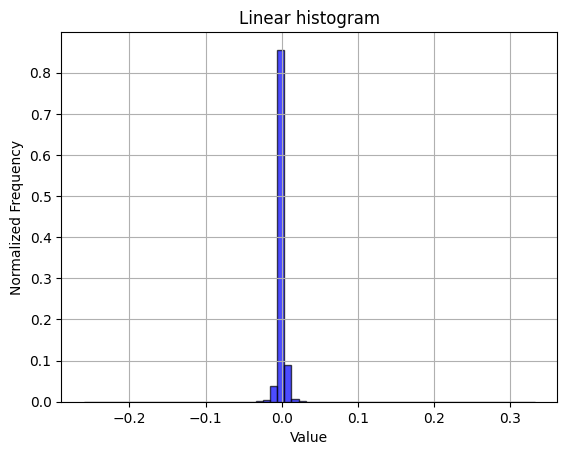

Module: Linear
Operation: Linear(in_features=4096, out_features=1024, bias=False)
[2.38418579e-07 0.00000000e+00 2.38418579e-07 2.38418579e-07
 7.15255737e-07 7.15255737e-07 9.53674316e-07 1.66893005e-06
 1.90734863e-06 3.57627869e-06 3.81469727e-06 6.43730164e-06
 3.57627869e-06 6.43730164e-06 6.91413879e-06 1.00135803e-05
 1.62124634e-05 2.59876251e-05 3.09944153e-05 4.14848328e-05
 7.20024109e-05 1.08957291e-04 1.86204910e-04 3.31163406e-04
 6.59942627e-04 1.56331062e-03 3.71146202e-03 9.98783112e-03
 3.15001011e-02 1.00785017e-01 6.72271490e-01 1.21160269e-01
 3.79090309e-02 1.16832256e-02 4.36878204e-03 1.84488297e-03
 7.77482986e-04 3.85284424e-04 1.94311142e-04 1.07288361e-04
 7.08103180e-05 4.24385071e-05 2.69412994e-05 2.64644623e-05
 1.40666962e-05 1.28746033e-05 8.10623169e-06 5.72204590e-06
 5.00679016e-06 3.81469727e-06 4.05311584e-06 2.62260437e-06
 1.43051147e-06 7.15255737e-07 9.53674316e-07 1.43051147e-06
 4.76837158e-07 7.15255737e-07 2.38418579e-07 0.00000000e+00
 2.

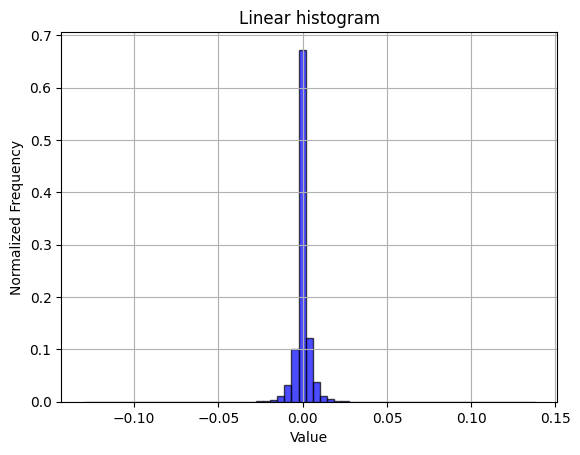

Module: Linear
Operation: Linear(in_features=4096, out_features=1024, bias=False)
[4.76837158e-07 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.38418579e-07 1.66893005e-06 1.90734863e-06 4.76837158e-06
 1.35898590e-05 1.81198120e-05 3.62396240e-05 4.74452972e-05
 1.07288361e-04 1.74283981e-04 3.16619873e-04 5.04493713e-04
 9.25779343e-04 1.52540207e-03 2.65884399e-03 4.26077843e-03
 7.14278221e-03 1.10483170e-02 1.80137157e-02 2.91559696e-02
 5.01809120e-02 9.84294415e-02 2.79272079e-01 2.74637699e-01
 9.66887474e-02 4.98366356e-02 2.88815498e-02 1.75735950e-02
 1.12082958e-02 6.79945946e-03 4.36210632e-03 2.50935555e-03
 1.52969360e-03 8.93831253e-04 5.22375107e-04 2.87055969e-04
 1.96218491e-04 1.03473663e-04 5.72204590e-05 2.74181366e-05
 2.02655792e-05 9.05990601e-06 6.19888306e-06 2.86102295e-06
 2.14576721e-06 1.90734863e-06 1.19209290e-06 0.00000000e+00
 0.00000000e+00 2.38418579e-07 0.00000000e+00 0.00000000e+00
 0.

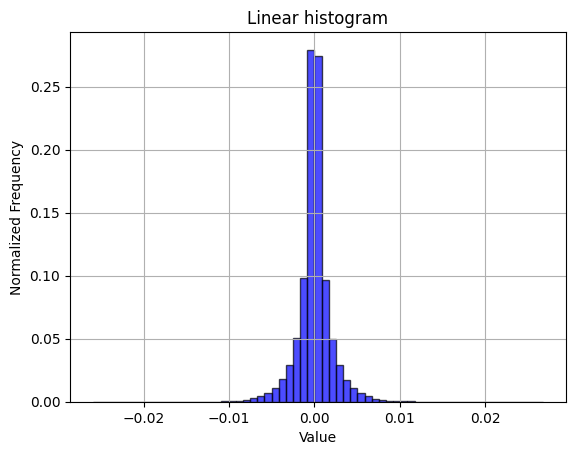

Module: MistralRotaryEmbedding
Operation: MistralRotaryEmbedding()
No weights in this module.
Module: Linear
Operation: Linear(in_features=4096, out_features=4096, bias=False)
[1.19209290e-07 0.00000000e+00 5.96046448e-08 1.19209290e-07
 2.98023224e-07 4.76837158e-07 6.55651093e-07 2.38418579e-07
 6.55651093e-07 1.19209290e-06 1.19209290e-06 1.37090683e-06
 2.20537186e-06 2.56299973e-06 4.64916229e-06 6.19888306e-06
 1.00135803e-05 1.35302544e-05 2.42590904e-05 4.59551811e-05
 8.52942467e-05 2.03967094e-04 5.48183918e-04 1.69575214e-03
 5.36203384e-03 1.68088078e-02 5.10485172e-02 1.72625184e-01
 3.72255623e-01 2.59527683e-01 8.15333128e-02 2.55608559e-02
 8.51160288e-03 2.69675255e-03 8.52108002e-04 2.95579433e-04
 1.27434731e-04 5.93662262e-05 3.33189964e-05 1.98483467e-05
 1.04308128e-05 6.67572021e-06 3.81469727e-06 2.86102295e-06
 1.78813934e-06 1.37090683e-06 1.96695328e-06 1.01327896e-06
 8.94069672e-07 8.34465027e-07 5.36441803e-07 2.38418579e-07
 2.38418579e-07 0.00000000e+00 

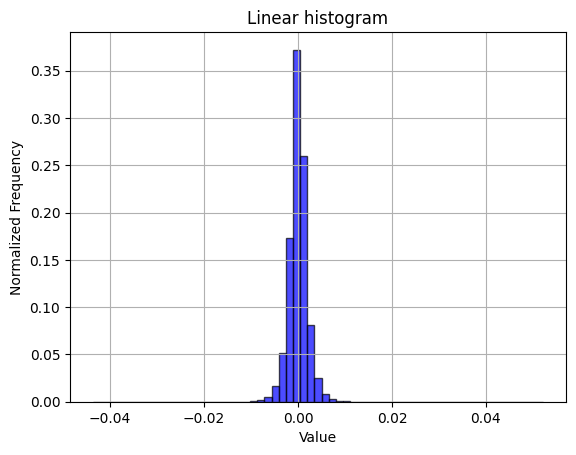

Module: MistralSdpaAttention
Operation: MistralSdpaAttention(
  (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
  (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
  (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
  (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
  (rotary_emb): MistralRotaryEmbedding()
)
No weights in this module.
Module: Linear
Operation: Linear(in_features=4096, out_features=14336, bias=False)
[1.70298985e-08 1.70298985e-08 0.00000000e+00 1.70298985e-08
 1.70298985e-08 1.70298985e-08 0.00000000e+00 1.70298985e-08
 0.00000000e+00 3.40597970e-08 5.10896955e-08 1.02179391e-07
 5.10896955e-08 1.02179391e-07 5.10896955e-08 1.70298985e-07
 1.70298985e-07 2.21388681e-07 2.72478376e-07 2.04358782e-07
 3.57627869e-07 5.10896955e-07 6.47136143e-07 1.22615269e-06
 1.83922904e-06 3.49112919e-06 6.70978001e-06 1.62124634e-05
 5.45467649e-05 2.69753592e-04 3.00027643e-03 3.42614821e-02
 1.93223357e-01 4.0159884

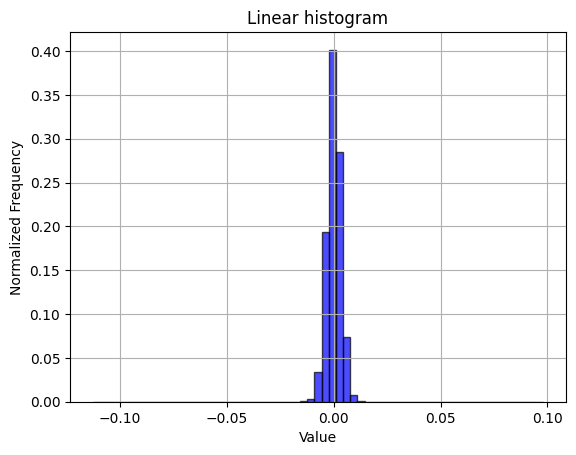

Module: SiLU
Operation: SiLU()
No weights in this module.
Module: Linear
Operation: Linear(in_features=4096, out_features=14336, bias=False)
[1.70298985e-08 0.00000000e+00 0.00000000e+00 3.40597970e-08
 1.70298985e-08 3.40597970e-08 1.70298985e-08 0.00000000e+00
 3.40597970e-08 6.81195940e-08 6.81195940e-08 6.81195940e-08
 2.38418579e-07 3.57627869e-07 2.89508275e-07 4.42777361e-07
 9.87734113e-07 1.89031873e-06 3.20162092e-06 7.22067697e-06
 1.78813934e-05 5.98430634e-05 2.40189689e-04 1.09854766e-03
 4.42012719e-03 1.49196046e-02 4.20751742e-02 8.99739606e-02
 1.55197178e-01 2.04816120e-01 2.00494954e-01 1.47715211e-01
 8.30514090e-02 3.78368071e-02 1.30115577e-02 3.85081768e-03
 9.25677163e-04 1.99454171e-04 5.17368317e-05 1.57867159e-05
 5.53471701e-06 3.52518899e-06 1.44754137e-06 9.19614519e-07
 4.25747463e-07 4.59807260e-07 1.87328884e-07 1.02179391e-07
 6.81195940e-08 1.02179391e-07 3.40597970e-08 3.40597970e-08
 1.70298985e-08 3.40597970e-08 1.70298985e-08 3.40597970e-08
 1.70

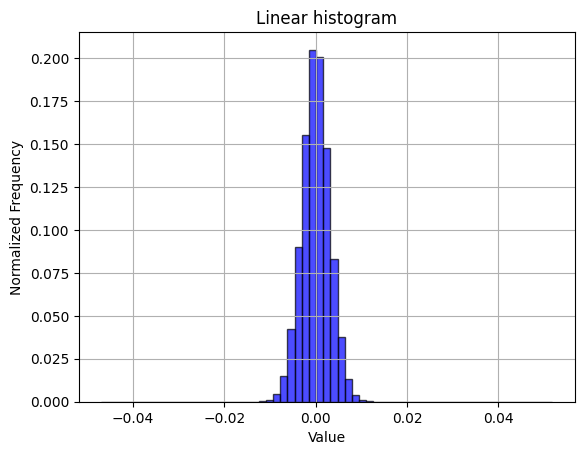

Module: Linear
Operation: Linear(in_features=14336, out_features=4096, bias=False)
[3.40597970e-08 0.00000000e+00 3.40597970e-08 1.70298985e-08
 1.70298985e-08 1.70298985e-08 0.00000000e+00 3.40597970e-08
 1.70298985e-08 0.00000000e+00 0.00000000e+00 6.81195940e-08
 8.51494925e-08 5.10896955e-08 1.70298985e-08 2.55448478e-07
 3.23568072e-07 3.40597970e-07 5.27926854e-07 7.49315534e-07
 1.03882381e-06 1.78813934e-06 2.91211264e-06 5.70501600e-06
 1.53269087e-05 6.31809235e-05 5.82797187e-04 9.23790251e-03
 8.53649889e-02 3.07955827e-01 3.93882734e-01 1.72526274e-01
 2.80542033e-02 2.10436753e-03 1.50970050e-04 2.79801232e-05
 9.31535448e-06 4.18935503e-06 1.94140843e-06 1.22615269e-06
 9.19614519e-07 4.93867057e-07 3.57627869e-07 2.55448478e-07
 1.87328884e-07 1.53269087e-07 1.19209290e-07 3.40597970e-08
 1.70298985e-08 5.10896955e-08 3.40597970e-08 1.70298985e-08
 0.00000000e+00 3.40597970e-08 1.70298985e-08 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.70298985e-08
 0

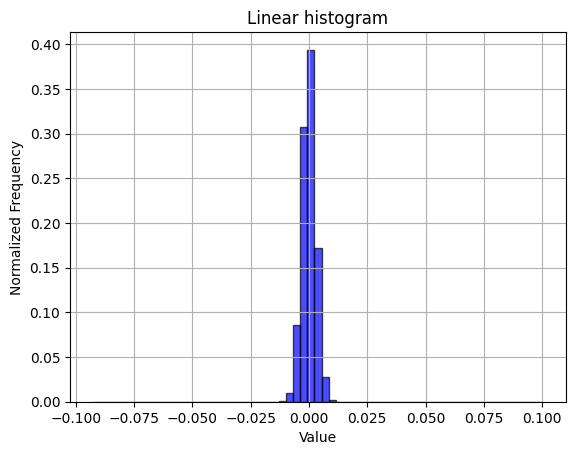

Module: MistralMLP
Operation: MistralMLP(
  (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
  (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
  (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
  (act_fn): SiLU()
)
No weights in this module.
Module: MistralDecoderLayer
Operation: MistralDecoderLayer(
  (self_attn): MistralSdpaAttention(
    (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
    (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
    (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
    (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
    (rotary_emb): MistralRotaryEmbedding()
  )
  (mlp): MistralMLP(
    (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
    (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
    (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
    (act_fn): SiLU()
  )
  (inp

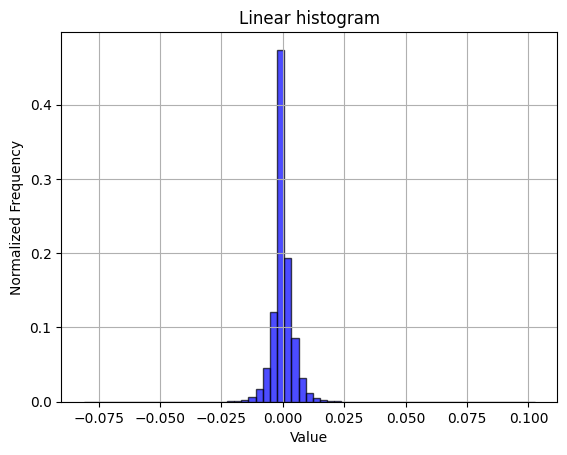

Module: Linear
Operation: Linear(in_features=4096, out_features=1024, bias=False)
[2.38418579e-07 2.38418579e-07 0.00000000e+00 0.00000000e+00
 2.38418579e-07 9.53674316e-07 2.14576721e-06 9.53674316e-07
 1.90734863e-06 5.72204590e-06 7.15255737e-06 5.48362732e-06
 1.26361847e-05 1.78813934e-05 2.12192535e-05 2.59876251e-05
 4.22000885e-05 5.14984131e-05 6.31809235e-05 1.00612640e-04
 1.36613846e-04 2.32696533e-04 3.18765640e-04 6.00099564e-04
 1.09648705e-03 2.13456154e-03 4.44698334e-03 1.01616383e-02
 2.26333141e-02 5.42321205e-02 1.20240211e-01 4.68469143e-01
 1.72195196e-01 8.01069736e-02 3.44994068e-02 1.50978565e-02
 6.51812553e-03 2.97117233e-03 1.49798393e-03 7.94410706e-04
 4.15563583e-04 2.71797180e-04 1.60455704e-04 1.14679337e-04
 7.79628754e-05 5.55515289e-05 3.95774841e-05 2.81333923e-05
 2.76565552e-05 1.93119049e-05 1.26361847e-05 1.14440918e-05
 5.48362732e-06 4.76837158e-06 3.81469727e-06 2.38418579e-06
 1.90734863e-06 1.19209290e-06 7.15255737e-07 4.76837158e-07
 0.

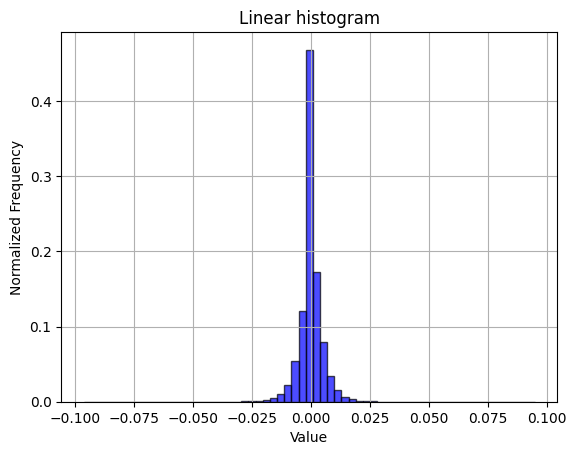

Module: Linear
Operation: Linear(in_features=4096, out_features=1024, bias=False)
[2.38418579e-07 0.00000000e+00 0.00000000e+00 2.38418579e-07
 4.76837158e-07 0.00000000e+00 9.53674316e-07 2.38418579e-07
 7.15255737e-07 1.66893005e-06 4.05311584e-06 9.53674316e-06
 1.90734863e-05 3.64780426e-05 5.36441803e-05 8.86917114e-05
 1.73568726e-04 2.99930573e-04 5.17129898e-04 7.79628754e-04
 1.42693520e-03 2.11811066e-03 3.59702110e-03 5.10072708e-03
 8.07929039e-03 1.11587048e-02 1.66416168e-02 2.19058990e-02
 2.93674469e-02 3.78336906e-02 4.67045307e-02 5.44369221e-02
 6.39090538e-02 1.70640945e-01 2.11115122e-01 6.50024414e-02
 5.64739704e-02 4.79385853e-02 3.85785103e-02 3.04594040e-02
 2.34122276e-02 1.63910389e-02 1.24301910e-02 8.07619095e-03
 5.71346283e-03 3.54838371e-03 2.40659714e-03 1.39379501e-03
 8.90731812e-04 5.35249710e-04 3.19719315e-04 1.62839890e-04
 1.09672546e-04 5.98430634e-05 3.21865082e-05 1.90734863e-05
 1.04904175e-05 4.76837158e-06 4.29153442e-06 1.90734863e-06
 7.

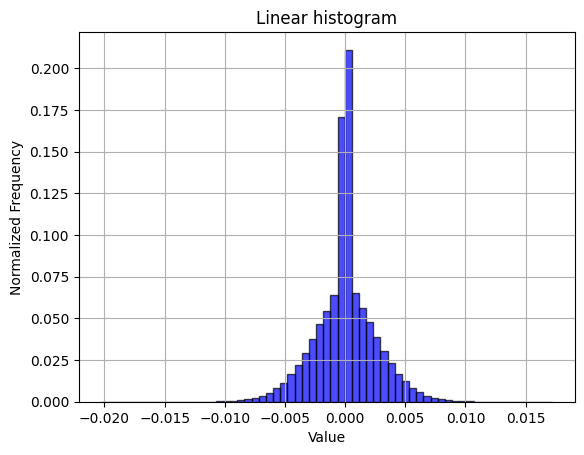

Module: MistralRotaryEmbedding
Operation: MistralRotaryEmbedding()
No weights in this module.
Module: Linear
Operation: Linear(in_features=4096, out_features=4096, bias=False)
[1.19209290e-07 1.19209290e-07 1.78813934e-07 5.96046448e-08
 5.96046448e-08 1.19209290e-07 3.57627869e-07 5.96046448e-07
 6.55651093e-07 8.34465027e-07 6.55651093e-07 1.25169754e-06
 2.44379044e-06 2.44379044e-06 3.51667404e-06 5.66244125e-06
 8.40425491e-06 1.06692314e-05 1.69277191e-05 2.38418579e-05
 4.02331352e-05 7.86781311e-05 1.46329403e-04 4.68134880e-04
 2.75397301e-03 1.83190107e-02 8.50492716e-02 2.38572478e-01
 3.34931135e-01 2.23650813e-01 7.73230791e-02 1.54638290e-02
 2.38370895e-03 4.13119793e-04 1.38223171e-04 6.85453415e-05
 3.96370888e-05 2.44975090e-05 1.63912773e-05 1.16229057e-05
 7.74860382e-06 4.70876694e-06 3.33786011e-06 2.92062759e-06
 2.02655792e-06 1.60932541e-06 1.25169754e-06 1.07288361e-06
 8.34465027e-07 6.55651093e-07 4.76837158e-07 7.15255737e-07
 2.38418579e-07 1.19209290e-07 

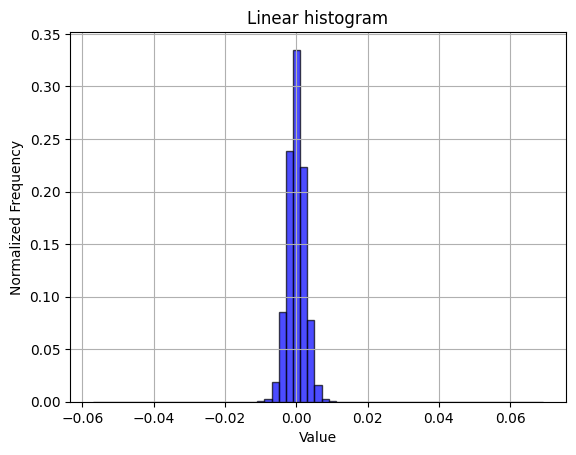

Module: MistralSdpaAttention
Operation: MistralSdpaAttention(
  (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
  (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
  (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
  (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
  (rotary_emb): MistralRotaryEmbedding()
)
No weights in this module.
Module: Linear
Operation: Linear(in_features=4096, out_features=14336, bias=False)
[1.70298985e-08 0.00000000e+00 1.70298985e-08 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40597970e-08
 1.70298985e-08 1.70298985e-08 1.70298985e-08 1.70298985e-08
 0.00000000e+00 1.70298985e-08 0.00000000e+00 0.00000000e+00
 3.40597970e-08 5.10896955e-08 3.40597970e-08 1.70298985e-08
 6.81195940e-08 3.40597970e-08 0.00000000e+00 1.02179391e-07
 1.70298985e-07 3.40597970e-07 7.83375331e-07 2.28200640e-06
 5.16005925e-06 1.40666962e-05 4.08717564e-05 8.43235425e-04
 1.24944483e-01 7.1782313

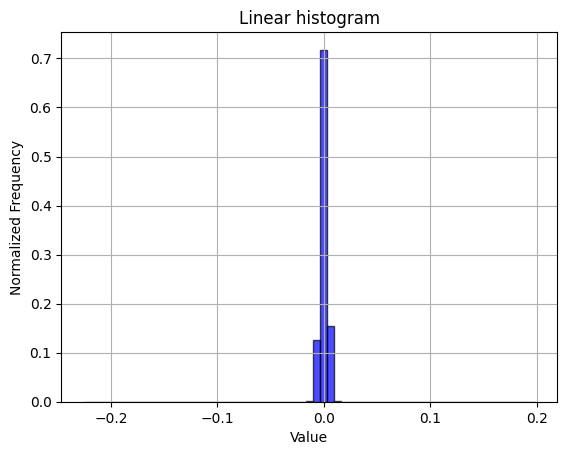

Module: SiLU
Operation: SiLU()
No weights in this module.
Module: Linear
Operation: Linear(in_features=4096, out_features=14336, bias=False)
[1.70298985e-08 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 3.40597970e-08 1.70298985e-08
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.70298985e-08
 5.10896955e-08 5.10896955e-08 2.55448478e-07 2.55448478e-07
 4.42777361e-07 6.47136143e-07 9.36644418e-07 1.82219914e-06
 3.37191990e-06 5.89234488e-06 1.15462712e-05 3.13350133e-05
 3.31129347e-04 5.29858044e-03 4.69844682e-02 1.93503806e-01
 3.62483399e-01 2.80625105e-01 9.48439496e-02 1.45954064e-02
 1.17140157e-03 7.20535006e-05 1.66211809e-05 7.39097595e-06
 4.13826534e-06 2.16279711e-06 1.58378056e-06 5.61986651e-07
 4.08717564e-07 3.06538173e-07 3.06538173e-07 2.38418579e-07
 8.51494925e-08 8.51494925e-08 3.40597970e-08 1.70298985e-08
 0.00000000e+00 0.00000000e+00 1.70298985e-08 0.00000000e+00
 0.00000000e+00 1.70298985e-08 0.00000000e+00 0.00000000e+00
 0.00

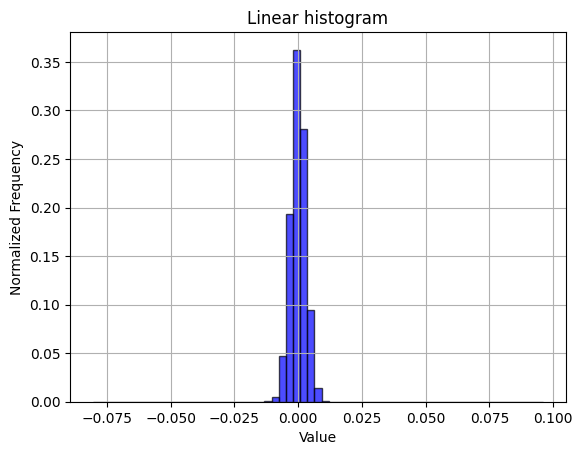

Module: Linear
Operation: Linear(in_features=14336, out_features=4096, bias=False)
[1.70298985e-08 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.70298985e-08 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.70298985e-08 1.70298985e-08 3.40597970e-08 3.40597970e-08
 8.51494925e-08 6.81195940e-08 1.53269087e-07 2.72478376e-07
 6.13076346e-07 1.87328884e-06 6.13076346e-06 1.01464135e-04
 9.50368132e-02 8.24163198e-01 8.05947781e-02 8.50813729e-05
 6.65869032e-06 1.46457127e-06 6.47136143e-07 3.91687666e-07
 5.10896955e-08 1.70298985e-08 1.70298985e-08 0.00000000e+00
 1.70298985e-08 0.00000000e+00 0.00000000e+00 1.70298985e-08
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.70298985e-08 1.70298985e-08
 0

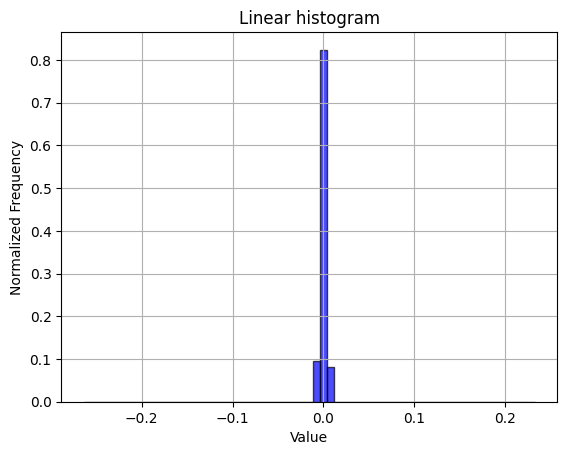

Module: MistralMLP
Operation: MistralMLP(
  (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
  (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
  (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
  (act_fn): SiLU()
)
No weights in this module.
Module: MistralDecoderLayer
Operation: MistralDecoderLayer(
  (self_attn): MistralSdpaAttention(
    (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
    (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
    (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
    (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
    (rotary_emb): MistralRotaryEmbedding()
  )
  (mlp): MistralMLP(
    (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
    (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
    (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
    (act_fn): SiLU()
  )
  (inp

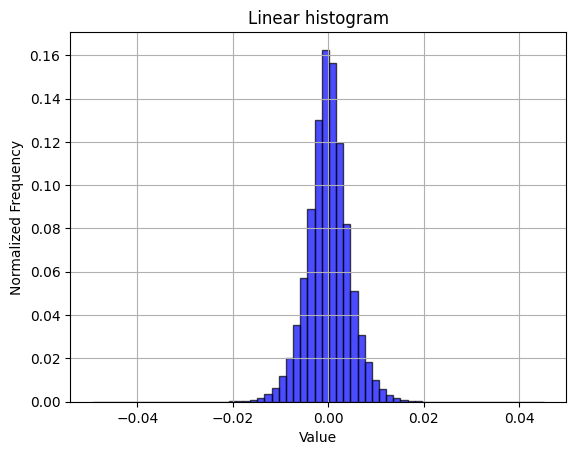

Module: Linear
Operation: Linear(in_features=4096, out_features=1024, bias=False)
[4.76837158e-07 2.38418579e-07 7.15255737e-07 2.38418579e-07
 9.53674316e-07 1.19209290e-06 1.43051147e-06 1.90734863e-06
 3.33786011e-06 2.86102295e-06 3.81469727e-06 7.62939453e-06
 7.39097595e-06 1.62124634e-05 2.19345093e-05 2.02655792e-05
 2.90870667e-05 4.36306000e-05 8.22544098e-05 1.61647797e-04
 2.72035599e-04 5.85556030e-04 1.16467476e-03 2.39372253e-03
 5.20586967e-03 1.01103783e-02 2.00836658e-02 3.78987789e-02
 6.98325634e-02 1.20438337e-01 1.89505339e-01 2.09410667e-01
 1.46960020e-01 8.55021477e-02 4.81004715e-02 2.58777142e-02
 1.33779049e-02 6.47830963e-03 3.34072113e-03 1.50060654e-03
 7.15017319e-04 3.75986099e-04 1.76429749e-04 9.84668732e-05
 5.74588776e-05 3.05175781e-05 2.59876251e-05 1.83582306e-05
 1.52587891e-05 1.02519989e-05 5.72204590e-06 6.91413879e-06
 5.24520874e-06 3.09944153e-06 2.86102295e-06 1.90734863e-06
 7.15255737e-07 1.19209290e-06 9.53674316e-07 4.76837158e-07
 2.

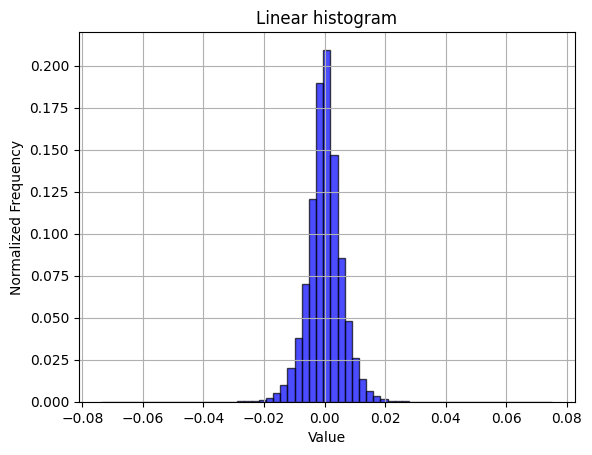

Module: Linear
Operation: Linear(in_features=4096, out_features=1024, bias=False)
[2.38418579e-07 0.00000000e+00 2.38418579e-07 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.38418579e-07
 0.00000000e+00 4.76837158e-07 2.38418579e-07 1.90734863e-06
 8.10623169e-06 3.26633453e-05 1.13487244e-04 4.12225723e-04
 1.25432014e-03 3.47447395e-03 8.50343704e-03 1.98390484e-02
 3.83369923e-02 7.08062649e-02 1.14154577e-01 1.64169550e-01
 1.91508532e-01 1.55250072e-01 1.05624199e-01 6.30350113e-02
 3.44824791e-02 1.72820091e-02 7.27748871e-03 2.92110443e-03
 1.04498863e-03 3.42130661e-04 8.86917114e-05 2.69412994e-05
 5.96046448e-06 1.19209290e-06 2.38418579e-07 0.00000000e+00
 2.38418579e-07 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

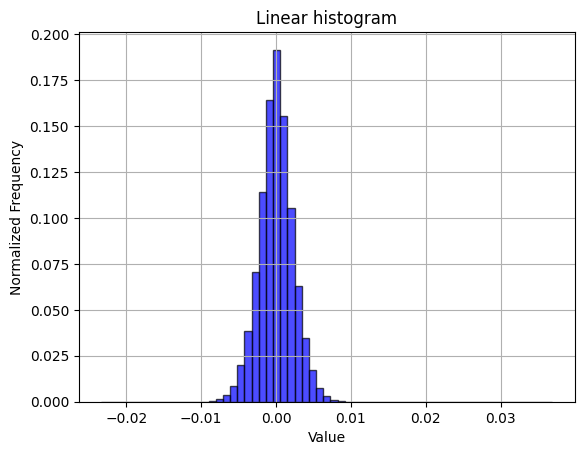

Module: MistralRotaryEmbedding
Operation: MistralRotaryEmbedding()
No weights in this module.
Module: Linear
Operation: Linear(in_features=4096, out_features=4096, bias=False)
[5.96046448e-08 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 5.96046448e-08 0.00000000e+00 5.96046448e-08
 5.96046448e-08 1.78813934e-07 5.96046448e-08 0.00000000e+00
 5.96046448e-08 0.00000000e+00 2.98023224e-07 3.57627869e-07
 2.38418579e-07 1.78813934e-07 7.74860382e-07 5.36441803e-07
 4.76837158e-07 7.74860382e-07 1.31130219e-06 1.66893005e-06
 2.92062759e-06 7.03334808e-06 1.16229057e-05 3.20672989e-05
 1.54554844e-04 3.20959091e-03 5.86208701e-02 3.47337663e-01
 4.60702300e-01 1.20293021e-01 9.18149948e-03 3.59833241e-04
 4.43458557e-05 1.65700912e-05 7.21216202e-06 3.21865082e-06
 2.38418579e-06 1.66893005e-06 1.31130219e-06 4.76837158e-07
 5.96046448e-07 4.76837158e-07 2.38418579e-07 2.38418579e-07
 1.78813934e-07 2.98023224e-07 

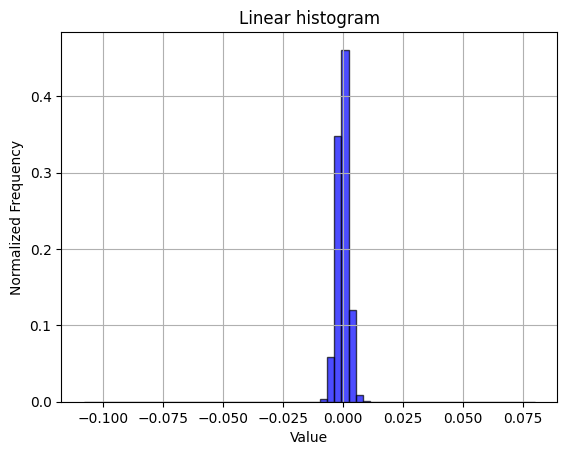

Module: MistralSdpaAttention
Operation: MistralSdpaAttention(
  (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
  (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
  (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
  (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
  (rotary_emb): MistralRotaryEmbedding()
)
No weights in this module.
Module: Linear
Operation: Linear(in_features=4096, out_features=14336, bias=False)
[1.70298985e-08 0.00000000e+00 3.40597970e-08 5.10896955e-08
 5.10896955e-08 6.81195940e-08 1.53269087e-07 1.87328884e-07
 1.36239188e-07 2.38418579e-07 2.04358782e-07 3.91687666e-07
 2.55448478e-07 6.13076346e-07 8.17435128e-07 1.22615269e-06
 1.61784036e-06 2.77587346e-06 4.22341483e-06 6.89710890e-06
 1.38793673e-05 3.66313117e-05 1.49675778e-04 9.78095191e-04
 5.84416730e-03 2.64481136e-02 8.29924004e-02 1.76656859e-01
 2.50248858e-01 2.32238293e-01 1.43491302e-01 6.02943557e-02
 1.65821825e-02 3.3491339

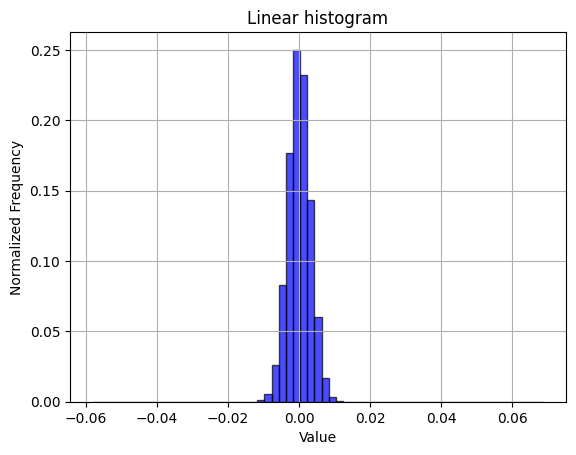

Module: SiLU
Operation: SiLU()
No weights in this module.
Module: Linear
Operation: Linear(in_features=4096, out_features=14336, bias=False)
[1.70298985e-08 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 3.40597970e-08 8.51494925e-08
 0.00000000e+00 8.51494925e-08 6.81195940e-08 1.53269087e-07
 6.81195940e-08 5.10896955e-08 1.87328884e-07 4.76837158e-07
 4.93867057e-07 8.34465027e-07 1.12397330e-06 1.66893005e-06
 2.98023224e-06 5.21114894e-06 1.26191548e-05 5.76632363e-05
 3.40121133e-04 1.82066645e-03 7.68399239e-03 2.50806808e-02
 6.59340450e-02 1.29519394e-01 1.91254939e-01 2.14946559e-01
 1.76116671e-01 1.09842845e-01 5.20219973e-02 1.87811000e-02
 5.22387028e-03 1.08071736e-03 2.10302217e-04 3.68867602e-05
 9.74110195e-06 4.07014574e-06 2.70775386e-06 1.75407955e-06
 1.02179391e-06 5.44956752e-07 4.59807260e-07 3.23568072e-07
 2.72478376e-07 1.36239188e-07 6.81195940e-08 5.10896955e-08
 6.81

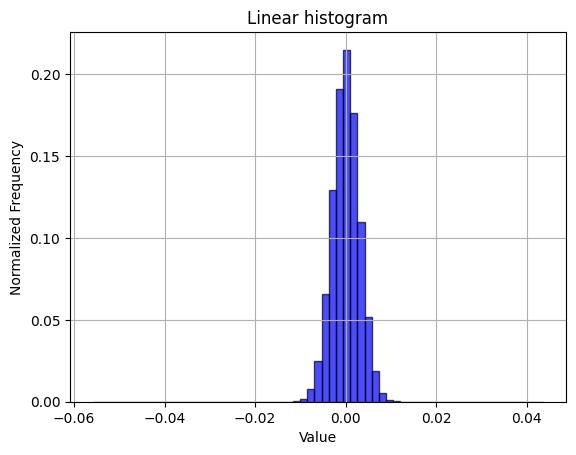

Module: Linear
Operation: Linear(in_features=14336, out_features=4096, bias=False)
[1.70298985e-08 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.70298985e-08 3.40597970e-08
 1.70298985e-08 1.70298985e-08 1.70298985e-08 3.40597970e-08
 3.40597970e-08 5.10896955e-08 8.51494925e-08 8.51494925e-08
 3.40597970e-08 1.19209290e-07 1.70298985e-07 3.06538173e-07
 4.76837158e-07 6.47136143e-07 1.58378056e-06 2.65666417e-06
 5.70501600e-06 1.77621841e-05 1.48568835e-04 3.31577233e-03
 4.34358801e-02 2.25244999e-01 4.10864966e-01 2.56553837e-01
 5.55317402e-02 4.62838582e-03 2.10285187e-04 2.14747020e-05
 6.19888306e-06 3.20162092e-06 1.92437853e-06 1.00476401e-06
 6.30106245e-07 3.06538173e-07 3.23568072e-07 1.87328884e-07
 8.51494925e-08 3.40597970e-08 6.81195940e-08 5.10896955e-08
 3.40597970e-08 1.70298985e-08 1.70298985e-08 0.00000000e+00
 3.40597970e-08 0.00000000e+00 1.70298985e-08 3.40597970e-08
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40597970e-08
 0

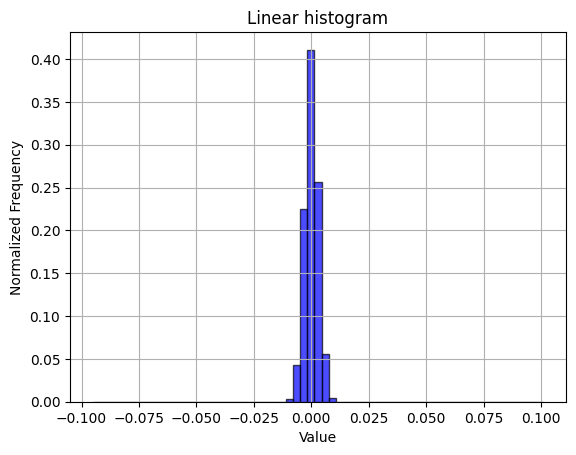

Module: MistralMLP
Operation: MistralMLP(
  (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
  (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
  (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
  (act_fn): SiLU()
)
No weights in this module.
Module: MistralDecoderLayer
Operation: MistralDecoderLayer(
  (self_attn): MistralSdpaAttention(
    (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
    (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
    (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
    (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
    (rotary_emb): MistralRotaryEmbedding()
  )
  (mlp): MistralMLP(
    (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
    (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
    (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
    (act_fn): SiLU()
  )
  (inp

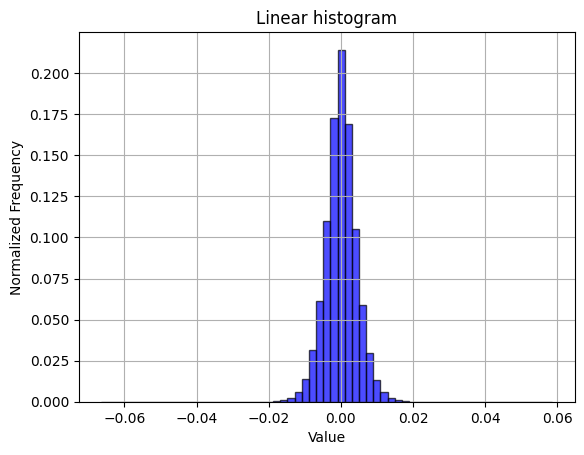

Module: Linear
Operation: Linear(in_features=4096, out_features=1024, bias=False)
[2.38418579e-07 0.00000000e+00 2.38418579e-07 2.38418579e-07
 0.00000000e+00 0.00000000e+00 2.38418579e-07 9.53674316e-07
 1.19209290e-06 2.38418579e-06 1.66893005e-06 2.86102295e-06
 4.76837158e-06 6.43730164e-06 1.35898590e-05 1.78813934e-05
 2.50339508e-05 4.48226929e-05 7.98702240e-05 1.34706497e-04
 2.43425369e-04 3.96490097e-04 7.58409500e-04 1.38878822e-03
 2.51245499e-03 4.52804565e-03 8.17847252e-03 1.41236782e-02
 2.40905285e-02 3.92041206e-02 6.23586178e-02 9.32304859e-02
 1.37100697e-01 1.77907705e-01 1.50589705e-01 1.03396177e-01
 6.98029995e-02 4.51087952e-02 2.72765160e-02 1.59542561e-02
 9.51576233e-03 5.45144081e-03 2.91228294e-03 1.61099434e-03
 8.84771347e-04 4.98533249e-04 2.71081924e-04 1.40190125e-04
 9.10758972e-05 5.57899475e-05 3.14712524e-05 1.93119049e-05
 1.07288361e-05 5.24520874e-06 4.76837158e-06 2.38418579e-06
 1.90734863e-06 2.14576721e-06 1.66893005e-06 2.38418579e-07
 2.

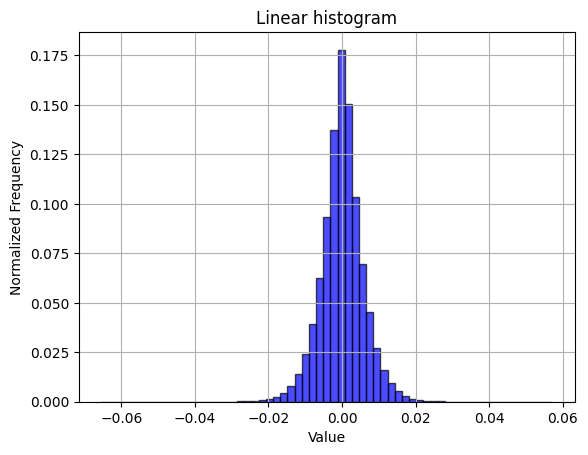

Module: Linear
Operation: Linear(in_features=4096, out_features=1024, bias=False)
[4.76837158e-07 2.38418579e-07 0.00000000e+00 1.19209290e-06
 4.76837158e-07 3.33786011e-06 5.00679016e-06 7.62939453e-06
 1.74045563e-05 2.74181366e-05 4.55379486e-05 7.72476196e-05
 1.58071518e-04 2.57492065e-04 4.38928604e-04 7.32660294e-04
 1.23500824e-03 2.04777718e-03 3.14688683e-03 4.85062599e-03
 7.25030899e-03 1.06246471e-02 1.50361061e-02 2.03883648e-02
 2.76415348e-02 3.57277393e-02 4.46004868e-02 5.34677505e-02
 6.27574921e-02 7.04915524e-02 7.72411823e-02 8.19692612e-02
 8.01002979e-02 7.41841793e-02 6.71060085e-02 5.79807758e-02
 4.93915081e-02 3.99842262e-02 3.13761234e-02 2.37159729e-02
 1.78177357e-02 1.28457546e-02 8.83960724e-03 5.99098206e-03
 3.90219688e-03 2.51507759e-03 1.62601471e-03 9.57250595e-04
 5.95569611e-04 3.53574753e-04 2.12430954e-04 1.13964081e-04
 6.27040863e-05 3.43322754e-05 1.76429749e-05 9.29832458e-06
 8.34465027e-06 4.05311584e-06 2.14576721e-06 1.66893005e-06
 0.

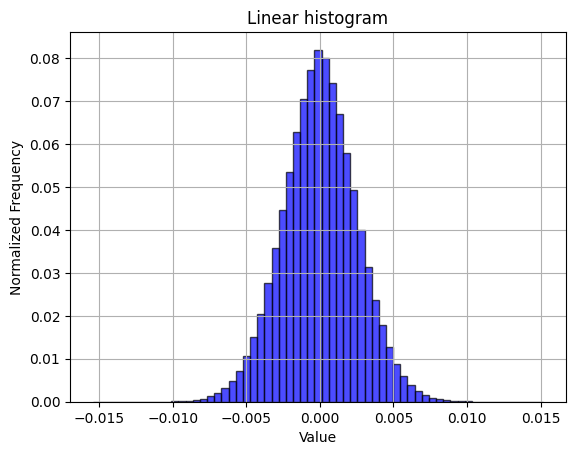

Module: MistralRotaryEmbedding
Operation: MistralRotaryEmbedding()
No weights in this module.
Module: Linear
Operation: Linear(in_features=4096, out_features=4096, bias=False)
[5.96046448e-08 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.19209290e-07 5.96046448e-08 0.00000000e+00
 0.00000000e+00 5.96046448e-08 0.00000000e+00 1.78813934e-07
 1.78813934e-07 2.38418579e-07 4.76837158e-07 7.74860382e-07
 8.34465027e-07 1.84774399e-06 1.96695328e-06 2.26497650e-06
 4.70876694e-06 7.45058060e-06 1.66296959e-05 3.69548798e-05
 1.38580799e-04 1.43402815e-03 2.15532184e-02 1.57267094e-01
 4.05624986e-01 3.23200881e-01 8.20303559e-02 8.03077221e-03
 5.08487225e-04 7.79628754e-05 2.62856483e-05 1.26361847e-05
 6.91413879e-06 3.75509262e-06 3.15904617e-06 1.90734863e-06
 8.94069672e-07 1.07288361e-06 6.55651093e-07 5.96046448e-07
 2.98023224e-07 0.00000000e+00 1.19209290e-07 5.96046448e-08
 5.96046448e-08 1.78813934e-07 

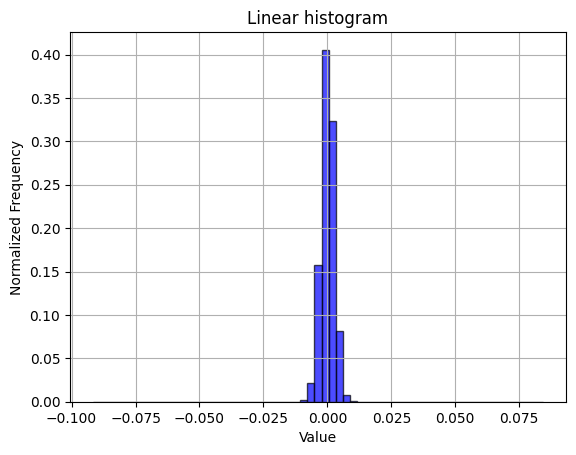

Module: MistralSdpaAttention
Operation: MistralSdpaAttention(
  (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
  (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
  (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
  (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
  (rotary_emb): MistralRotaryEmbedding()
)
No weights in this module.
Module: Linear
Operation: Linear(in_features=4096, out_features=14336, bias=False)
[1.70298985e-08 1.70298985e-08 0.00000000e+00 0.00000000e+00
 0.00000000e+00 3.40597970e-08 0.00000000e+00 5.10896955e-08
 8.51494925e-08 6.81195940e-08 1.36239188e-07 1.19209290e-07
 1.87328884e-07 1.70298985e-07 4.08717564e-07 6.30106245e-07
 7.49315534e-07 9.87734113e-07 1.17506300e-06 2.12873731e-06
 2.33309610e-06 5.50065722e-06 1.08991350e-05 2.54596983e-05
 1.06504985e-04 7.77568136e-04 4.83431135e-03 2.36343656e-02
 7.69137996e-02 1.70126149e-01 2.49718768e-01 2.39174059e-01
 1.50856103e-01 6.1768497

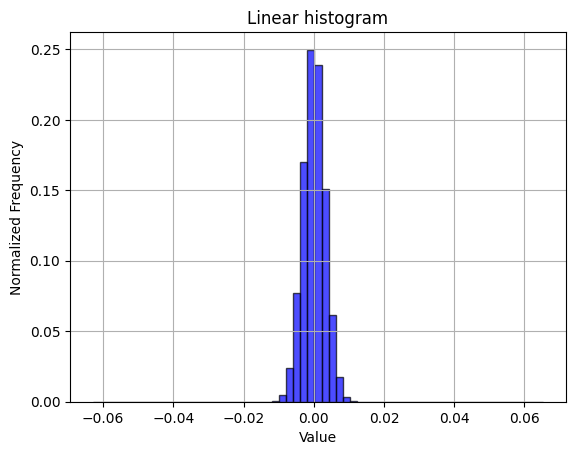

Module: SiLU
Operation: SiLU()
No weights in this module.
Module: Linear
Operation: Linear(in_features=4096, out_features=14336, bias=False)
[1.70298985e-08 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.70298985e-08 0.00000000e+00
 0.00000000e+00 1.70298985e-08 5.10896955e-08 3.40597970e-08
 1.70298985e-08 8.51494925e-08 5.10896955e-08 3.40597970e-08
 6.81195940e-08 1.02179391e-07 8.51494925e-08 2.72478376e-07
 4.59807260e-07 7.15255737e-07 1.02179391e-06 2.07764762e-06
 4.25747463e-06 1.08650752e-05 8.28674861e-05 8.69580678e-04
 7.67779350e-03 4.15764196e-02 1.33470961e-01 2.58210114e-01
 2.88542884e-01 1.83174287e-01 6.87151296e-02 1.53114455e-02
 2.11487498e-03 1.97189195e-04 2.27178846e-05 6.18185316e-06
 3.01429204e-06 1.53269087e-06 1.08991350e-06 6.47136143e-07
 3.23568072e-07 2.38418579e-07 1.36239188e-07 1.19209290e-07
 6.81195940e-08 0.00000000e+00 3.40597970e-08 3.40597970e-08
 1.70

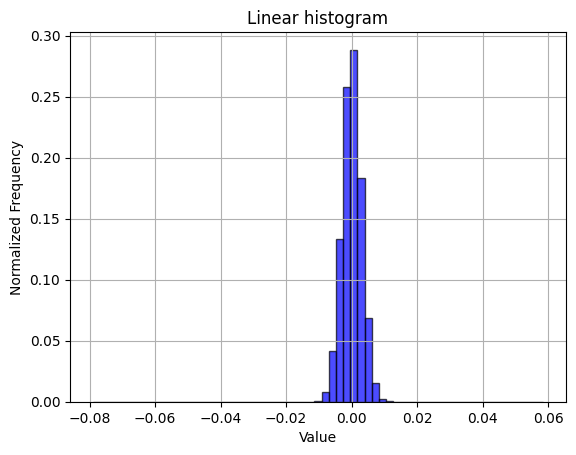

Module: Linear
Operation: Linear(in_features=14336, out_features=4096, bias=False)
[1.70298985e-08 0.00000000e+00 3.40597970e-08 1.70298985e-08
 1.70298985e-08 1.70298985e-08 0.00000000e+00 0.00000000e+00
 1.70298985e-08 0.00000000e+00 1.70298985e-08 0.00000000e+00
 3.40597970e-08 0.00000000e+00 6.81195940e-08 5.10896955e-08
 1.02179391e-07 1.36239188e-07 1.70298985e-07 2.89508275e-07
 6.13076346e-07 1.05585371e-06 2.69072396e-06 5.96046448e-06
 2.83207212e-05 1.07109547e-03 2.93938773e-02 2.35782419e-01
 4.75174172e-01 2.29410955e-01 2.81506607e-02 9.39760889e-04
 2.66688211e-05 5.94343458e-06 1.85625894e-06 1.12397330e-06
 5.79016549e-07 3.74657767e-07 2.89508275e-07 1.02179391e-07
 1.53269087e-07 6.81195940e-08 8.51494925e-08 5.10896955e-08
 0.00000000e+00 1.70298985e-08 3.40597970e-08 0.00000000e+00
 0.00000000e+00 1.70298985e-08 0.00000000e+00 0.00000000e+00
 1.70298985e-08 0.00000000e+00 0.00000000e+00 3.40597970e-08
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0

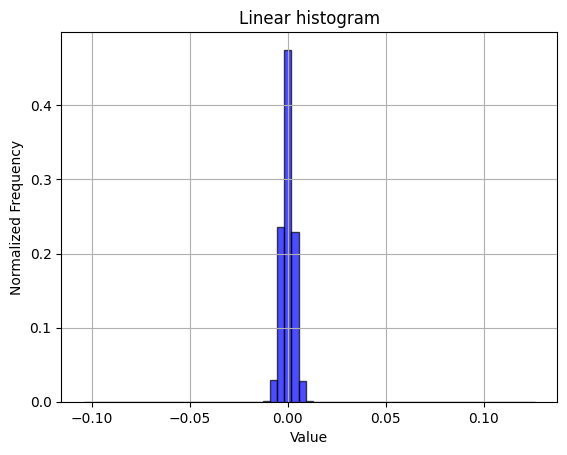

Module: MistralMLP
Operation: MistralMLP(
  (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
  (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
  (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
  (act_fn): SiLU()
)
No weights in this module.
Module: MistralDecoderLayer
Operation: MistralDecoderLayer(
  (self_attn): MistralSdpaAttention(
    (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
    (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
    (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
    (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
    (rotary_emb): MistralRotaryEmbedding()
  )
  (mlp): MistralMLP(
    (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
    (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
    (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
    (act_fn): SiLU()
  )
  (inp

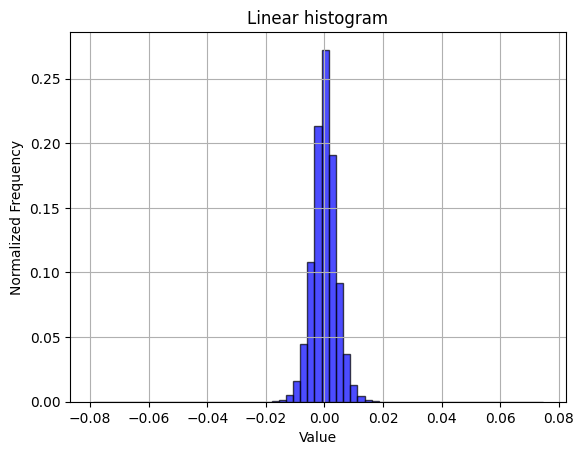

Module: Linear
Operation: Linear(in_features=4096, out_features=1024, bias=False)
[2.38418579e-07 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.38418579e-07 0.00000000e+00 0.00000000e+00 0.00000000e+00
 4.76837158e-07 0.00000000e+00 7.15255737e-07 0.00000000e+00
 2.38418579e-07 2.38418579e-07 7.15255737e-07 2.14576721e-06
 1.43051147e-06 2.86102295e-06 3.57627869e-06 2.38418579e-06
 5.00679016e-06 1.14440918e-05 1.23977661e-05 2.26497650e-05
 3.26633453e-05 7.65323639e-05 1.53303146e-04 3.70025635e-04
 9.03844833e-04 2.36868858e-03 5.98978996e-03 1.39393806e-02
 3.32038403e-02 7.46269226e-02 1.52528524e-01 2.49378204e-01
 2.28808165e-01 1.30384207e-01 6.07075691e-02 2.71198750e-02
 1.15101337e-02 4.60338593e-03 1.90353394e-03 7.50064850e-04
 2.91824341e-04 1.37090683e-04 6.19888306e-05 2.74181366e-05
 2.02655792e-05 1.28746033e-05 6.43730164e-06 4.76837158e-06
 3.57627869e-06 2.62260437e-06 9.53674316e-07 1.19209290e-06
 9.53674316e-07 1.43051147e-06 4.76837158e-07 0.00000000e+00
 0.

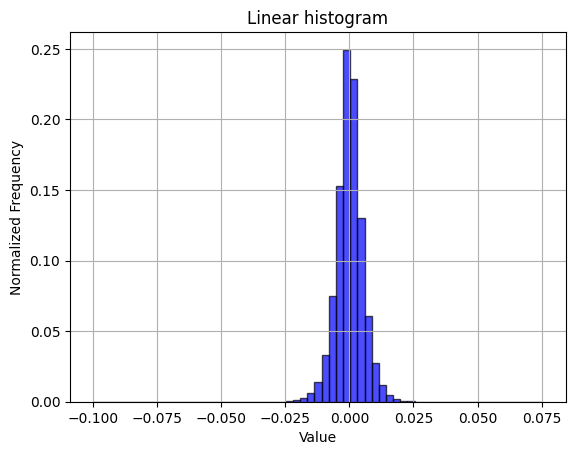

Module: Linear
Operation: Linear(in_features=4096, out_features=1024, bias=False)
[2.38418579e-07 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 4.76837158e-07 0.00000000e+00 2.38418579e-07
 0.00000000e+00 2.38418579e-07 2.38418579e-07 9.53674316e-07
 1.19209290e-06 1.19209290e-06 2.14576721e-06 6.43730164e-06
 1.43051147e-05 3.45706940e-05 8.05854797e-05 2.11477280e-04
 4.16517258e-04 1.01542473e-03 1.98960304e-03 4.21643257e-03
 7.69734383e-03 1.44059658e-02 2.30507851e-02 3.67197990e-02
 5.45125008e-02 7.50651360e-02 9.53154564e-02 1.11074448e-01
 1.21608973e-01 1.15037918e-01 9.80217457e-02 7.90479183e-02
 5.90298176e-02 4.09369469e-02 2.60741711e-02 1.62649155e-02
 8.77189636e-03 4.77671623e-03 2.48932838e-03 1.16634369e-03
 5.31196594e-04 2.19583511e-04 1.07765198e-04 4.52995300e-05
 1.97887421e-05 9.05990601e-06 3.57627869e-06 1.43051147e-06
 9.53674316e-07 0.00000000e+00 0.00000000e+00 2.38418579e-07
 4.76837158e-07 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

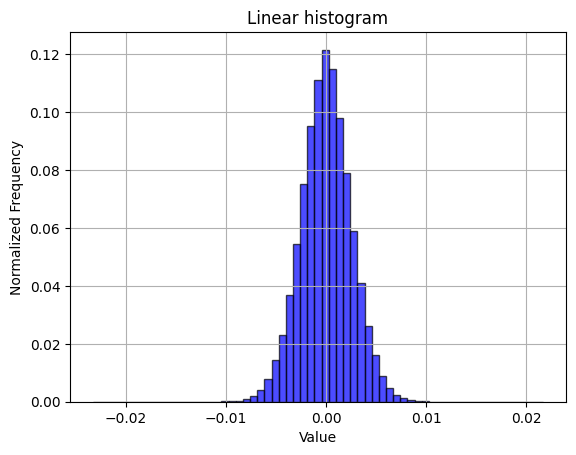

Module: MistralRotaryEmbedding
Operation: MistralRotaryEmbedding()
No weights in this module.
Module: Linear
Operation: Linear(in_features=4096, out_features=4096, bias=False)
[5.96046448e-08 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 5.96046448e-08 0.00000000e+00 0.00000000e+00
 1.19209290e-07 1.19209290e-07 1.19209290e-07 5.96046448e-08
 1.19209290e-07 5.96046448e-08 4.17232513e-07 2.98023224e-07
 3.57627869e-07 5.96046448e-07 1.13248825e-06 1.31130219e-06
 2.02655792e-06 2.50339508e-06 3.69548798e-06 4.52995300e-06
 9.17911530e-06 1.15036964e-05 2.16364861e-05 4.66704369e-05
 1.26600266e-04 8.16524029e-04 9.05239582e-03 7.08943605e-02
 2.61121333e-01 3.85139406e-01 2.16223180e-01 4.99233603e-02
 5.84697723e-03 5.58972359e-04 9.87648964e-05 3.81469727e-05
 1.85966492e-05 1.12652779e-05 7.51018524e-06 5.24520874e-06
 2.74181366e-06 1.90734863e-06 1.72853470e-06 1.07288361e-06
 8.34465027e-07 4.76837158e-07 2.38418579e-07 2.98023224e-07
 5.96046448e-08 2.98023224e-07 

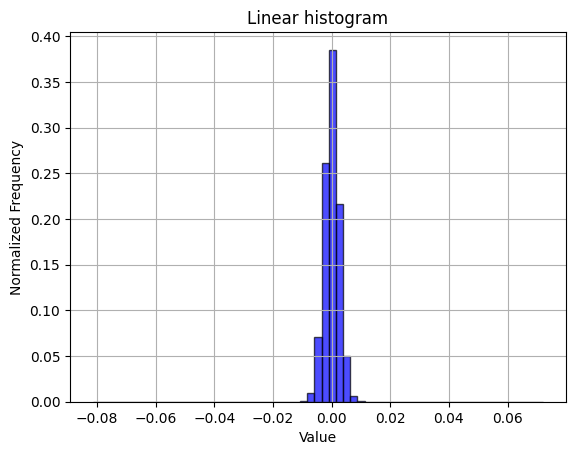

Module: MistralSdpaAttention
Operation: MistralSdpaAttention(
  (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
  (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
  (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
  (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
  (rotary_emb): MistralRotaryEmbedding()
)
No weights in this module.
Module: Linear
Operation: Linear(in_features=4096, out_features=14336, bias=False)
[3.40597970e-08 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.70298985e-08 0.00000000e+00 1.70298985e-08 1.70298985e-08
 5.10896955e-08 5.10896955e-08 5.10896955e-08 1.02179391e-07
 1.36239188e-07 1.19209290e-07 3.40597970e-08 2.38418579e-07
 2.55448478e-07 4.93867057e-07 5.61986651e-07 8.00405230e-07
 1.66893005e-06 2.53745488e-06 3.50815909e-06 8.10623169e-06
 1.68425696e-05 7.16107232e-05 7.15647425e-04 7.80751024e-03
 5.20864044e-02 1.84950573e-01 3.28721098e-01 2.80586106e-01
 1.16710220e-01 2.5055272

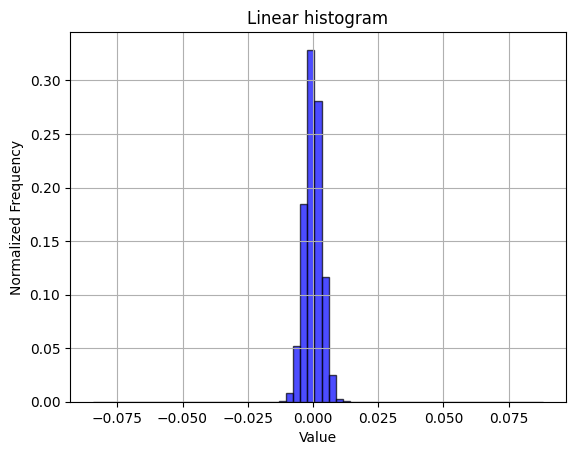

Module: SiLU
Operation: SiLU()
No weights in this module.
Module: Linear
Operation: Linear(in_features=4096, out_features=14336, bias=False)
[1.70298985e-08 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.70298985e-08 0.00000000e+00
 0.00000000e+00 0.00000000e+00 3.40597970e-08 0.00000000e+00
 3.40597970e-08 0.00000000e+00 0.00000000e+00 1.70298985e-08
 0.00000000e+00 5.10896955e-08 1.02179391e-07 3.40597970e-08
 1.36239188e-07 3.40597970e-08 1.02179391e-07 2.72478376e-07
 3.74657767e-07 7.66345433e-07 1.02179391e-06 2.23091670e-06
 4.87055097e-06 1.23637063e-05 1.05977058e-04 1.77645683e-03
 1.98943445e-02 1.10146454e-01 2.91724631e-01 3.46874441e-01
 1.79503441e-01 4.43971327e-02 5.16274997e-03 3.51088388e-04
 2.67710005e-05 7.11849758e-06 3.01429204e-06 1.56675066e-06
 9.19614519e-07 4.08717564e-07 3.57627869e-07 1.70298985e-07
 1.02179391e-07 8.51494925e-08 5.10896955e-08 3.40597970e-08
 5.10896955e-08 1.70298985e-08 1.70298985e-08 1.70298985e-08
 3.40

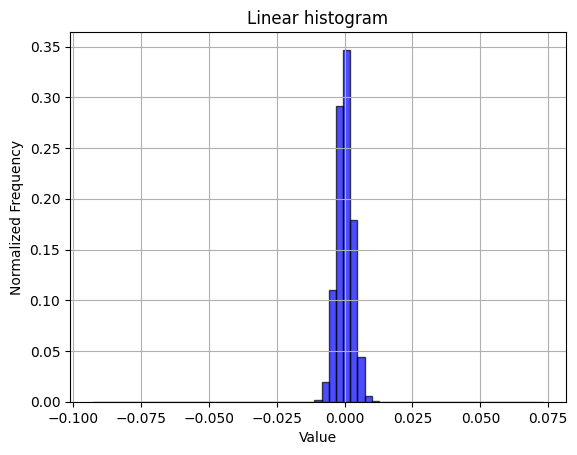

Module: Linear
Operation: Linear(in_features=14336, out_features=4096, bias=False)
[3.40597970e-08 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.70298985e-08 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.70298985e-08 1.70298985e-08 0.00000000e+00
 1.70298985e-08 3.40597970e-08 1.70298985e-08 6.81195940e-08
 1.19209290e-07 2.21388681e-07 2.55448478e-07 3.06538173e-07
 4.08717564e-07 6.47136143e-07 1.72001975e-06 3.40597970e-06
 8.20841108e-06 3.12328339e-05 9.53061240e-04 3.59721013e-02
 2.99610002e-01 4.96947169e-01 1.56155978e-01 1.00920200e-02
 1.95673534e-04 1.56504767e-05 5.70501600e-06 2.45230539e-06
 1.37942178e-06 7.32285636e-07 3.91687666e-07 3.40597970e-07
 2.38418579e-07 6.81195940e-08 3.40597970e-08 1.70298985e-08
 5.10896955e-08 3.40597970e-08 1.70298985e-08 1.70298985e-08
 0.00000000e+00 1.70298985e-08 0.00000000e+00 1.70298985e-08
 1.70298985e-08 1.70298985e-08 0.00000000e+00 1.70298985e-08
 0

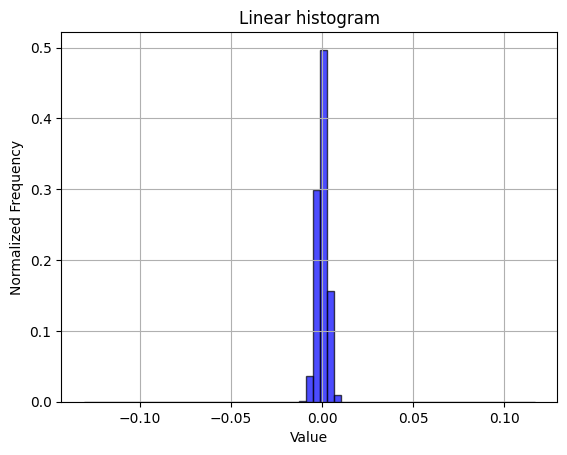

Module: MistralMLP
Operation: MistralMLP(
  (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
  (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
  (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
  (act_fn): SiLU()
)
No weights in this module.
Module: MistralDecoderLayer
Operation: MistralDecoderLayer(
  (self_attn): MistralSdpaAttention(
    (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
    (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
    (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
    (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
    (rotary_emb): MistralRotaryEmbedding()
  )
  (mlp): MistralMLP(
    (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
    (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
    (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
    (act_fn): SiLU()
  )
  (inp

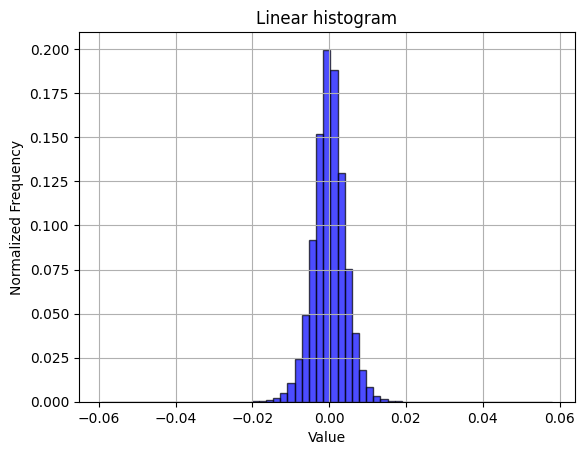

Module: Linear
Operation: Linear(in_features=4096, out_features=1024, bias=False)
[4.76837158e-07 0.00000000e+00 2.38418579e-07 1.19209290e-06
 7.15255737e-07 1.66893005e-06 2.14576721e-06 3.09944153e-06
 6.67572021e-06 5.72204590e-06 1.52587891e-05 2.16960907e-05
 4.74452972e-05 8.34465027e-05 1.70707703e-04 3.11851501e-04
 6.32524490e-04 1.34921074e-03 2.89440155e-03 5.80811501e-03
 1.13651752e-02 2.22749710e-02 4.01322842e-02 6.85682297e-02
 1.13108158e-01 1.64218664e-01 1.86563969e-01 1.50703430e-01
 9.99863148e-02 6.02128506e-02 3.37057114e-02 1.89468861e-02
 9.46927071e-03 4.73809242e-03 2.34556198e-03 1.21402740e-03
 5.25951385e-04 2.68459320e-04 1.33037567e-04 6.58035278e-05
 4.17232513e-05 2.16960907e-05 1.38282776e-05 6.67572021e-06
 3.33786011e-06 2.38418579e-06 2.62260437e-06 2.38418579e-06
 0.00000000e+00 2.38418579e-07 2.38418579e-07 2.38418579e-07
 2.38418579e-07 2.38418579e-07 0.00000000e+00 0.00000000e+00
 2.38418579e-07 0.00000000e+00 0.00000000e+00 2.38418579e-07
 0.

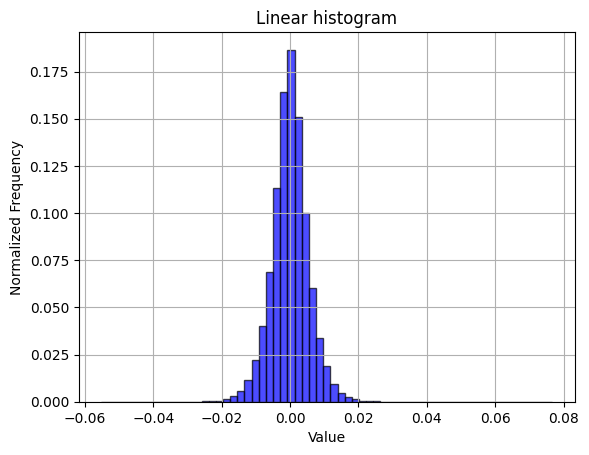

Module: Linear
Operation: Linear(in_features=4096, out_features=1024, bias=False)
[2.38418579e-07 2.38418579e-07 2.38418579e-07 4.76837158e-07
 2.38418579e-07 4.76837158e-07 1.19209290e-06 3.33786011e-06
 5.00679016e-06 1.64508820e-05 3.55243683e-05 6.58035278e-05
 1.31368637e-04 2.59637833e-04 5.33103943e-04 1.01733208e-03
 1.64437294e-03 2.91728973e-03 4.58383560e-03 7.70998001e-03
 1.21128559e-02 1.71449184e-02 2.45063305e-02 3.34188938e-02
 4.39109802e-02 5.57737350e-02 6.67810440e-02 7.78093338e-02
 8.62851143e-02 9.17840004e-02 8.90712738e-02 8.17945004e-02
 7.08947182e-02 5.92637062e-02 4.83818054e-02 3.83954048e-02
 2.76212692e-02 1.95906162e-02 1.39300823e-02 8.63647461e-03
 5.86676598e-03 3.57222557e-03 1.95503235e-03 1.22380257e-03
 6.36816025e-04 3.67403030e-04 1.79052353e-04 8.32080841e-05
 4.26769257e-05 2.26497650e-05 9.53674316e-06 5.24520874e-06
 9.53674316e-07 7.15255737e-07 0.00000000e+00 0.00000000e+00
 2.38418579e-07 2.38418579e-07 0.00000000e+00 0.00000000e+00
 0.

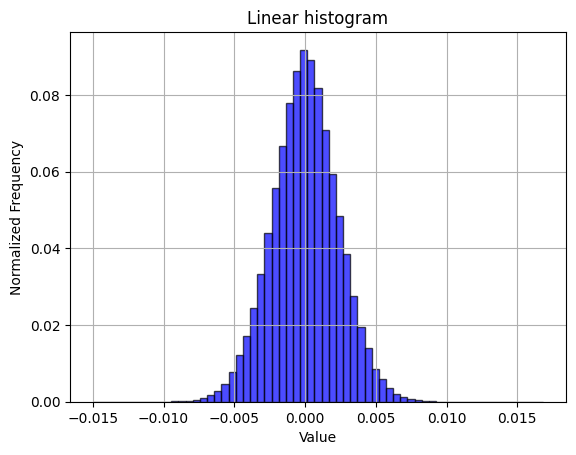

Module: MistralRotaryEmbedding
Operation: MistralRotaryEmbedding()
No weights in this module.
Module: Linear
Operation: Linear(in_features=4096, out_features=4096, bias=False)
[5.96046448e-08 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 5.96046448e-08
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 5.96046448e-08 1.78813934e-07 1.19209290e-07 5.96046448e-08
 1.78813934e-07 2.38418579e-07 4.17232513e-07 4.17232513e-07
 5.36441803e-07 1.19209290e-06 2.26497650e-06 7.27176666e-06
 3.44514847e-05 6.36339188e-04 1.57945156e-02 1.55495524e-01
 4.43540514e-01 3.19738150e-01 6.07398152e-02 3.85081768e-03
 1.35004520e-04 1.26957893e-05 5.54323196e-06 1.43051147e-06
 8.94069672e-07 2.98023224e-07 4.76837158e-07 1.78813934e-07
 5.96046448e-08 5.96046448e-08 

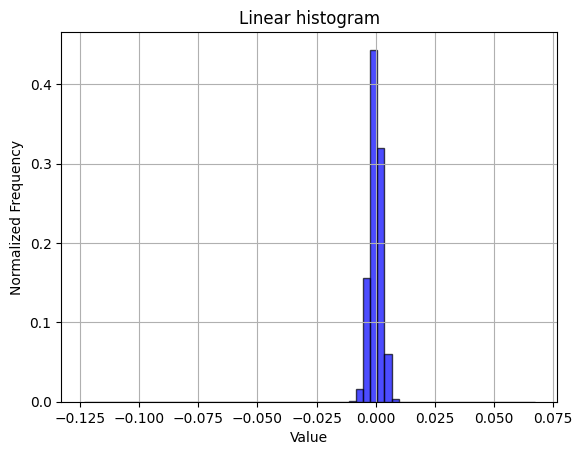

Module: MistralSdpaAttention
Operation: MistralSdpaAttention(
  (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
  (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
  (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
  (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
  (rotary_emb): MistralRotaryEmbedding()
)
No weights in this module.
Module: Linear
Operation: Linear(in_features=4096, out_features=14336, bias=False)
[1.70298985e-08 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.70298985e-08 1.70298985e-08 1.70298985e-08 3.40597970e-08
 1.70298985e-08 5.10896955e-08 1.02179391e-07 1.19209290e-07
 3.23568072e-07 1.87328884e-07 1.19209290e-07 3.74657767e-07
 5.61986651e-07 6.81195940e-07 8.34465027e-07 1.65190016e-06
 1.99249813e-06 3.49112919e-06 5.65392630e-06 9.82625144e-06
 3.34126609e-05 2.29290554e-04 2.25775582e-03 1.76571948e-02
 8.17326988e-02 2.20281482e-01 3.18194236e-01 2.38635506e-01
 9.54024792e-02 2.2084610

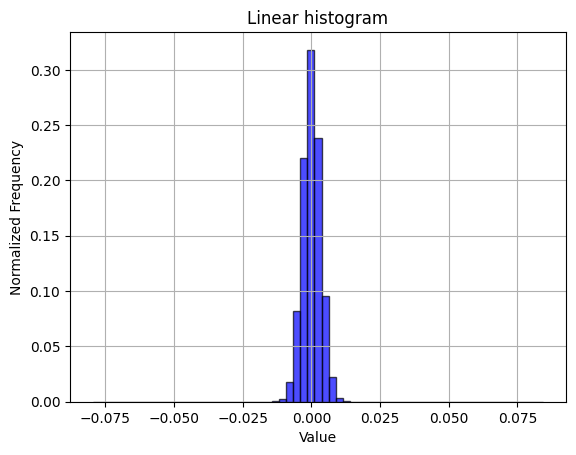

Module: SiLU
Operation: SiLU()
No weights in this module.
Module: Linear
Operation: Linear(in_features=4096, out_features=14336, bias=False)
[1.70298985e-08 1.70298985e-08 3.40597970e-08 0.00000000e+00
 0.00000000e+00 0.00000000e+00 5.10896955e-08 5.10896955e-08
 1.70298985e-08 1.70298985e-08 8.51494925e-08 2.04358782e-07
 2.21388681e-07 1.36239188e-07 2.89508275e-07 5.79016549e-07
 8.85554722e-07 1.68595995e-06 2.69072396e-06 3.67845808e-06
 7.69751413e-06 1.88691275e-05 9.56569399e-05 7.05633845e-04
 4.32942595e-03 2.02078649e-02 6.69343301e-02 1.52766160e-01
 2.37619775e-01 2.44027308e-01 1.65993946e-01 7.64866897e-02
 2.42865596e-02 5.42838233e-03 9.14369311e-04 1.23296465e-04
 2.33479909e-05 8.56603895e-06 4.46183341e-06 2.41824559e-06
 1.34536198e-06 1.03882381e-06 6.64166042e-07 3.06538173e-07
 3.23568072e-07 2.04358782e-07 2.38418579e-07 1.19209290e-07
 5.10896955e-08 1.70298985e-08 1.70298985e-08 3.40597970e-08
 6.81195940e-08 5.10896955e-08 3.40597970e-08 0.00000000e+00
 0.00

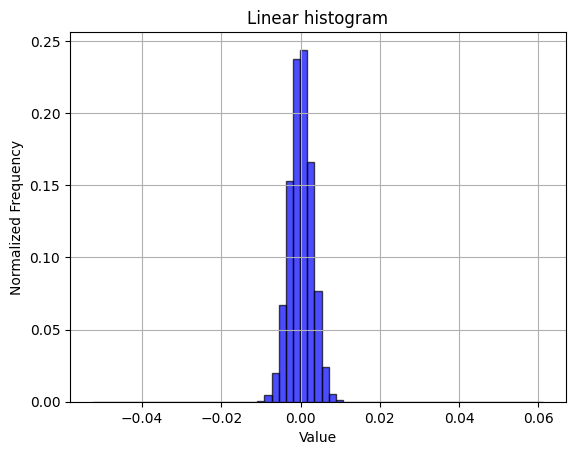

Module: Linear
Operation: Linear(in_features=14336, out_features=4096, bias=False)
[1.70298985e-08 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.70298985e-08 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.70298985e-08
 1.70298985e-08 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 3.40597970e-08 1.70298985e-08 0.00000000e+00
 0.00000000e+00 1.87328884e-07 1.70298985e-07 2.72478376e-07
 4.76837158e-07 5.27926854e-07 1.31130219e-06 2.12873731e-06
 5.05787986e-06 1.27553940e-05 1.23807362e-04 7.09583078e-03
 1.30493930e-01 4.87706150e-01 3.30470681e-01 4.28705726e-02
 1.16785935e-03 3.08241163e-05 9.29832458e-06 3.91687666e-06
 1.72001975e-06 9.36644418e-07 5.61986651e-07 2.89508275e-07
 2.21388681e-07 1.02179391e-07 1.19209290e-07 5.10896955e-08
 5.10896955e-08 0.00000000e+00 0.00000000e+00 1.70298985e-08
 1.70298985e-08 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1

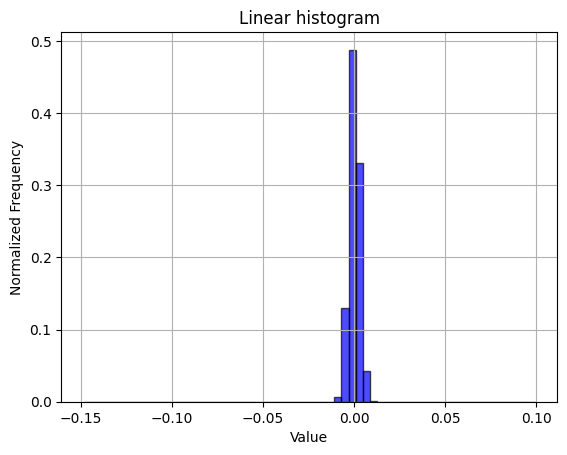

Module: MistralMLP
Operation: MistralMLP(
  (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
  (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
  (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
  (act_fn): SiLU()
)
No weights in this module.
Module: MistralDecoderLayer
Operation: MistralDecoderLayer(
  (self_attn): MistralSdpaAttention(
    (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
    (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
    (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
    (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
    (rotary_emb): MistralRotaryEmbedding()
  )
  (mlp): MistralMLP(
    (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
    (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
    (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
    (act_fn): SiLU()
  )
  (inp

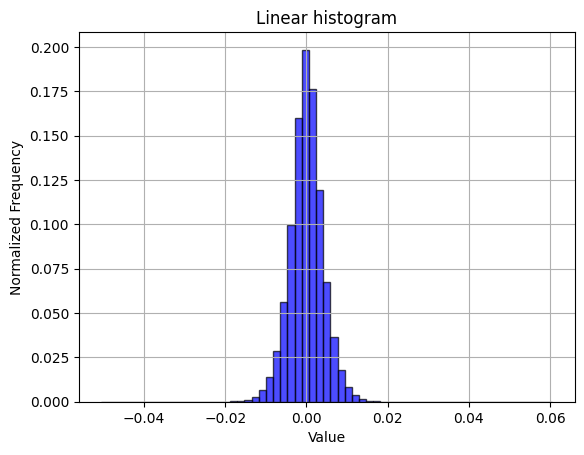

Module: Linear
Operation: Linear(in_features=4096, out_features=1024, bias=False)
[2.38418579e-07 0.00000000e+00 2.38418579e-07 2.38418579e-07
 1.19209290e-06 9.53674316e-07 1.19209290e-06 2.14576721e-06
 3.81469727e-06 3.33786011e-06 7.62939453e-06 1.02519989e-05
 1.45435333e-05 2.16960907e-05 3.19480896e-05 5.67436218e-05
 1.11818314e-04 2.46763229e-04 4.85658646e-04 1.06191635e-03
 2.34436989e-03 5.00750542e-03 1.01015568e-02 2.04751492e-02
 3.83362770e-02 6.94460869e-02 1.22806311e-01 1.88562155e-01
 2.05264330e-01 1.48002863e-01 8.76379013e-02 4.82957363e-02
 2.62222290e-02 1.30357742e-02 6.62541389e-03 3.04269791e-03
 1.42931938e-03 6.42776489e-04 3.18527222e-04 1.46865845e-04
 7.65323639e-05 4.10079956e-05 2.45571136e-05 1.66893005e-05
 1.07288361e-05 7.62939453e-06 5.48362732e-06 3.57627869e-06
 2.62260437e-06 1.19209290e-06 7.15255737e-07 9.53674316e-07
 1.19209290e-06 2.38418579e-07 2.38418579e-07 0.00000000e+00
 0.00000000e+00 2.38418579e-07 0.00000000e+00 0.00000000e+00
 0.

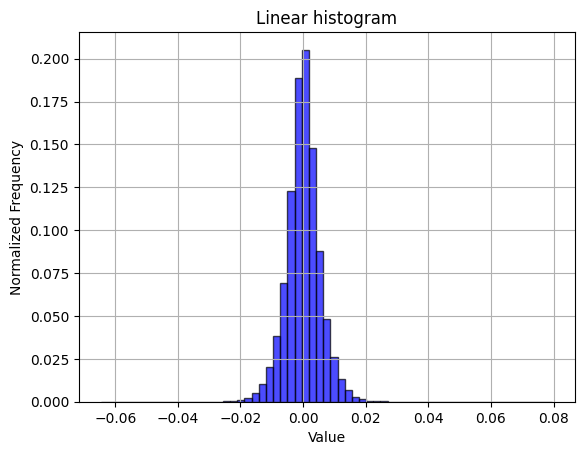

Module: Linear
Operation: Linear(in_features=4096, out_features=1024, bias=False)
[2.38418579e-07 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.38418579e-07 4.76837158e-07 7.15255737e-07 1.19209290e-06
 1.19209290e-06 5.48362732e-06 1.04904175e-05 1.78813934e-05
 4.48226929e-05 7.65323639e-05 1.68561935e-04 2.72274017e-04
 5.78165054e-04 9.58442688e-04 1.68514252e-03 2.86865234e-03
 4.71806526e-03 7.47442245e-03 1.05550289e-02 1.64680481e-02
 2.39558220e-02 3.14853191e-02 4.23338413e-02 5.39672375e-02
 6.40730858e-02 7.63614178e-02 8.45329762e-02 9.05017853e-02
 8.95051956e-02 8.32283497e-02 7.22935200e-02 6.16812706e-02
 5.03573418e-02 3.82678509e-02 2.97005177e-02 2.15427876e-02
 1.38909817e-02 1.00829601e-02 6.58965111e-03 4.08077240e-03
 2.47478485e-03 1.33633614e-03 8.66174698e-04 4.53710556e-04
 2.72989273e-04 1.19924545e-04 6.53266907e-05 4.02927399e-05
 1.47819519e-05 8.34465027e-06 2.86102295e-06 1.90734863e-06
 1.90734863e-06 2.38418579e-07 4.76837158e-07 4.76837158e-07
 0.

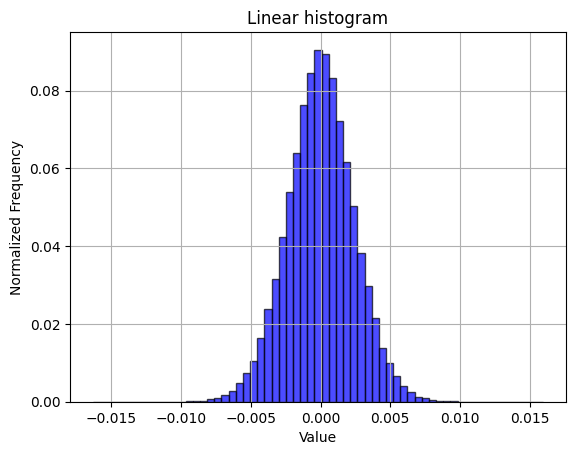

Module: MistralRotaryEmbedding
Operation: MistralRotaryEmbedding()
No weights in this module.
Module: Linear
Operation: Linear(in_features=4096, out_features=4096, bias=False)
[5.96046448e-08 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 5.96046448e-08
 0.00000000e+00 0.00000000e+00 5.96046448e-08 0.00000000e+00
 5.96046448e-08 1.19209290e-07 1.78813934e-07 2.38418579e-07
 3.57627869e-07 4.76837158e-07 7.74860382e-07 1.54972076e-06
 1.31130219e-06 2.38418579e-06 4.29153442e-06 5.90085983e-06
 8.16583633e-06 1.56760216e-05 2.71797180e-05 6.04391098e-05
 2.05159187e-04 1.15448236e-03 7.44277239e-03 3.72739434e-02
 1.23236477e-01 2.49175847e-01 2.92423010e-01 1.92503393e-01
 7.39720464e-02 1.85893178e-02 3.19939852e-03 4.93824482e-04
 1.08897686e-04 3.91602516e-05 1.94907188e-05 1.19805336e-05
 7.39097595e-06 4.23192978e-06 2.56299973e-06 1.66893005e-06
 1.60932541e-06 1.07288361e-06 5.36441803e-07 6.55651093e-07
 6.55651093e-07 2.98023224e-07 

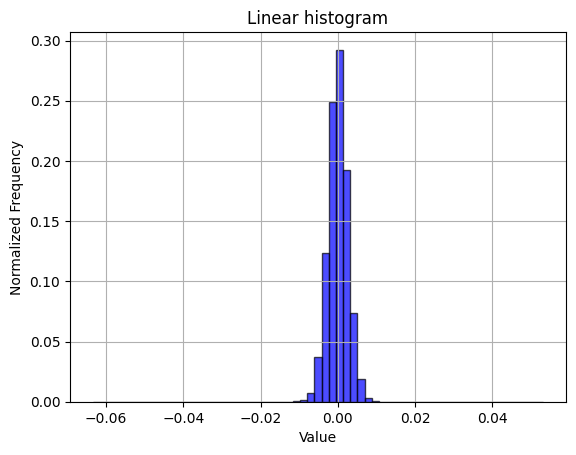

Module: MistralSdpaAttention
Operation: MistralSdpaAttention(
  (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
  (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
  (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
  (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
  (rotary_emb): MistralRotaryEmbedding()
)
No weights in this module.
Module: Linear
Operation: Linear(in_features=4096, out_features=14336, bias=False)
[1.70298985e-08 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.70298985e-08 0.00000000e+00 0.00000000e+00
 5.10896955e-08 1.70298985e-08 1.70298985e-08 6.81195940e-08
 6.81195940e-08 8.51494925e-08 1.19209290e-07 2.04358782e-07
 2.55448478e-07 2.89508275e-07 4.76837158e-07 1.14100320e-06
 1.65190016e-06 3.47409930e-06 6.38621194e-06 1.52758190e-05
 6.26870564e-05 7.70636967e-04 9.41167559e-03 6.61578689e-02
 2.36740998e-01 3.7106818

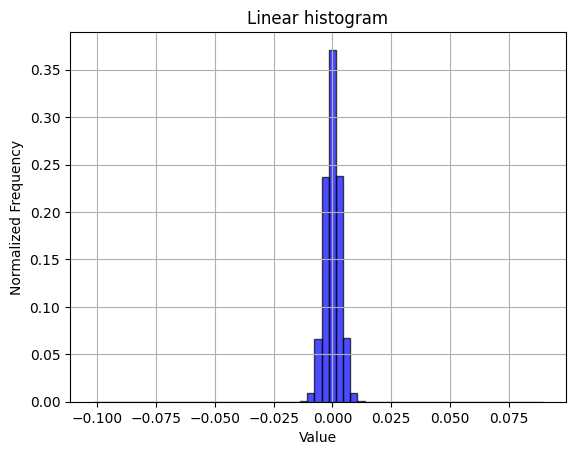

Module: SiLU
Operation: SiLU()
No weights in this module.
Module: Linear
Operation: Linear(in_features=4096, out_features=14336, bias=False)
[5.10896955e-08 0.00000000e+00 1.70298985e-08 3.40597970e-08
 3.40597970e-08 5.10896955e-08 1.36239188e-07 1.36239188e-07
 1.87328884e-07 1.53269087e-07 3.74657767e-07 4.76837158e-07
 4.93867057e-07 1.08991350e-06 1.34536198e-06 2.17982701e-06
 3.57627869e-06 6.40324184e-06 1.26702445e-05 4.25577164e-05
 2.36800739e-04 1.61503042e-03 8.74471664e-03 3.41473648e-02
 9.51476608e-02 1.87246203e-01 2.52708827e-01 2.19903690e-01
 1.29182850e-01 5.21548816e-02 1.50807074e-02 3.12864780e-03
 5.14115606e-04 7.51870019e-05 1.90394265e-05 8.22544098e-06
 5.02382006e-06 2.82696315e-06 2.02655792e-06 1.24318259e-06
 9.02584621e-07 6.47136143e-07 4.93867057e-07 1.19209290e-07
 2.89508275e-07 1.19209290e-07 1.02179391e-07 5.10896955e-08
 6.81195940e-08 3.40597970e-08 1.70298985e-08 3.40597970e-08
 3.40597970e-08 0.00000000e+00 1.70298985e-08 0.00000000e+00
 0.00

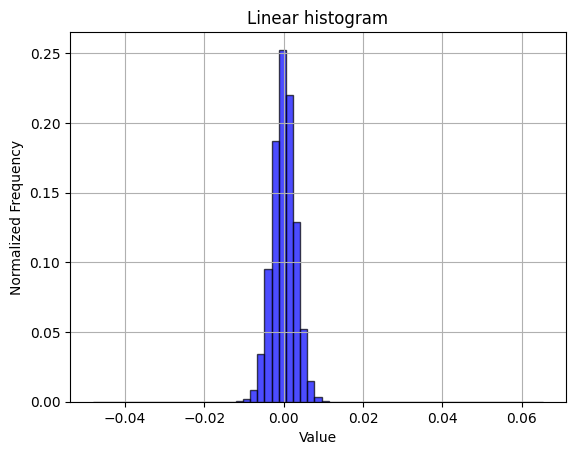

Module: Linear
Operation: Linear(in_features=14336, out_features=4096, bias=False)
[1.70298985e-08 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.70298985e-08 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.70298985e-08 5.10896955e-08 3.40597970e-08 3.40597970e-08
 5.10896955e-08 8.51494925e-08 1.53269087e-07 1.70298985e-07
 5.10896955e-07 6.81195940e-07 1.44754137e-06 3.61033848e-06
 1.06266567e-05 4.81264932e-05 1.54467991e-03 4.97187546e-02
 3.66278342e-01 4.74094101e-01 1.03450349e-01 4.72271442e-03
 1.01549285e-04 1.50714602e-05 5.00679016e-06 1.65190016e-06
 6.98225839e-07 4.76837158e-07 3.23568072e-07 2.04358782e-07
 1.53269087e-07 6.81195940e-08 8.51494925e-08 1.70298985e-08
 0.00000000e+00 1.70298985e-08 3.40597970e-08 1.70298985e-08
 1.70298985e-08 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0

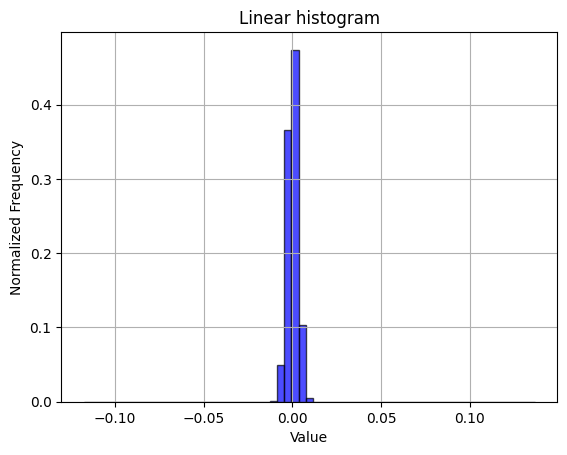

Module: MistralMLP
Operation: MistralMLP(
  (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
  (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
  (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
  (act_fn): SiLU()
)
No weights in this module.
Module: MistralDecoderLayer
Operation: MistralDecoderLayer(
  (self_attn): MistralSdpaAttention(
    (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
    (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
    (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
    (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
    (rotary_emb): MistralRotaryEmbedding()
  )
  (mlp): MistralMLP(
    (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
    (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
    (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
    (act_fn): SiLU()
  )
  (inp

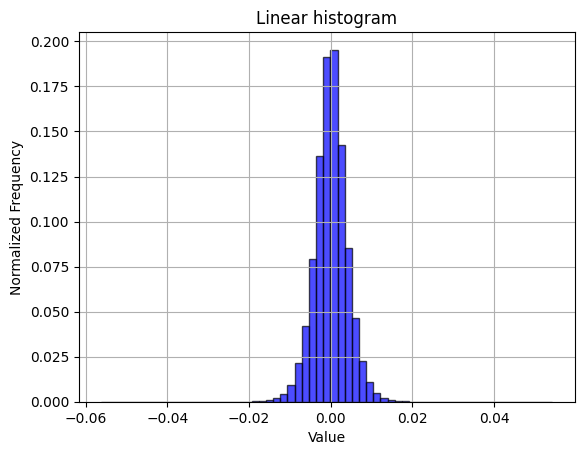

Module: Linear
Operation: Linear(in_features=4096, out_features=1024, bias=False)
[4.76837158e-07 2.38418579e-07 9.53674316e-07 9.53674316e-07
 2.38418579e-07 2.86102295e-06 3.57627869e-06 2.86102295e-06
 2.62260437e-06 4.76837158e-06 5.48362732e-06 6.19888306e-06
 9.05990601e-06 1.23977661e-05 1.00135803e-05 1.62124634e-05
 2.31266022e-05 3.21865082e-05 4.33921814e-05 8.89301300e-05
 1.70230865e-04 3.47852707e-04 7.39097595e-04 1.51467323e-03
 3.15618515e-03 6.52074814e-03 1.25973225e-02 2.39417553e-02
 4.56938744e-02 8.18102360e-02 1.37236357e-01 1.98851347e-01
 1.92980528e-01 1.30151033e-01 7.62865543e-02 4.21481133e-02
 2.22563744e-02 1.18484497e-02 5.85961342e-03 2.82073021e-03
 1.39093399e-03 6.67810440e-04 3.20911407e-04 1.65700912e-04
 8.82148743e-05 4.76837158e-05 2.64644623e-05 2.12192535e-05
 1.69277191e-05 1.07288361e-05 1.00135803e-05 7.62939453e-06
 6.67572021e-06 4.29153442e-06 4.05311584e-06 4.52995300e-06
 3.09944153e-06 1.90734863e-06 1.66893005e-06 7.15255737e-07
 7.

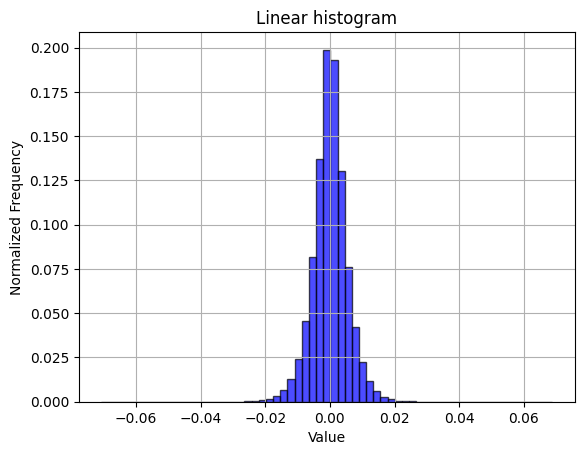

Module: Linear
Operation: Linear(in_features=4096, out_features=1024, bias=False)
[2.38418579e-07 0.00000000e+00 0.00000000e+00 4.76837158e-07
 1.43051147e-06 2.14576721e-06 2.62260437e-06 5.96046448e-06
 1.28746033e-05 3.21865082e-05 8.20159912e-05 1.70230865e-04
 3.08036804e-04 6.50405884e-04 1.28769875e-03 2.21109390e-03
 4.04024124e-03 6.89244270e-03 1.05895996e-02 1.73044205e-02
 2.53288746e-02 3.71232033e-02 4.89585400e-02 6.41052723e-02
 7.90972710e-02 9.27159786e-02 1.05584383e-01 1.05889559e-01
 9.46021080e-02 7.93750286e-02 6.58187866e-02 4.96606827e-02
 3.75428200e-02 2.59706974e-02 1.68983936e-02 1.14476681e-02
 7.14492798e-03 4.05287743e-03 2.43973732e-03 1.30963326e-03
 6.70433044e-04 3.51428986e-04 1.68561935e-04 8.82148743e-05
 2.88486481e-05 1.76429749e-05 8.58306885e-06 2.38418579e-06
 9.53674316e-07 7.15255737e-07 2.38418579e-07 0.00000000e+00
 9.53674316e-07 0.00000000e+00 0.00000000e+00 2.38418579e-07
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

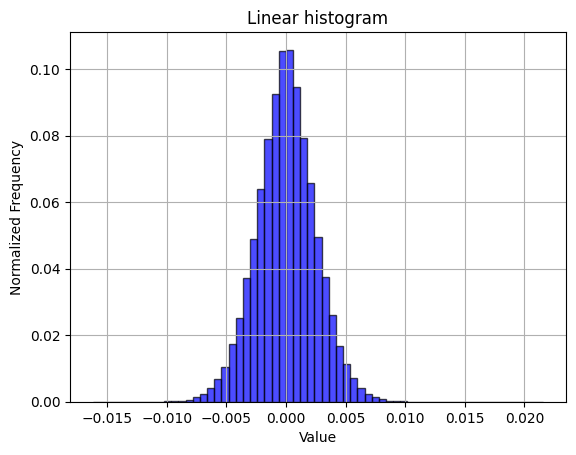

Module: MistralRotaryEmbedding
Operation: MistralRotaryEmbedding()
No weights in this module.
Module: Linear
Operation: Linear(in_features=4096, out_features=4096, bias=False)
[1.19209290e-07 0.00000000e+00 0.00000000e+00 0.00000000e+00
 5.96046448e-08 0.00000000e+00 5.96046448e-08 0.00000000e+00
 5.96046448e-08 1.19209290e-07 1.78813934e-07 1.78813934e-07
 2.38418579e-07 2.98023224e-07 1.01327896e-06 4.17232513e-07
 8.94069672e-07 1.72853470e-06 1.43051147e-06 2.38418579e-06
 2.44379044e-06 3.57627869e-06 5.42402267e-06 5.84125519e-06
 9.29832458e-06 2.01463699e-05 3.58223915e-05 1.20639801e-04
 8.26001167e-04 7.83675909e-03 5.34918308e-02 2.03454733e-01
 3.70299518e-01 2.63945401e-01 8.38033557e-02 1.42541528e-02
 1.56688690e-03 1.98781490e-04 4.89950180e-05 2.04443932e-05
 1.18017197e-05 7.80820847e-06 6.61611557e-06 3.21865082e-06
 2.62260437e-06 2.62260437e-06 1.60932541e-06 8.34465027e-07
 1.01327896e-06 5.96046448e-07 3.57627869e-07 5.36441803e-07
 1.78813934e-07 2.38418579e-07 

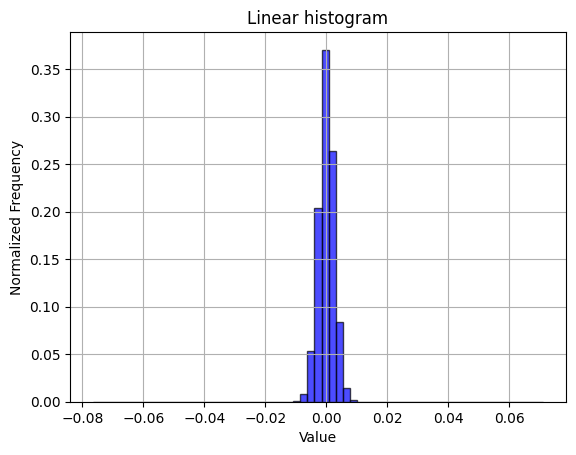

Module: MistralSdpaAttention
Operation: MistralSdpaAttention(
  (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
  (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
  (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
  (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
  (rotary_emb): MistralRotaryEmbedding()
)
No weights in this module.
Module: Linear
Operation: Linear(in_features=4096, out_features=14336, bias=False)
[1.70298985e-08 0.00000000e+00 1.70298985e-08 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 6.81195940e-08 3.40597970e-08 5.10896955e-08 1.70298985e-08
 8.51494925e-08 5.10896955e-08 5.10896955e-08 1.02179391e-07
 1.19209290e-07 1.87328884e-07 2.38418579e-07 4.59807260e-07
 7.32285636e-07 1.10694340e-06 1.73704965e-06 2.14576721e-06
 4.46183341e-06 9.29832458e-06 1.99249813e-05 9.05990601e-05
 8.11679023e-04 7.24857194e-03 4.43973030e-02 1.59703936e-01
 3.05474775e-01 2.9389648

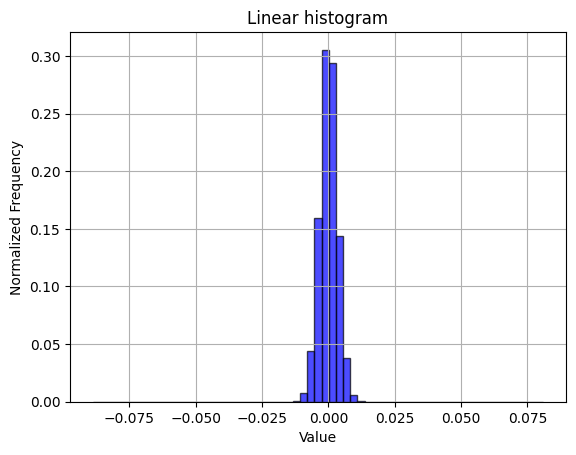

Module: SiLU
Operation: SiLU()
No weights in this module.
Module: Linear
Operation: Linear(in_features=4096, out_features=14336, bias=False)
[1.70298985e-08 1.70298985e-08 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.70298985e-08 1.70298985e-08 1.70298985e-08 1.70298985e-08
 1.70298985e-08 1.70298985e-08 3.40597970e-08 3.40597970e-08
 5.10896955e-08 6.81195940e-08 1.19209290e-07 1.53269087e-07
 3.40597970e-07 3.91687666e-07 8.68524824e-07 8.51494925e-07
 1.78813934e-06 2.82696315e-06 6.30106245e-06 1.66722706e-05
 9.99314444e-05 1.07961042e-03 1.00350039e-02 5.76189075e-02
 1.83980567e-01 3.15616250e-01 2.73668528e-01 1.23417224e-01
 2.97180755e-02 4.28342819e-03 3.85948590e-04 4.24895968e-05
 1.18528094e-05 5.27926854e-06 2.57151467e-06 1.22615269e-06
 6.47136143e-07 4.59807260e-07 3.74657767e-07 2.72478376e-07
 2.38418579e-07 1.19209290e-07 5.10896955e-08 6.81195940e-08
 3.40597970e-08 3.40597970e-08 3.40597970e-08 5.10896955e-08
 0.00

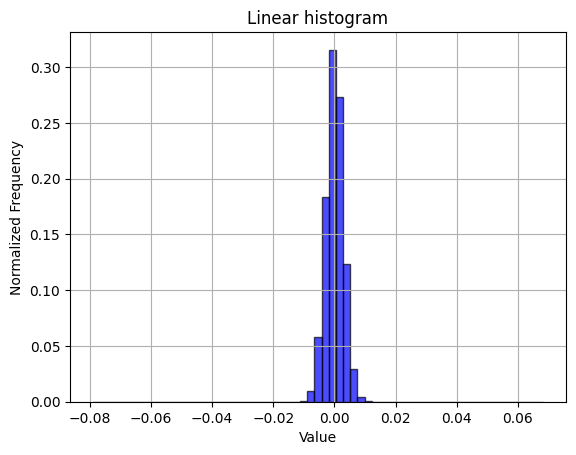

Module: Linear
Operation: Linear(in_features=14336, out_features=4096, bias=False)
[1.70298985e-08 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.70298985e-08 3.40597970e-08 0.00000000e+00 0.00000000e+00
 3.40597970e-08 1.70298985e-08 1.19209290e-07 5.10896955e-08
 6.81195940e-08 5.10896955e-08 2.21388681e-07 3.06538173e-07
 5.27926854e-07 8.51494925e-07 1.77110944e-06 3.21865082e-06
 6.33512224e-06 1.93970544e-05 1.87635422e-04 3.87121950e-03
 4.66489281e-02 2.29286432e-01 4.16450432e-01 2.45888557e-01
 5.27720451e-02 4.60374355e-03 2.22376415e-04 2.16279711e-05
 7.20364707e-06 2.96320234e-06 1.46457127e-06 9.70704215e-07
 3.40597970e-07 3.06538173e-07 1.70298985e-07 3.40597970e-08
 8.51494925e-08 8.51494925e-08 5.10896955e-08 3.40597970e-08
 5.10896955e-08 6.81195940e-08 1.70298985e-08 1.70298985e-08
 3.40597970e-08 1.70298985e-08 1.70298985e-08 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.70298985e-08 0.00000000e+00
 0

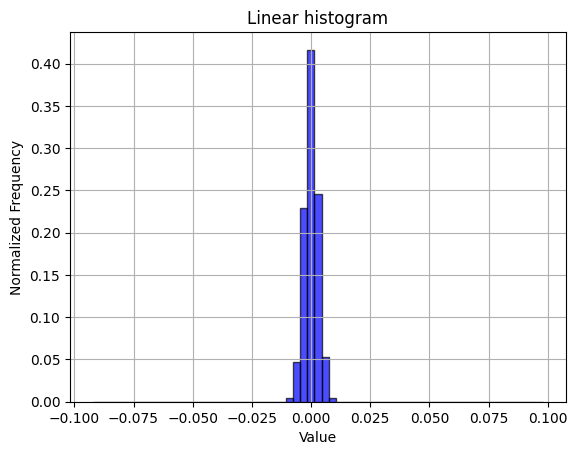

Module: MistralMLP
Operation: MistralMLP(
  (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
  (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
  (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
  (act_fn): SiLU()
)
No weights in this module.
Module: MistralDecoderLayer
Operation: MistralDecoderLayer(
  (self_attn): MistralSdpaAttention(
    (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
    (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
    (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
    (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
    (rotary_emb): MistralRotaryEmbedding()
  )
  (mlp): MistralMLP(
    (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
    (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
    (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
    (act_fn): SiLU()
  )
  (inp

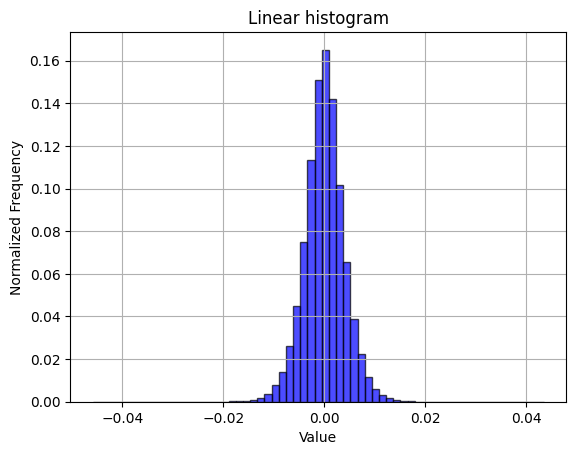

Module: Linear
Operation: Linear(in_features=4096, out_features=1024, bias=False)
[2.38418579e-07 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.38418579e-07 4.76837158e-07 2.38418579e-07 2.38418579e-07
 0.00000000e+00 9.53674316e-07 9.53674316e-07 1.43051147e-06
 2.38418579e-07 1.43051147e-06 5.24520874e-06 6.43730164e-06
 1.04904175e-05 2.50339508e-05 4.64916229e-05 8.55922699e-05
 1.73091888e-04 3.10420990e-04 6.40869141e-04 1.20425224e-03
 2.40063667e-03 4.51660156e-03 8.31341743e-03 1.55708790e-02
 2.89607048e-02 5.16147614e-02 8.86809826e-02 1.41434431e-01
 1.87390089e-01 1.76553249e-01 1.24043703e-01 7.38799572e-02
 4.27827835e-02 2.38063335e-02 1.30305290e-02 6.88791275e-03
 3.74341011e-03 1.84154510e-03 1.01590157e-03 4.73499298e-04
 2.51054764e-04 1.40428543e-04 6.96182251e-05 3.81469727e-05
 1.81198120e-05 1.14440918e-05 6.43730164e-06 4.29153442e-06
 2.38418579e-06 4.76837158e-07 4.76837158e-07 0.00000000e+00
 7.15255737e-07 0.00000000e+00 2.38418579e-07 0.00000000e+00
 2.

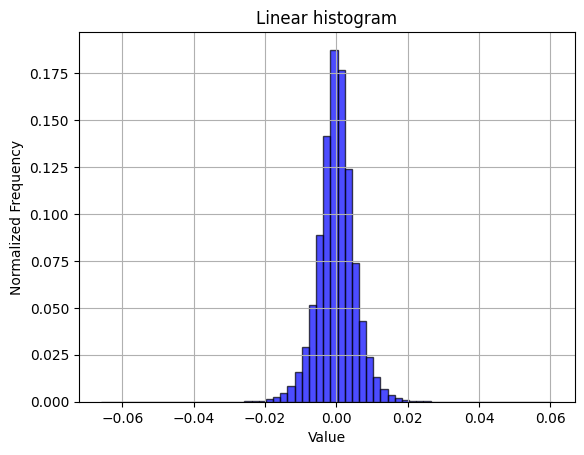

Module: Linear
Operation: Linear(in_features=4096, out_features=1024, bias=False)
[4.76837158e-07 7.15255737e-07 0.00000000e+00 4.76837158e-07
 7.15255737e-07 1.19209290e-06 1.66893005e-06 2.38418579e-06
 9.05990601e-06 8.58306885e-06 1.62124634e-05 3.09944153e-05
 5.24520874e-05 8.48770142e-05 1.69754028e-04 2.44617462e-04
 3.94821167e-04 7.26222992e-04 1.10173225e-03 1.73211098e-03
 3.00288200e-03 4.90784645e-03 8.03399086e-03 1.21886730e-02
 1.99615955e-02 3.01744938e-02 4.32341099e-02 6.07566833e-02
 7.74250031e-02 9.36677456e-02 1.07552052e-01 1.11876488e-01
 1.03469849e-01 8.72080326e-02 7.06195831e-02 5.40459156e-02
 3.74732018e-02 2.57053375e-02 1.68585777e-02 1.02386475e-02
 6.66546822e-03 4.09555435e-03 2.45261192e-03 1.49798393e-03
 8.58306885e-04 5.77449799e-04 3.33786011e-04 2.06947327e-04
 1.44243240e-04 7.55786896e-05 4.55379486e-05 2.93254852e-05
 1.62124634e-05 8.58306885e-06 4.05311584e-06 2.62260437e-06
 3.09944153e-06 1.19209290e-06 7.15255737e-07 4.76837158e-07
 0.

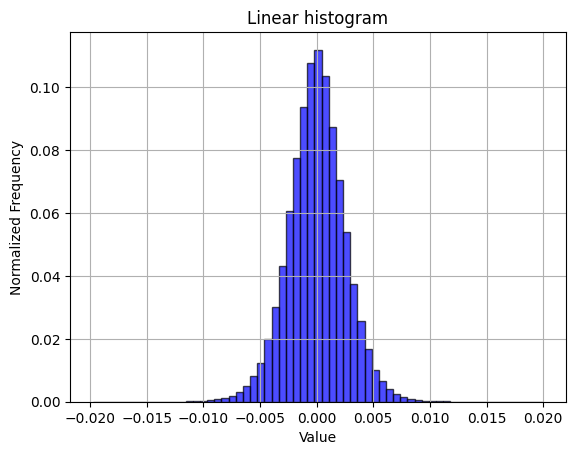

Module: MistralRotaryEmbedding
Operation: MistralRotaryEmbedding()
No weights in this module.
Module: Linear
Operation: Linear(in_features=4096, out_features=4096, bias=False)
[1.19209290e-07 0.00000000e+00 5.96046448e-08 0.00000000e+00
 5.96046448e-08 5.96046448e-08 0.00000000e+00 5.96046448e-08
 1.78813934e-07 4.17232513e-07 2.98023224e-07 1.78813934e-07
 5.36441803e-07 4.17232513e-07 9.53674316e-07 1.66893005e-06
 2.20537186e-06 3.33786011e-06 6.19888306e-06 8.70227814e-06
 1.70469284e-05 3.57627869e-05 1.02758408e-04 3.35991383e-04
 1.30236149e-03 5.11234999e-03 1.78573132e-02 5.42581677e-02
 1.24335408e-01 2.05822587e-01 2.39194810e-01 1.87524736e-01
 1.03437006e-01 4.22629714e-02 1.34823918e-02 3.55309248e-03
 9.40799713e-04 2.50279903e-04 7.93337822e-05 3.31997871e-05
 1.56164169e-05 6.97374344e-06 4.52995300e-06 1.96695328e-06
 2.08616257e-06 1.84774399e-06 6.55651093e-07 7.15255737e-07
 2.98023224e-07 4.76837158e-07 4.76837158e-07 1.19209290e-07
 5.96046448e-08 1.19209290e-07 

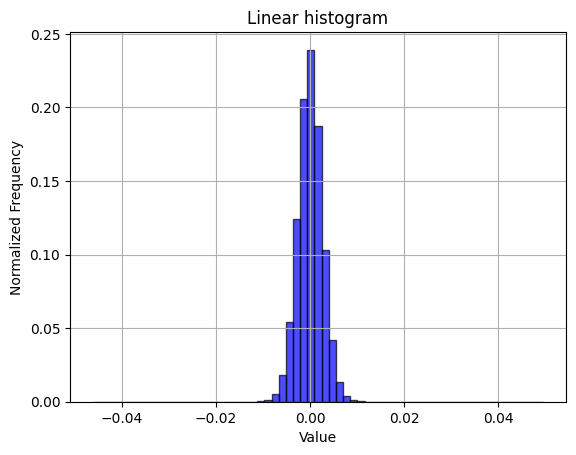

Module: MistralSdpaAttention
Operation: MistralSdpaAttention(
  (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
  (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
  (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
  (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
  (rotary_emb): MistralRotaryEmbedding()
)
No weights in this module.
Module: Linear
Operation: Linear(in_features=4096, out_features=14336, bias=False)
[3.40597970e-08 0.00000000e+00 1.70298985e-08 1.70298985e-08
 0.00000000e+00 3.40597970e-08 5.10896955e-08 1.70298985e-08
 3.40597970e-08 6.81195940e-08 1.36239188e-07 6.81195940e-08
 1.36239188e-07 1.36239188e-07 1.70298985e-07 3.06538173e-07
 5.44956752e-07 7.32285636e-07 9.19614519e-07 1.85625894e-06
 2.99726214e-06 4.90461077e-06 9.63892256e-06 2.10830144e-05
 7.44036266e-05 3.83887972e-04 2.60722637e-03 1.36395182e-02
 5.51463706e-02 1.48208141e-01 2.59237783e-01 2.67970170e-01
 1.65733865e-01 6.5734131

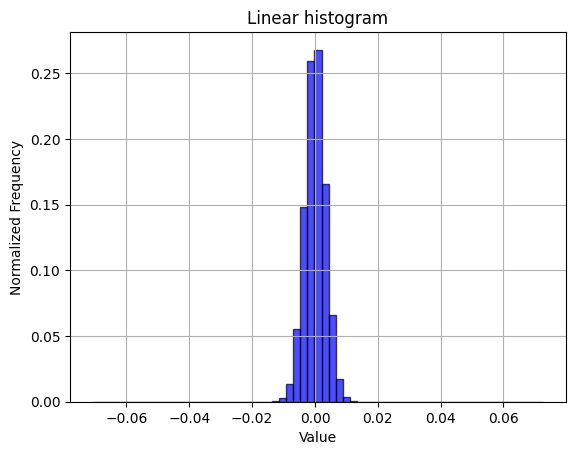

Module: SiLU
Operation: SiLU()
No weights in this module.
Module: Linear
Operation: Linear(in_features=4096, out_features=14336, bias=False)
[3.40597970e-08 0.00000000e+00 1.70298985e-08 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.70298985e-08 1.70298985e-08
 1.70298985e-08 1.70298985e-08 0.00000000e+00 1.70298985e-08
 6.81195940e-08 5.10896955e-08 6.81195940e-08 2.21388681e-07
 2.55448478e-07 4.76837158e-07 3.57627869e-07 5.44956752e-07
 9.36644418e-07 1.70298985e-06 2.94617244e-06 4.92164067e-06
 1.21423176e-05 3.90836171e-05 2.29086195e-04 1.66429792e-03
 9.71431392e-03 4.13334370e-02 1.18688788e-01 2.24448579e-01
 2.70759395e-01 2.00090391e-01 9.56235273e-02 2.95663731e-02
 6.60823073e-03 1.02080618e-03 1.40156065e-04 2.70605087e-05
 1.05244773e-05 4.10420554e-06 2.69072396e-06 1.63487026e-06
 8.51494925e-07 6.47136143e-07 3.06538173e-07 2.04358782e-07
 1.70298985e-07 1.53269087e-07 6.81195940e-08 1.70298985e-08
 5.10896955e-08 6.81195940e-08 3.40597970e-08 5.10896955e-08
 0.00

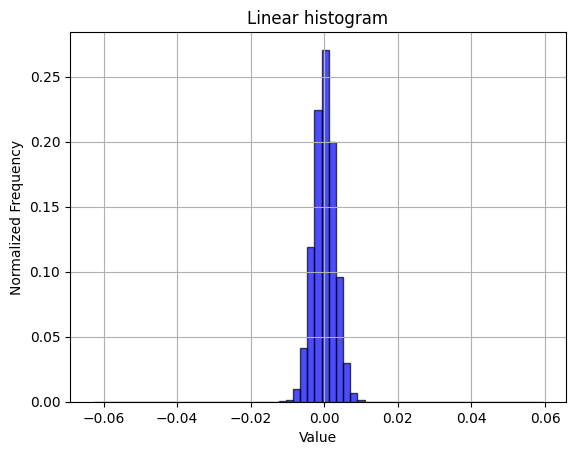

Module: Linear
Operation: Linear(in_features=14336, out_features=4096, bias=False)
[1.70298985e-08 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.70298985e-08 0.00000000e+00 0.00000000e+00 5.10896955e-08
 0.00000000e+00 3.40597970e-08 1.70298985e-08 5.10896955e-08
 0.00000000e+00 8.51494925e-08 3.40597970e-08 1.19209290e-07
 2.04358782e-07 1.53269087e-07 3.74657767e-07 8.00405230e-07
 1.44754137e-06 3.30380031e-06 1.22955867e-05 3.97852489e-04
 2.89117779e-02 3.53822844e-01 5.25171978e-01 8.94411802e-02
 2.19997338e-03 2.59195055e-05 5.29629844e-06 1.72001975e-06
 9.70704215e-07 3.23568072e-07 4.25747463e-07 2.04358782e-07
 1.02179391e-07 1.53269087e-07 6.81195940e-08 8.51494925e-08
 1.70298985e-08 1.70298985e-08 0.00000000e+00 0.00000000e+00
 3.40597970e-08 0.00000000e+00 0.00000000e+00 1.70298985e-08
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.70298985e-08 0.00000000e+00 0.00000000e+00
 0

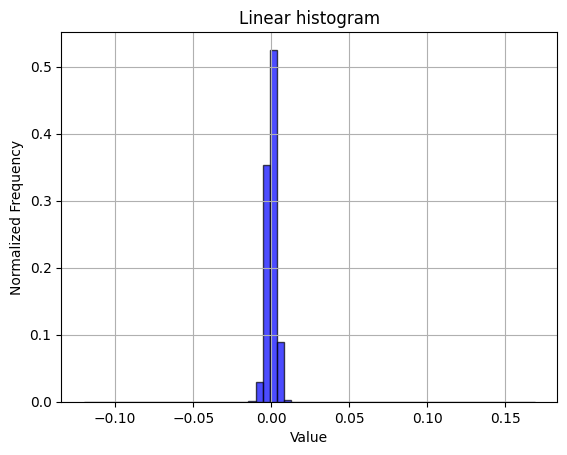

Module: MistralMLP
Operation: MistralMLP(
  (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
  (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
  (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
  (act_fn): SiLU()
)
No weights in this module.
Module: MistralDecoderLayer
Operation: MistralDecoderLayer(
  (self_attn): MistralSdpaAttention(
    (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
    (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
    (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
    (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
    (rotary_emb): MistralRotaryEmbedding()
  )
  (mlp): MistralMLP(
    (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
    (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
    (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
    (act_fn): SiLU()
  )
  (inp

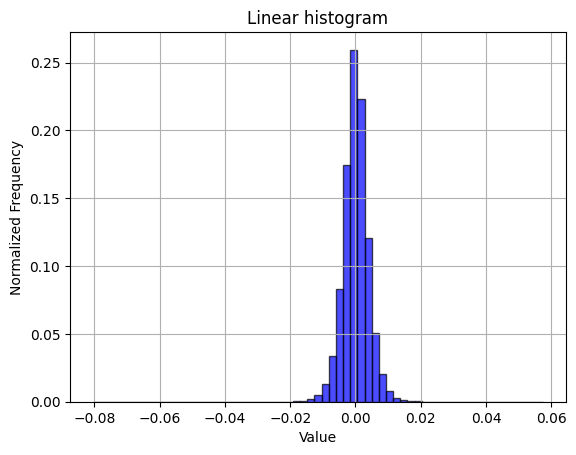

Module: Linear
Operation: Linear(in_features=4096, out_features=1024, bias=False)
[2.38418579e-07 4.76837158e-07 1.19209290e-06 2.38418579e-07
 7.15255737e-07 7.15255737e-07 1.43051147e-06 1.90734863e-06
 2.62260437e-06 5.96046448e-06 7.86781311e-06 1.00135803e-05
 2.12192535e-05 2.93254852e-05 4.00543213e-05 7.48634338e-05
 1.29222870e-04 2.23159790e-04 4.73499298e-04 8.72135162e-04
 1.64222717e-03 3.28540802e-03 6.25967979e-03 1.15039349e-02
 1.97772980e-02 3.64332199e-02 6.26566410e-02 1.08328104e-01
 1.66338921e-01 1.94734573e-01 1.57418489e-01 9.95388031e-02
 5.70213795e-02 3.25980186e-02 1.85525417e-02 1.00862980e-02
 5.71703911e-03 3.03649902e-03 1.47414207e-03 7.84397125e-04
 4.17709351e-04 2.13146210e-04 1.14440918e-04 6.03199005e-05
 4.26769257e-05 2.14576721e-05 1.74045563e-05 9.29832458e-06
 4.76837158e-06 4.52995300e-06 4.29153442e-06 1.43051147e-06
 1.19209290e-06 1.66893005e-06 4.76837158e-07 2.38418579e-07
 0.00000000e+00 0.00000000e+00 2.38418579e-07 0.00000000e+00
 0.

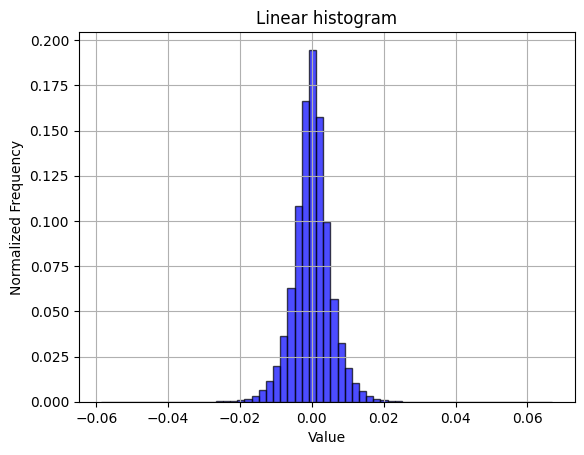

Module: Linear
Operation: Linear(in_features=4096, out_features=1024, bias=False)
[4.76837158e-07 4.76837158e-07 2.38418579e-07 2.38418579e-07
 2.14576721e-06 1.66893005e-06 5.24520874e-06 9.77516174e-06
 1.81198120e-05 3.33786011e-05 4.98294830e-05 9.08374786e-05
 1.65700912e-04 2.95639038e-04 4.74452972e-04 7.53164291e-04
 1.20186806e-03 1.86848640e-03 2.80642509e-03 4.19592857e-03
 6.13427162e-03 8.69989395e-03 1.20828152e-02 1.68900490e-02
 2.20885277e-02 2.87768841e-02 3.62699032e-02 4.47664261e-02
 5.43687344e-02 6.28397465e-02 7.14623928e-02 7.75504112e-02
 8.10706615e-02 7.81321526e-02 7.17537403e-02 6.40265942e-02
 5.53669930e-02 4.58459854e-02 3.76842022e-02 2.98027992e-02
 2.32355595e-02 1.72793865e-02 1.29253864e-02 9.33504105e-03
 6.57367706e-03 4.55355644e-03 3.07202339e-03 1.98864937e-03
 1.31154060e-03 8.50677490e-04 5.22613525e-04 3.22341919e-04
 1.87635422e-04 1.11818314e-04 6.07967377e-05 3.50475311e-05
 2.24113464e-05 1.28746033e-05 5.72204590e-06 2.86102295e-06
 2.

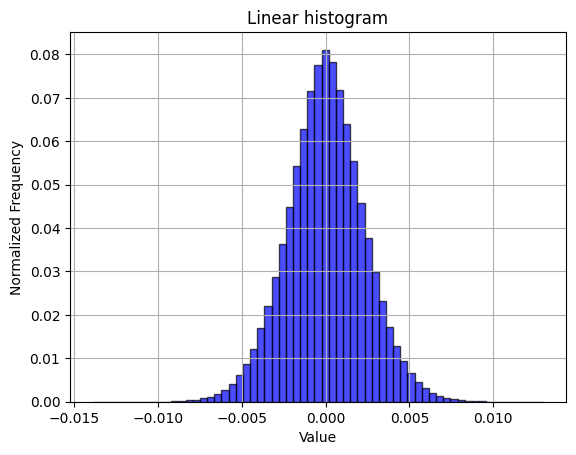

Module: MistralRotaryEmbedding
Operation: MistralRotaryEmbedding()
No weights in this module.
Module: Linear
Operation: Linear(in_features=4096, out_features=4096, bias=False)
[1.19209290e-07 5.96046448e-08 5.96046448e-08 0.00000000e+00
 0.00000000e+00 0.00000000e+00 5.96046448e-08 5.96046448e-08
 1.19209290e-07 0.00000000e+00 0.00000000e+00 5.96046448e-08
 0.00000000e+00 5.96046448e-08 1.19209290e-07 1.78813934e-07
 3.57627869e-07 7.15255737e-07 5.36441803e-07 8.34465027e-07
 1.60932541e-06 2.80141830e-06 6.31809235e-06 1.25765800e-05
 3.57031822e-05 1.27613544e-04 5.45084476e-04 2.43449211e-03
 1.02485418e-02 3.56730223e-02 9.58972573e-02 1.88401461e-01
 2.56497860e-01 2.17313230e-01 1.22874141e-01 4.95746732e-02
 1.53900385e-02 3.81511450e-03 8.65459442e-04 1.92165375e-04
 5.22732735e-05 1.93715096e-05 6.49690628e-06 3.75509262e-06
 1.78813934e-06 8.94069672e-07 5.36441803e-07 8.34465027e-07
 5.36441803e-07 1.78813934e-07 1.19209290e-07 2.38418579e-07
 0.00000000e+00 5.96046448e-08 

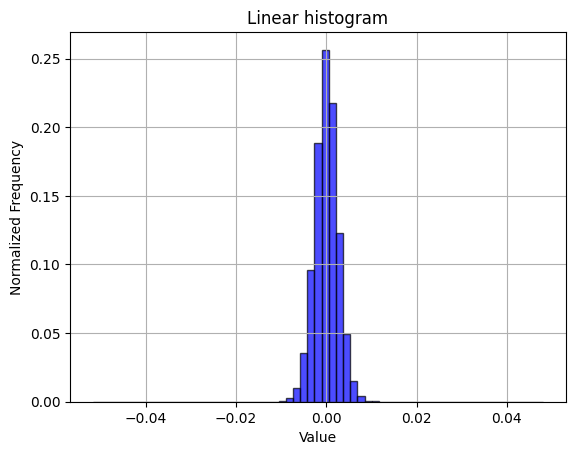

Module: MistralSdpaAttention
Operation: MistralSdpaAttention(
  (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
  (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
  (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
  (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
  (rotary_emb): MistralRotaryEmbedding()
)
No weights in this module.
Module: Linear
Operation: Linear(in_features=4096, out_features=14336, bias=False)
[1.70298985e-08 3.40597970e-08 1.70298985e-08 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40597970e-08
 5.10896955e-08 1.70298985e-08 6.81195940e-08 5.10896955e-08
 6.81195940e-08 3.40597970e-08 1.53269087e-07 6.81195940e-08
 2.55448478e-07 2.04358782e-07 3.74657767e-07 5.61986651e-07
 6.64166042e-07 1.29427229e-06 1.87328884e-06 2.52042498e-06
 4.58104270e-06 8.31059047e-06 1.89542770e-05 5.72204590e-05
 2.74198396e-04 1.80389200e-03 1.08269623e-02 4.86327239e-02
 1.42654146e-01 2.6136158

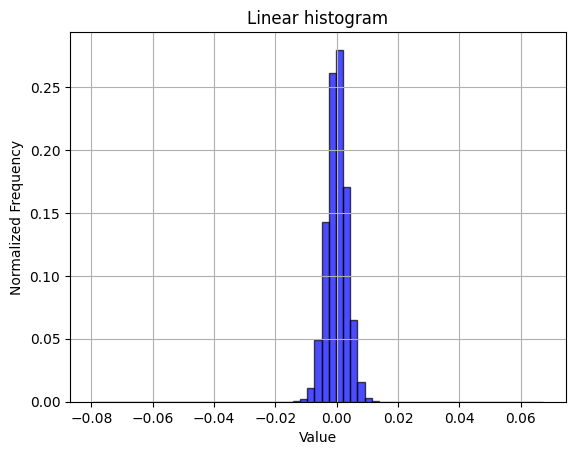

Module: SiLU
Operation: SiLU()
No weights in this module.
Module: Linear
Operation: Linear(in_features=4096, out_features=14336, bias=False)
[3.40597970e-08 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.70298985e-08 0.00000000e+00 1.70298985e-08
 1.70298985e-08 1.70298985e-08 1.70298985e-08 1.70298985e-08
 5.10896955e-08 5.10896955e-08 8.51494925e-08 1.36239188e-07
 8.51494925e-08 5.10896955e-08 1.36239188e-07 2.89508275e-07
 3.57627869e-07 6.98225839e-07 7.49315534e-07 1.41348158e-06
 3.04835183e-06 6.09670367e-06 1.60591943e-05 7.39608492e-05
 6.96471759e-04 5.99127156e-03 3.44870942e-02 1.23519591e-01
 2.56876980e-01 3.00553373e-01 1.90491012e-01 6.98362929e-02
 1.51135240e-02 2.05235822e-03 2.31538500e-04 2.90359770e-05
 8.68524824e-06 3.49112919e-06 2.16279711e-06 1.34536198e-06
 7.32285636e-07 4.59807260e-07 3.57627869e-07 1.53269087e-07
 1.87328884e-07 1.02179391e-07 1.53269087e-07 3.40597970e-08
 6.81195940e-08 3.40597970e-08 3.40597970e-08 0.00000000e+00
 1.70

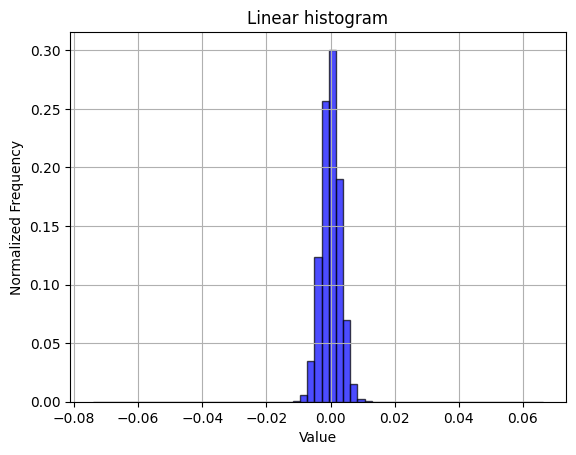

Module: Linear
Operation: Linear(in_features=14336, out_features=4096, bias=False)
[5.10896955e-08 1.70298985e-08 8.51494925e-08 3.40597970e-08
 3.40597970e-08 6.81195940e-08 6.81195940e-08 1.53269087e-07
 3.23568072e-07 6.64166042e-07 6.13076346e-07 1.73704965e-06
 3.81469727e-06 1.67574201e-05 6.41005380e-04 2.28562696e-02
 2.29720678e-01 5.11695283e-01 2.14166709e-01 2.03475612e-02
 5.24674143e-04 1.48841313e-05 3.96796635e-06 1.78813934e-06
 1.02179391e-06 5.61986651e-07 2.89508275e-07 2.04358782e-07
 1.70298985e-07 1.36239188e-07 1.02179391e-07 6.81195940e-08
 3.40597970e-08 1.70298985e-08 3.40597970e-08 1.70298985e-08
 3.40597970e-08 0.00000000e+00 0.00000000e+00 1.70298985e-08
 0.00000000e+00 0.00000000e+00 1.70298985e-08 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.70298985e-08
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0

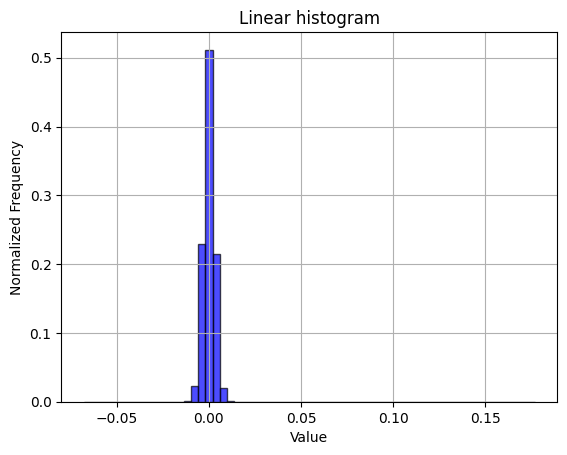

Module: MistralMLP
Operation: MistralMLP(
  (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
  (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
  (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
  (act_fn): SiLU()
)
No weights in this module.
Module: MistralDecoderLayer
Operation: MistralDecoderLayer(
  (self_attn): MistralSdpaAttention(
    (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
    (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
    (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
    (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
    (rotary_emb): MistralRotaryEmbedding()
  )
  (mlp): MistralMLP(
    (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
    (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
    (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
    (act_fn): SiLU()
  )
  (inp

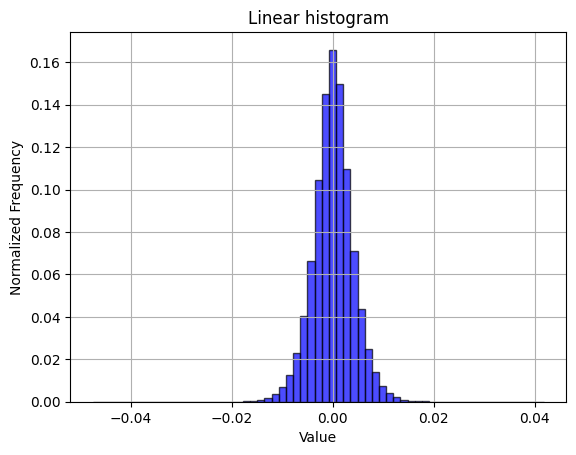

Module: Linear
Operation: Linear(in_features=4096, out_features=1024, bias=False)
[2.38418579e-07 0.00000000e+00 7.15255737e-07 4.76837158e-07
 1.66893005e-06 7.15255737e-07 3.09944153e-06 4.05311584e-06
 2.62260437e-06 6.43730164e-06 6.67572021e-06 8.10623169e-06
 1.47819519e-05 2.59876251e-05 4.31537628e-05 7.48634338e-05
 1.39474869e-04 2.14338303e-04 3.80992889e-04 7.12871552e-04
 1.15728378e-03 1.93691254e-03 3.37123871e-03 5.67746162e-03
 9.57894325e-03 1.47738457e-02 2.42762566e-02 3.63743305e-02
 5.55706024e-02 8.31332207e-02 1.15331888e-01 1.43454075e-01
 1.44450903e-01 1.17410421e-01 8.39149952e-02 5.66477776e-02
 3.78739834e-02 2.37996578e-02 1.57747269e-02 9.70578194e-03
 5.68103790e-03 3.46612930e-03 2.03061104e-03 1.28221512e-03
 7.01427460e-04 3.74794006e-04 2.54154205e-04 1.32083893e-04
 8.63075256e-05 5.48362732e-05 2.90870667e-05 2.00271606e-05
 1.02519989e-05 6.19888306e-06 3.57627869e-06 3.57627869e-06
 4.29153442e-06 1.19209290e-06 1.43051147e-06 0.00000000e+00
 0.

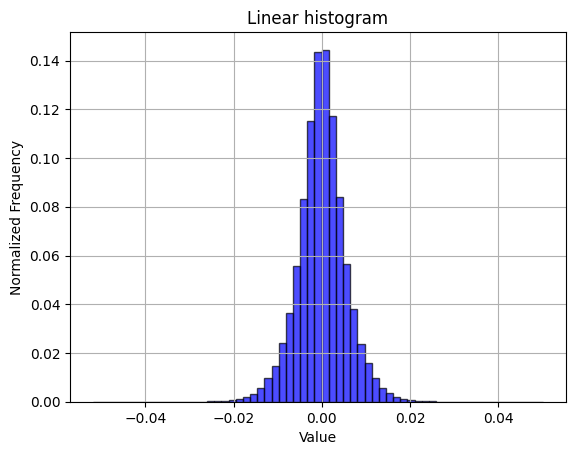

Module: Linear
Operation: Linear(in_features=4096, out_features=1024, bias=False)
[2.38418579e-07 0.00000000e+00 2.38418579e-07 0.00000000e+00
 7.15255737e-07 1.19209290e-06 2.38418579e-06 5.48362732e-06
 8.82148743e-06 2.28881836e-05 3.48091125e-05 6.62803650e-05
 1.32322311e-04 2.75373459e-04 3.98874283e-04 9.00030136e-04
 1.53541565e-03 2.79664993e-03 5.41281700e-03 9.23132896e-03
 1.55615807e-02 2.62365341e-02 4.05743122e-02 5.73806763e-02
 8.01925659e-02 9.87644196e-02 1.14413261e-01 1.20893955e-01
 1.11366510e-01 9.41841602e-02 7.41000175e-02 5.39948940e-02
 3.58526707e-02 2.36322880e-02 1.38030052e-02 8.04471970e-03
 4.73356247e-03 2.46810913e-03 1.37066841e-03 7.68899918e-04
 3.88860703e-04 2.01940536e-04 1.15871429e-04 6.43730164e-05
 3.14712524e-05 1.69277191e-05 8.34465027e-06 4.29153442e-06
 2.14576721e-06 1.66893005e-06 7.15255737e-07 2.38418579e-07
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.38418579e-07
 0.

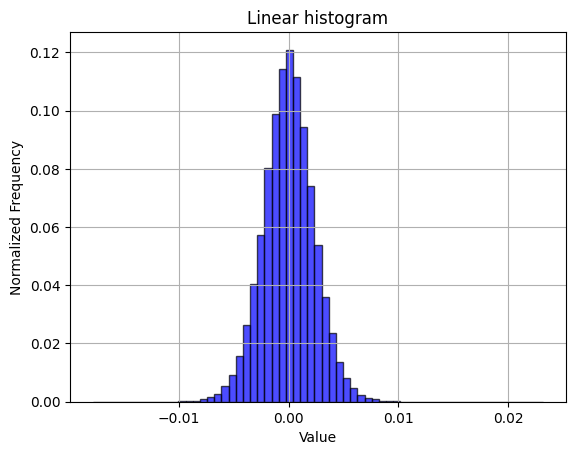

Module: MistralRotaryEmbedding
Operation: MistralRotaryEmbedding()
No weights in this module.
Module: Linear
Operation: Linear(in_features=4096, out_features=4096, bias=False)
[5.96046448e-08 5.96046448e-08 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 5.96046448e-08 5.96046448e-08
 1.19209290e-07 5.96046448e-08 1.78813934e-07 0.00000000e+00
 0.00000000e+00 0.00000000e+00 4.17232513e-07 3.57627869e-07
 8.34465027e-07 3.57627869e-07 1.31130219e-06 1.84774399e-06
 2.62260437e-06 3.75509262e-06 6.19888306e-06 1.07884407e-05
 2.62260437e-05 7.72476196e-05 3.49283218e-04 1.95103884e-03
 1.05524063e-02 4.27756310e-02 1.25815272e-01 2.44139433e-01
 2.81369805e-01 1.86901569e-01 7.75241256e-02 2.26755142e-02
 4.74280119e-03 8.31425190e-04 1.57773495e-04 4.08887863e-05
 1.54972076e-05 8.34465027e-06 5.54323196e-06 3.51667404e-06
 2.20537186e-06 1.25169754e-06 1.60932541e-06 5.36441803e-07
 4.76837158e-07 4.17232513e-07 2.38418579e-07 2.38418579e-07
 2.98023224e-07 0.00000000e+00 

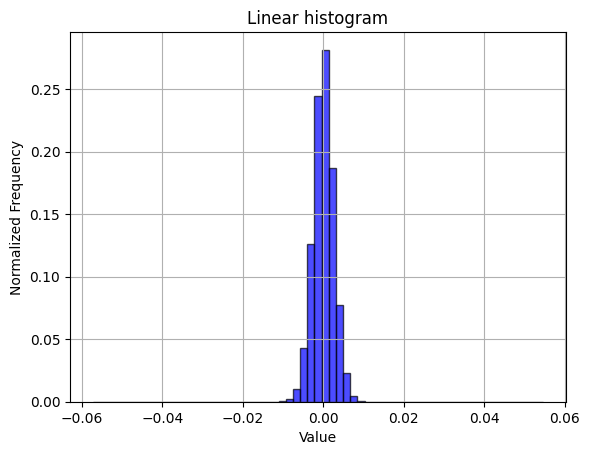

Module: MistralSdpaAttention
Operation: MistralSdpaAttention(
  (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
  (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
  (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
  (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
  (rotary_emb): MistralRotaryEmbedding()
)
No weights in this module.
Module: Linear
Operation: Linear(in_features=4096, out_features=14336, bias=False)
[1.70298985e-08 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40597970e-08
 0.00000000e+00 1.70298985e-08 0.00000000e+00 0.00000000e+00
 3.40597970e-08 3.40597970e-08 3.40597970e-08 6.81195940e-08
 1.87328884e-07 5.10896955e-08 2.72478376e-07 3.74657767e-07
 6.30106245e-07 9.36644418e-07 1.89031873e-06 2.87805285e-06
 5.89234488e-06 1.10353742e-05 3.01769802e-05 1.41297068e-04
 1.20009695e-03 1.1388812

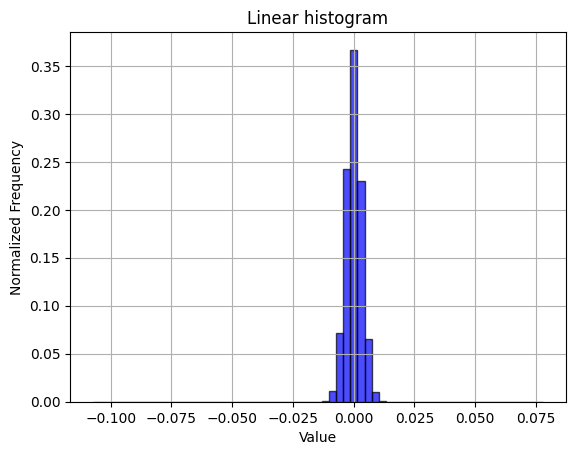

Module: SiLU
Operation: SiLU()
No weights in this module.
Module: Linear
Operation: Linear(in_features=4096, out_features=14336, bias=False)
[1.70298985e-08 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.70298985e-08 0.00000000e+00
 0.00000000e+00 1.70298985e-08 3.40597970e-08 0.00000000e+00
 1.70298985e-08 3.40597970e-08 5.10896955e-08 8.51494925e-08
 3.40597970e-08 1.02179391e-07 8.51494925e-08 1.87328884e-07
 3.74657767e-07 4.25747463e-07 7.32285636e-07 1.24318259e-06
 2.29903630e-06 3.54221889e-06 7.40800585e-06 1.91416059e-05
 8.01597323e-05 5.69258417e-04 4.38909871e-03 2.37555504e-02
 8.77258437e-02 2.06784504e-01 2.89956927e-01 2.33103292e-01
 1.12495661e-01 3.33147049e-02 6.63489955e-03 9.85486167e-04
 1.24812126e-04 2.34501702e-05 9.79219164e-06 4.54698290e-06
 2.38418579e-06 1.44754137e-06 9.19614519e-07 4.59807260e-07
 2.89508275e-07 1.70298985e-07 1.19209290e-07 1.19209290e-07
 8.51494925e-08 3.40597970e-08 5.10896955e-08 0.00000000e+00
 3.40

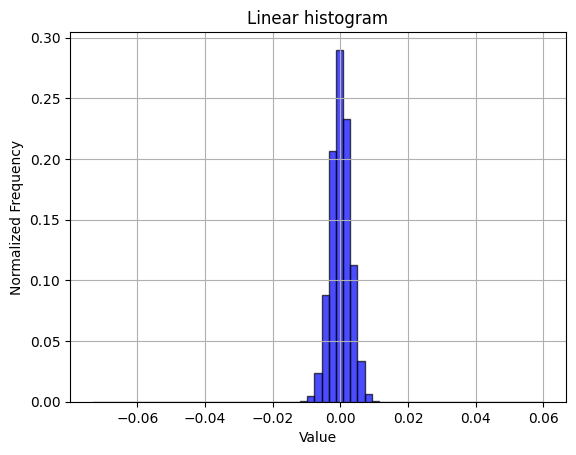

Module: Linear
Operation: Linear(in_features=14336, out_features=4096, bias=False)
[1.70298985e-08 0.00000000e+00 0.00000000e+00 1.70298985e-08
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40597970e-08
 5.10896955e-08 3.40597970e-08 5.10896955e-08 6.81195940e-08
 1.53269087e-07 3.06538173e-07 4.25747463e-07 6.81195940e-07
 1.70298985e-06 3.57627869e-06 1.05755670e-05 1.06385776e-04
 9.89847524e-03 2.19519138e-01 6.01379275e-01 1.63329193e-01
 5.66681794e-03 6.80174146e-05 9.09396580e-06 3.26974051e-06
 1.15803310e-06 5.61986651e-07 3.57627869e-07 1.70298985e-07
 6.81195940e-08 3.40597970e-08 1.70298985e-08 5.10896955e-08
 1.70298985e-08 3.40597970e-08 5.10896955e-08 1.70298985e-08
 1.70298985e-08 5.10896955e-08 0.00000000e+00 1.70298985e-08
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0

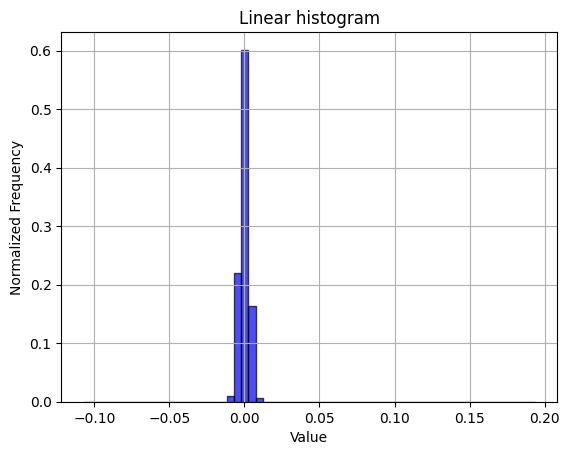

Module: MistralMLP
Operation: MistralMLP(
  (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
  (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
  (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
  (act_fn): SiLU()
)
No weights in this module.
Module: MistralDecoderLayer
Operation: MistralDecoderLayer(
  (self_attn): MistralSdpaAttention(
    (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
    (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
    (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
    (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
    (rotary_emb): MistralRotaryEmbedding()
  )
  (mlp): MistralMLP(
    (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
    (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
    (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
    (act_fn): SiLU()
  )
  (inp

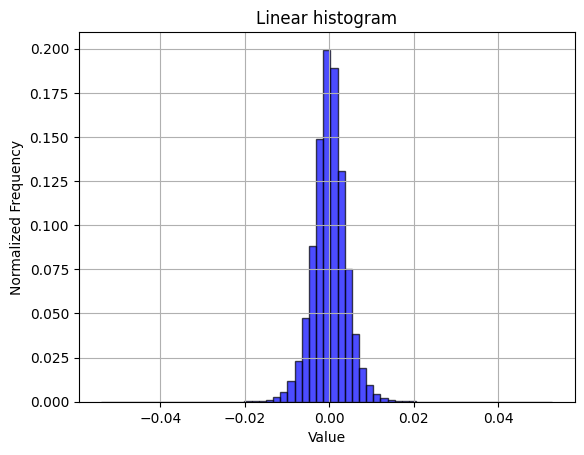

Module: Linear
Operation: Linear(in_features=4096, out_features=1024, bias=False)
[2.38418579e-07 4.76837158e-07 0.00000000e+00 0.00000000e+00
 1.19209290e-06 9.53674316e-07 9.53674316e-07 2.14576721e-06
 1.43051147e-06 3.33786011e-06 2.14576721e-06 4.52995300e-06
 4.05311584e-06 1.12056732e-05 2.14576721e-05 3.43322754e-05
 5.24520874e-05 8.82148743e-05 1.67846680e-04 3.04937363e-04
 5.60998917e-04 1.14846230e-03 2.14219093e-03 4.32014465e-03
 8.99815559e-03 1.79910660e-02 3.54123116e-02 6.86457157e-02
 1.24013186e-01 1.93664074e-01 2.09520817e-01 1.52182341e-01
 8.78477097e-02 4.64203358e-02 2.29091644e-02 1.18691921e-02
 5.78856468e-03 2.79879570e-03 1.50012970e-03 7.11917877e-04
 3.59296799e-04 2.10523605e-04 1.12295151e-04 6.22272491e-05
 3.48091125e-05 2.62260437e-05 1.45435333e-05 1.04904175e-05
 8.10623169e-06 2.62260437e-06 2.38418579e-06 3.33786011e-06
 9.53674316e-07 1.90734863e-06 4.76837158e-07 7.15255737e-07
 9.53674316e-07 2.38418579e-07 2.38418579e-07 0.00000000e+00
 2.

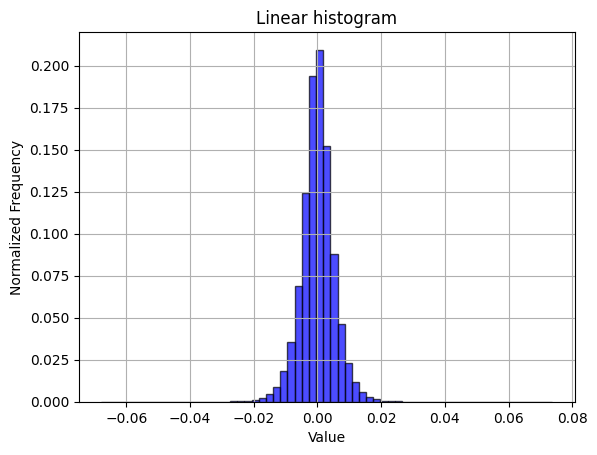

Module: Linear
Operation: Linear(in_features=4096, out_features=1024, bias=False)
[2.38418579e-07 0.00000000e+00 0.00000000e+00 7.15255737e-07
 2.38418579e-07 0.00000000e+00 4.76837158e-07 9.53674316e-07
 1.19209290e-06 7.15255737e-07 1.90734863e-06 2.14576721e-06
 1.43051147e-06 4.05311584e-06 3.81469727e-06 6.67572021e-06
 2.14576721e-05 4.31537628e-05 1.07049942e-04 2.22682953e-04
 5.25236130e-04 1.18541718e-03 2.53248215e-03 5.27691841e-03
 1.03747845e-02 2.02429295e-02 3.54454517e-02 5.81262112e-02
 8.83276463e-02 1.20637178e-01 1.44862413e-01 1.48014784e-01
 1.24188900e-01 9.38055515e-02 6.30478859e-02 3.82637978e-02
 2.17294693e-02 1.19748116e-02 5.77640533e-03 2.86340714e-03
 1.32012367e-03 5.88417053e-04 2.59637833e-04 1.09672546e-04
 5.38825989e-05 1.95503235e-05 9.05990601e-06 6.19888306e-06
 3.09944153e-06 2.14576721e-06 2.38418579e-06 7.15255737e-07
 9.53674316e-07 9.53674316e-07 9.53674316e-07 2.38418579e-07
 0.00000000e+00 0.00000000e+00 2.38418579e-07 0.00000000e+00
 4.

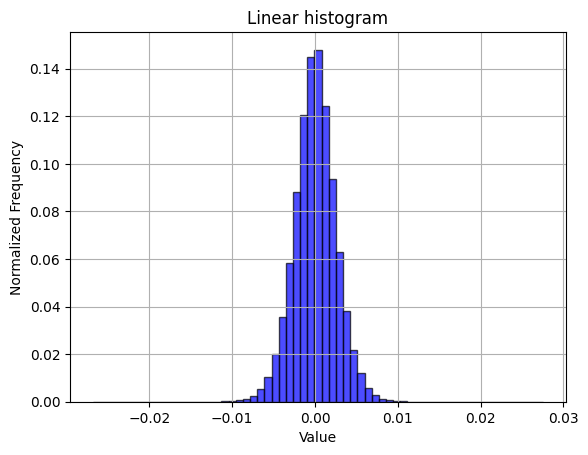

Module: MistralRotaryEmbedding
Operation: MistralRotaryEmbedding()
No weights in this module.
Module: Linear
Operation: Linear(in_features=4096, out_features=4096, bias=False)
[1.19209290e-07 5.96046448e-08 0.00000000e+00 5.96046448e-08
 5.96046448e-08 0.00000000e+00 2.38418579e-07 1.19209290e-07
 1.78813934e-07 5.96046448e-07 3.57627869e-07 5.36441803e-07
 7.15255737e-07 1.01327896e-06 1.72853470e-06 2.44379044e-06
 3.09944153e-06 5.00679016e-06 6.13927841e-06 1.15036964e-05
 1.91330910e-05 4.83393669e-05 1.51634216e-04 6.48856163e-04
 3.18437815e-03 1.51282549e-02 5.73422313e-02 1.59601808e-01
 2.82771766e-01 2.71834850e-01 1.43501401e-01 4.98992205e-02
 1.24111772e-02 2.67601013e-03 5.28693199e-04 1.31011009e-04
 3.96370888e-05 1.82390213e-05 9.65595245e-06 5.18560410e-06
 4.11272049e-06 2.74181366e-06 2.20537186e-06 1.72853470e-06
 5.96046448e-07 8.94069672e-07 7.15255737e-07 2.98023224e-07
 1.19209290e-07 2.98023224e-07 1.78813934e-07 1.78813934e-07
 1.78813934e-07 5.96046448e-08 

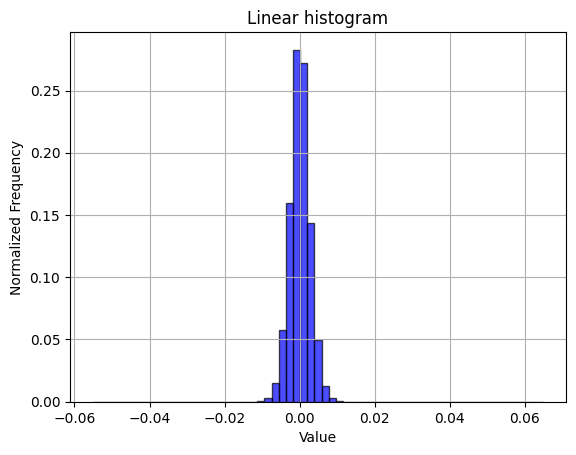

Module: MistralSdpaAttention
Operation: MistralSdpaAttention(
  (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
  (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
  (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
  (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
  (rotary_emb): MistralRotaryEmbedding()
)
No weights in this module.
Module: Linear
Operation: Linear(in_features=4096, out_features=14336, bias=False)
[1.70298985e-08 0.00000000e+00 1.70298985e-08 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40597970e-08
 1.70298985e-08 3.40597970e-08 1.70298985e-08 5.10896955e-08
 5.10896955e-08 6.81195940e-08 6.81195940e-08 3.40597970e-08
 1.19209290e-07 3.06538173e-07 2.72478376e-07 5.44956752e-07
 9.02584621e-07 1.07288361e-06 1.97546823e-06 3.83172716e-06
 6.84601920e-06 1.56334468e-05 4.54527991e-05 2.92522567e-04
 3.54191235e-03 3.5970347

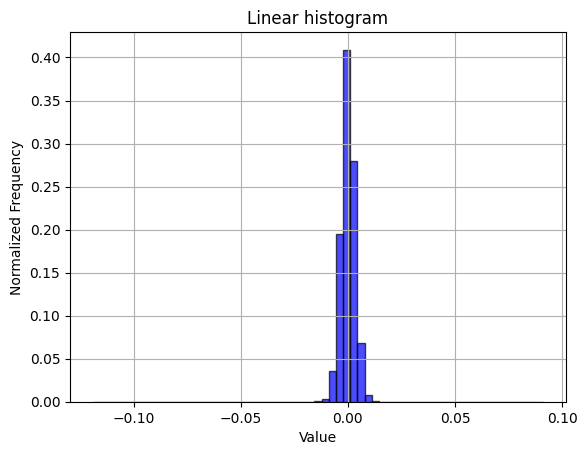

Module: SiLU
Operation: SiLU()
No weights in this module.
Module: Linear
Operation: Linear(in_features=4096, out_features=14336, bias=False)
[1.70298985e-08 3.40597970e-08 5.10896955e-08 8.51494925e-08
 5.10896955e-08 1.53269087e-07 3.23568072e-07 3.57627869e-07
 5.27926854e-07 8.51494925e-07 1.65190016e-06 3.08241163e-06
 6.19888306e-06 1.72853470e-05 1.36085919e-04 2.28011608e-03
 2.79351303e-02 1.60350510e-01 3.78790293e-01 3.17749092e-01
 9.87759658e-02 1.29647425e-02 9.08970833e-04 5.64370837e-05
 1.20231083e-05 4.59807260e-06 2.24794660e-06 1.17506300e-06
 8.00405230e-07 4.08717564e-07 2.04358782e-07 2.55448478e-07
 6.81195940e-08 5.10896955e-08 5.10896955e-08 5.10896955e-08
 0.00000000e+00 1.70298985e-08 0.00000000e+00 1.70298985e-08
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

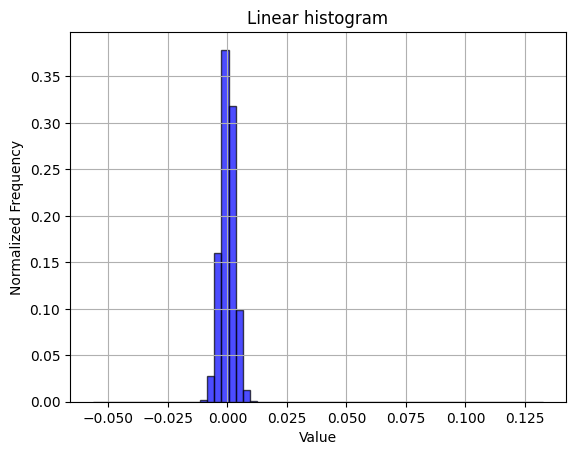

Module: Linear
Operation: Linear(in_features=14336, out_features=4096, bias=False)
[3.40597970e-08 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 5.10896955e-08 0.00000000e+00 0.00000000e+00
 0.00000000e+00 3.40597970e-08 0.00000000e+00 5.10896955e-08
 0.00000000e+00 1.70298985e-08 1.70298985e-08 6.81195940e-08
 3.40597970e-08 1.70298985e-08 6.81195940e-08 1.19209290e-07
 1.36239188e-07 2.21388681e-07 3.23568072e-07 5.96046448e-07
 1.05585371e-06 2.16279711e-06 4.42777361e-06 1.05244773e-05
 7.25303377e-05 2.95051507e-03 6.84797934e-02 3.99356076e-01
 4.37225614e-01 8.73701062e-02 4.40178599e-03 1.02315630e-04
 1.15462712e-05 4.58104270e-06 2.40121569e-06 9.87734113e-07
 6.13076346e-07 2.04358782e-07 3.57627869e-07 1.53269087e-07
 1.19209290e-07 1.53269087e-07 5.10896955e-08 1.70298985e-08
 1.70298985e-08 1.70298985e-08 1.70298985e-08 3.40597970e-08
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.70298985e-08 0.00000000e+00
 0

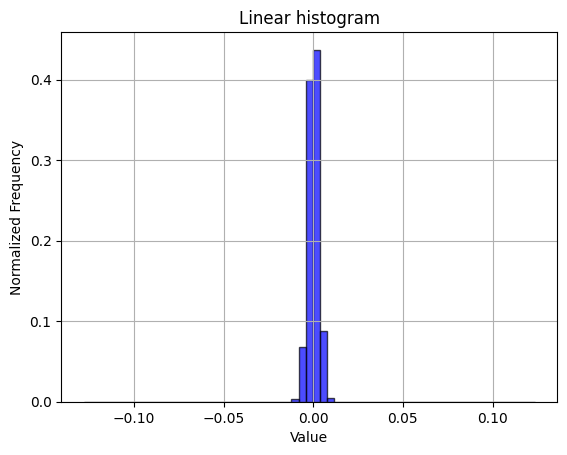

Module: MistralMLP
Operation: MistralMLP(
  (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
  (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
  (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
  (act_fn): SiLU()
)
No weights in this module.
Module: MistralDecoderLayer
Operation: MistralDecoderLayer(
  (self_attn): MistralSdpaAttention(
    (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
    (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
    (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
    (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
    (rotary_emb): MistralRotaryEmbedding()
  )
  (mlp): MistralMLP(
    (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
    (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
    (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
    (act_fn): SiLU()
  )
  (inp

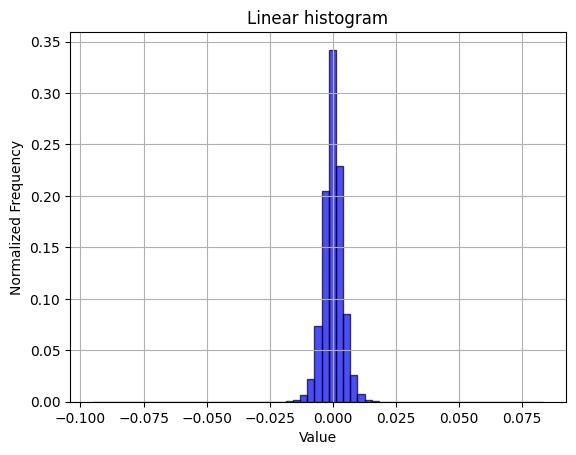

Module: Linear
Operation: Linear(in_features=4096, out_features=1024, bias=False)
[2.38418579e-07 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 4.76837158e-07 2.38418579e-07
 4.76837158e-07 1.66893005e-06 4.76837158e-07 1.19209290e-06
 4.76837158e-07 1.90734863e-06 4.52995300e-06 6.43730164e-06
 8.34465027e-06 1.38282776e-05 2.09808350e-05 2.55107880e-05
 3.74317169e-05 7.03334808e-05 1.03712082e-04 1.74045563e-04
 3.41892242e-04 6.84738159e-04 1.36709213e-03 3.17859650e-03
 6.48093224e-03 1.38432980e-02 2.82018185e-02 5.43246269e-02
 1.07265711e-01 2.00487375e-01 2.47949600e-01 1.64631367e-01
 8.47086906e-02 4.35357094e-02 2.20608711e-02 1.05471611e-02
 5.25927544e-03 2.33054161e-03 1.13296509e-03 5.25474548e-04
 2.86579132e-04 1.45196915e-04 8.55922699e-05 5.07831573e-05
 3.55243683e-05 2.05039978e-05 1.43051147e-05 9.77516174e-06
 5.96046448e-06 4.52995300e-06 3.57627869e-06 1.90734863e-06
 1.90734863e-06 7.15255737e-07 1.19209290e-06 7.15255737e-07
 4.

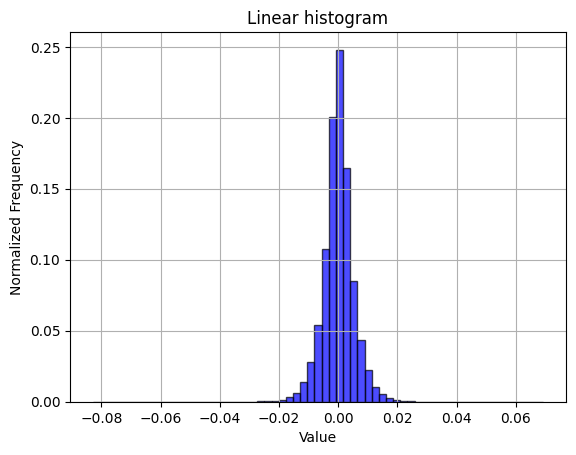

Module: Linear
Operation: Linear(in_features=4096, out_features=1024, bias=False)
[2.38418579e-07 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 2.38418579e-07 4.76837158e-07 0.00000000e+00
 0.00000000e+00 2.38418579e-07 7.15255737e-07 9.53674316e-07
 1.90734863e-06 5.48362732e-06 1.33514404e-05 2.90870667e-05
 7.98702240e-05 2.08377838e-04 4.96864319e-04 1.20472908e-03
 2.87842751e-03 6.34932518e-03 1.34270191e-02 2.50909328e-02
 4.59935665e-02 7.30297565e-02 1.07786417e-01 1.38790846e-01
 1.56283379e-01 1.40852690e-01 1.10684156e-01 7.57007599e-02
 4.81691360e-02 2.69768238e-02 1.40614510e-02 6.47497177e-03
 3.13520432e-03 1.35970116e-03 5.44548035e-04 2.13384628e-04
 9.15527344e-05 3.79085541e-05 1.47819519e-05 5.48362732e-06
 2.62260437e-06 2.38418579e-07 2.38418579e-07 7.15255737e-07
 2.38418579e-07 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 2.38418579e-07 0.00000000e+00 0.00000000e+00
 0.00000000e+00 2.38418579e-07 0.00000000e+00 0.00000000e+00
 2.

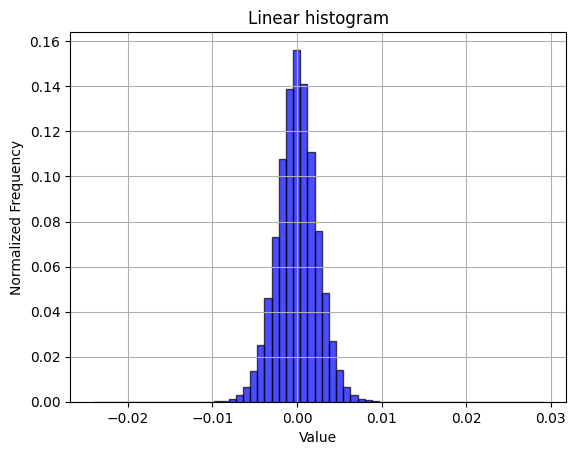

Module: MistralRotaryEmbedding
Operation: MistralRotaryEmbedding()
No weights in this module.
Module: Linear
Operation: Linear(in_features=4096, out_features=4096, bias=False)
[5.96046448e-08 0.00000000e+00 5.96046448e-08 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.19209290e-07
 1.19209290e-07 0.00000000e+00 5.96046448e-08 1.19209290e-07
 5.96046448e-08 4.17232513e-07 1.78813934e-07 1.19209290e-07
 1.19209290e-07 1.19209290e-07 2.98023224e-07 2.98023224e-07
 2.38418579e-07 8.94069672e-07 7.74860382e-07 7.74860382e-07
 1.78813934e-06 2.74181366e-06 5.18560410e-06 7.80820847e-06
 1.60336494e-05 5.21540642e-05 2.07543373e-04 1.15662813e-03
 6.06411695e-03 2.77587175e-02 9.46757197e-02 2.21849680e-01
 3.03333223e-01 2.18700111e-01 9.25956964e-02 2.64483690e-02
 5.74606657e-03 1.07330084e-03 2.09152699e-04 5.13792038e-05
 1.71065331e-05 8.52346420e-06 4.94718552e-06 2.98023224e-06
 2.02655792e-06 9.53674316e-07 7.15255737e-07 5.96046448e-07
 4.17232513e-07 2.38418579e-07 

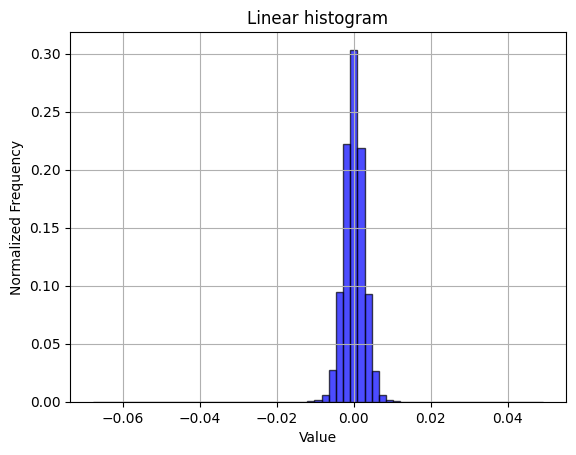

Module: MistralSdpaAttention
Operation: MistralSdpaAttention(
  (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
  (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
  (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
  (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
  (rotary_emb): MistralRotaryEmbedding()
)
No weights in this module.
Module: Linear
Operation: Linear(in_features=4096, out_features=14336, bias=False)
[5.10896955e-08 1.70298985e-08 5.10896955e-08 1.70298985e-08
 1.70298985e-08 3.40597970e-08 5.10896955e-08 8.51494925e-08
 1.70298985e-08 1.70298985e-07 2.04358782e-07 4.76837158e-07
 7.66345433e-07 1.31130219e-06 2.19685691e-06 3.96796635e-06
 7.90187291e-06 2.15768814e-05 7.68048423e-05 6.26887594e-04
 9.26964624e-03 8.86879478e-02 3.38536399e-01 4.01330199e-01
 1.41277432e-01 1.86749186e-02 1.30794730e-03 1.24522618e-04
 2.78609140e-05 9.77516174e-06 4.66619219e-06 2.38418579e-06
 1.12397330e-06 7.4931553

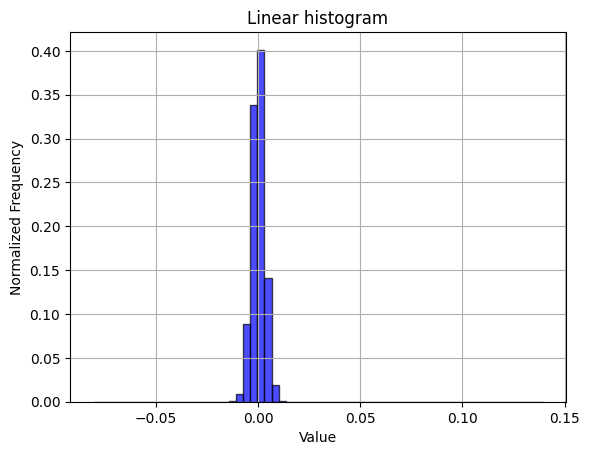

Module: SiLU
Operation: SiLU()
No weights in this module.
Module: Linear
Operation: Linear(in_features=4096, out_features=14336, bias=False)
[1.70298985e-08 0.00000000e+00 1.70298985e-08 0.00000000e+00
 0.00000000e+00 1.70298985e-08 3.40597970e-08 3.40597970e-08
 8.51494925e-08 8.51494925e-08 1.70298985e-08 1.02179391e-07
 1.70298985e-07 1.36239188e-07 2.55448478e-07 2.89508275e-07
 2.21388681e-07 2.72478376e-07 5.27926854e-07 5.44956752e-07
 1.03882381e-06 1.36239188e-06 1.89031873e-06 3.50815909e-06
 6.86304910e-06 1.23977661e-05 3.77893448e-05 1.68119158e-04
 8.48054886e-04 3.99076939e-03 1.51134559e-02 4.38557352e-02
 1.03279965e-01 1.78753785e-01 2.25701417e-01 2.01735718e-01
 1.31426573e-01 6.30681855e-02 2.33444316e-02 6.71158518e-03
 1.52741160e-03 3.04784094e-04 6.42708370e-05 1.77451542e-05
 7.54424504e-06 3.79766737e-06 2.69072396e-06 1.66893005e-06
 1.19209290e-06 8.34465027e-07 6.13076346e-07 3.23568072e-07
 3.91687666e-07 3.23568072e-07 1.53269087e-07 1.36239188e-07
 1.36

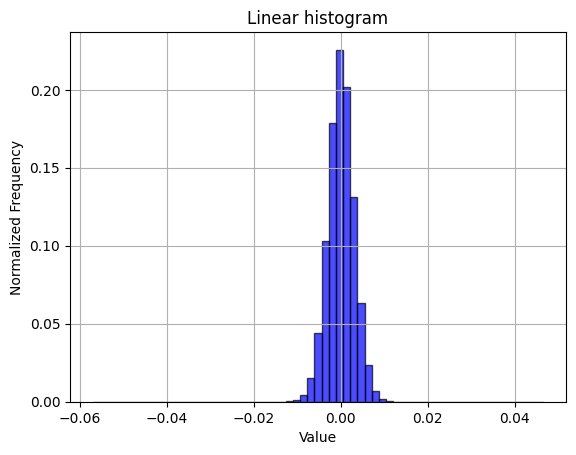

Module: Linear
Operation: Linear(in_features=14336, out_features=4096, bias=False)
[3.40597970e-08 0.00000000e+00 1.70298985e-08 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.70298985e-08 0.00000000e+00
 1.70298985e-08 3.40597970e-08 5.10896955e-08 6.81195940e-08
 8.51494925e-08 1.19209290e-07 3.06538173e-07 7.32285636e-07
 1.31130219e-06 3.35489001e-06 1.10183443e-05 3.62634659e-04
 2.84065349e-02 3.80758200e-01 5.20850778e-01 6.83731522e-02
 1.20307718e-03 2.07253865e-05 4.63213239e-06 1.60081046e-06
 5.79016549e-07 3.74657767e-07 1.53269087e-07 1.36239188e-07
 8.51494925e-08 5.10896955e-08 1.70298985e-08 3.40597970e-08
 1.70298985e-08 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.70298985e-08 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.70298985e-08 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0

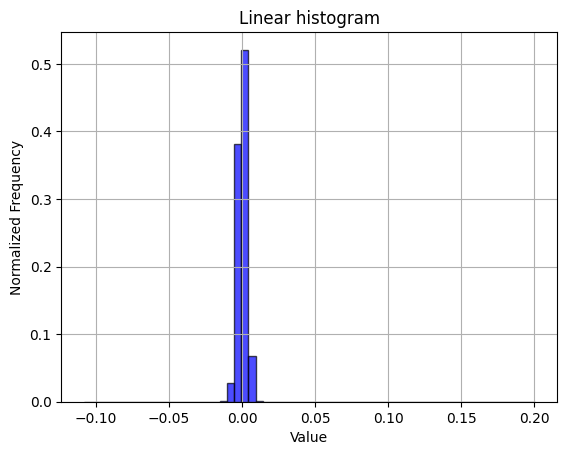

Module: MistralMLP
Operation: MistralMLP(
  (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
  (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
  (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
  (act_fn): SiLU()
)
No weights in this module.
Module: MistralDecoderLayer
Operation: MistralDecoderLayer(
  (self_attn): MistralSdpaAttention(
    (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
    (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
    (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
    (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
    (rotary_emb): MistralRotaryEmbedding()
  )
  (mlp): MistralMLP(
    (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
    (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
    (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
    (act_fn): SiLU()
  )
  (inp

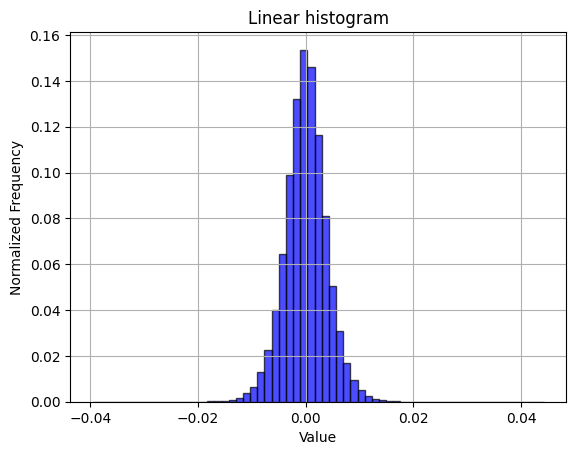

Module: Linear
Operation: Linear(in_features=4096, out_features=1024, bias=False)
[2.38418579e-07 0.00000000e+00 0.00000000e+00 2.38418579e-07
 2.38418579e-07 0.00000000e+00 4.76837158e-07 4.76837158e-07
 7.15255737e-07 1.66893005e-06 1.43051147e-06 2.62260437e-06
 2.62260437e-06 4.05311584e-06 4.76837158e-06 7.15255737e-06
 1.02519989e-05 1.57356262e-05 2.28881836e-05 3.76701355e-05
 6.79492950e-05 1.36137009e-04 3.33309174e-04 7.73429871e-04
 1.69849396e-03 4.25291061e-03 9.12880898e-03 2.00915337e-02
 4.04272079e-02 7.60300159e-02 1.30407810e-01 1.88028097e-01
 1.97514772e-01 1.47489071e-01 9.02633667e-02 4.83043194e-02
 2.40445137e-02 1.17394924e-02 5.14316559e-03 2.26807594e-03
 9.68933105e-04 3.95059586e-04 1.64747238e-04 7.72476196e-05
 4.69684601e-05 2.78949738e-05 1.83582306e-05 1.19209290e-05
 9.53674316e-06 5.96046448e-06 4.29153442e-06 2.62260437e-06
 2.86102295e-06 1.66893005e-06 1.43051147e-06 1.66893005e-06
 7.15255737e-07 4.76837158e-07 7.15255737e-07 4.76837158e-07
 2.

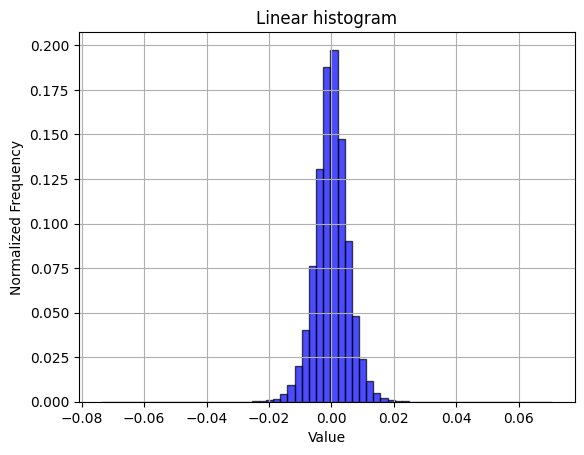

Module: Linear
Operation: Linear(in_features=4096, out_features=1024, bias=False)
[2.38418579e-07 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.38418579e-07
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.38418579e-07
 0.00000000e+00 9.53674316e-07 4.05311584e-06 1.57356262e-05
 3.74317169e-05 1.01804733e-04 3.17335129e-04 7.86304474e-04
 2.21228600e-03 4.93478775e-03 1.11310482e-02 2.18694210e-02
 4.04422283e-02 6.81138039e-02 1.01892233e-01 1.33043289e-01
 1.54815435e-01 1.46473646e-01 1.16853476e-01 8.44838619e-02
 5.39693832e-02 2.96461582e-02 1.60717964e-02 7.31420517e-03
 3.27944756e-03 1.36685371e-03 5.23090363e-04 2.05755234e-04
 6.15119934e-05 2.07424164e-05 6.43730164e-06 2.86102295e-06
 4.76837158e-07 0.00000000e+00 0.00000000e+00 2.38418579e-07
 2.38418579e-07 0.00000000e+00 7.15255737e-07 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

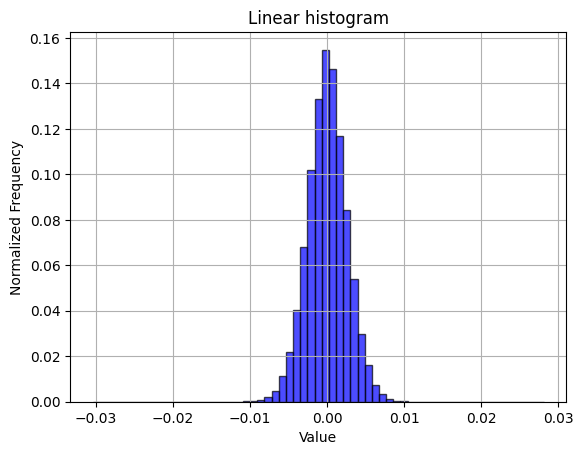

Module: MistralRotaryEmbedding
Operation: MistralRotaryEmbedding()
No weights in this module.
Module: Linear
Operation: Linear(in_features=4096, out_features=4096, bias=False)
[5.96046448e-08 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.78813934e-07
 1.19209290e-07 5.96046448e-08 0.00000000e+00 0.00000000e+00
 3.57627869e-07 5.96046448e-08 1.78813934e-07 7.15255737e-07
 5.36441803e-07 2.98023224e-07 8.94069672e-07 1.07288361e-06
 1.25169754e-06 1.78813934e-06 3.51667404e-06 4.76837158e-06
 6.55651093e-06 1.23381615e-05 2.03251839e-05 4.74452972e-05
 1.44958496e-04 5.30064106e-04 1.96808577e-03 7.49415159e-03
 2.40795016e-02 6.55213594e-02 1.36376739e-01 2.13892758e-01
 2.31183171e-01 1.71881199e-01 9.17478204e-02 3.75920534e-02
 1.27404332e-02 3.44318151e-03 9.26852226e-04 2.29358673e-04
 7.76648521e-05 2.50935555e-05 1.38282776e-05 9.65595245e-06
 5.12599945e-06 4.23192978e-06 2.92062759e-06 2.02655792e-06
 1.31130219e-06 8.94069672e-07 

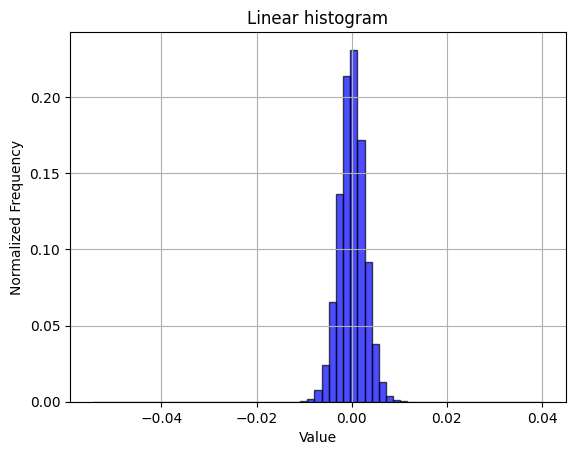

Module: MistralSdpaAttention
Operation: MistralSdpaAttention(
  (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
  (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
  (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
  (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
  (rotary_emb): MistralRotaryEmbedding()
)
No weights in this module.
Module: Linear
Operation: Linear(in_features=4096, out_features=14336, bias=False)
[1.70298985e-08 6.81195940e-08 0.00000000e+00 5.10896955e-08
 3.40597970e-08 1.70298985e-08 1.70298985e-08 8.51494925e-08
 1.36239188e-07 8.51494925e-08 2.04358782e-07 1.53269087e-07
 4.76837158e-07 5.10896955e-07 8.68524824e-07 1.15803310e-06
 1.61784036e-06 2.62260437e-06 4.27450453e-06 8.58306885e-06
 1.49863107e-05 3.35148403e-05 1.10132354e-04 5.50627708e-04
 4.11227771e-03 2.51289265e-02 1.04808620e-01 2.57360816e-01
 3.24642386e-01 2.00683100e-01 6.65932553e-02 1.35307653e-02
 2.01032843e-03 2.8102738

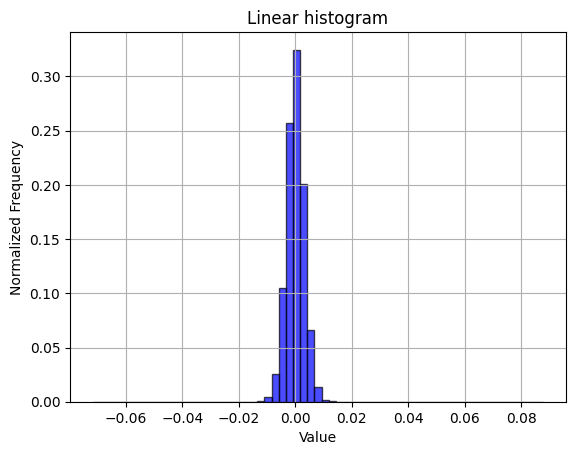

Module: SiLU
Operation: SiLU()
No weights in this module.
Module: Linear
Operation: Linear(in_features=4096, out_features=14336, bias=False)
[1.70298985e-08 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.70298985e-08 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.70298985e-08
 0.00000000e+00 1.70298985e-08 1.70298985e-08 5.10896955e-08
 5.10896955e-08 3.40597970e-08 3.40597970e-08 5.10896955e-08
 8.51494925e-08 2.04358782e-07 2.72478376e-07 3.74657767e-07
 4.93867057e-07 7.49315534e-07 1.32833208e-06 2.38418579e-06
 3.35489001e-06 8.05514199e-06 2.50509807e-05 1.68544906e-04
 1.55176435e-03 1.17803642e-02 5.83289010e-02 1.76312804e-01
 3.04732425e-01 2.72106137e-01 1.31534083e-01 3.62646750e-02
 6.34261540e-03 7.22408295e-04 8.16243035e-05 1.57867159e-05
 6.67572021e-06 3.23568072e-06 1.83922904e-06 1.17506300e-06
 6.64166042e-07 4.08717564e-07 3.06538173e-07 2.55448478e-07
 2.04358782e-07 1.02179391e-07 1.36239188e-07 1.36239188e-07
 1.70

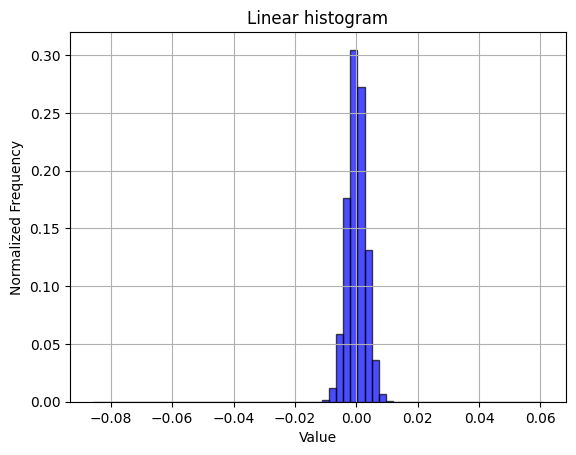

Module: Linear
Operation: Linear(in_features=14336, out_features=4096, bias=False)
[1.70298985e-08 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40597970e-08
 0.00000000e+00 1.70298985e-08 5.10896955e-08 3.40597970e-08
 3.40597970e-08 6.81195940e-08 6.81195940e-08 2.38418579e-07
 1.87328884e-07 3.57627869e-07 6.64166042e-07 1.17506300e-06
 2.17982701e-06 6.28403255e-06 2.52212797e-05 6.25831740e-04
 2.42273978e-02 2.56865723e-01 5.32319852e-01 1.73704846e-01
 1.19327477e-02 2.61340822e-04 1.63657325e-05 4.76837158e-06
 2.02655792e-06 9.19614519e-07 6.13076346e-07 4.93867057e-07
 6.81195940e-08 6.81195940e-08 1.19209290e-07 1.70298985e-08
 6.81195940e-08 6.81195940e-08 0.00000000e+00 0.00000000e+00
 0

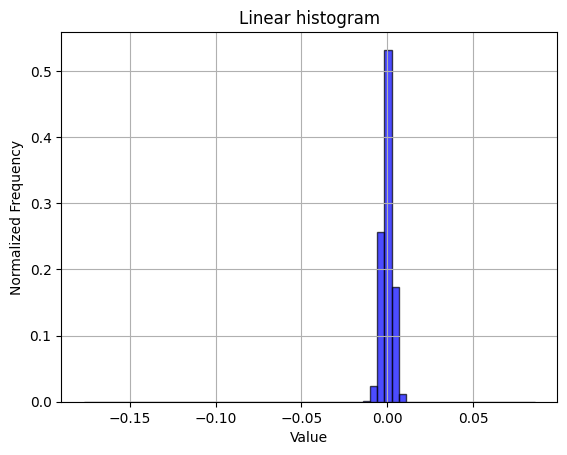

Module: MistralMLP
Operation: MistralMLP(
  (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
  (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
  (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
  (act_fn): SiLU()
)
No weights in this module.
Module: MistralDecoderLayer
Operation: MistralDecoderLayer(
  (self_attn): MistralSdpaAttention(
    (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
    (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
    (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
    (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
    (rotary_emb): MistralRotaryEmbedding()
  )
  (mlp): MistralMLP(
    (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
    (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
    (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
    (act_fn): SiLU()
  )
  (inp

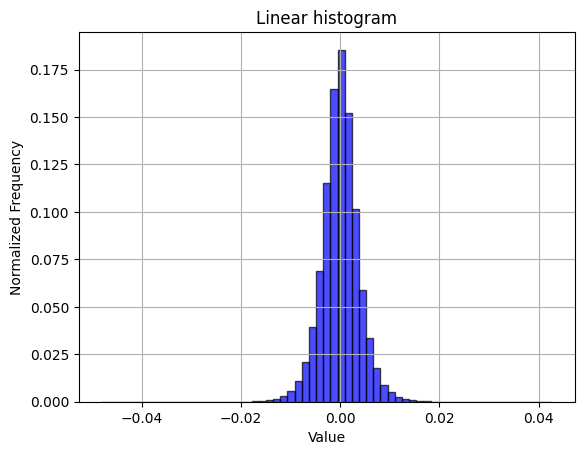

Module: Linear
Operation: Linear(in_features=4096, out_features=1024, bias=False)
[2.38418579e-07 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 2.38418579e-07 2.38418579e-07
 2.38418579e-07 4.76837158e-07 9.53674316e-07 1.43051147e-06
 1.66893005e-06 2.14576721e-06 2.14576721e-06 3.81469727e-06
 4.52995300e-06 8.58306885e-06 8.10623169e-06 1.43051147e-05
 2.62260437e-05 4.98294830e-05 8.96453857e-05 1.82867050e-04
 3.81469727e-04 7.97510147e-04 1.69396400e-03 3.69644165e-03
 8.06832314e-03 1.76041126e-02 3.73783112e-02 7.62746334e-02
 1.45574570e-01 2.18275785e-01 2.13540554e-01 1.38641596e-01
 7.18967915e-02 3.52485180e-02 1.65047646e-02 7.59983063e-03
 3.42988968e-03 1.51729584e-03 7.30991364e-04 3.53336334e-04
 1.74283981e-04 8.63075256e-05 4.98294830e-05 2.69412994e-05
 1.66893005e-05 1.02519989e-05 1.09672546e-05 5.72204590e-06
 3.33786011e-06 2.38418579e-06 1.43051147e-06 2.14576721e-06
 2.38418579e-07 1.19209290e-06 4.76837158e-07 4.76837158e-07
 0.

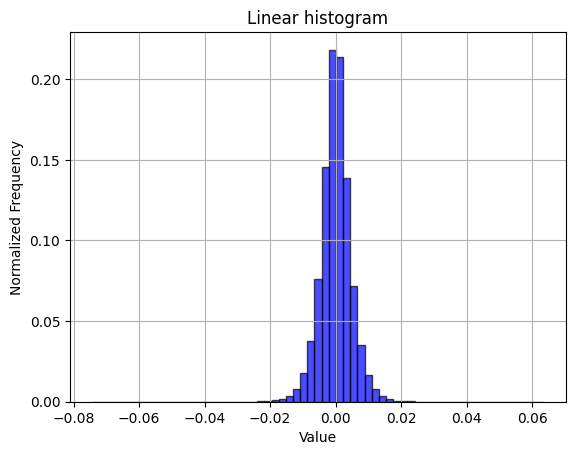

Module: Linear
Operation: Linear(in_features=4096, out_features=1024, bias=False)
[2.38418579e-07 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 2.38418579e-07 0.00000000e+00 0.00000000e+00
 2.38418579e-07 2.38418579e-07 7.15255737e-07 2.38418579e-07
 1.19209290e-06 2.38418579e-07 2.38418579e-06 3.81469727e-06
 9.29832458e-06 1.81198120e-05 3.62396240e-05 7.29560852e-05
 1.35660172e-04 3.23772430e-04 6.04152679e-04 1.30057335e-03
 2.40588188e-03 5.03134727e-03 9.98997688e-03 1.92265511e-02
 3.49674225e-02 5.97448349e-02 9.08603668e-02 1.22159004e-01
 1.50412083e-01 1.50355816e-01 1.24155760e-01 9.16719437e-02
 6.07466698e-02 3.57072353e-02 1.97219849e-02 1.01790428e-02
 5.08928299e-03 2.47216225e-03 1.32107735e-03 6.35385513e-04
 3.32593918e-04 1.48057938e-04 7.93933868e-05 3.71932983e-05
 2.00271606e-05 8.34465027e-06 5.48362732e-06 1.90734863e-06
 4.76837158e-07 7.15255737e-07 2.38418579e-07 7.15255737e-07
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.

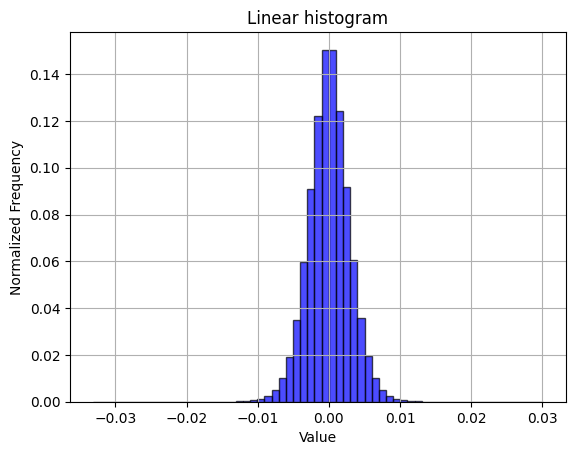

Module: MistralRotaryEmbedding
Operation: MistralRotaryEmbedding()
No weights in this module.
Module: Linear
Operation: Linear(in_features=4096, out_features=4096, bias=False)
[1.19209290e-07 5.96046448e-08 5.96046448e-08 0.00000000e+00
 1.19209290e-07 5.96046448e-08 1.78813934e-07 1.19209290e-07
 5.96046448e-08 1.19209290e-07 1.19209290e-07 2.38418579e-07
 1.19209290e-07 1.19209290e-07 5.36441803e-07 4.17232513e-07
 5.36441803e-07 1.43051147e-06 2.26497650e-06 3.57627869e-06
 8.46385956e-06 1.66296959e-05 4.46438789e-05 1.50561333e-04
 7.18057156e-04 3.72993946e-03 1.71396136e-02 6.30120635e-02
 1.69943452e-01 2.86144435e-01 2.62087703e-01 1.36829078e-01
 4.56313491e-02 1.14684701e-02 2.40421295e-03 4.82439995e-04
 1.15334988e-04 3.40342522e-05 1.34706497e-05 6.31809235e-06
 3.39746475e-06 2.38418579e-06 7.15255737e-07 4.76837158e-07
 5.36441803e-07 3.57627869e-07 3.57627869e-07 4.76837158e-07
 0.00000000e+00 1.19209290e-07 0.00000000e+00 5.96046448e-08
 5.96046448e-08 5.96046448e-08 

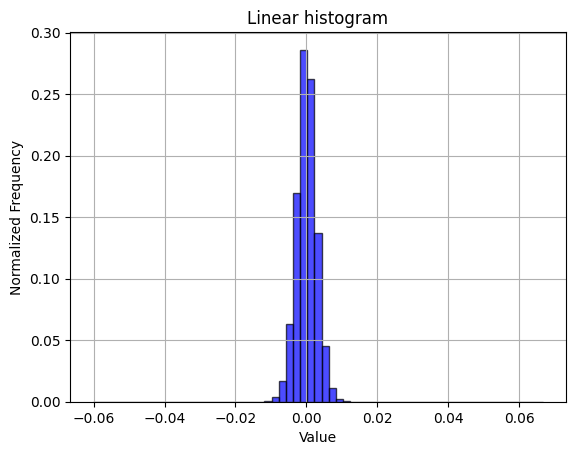

Module: MistralSdpaAttention
Operation: MistralSdpaAttention(
  (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
  (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
  (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
  (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
  (rotary_emb): MistralRotaryEmbedding()
)
No weights in this module.
Module: Linear
Operation: Linear(in_features=4096, out_features=14336, bias=False)
[1.70298985e-08 0.00000000e+00 0.00000000e+00 1.70298985e-08
 1.70298985e-08 1.70298985e-08 5.10896955e-08 1.70298985e-08
 0.00000000e+00 5.10896955e-08 5.10896955e-08 6.81195940e-08
 1.70298985e-07 1.19209290e-07 2.89508275e-07 2.21388681e-07
 3.91687666e-07 4.93867057e-07 8.00405230e-07 8.68524824e-07
 1.02179391e-06 2.12873731e-06 3.42300960e-06 5.16005925e-06
 8.90663692e-06 1.54120581e-05 3.18288803e-05 8.54049410e-05
 3.96439007e-04 3.24978147e-03 2.67216308e-02 1.35001932e-01
 3.34596259e-01 3.3316128

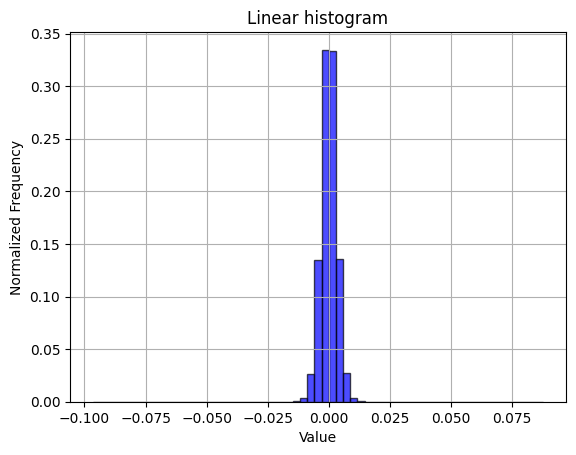

Module: SiLU
Operation: SiLU()
No weights in this module.
Module: Linear
Operation: Linear(in_features=4096, out_features=14336, bias=False)
[1.70298985e-08 1.70298985e-08 1.70298985e-08 0.00000000e+00
 1.70298985e-08 0.00000000e+00 1.70298985e-08 3.40597970e-08
 3.40597970e-08 1.19209290e-07 1.02179391e-07 2.72478376e-07
 2.89508275e-07 3.57627869e-07 6.47136143e-07 1.22615269e-06
 1.78813934e-06 3.67845808e-06 7.51018524e-06 2.70945685e-05
 2.45571136e-04 3.14928804e-03 2.74932384e-02 1.32011907e-01
 3.15597449e-01 3.32087619e-01 1.51036245e-01 3.38626078e-02
 4.09443038e-03 3.23619161e-04 3.52518899e-05 8.95772661e-06
 4.37668392e-06 2.33309610e-06 1.65190016e-06 8.51494925e-07
 4.42777361e-07 3.23568072e-07 2.72478376e-07 1.19209290e-07
 5.10896955e-08 5.10896955e-08 3.40597970e-08 1.70298985e-08
 0.00000000e+00 0.00000000e+00 1.70298985e-08 0.00000000e+00
 0.00000000e+00 1.70298985e-08 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

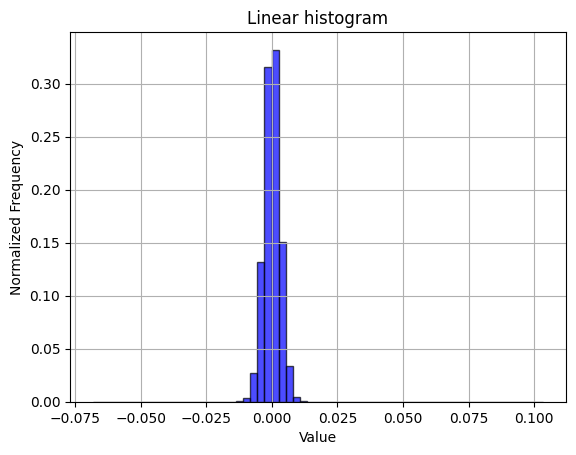

Module: Linear
Operation: Linear(in_features=14336, out_features=4096, bias=False)
[1.70298985e-08 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.70298985e-08
 1.70298985e-08 1.70298985e-08 3.40597970e-08 1.70298985e-08
 3.40597970e-08 6.81195940e-08 5.10896955e-08 5.10896955e-08
 2.89508275e-07 4.25747463e-07 1.27724239e-06 3.84875706e-06
 1.37260982e-05 5.54374286e-04 1.32370182e-01 7.66825216e-01
 9.98558658e-02 3.55260713e-04 1.37942178e-05 3.08241163e-06
 1.14100320e-06 5.27926854e-07 2.21388681e-07 1.02179391e-07
 1.02179391e-07 8.51494925e-08 3.40597970e-08 3.40597970e-08
 3.40597970e-08 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.70298985e-08 0.00000000e+00 1.70298985e-08
 0

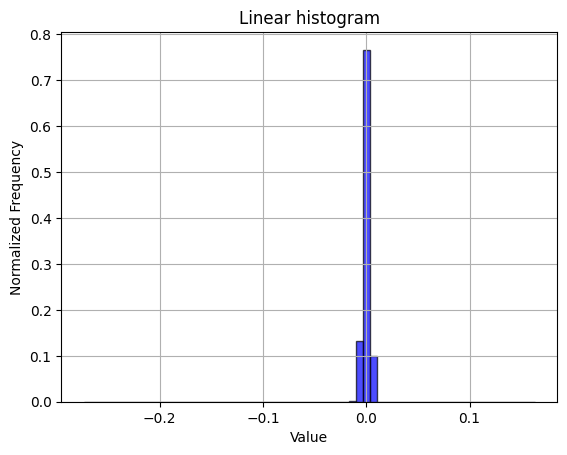

Module: MistralMLP
Operation: MistralMLP(
  (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
  (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
  (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
  (act_fn): SiLU()
)
No weights in this module.
Module: MistralDecoderLayer
Operation: MistralDecoderLayer(
  (self_attn): MistralSdpaAttention(
    (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
    (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
    (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
    (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
    (rotary_emb): MistralRotaryEmbedding()
  )
  (mlp): MistralMLP(
    (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
    (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
    (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
    (act_fn): SiLU()
  )
  (inp

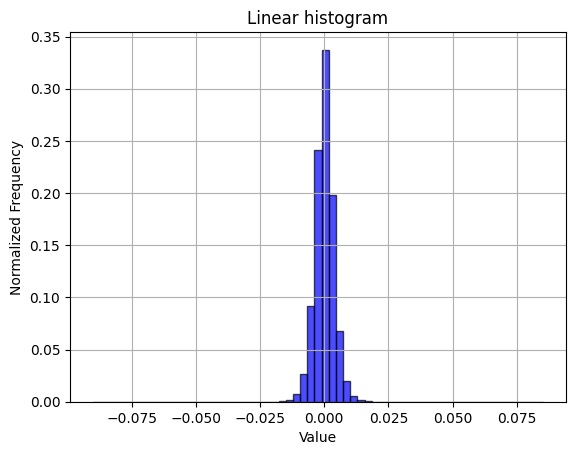

Module: Linear
Operation: Linear(in_features=4096, out_features=1024, bias=False)
[2.38418579e-07 2.38418579e-07 0.00000000e+00 4.76837158e-07
 9.53674316e-07 4.76837158e-07 2.38418579e-07 2.38418579e-06
 1.43051147e-06 2.38418579e-06 2.86102295e-06 1.66893005e-06
 3.09944153e-06 5.24520874e-06 4.76837158e-06 7.62939453e-06
 8.34465027e-06 1.09672546e-05 1.88350677e-05 2.52723694e-05
 4.17232513e-05 6.65187836e-05 1.38282776e-04 2.83479691e-04
 6.44922256e-04 1.63364410e-03 4.01115417e-03 9.36150551e-03
 2.25858688e-02 5.17268181e-02 1.13217592e-01 2.18961477e-01
 2.60998011e-01 1.72235966e-01 8.10222626e-02 3.58994007e-02
 1.57997608e-02 6.55269623e-03 2.64096260e-03 1.12414360e-03
 4.77075577e-04 2.06470490e-04 8.98838043e-05 5.79357147e-05
 3.43322754e-05 2.14576721e-05 1.38282776e-05 1.33514404e-05
 1.19209290e-05 6.67572021e-06 6.91413879e-06 4.29153442e-06
 2.86102295e-06 2.38418579e-06 1.90734863e-06 1.43051147e-06
 4.76837158e-07 1.43051147e-06 2.38418579e-07 4.76837158e-07
 4.

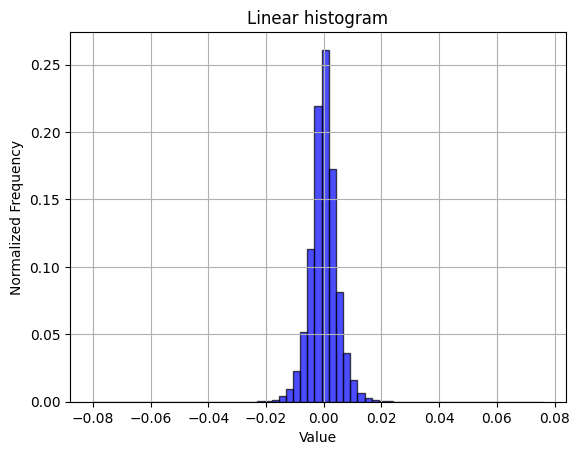

Module: Linear
Operation: Linear(in_features=4096, out_features=1024, bias=False)
[2.38418579e-07 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 4.76837158e-07 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.38418579e-07
 7.15255737e-07 0.00000000e+00 4.76837158e-07 4.76837158e-07
 1.90734863e-06 5.72204590e-06 1.23977661e-05 2.57492065e-05
 5.12599945e-05 1.34468079e-04 2.77996063e-04 5.86509705e-04
 1.18327141e-03 2.49576569e-03 5.06925583e-03 9.30380821e-03
 1.74036026e-02 2.89177895e-02 4.64873314e-02 6.93264008e-02
 9.42170620e-02 1.17084265e-01 1.32739305e-01 1.28363609e-01
 1.09515190e-01 8.38983059e-02 6.05399609e-02 3.99956703e-02
 2.36337185e-02 1.36079788e-02 7.66444206e-03 3.84211540e-03
 1.87397003e-03 9.11712646e-04 4.47034836e-04 2.14815140e-04
 9.67979431e-05 3.48091125e-05 1.59740448e-05 8.58306885e-06
 3.81469727e-06 2.38418579e-06 9.53674316e-07 7.15255737e-07
 4.76837158e-07 0.00000000e+00 2.38418579e-07 0.00000000e+00
 0.

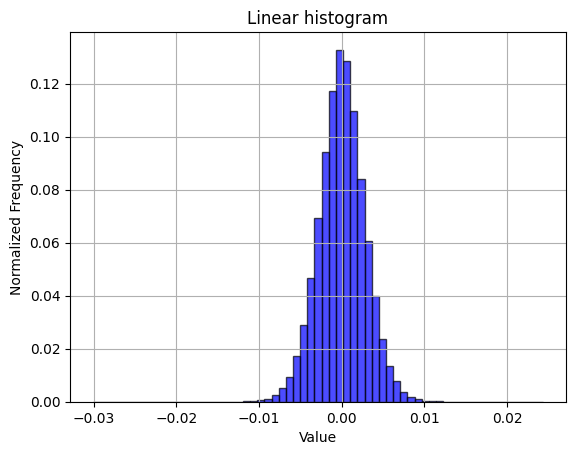

Module: MistralRotaryEmbedding
Operation: MistralRotaryEmbedding()
No weights in this module.
Module: Linear
Operation: Linear(in_features=4096, out_features=4096, bias=False)
[5.96046448e-08 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 5.96046448e-08 0.00000000e+00 5.96046448e-08
 5.96046448e-08 5.96046448e-08 1.19209290e-07 2.38418579e-07
 1.78813934e-07 3.57627869e-07 4.17232513e-07 4.76837158e-07
 4.17232513e-07 5.96046448e-07 1.31130219e-06 1.54972076e-06
 2.62260437e-06 4.47034836e-06 1.31130219e-05 3.17096710e-05
 1.24990940e-04 5.01036644e-04 1.93607807e-03 7.70127773e-03
 2.57500410e-02 6.93798661e-02 1.45948589e-01 2.23484814e-01
 2.32699454e-01 1.63799286e-01 8.27643275e-02 3.23273540e-02
 9.95916128e-03 2.69877911e-03 6.40451908e-04 1.55031681e-04
 4.57167625e-05 1.33514404e-05 5.24520874e-06 3.09944153e-06
 1.43051147e-06 6.55651093e-07 3.57627869e-07 3.57627869e-07
 2.98023224e-07 2.38418579e-07 1.78813934e-07 2.38418579e-07
 5.96046448e-08 0.00000000e+00 

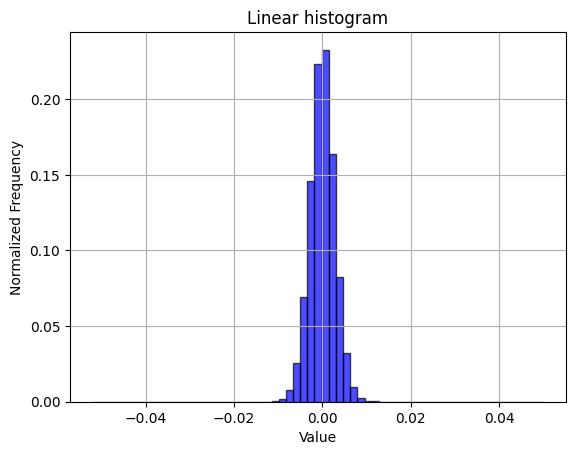

Module: MistralSdpaAttention
Operation: MistralSdpaAttention(
  (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
  (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
  (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
  (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
  (rotary_emb): MistralRotaryEmbedding()
)
No weights in this module.
Module: Linear
Operation: Linear(in_features=4096, out_features=14336, bias=False)
[3.40597970e-08 1.70298985e-08 1.70298985e-08 1.70298985e-08
 0.00000000e+00 1.70298985e-08 3.40597970e-08 3.40597970e-08
 5.10896955e-08 5.10896955e-08 1.87328884e-07 8.51494925e-08
 1.53269087e-07 1.70298985e-07 1.87328884e-07 3.06538173e-07
 3.57627869e-07 4.93867057e-07 6.64166042e-07 1.00476401e-06
 1.39645168e-06 1.85625894e-06 3.13350133e-06 4.64916229e-06
 7.40800585e-06 1.44413539e-05 2.81674521e-05 8.03811210e-05
 3.83308956e-04 3.28222343e-03 2.74023839e-02 1.42005427e-01
 3.38977746e-01 3.3002892

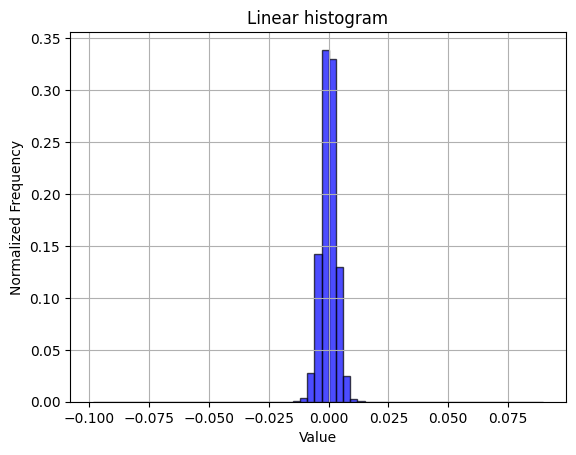

Module: SiLU
Operation: SiLU()
No weights in this module.
Module: Linear
Operation: Linear(in_features=4096, out_features=14336, bias=False)
[1.70298985e-08 0.00000000e+00 0.00000000e+00 1.70298985e-08
 0.00000000e+00 1.70298985e-08 5.10896955e-08 5.10896955e-08
 3.40597970e-08 3.40597970e-08 1.36239188e-07 2.72478376e-07
 1.53269087e-07 2.38418579e-07 3.74657767e-07 5.79016549e-07
 6.13076346e-07 1.07288361e-06 1.83922904e-06 3.55924879e-06
 6.79492950e-06 2.07935061e-05 8.94750868e-05 5.08461680e-04
 2.72866658e-03 1.20469843e-02 4.02713844e-02 1.01954341e-01
 1.88234261e-01 2.39973715e-01 2.09398559e-01 1.27334016e-01
 5.44128248e-02 1.76090172e-02 4.32518550e-03 8.83374895e-04
 1.45469393e-04 2.86953790e-05 8.27653067e-06 3.88281686e-06
 2.45230539e-06 1.31130219e-06 6.64166042e-07 5.61986651e-07
 4.76837158e-07 3.74657767e-07 2.04358782e-07 1.70298985e-07
 1.19209290e-07 8.51494925e-08 8.51494925e-08 5.10896955e-08
 1.70298985e-08 0.00000000e+00 1.70298985e-08 6.81195940e-08
 3.40

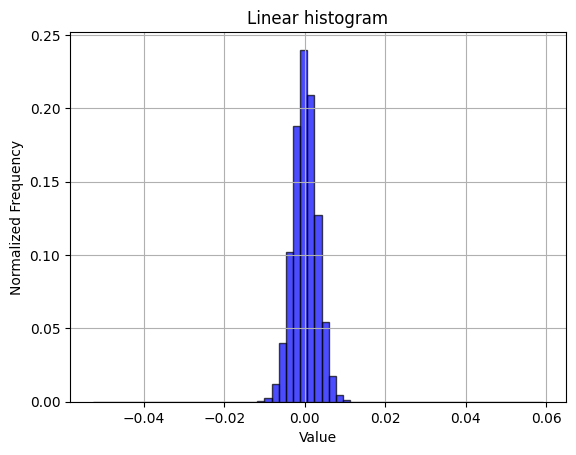

Module: Linear
Operation: Linear(in_features=14336, out_features=4096, bias=False)
[3.40597970e-08 1.70298985e-08 6.81195940e-08 3.40597970e-08
 5.10896955e-08 6.81195940e-08 8.51494925e-08 6.81195940e-08
 1.70298985e-07 3.23568072e-07 4.76837158e-07 8.85554722e-07
 1.43051147e-06 3.44003950e-06 1.57185963e-05 6.06758254e-04
 3.03667273e-02 3.15911991e-01 5.24386270e-01 1.23245375e-01
 5.37448270e-03 7.49826431e-05 6.53948103e-06 1.89031873e-06
 8.85554722e-07 5.27926854e-07 2.21388681e-07 1.19209290e-07
 8.51494925e-08 8.51494925e-08 3.40597970e-08 3.40597970e-08
 3.40597970e-08 0.00000000e+00 3.40597970e-08 0.00000000e+00
 0.00000000e+00 1.70298985e-08 0.00000000e+00 0.00000000e+00
 1.70298985e-08 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0

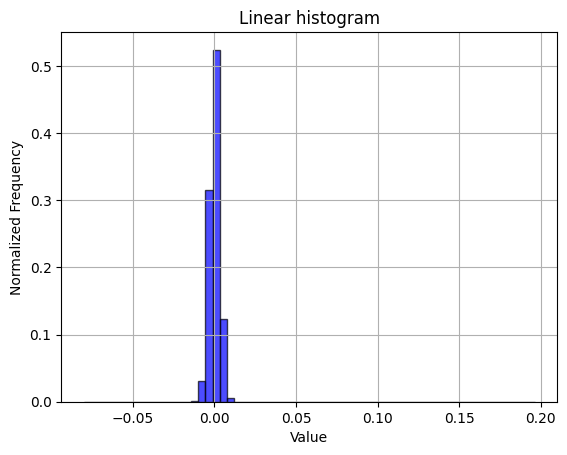

Module: MistralMLP
Operation: MistralMLP(
  (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
  (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
  (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
  (act_fn): SiLU()
)
No weights in this module.
Module: MistralDecoderLayer
Operation: MistralDecoderLayer(
  (self_attn): MistralSdpaAttention(
    (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
    (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
    (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
    (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
    (rotary_emb): MistralRotaryEmbedding()
  )
  (mlp): MistralMLP(
    (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
    (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
    (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
    (act_fn): SiLU()
  )
  (inp

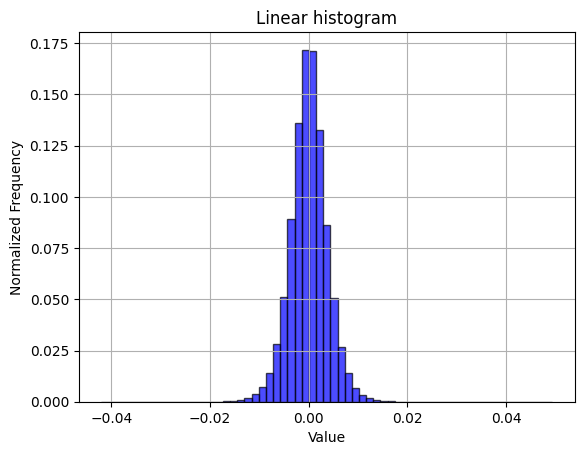

Module: Linear
Operation: Linear(in_features=4096, out_features=1024, bias=False)
[4.76837158e-07 0.00000000e+00 2.38418579e-07 0.00000000e+00
 0.00000000e+00 0.00000000e+00 4.76837158e-07 9.53674316e-07
 1.43051147e-06 1.66893005e-06 9.53674316e-07 2.86102295e-06
 3.33786011e-06 4.52995300e-06 4.05311584e-06 6.91413879e-06
 9.29832458e-06 1.31130219e-05 2.09808350e-05 3.31401825e-05
 4.41074371e-05 9.10758972e-05 1.76429749e-04 3.81231308e-04
 8.91208649e-04 1.96886063e-03 4.30345535e-03 9.49549675e-03
 1.97520256e-02 3.87871265e-02 7.41009712e-02 1.28611088e-01
 1.88589573e-01 2.00153828e-01 1.49135828e-01 8.84609222e-02
 4.79860306e-02 2.46431828e-02 1.20711327e-02 5.64551353e-03
 2.52223015e-03 1.08981133e-03 4.75168228e-04 2.26497650e-04
 1.09434128e-04 6.22272491e-05 3.86238098e-05 2.21729279e-05
 1.69277191e-05 1.33514404e-05 6.91413879e-06 5.48362732e-06
 3.57627869e-06 3.33786011e-06 2.86102295e-06 1.19209290e-06
 2.14576721e-06 7.15255737e-07 7.15255737e-07 4.76837158e-07
 1.

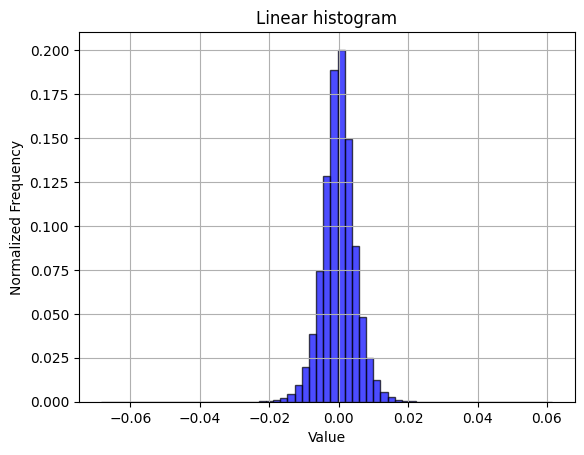

Module: Linear
Operation: Linear(in_features=4096, out_features=1024, bias=False)
[4.76837158e-07 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 7.15255737e-07
 2.38418579e-07 4.76837158e-07 1.43051147e-06 2.62260437e-06
 4.29153442e-06 1.23977661e-05 2.14576721e-05 4.19616699e-05
 1.00374222e-04 2.29597092e-04 4.35829163e-04 9.12427902e-04
 1.64055824e-03 3.31568718e-03 5.96523285e-03 1.04117393e-02
 1.73850060e-02 2.75406837e-02 4.20641899e-02 5.86235523e-02
 7.78260231e-02 9.65168476e-02 1.10085249e-01 1.17470741e-01
 1.08572721e-01 9.11190510e-02 7.39245415e-02 5.49895763e-02
 3.89564037e-02 2.53963470e-02 1.58200264e-02 9.44447517e-03
 5.30624390e-03 2.82025337e-03 1.57475471e-03 7.69138336e-04
 3.60488892e-04 1.80721283e-04 7.67707825e-05 4.43458557e-05
 1.88350677e-05 8.82148743e-06 3.09944153e-06 1.90734863e-06
 9.

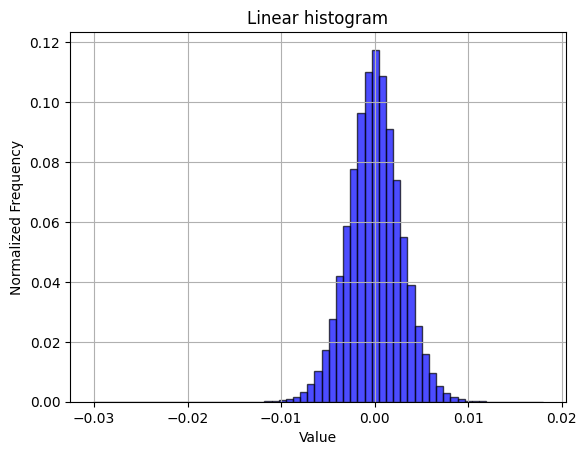

Module: MistralRotaryEmbedding
Operation: MistralRotaryEmbedding()
No weights in this module.
Module: Linear
Operation: Linear(in_features=4096, out_features=4096, bias=False)
[5.96046448e-08 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 5.96046448e-08
 0.00000000e+00 0.00000000e+00 1.19209290e-07 0.00000000e+00
 1.19209290e-07 0.00000000e+00 1.19209290e-07 0.00000000e+00
 0.00000000e+00 5.96046448e-08 0.00000000e+00 1.19209290e-07
 1.19209290e-07 1.19209290e-07 1.78813934e-07 2.38418579e-07
 3.57627869e-07 2.38418579e-07 7.74860382e-07 7.15255737e-07
 1.90734863e-06 4.35113907e-06 1.30534172e-05 1.31309032e-04
 3.90619040e-03 7.35772848e-02 4.11750793e-01 4.24564600e-01
 8.15160871e-02 4.36306000e-03 1.42812729e-04 1.53779984e-05
 4.70876694e-06 1.37090683e-06 1.07288361e-06 5.96046448e-07
 4.76837158e-07 1.78813934e-07 

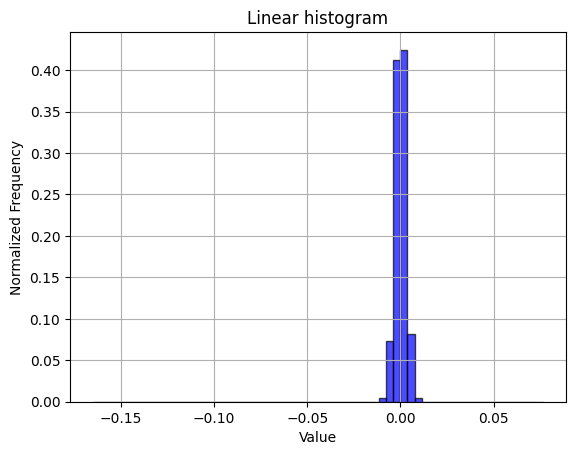

Module: MistralSdpaAttention
Operation: MistralSdpaAttention(
  (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
  (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
  (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
  (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
  (rotary_emb): MistralRotaryEmbedding()
)
No weights in this module.
Module: Linear
Operation: Linear(in_features=4096, out_features=14336, bias=False)
[1.70298985e-08 0.00000000e+00 1.70298985e-08 6.81195940e-08
 1.02179391e-07 1.19209290e-07 8.51494925e-08 1.36239188e-07
 1.87328884e-07 1.53269087e-07 3.91687666e-07 5.10896955e-07
 3.57627869e-07 7.49315534e-07 1.08991350e-06 1.31130219e-06
 1.56675066e-06 2.23091670e-06 3.57627869e-06 5.05787986e-06
 7.15255737e-06 1.28064837e-05 2.34672001e-05 4.37327794e-05
 1.03780202e-04 3.76394817e-04 2.26105962e-03 1.47432940e-02
 7.22104822e-02 2.16545258e-01 3.34823455e-01 2.44867546e-01
 9.06325238e-02 1.9535711

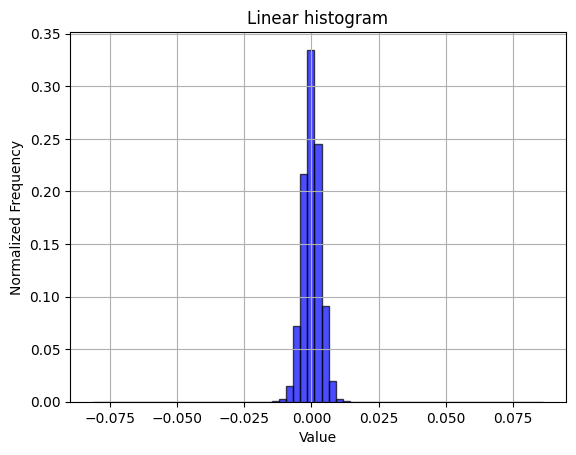

Module: SiLU
Operation: SiLU()
No weights in this module.
Module: Linear
Operation: Linear(in_features=4096, out_features=14336, bias=False)
[1.70298985e-08 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40597970e-08
 3.40597970e-08 1.70298985e-08 0.00000000e+00 3.40597970e-08
 8.51494925e-08 5.10896955e-08 1.70298985e-08 1.53269087e-07
 8.51494925e-08 1.53269087e-07 1.87328884e-07 3.06538173e-07
 4.76837158e-07 6.30106245e-07 1.31130219e-06 2.07764762e-06
 4.15529524e-06 1.01327896e-05 3.92879759e-05 2.68050603e-04
 1.87723977e-03 1.04984897e-02 4.33061463e-02 1.24679565e-01
 2.32738529e-01 2.72417511e-01 1.92997302e-01 8.79806791e-02
 2.64633894e-02 5.67359584e-03 8.79321780e-04 1.23415674e-04
 2.21048083e-05 7.37394605e-06 3.11647143e-06 2.06061772e-06
 8.17435128e-07 5.79016549e-07 3.91687666e-07 2.04358782e-07
 2.38418579e-07 1.36239188e-07 1.02179391e-07 8.51494925e-08
 5.10896955e-08 3.40597970e-08 8.51494925e-08 6.81195940e-08
 0.00

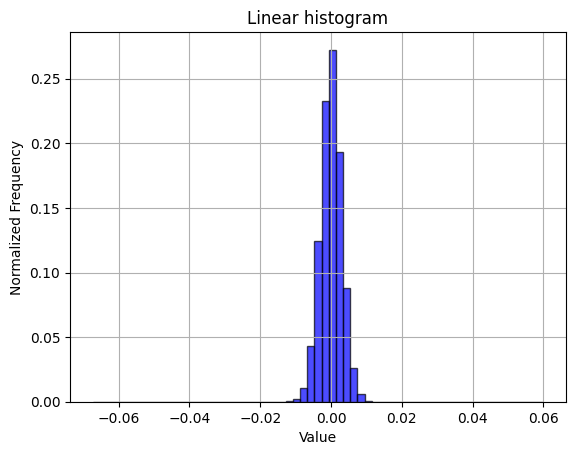

Module: Linear
Operation: Linear(in_features=14336, out_features=4096, bias=False)
[1.70298985e-08 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.70298985e-08 1.70298985e-08 1.70298985e-08 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 3.40597970e-08 8.51494925e-08 1.70298985e-07
 1.70298985e-07 1.53269087e-07 3.57627869e-07 4.08717564e-07
 9.02584621e-07 2.26497650e-06 6.19888306e-06 4.46353640e-05
 3.65718773e-03 1.03612082e-01 5.16576239e-01 3.42203072e-01
 3.32729816e-02 6.02262361e-04 1.35387693e-05 3.71251787e-06
 1.51566097e-06 8.00405230e-07 4.08717564e-07 2.55448478e-07
 1.02179391e-07 2.04358782e-07 3.40597970e-08 3.40597970e-08
 3.40597970e-08 1.70298985e-08 0.00000000e+00 5.10896955e-08
 0

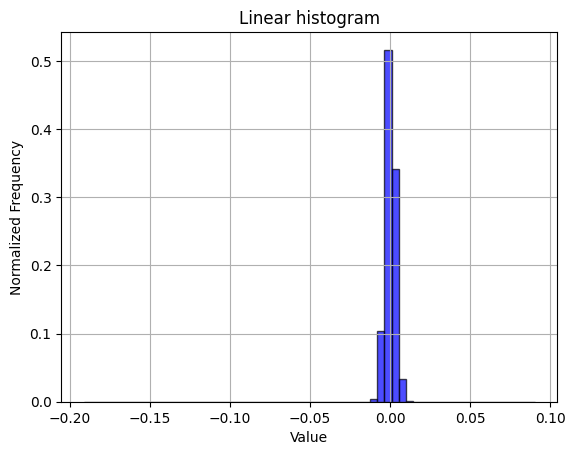

Module: MistralMLP
Operation: MistralMLP(
  (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
  (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
  (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
  (act_fn): SiLU()
)
No weights in this module.
Module: MistralDecoderLayer
Operation: MistralDecoderLayer(
  (self_attn): MistralSdpaAttention(
    (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
    (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
    (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
    (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
    (rotary_emb): MistralRotaryEmbedding()
  )
  (mlp): MistralMLP(
    (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
    (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
    (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
    (act_fn): SiLU()
  )
  (inp

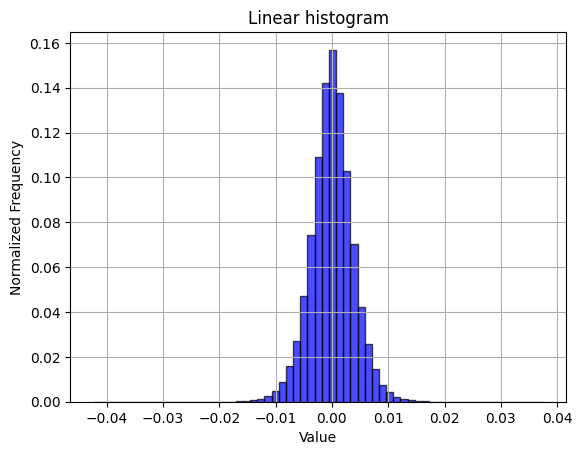

Module: Linear
Operation: Linear(in_features=4096, out_features=1024, bias=False)
[4.76837158e-07 4.76837158e-07 9.53674316e-07 9.53674316e-07
 2.38418579e-07 1.66893005e-06 2.14576721e-06 2.38418579e-06
 2.14576721e-06 2.62260437e-06 4.29153442e-06 6.19888306e-06
 9.29832458e-06 1.43051147e-05 2.69412994e-05 3.83853912e-05
 7.82012939e-05 1.54972076e-04 3.13282013e-04 7.08103180e-04
 1.57213211e-03 3.61776352e-03 7.78627396e-03 1.61552429e-02
 3.32772732e-02 6.30743504e-02 1.12523794e-01 1.70133114e-01
 1.97891712e-01 1.64773703e-01 1.07165098e-01 6.08568192e-02
 3.13093662e-02 1.51691437e-02 7.16423988e-03 3.29518318e-03
 1.54256821e-03 6.86168671e-04 3.12566757e-04 1.52587891e-04
 7.27176666e-05 3.21865082e-05 2.59876251e-05 1.00135803e-05
 8.58306885e-06 4.76837158e-06 4.29153442e-06 3.57627869e-06
 9.53674316e-07 1.66893005e-06 1.90734863e-06 1.66893005e-06
 7.15255737e-07 7.15255737e-07 4.76837158e-07 4.76837158e-07
 4.76837158e-07 4.76837158e-07 2.38418579e-07 0.00000000e+00
 0.

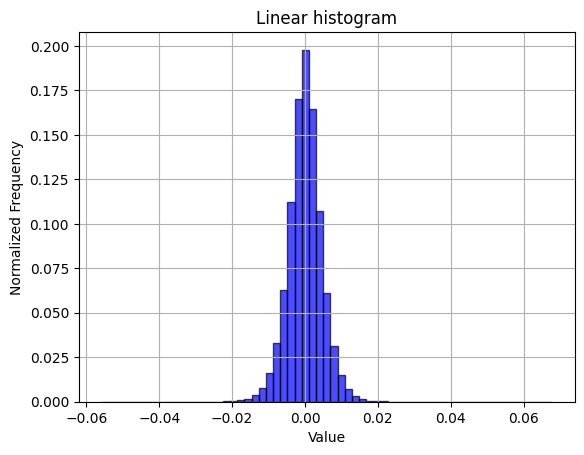

Module: Linear
Operation: Linear(in_features=4096, out_features=1024, bias=False)
[2.38418579e-07 2.38418579e-07 7.15255737e-07 4.76837158e-07
 1.19209290e-06 1.43051147e-06 3.09944153e-06 2.38418579e-06
 7.39097595e-06 1.19209290e-05 2.19345093e-05 3.55243683e-05
 5.57899475e-05 1.07288361e-04 1.78098679e-04 3.28063965e-04
 5.60522079e-04 1.07669830e-03 1.69038773e-03 3.12066078e-03
 5.10048866e-03 8.45050812e-03 1.35605335e-02 2.07877159e-02
 3.05824280e-02 4.30493355e-02 5.96971512e-02 7.69765377e-02
 9.13345814e-02 1.03420258e-01 1.08014584e-01 1.00696802e-01
 8.82546902e-02 7.16724396e-02 5.53030968e-02 4.06343937e-02
 2.76815891e-02 1.76272392e-02 1.19168758e-02 7.35735893e-03
 4.47702408e-03 2.67362595e-03 1.45983696e-03 9.25064087e-04
 4.72784042e-04 2.98976898e-04 1.63316727e-04 8.51154327e-05
 5.10215759e-05 3.07559967e-05 1.78813934e-05 7.86781311e-06
 5.48362732e-06 4.29153442e-06 4.76837158e-07 7.15255737e-07
 1.19209290e-06 4.76837158e-07 4.76837158e-07 2.38418579e-07
 0.

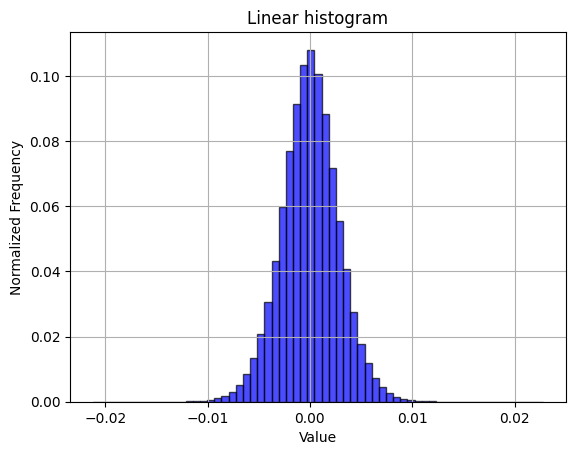

Module: MistralRotaryEmbedding
Operation: MistralRotaryEmbedding()
No weights in this module.
Module: Linear
Operation: Linear(in_features=4096, out_features=4096, bias=False)
[5.96046448e-08 5.96046448e-08 1.19209290e-07 0.00000000e+00
 5.96046448e-08 5.96046448e-08 1.78813934e-07 2.98023224e-07
 2.38418579e-07 1.78813934e-07 2.38418579e-07 1.78813934e-07
 4.17232513e-07 4.76837158e-07 1.07288361e-06 1.43051147e-06
 1.60932541e-06 2.02655792e-06 3.21865082e-06 5.36441803e-06
 7.98702240e-06 1.51395798e-05 3.49283218e-05 8.14795494e-05
 2.01880932e-04 6.34312630e-04 2.27051973e-03 8.76164436e-03
 3.29473019e-02 9.46278572e-02 1.95792794e-01 2.61604965e-01
 2.21209168e-01 1.19424880e-01 4.47552800e-02 1.30081177e-02
 3.26275826e-03 8.65519047e-04 2.67446041e-04 1.11520290e-04
 4.44650650e-05 1.98483467e-05 1.10864639e-05 6.73532486e-06
 4.47034836e-06 2.86102295e-06 2.26497650e-06 1.66893005e-06
 1.13248825e-06 1.01327896e-06 3.57627869e-07 4.17232513e-07
 1.78813934e-07 2.38418579e-07 

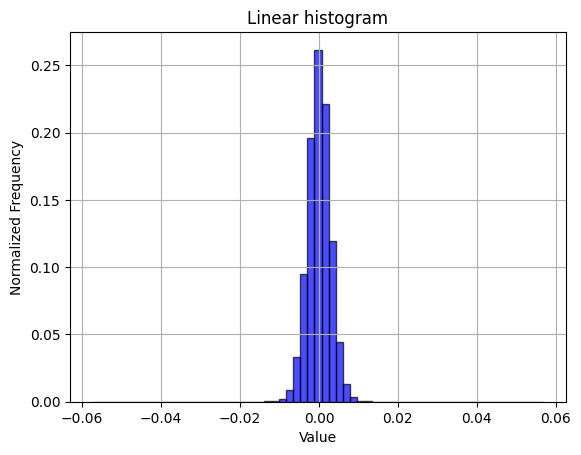

Module: MistralSdpaAttention
Operation: MistralSdpaAttention(
  (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
  (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
  (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
  (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
  (rotary_emb): MistralRotaryEmbedding()
)
No weights in this module.
Module: Linear
Operation: Linear(in_features=4096, out_features=14336, bias=False)
[1.70298985e-08 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.70298985e-08 3.40597970e-08
 1.70298985e-08 5.10896955e-08 3.40597970e-08 1.70298985e-08
 5.10896955e-08 1.70298985e-07 8.51494925e-08 2.21388681e-07
 3.74657767e-07 3.57627869e-07 5.61986651e-07 9.36644418e-07
 1.41348158e-06 2.28200640e-06 3.62736838e-06 5.07490976e-06
 1.09842845e-05 2.40802765e-05 5.47681536e-05 1.69805118e-04
 8.00899097e-04 5.94157832e-03 4.55040421e-02 1.95546082e-01
 3.75837564e-01 2.7715373

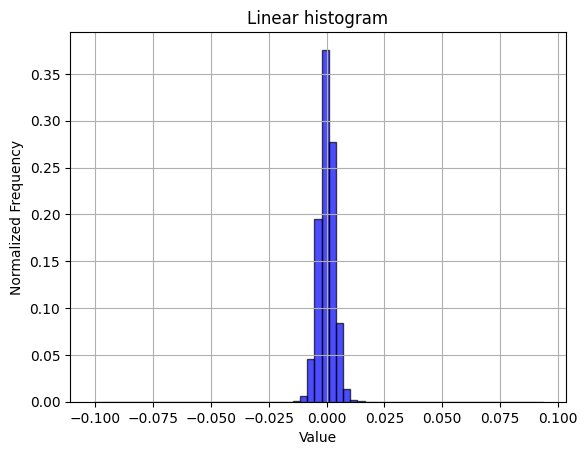

Module: SiLU
Operation: SiLU()
No weights in this module.
Module: Linear
Operation: Linear(in_features=4096, out_features=14336, bias=False)
[1.70298985e-08 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.70298985e-08 0.00000000e+00 0.00000000e+00
 3.40597970e-08 0.00000000e+00 5.10896955e-08 3.40597970e-08
 1.87328884e-07 1.87328884e-07 3.74657767e-07 7.32285636e-07
 1.92437853e-06 6.06264387e-06 4.92164067e-05 1.99571678e-03
 5.17624957e-02 3.42328259e-01 4.70501082e-01 1.25224403e-01
 7.92402881e-03 1.88146319e-04 1.17846898e-05 2.86102295e-06
 1.02179391e-06 7.15255737e-07 2.04358782e-07 1.70298985e-07
 1.02179391e-07 1.02179391e-07 1.70298985e-08 1.70298985e-08
 0.00000000e+00 1.70298985e-08 0.00000000e+00 0.00000000e+00
 0.00

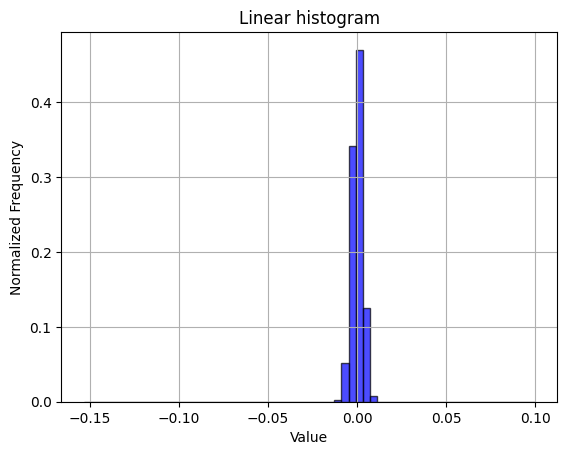

Module: Linear
Operation: Linear(in_features=14336, out_features=4096, bias=False)
[3.40597970e-08 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.70298985e-08 0.00000000e+00 3.40597970e-08
 1.70298985e-08 0.00000000e+00 3.40597970e-08 1.70298985e-08
 8.51494925e-08 8.51494925e-08 1.19209290e-07 1.19209290e-07
 2.21388681e-07 4.59807260e-07 6.47136143e-07 1.27724239e-06
 2.65666417e-06 8.22544098e-06 4.63042940e-05 2.38999299e-03
 7.27706637e-02 4.44409200e-01 4.17225037e-01 6.12031903e-02
 1.88810485e-03 4.05822481e-05 7.51018524e-06 2.65666417e-06
 1.24318259e-06 5.10896955e-07 2.89508275e-07 2.04358782e-07
 1.53269087e-07 6.81195940e-08 3.40597970e-08 5.10896955e-08
 1.70298985e-08 0.00000000e+00 3.40597970e-08 3.40597970e-08
 3.40597970e-08 1.70298985e-08 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0

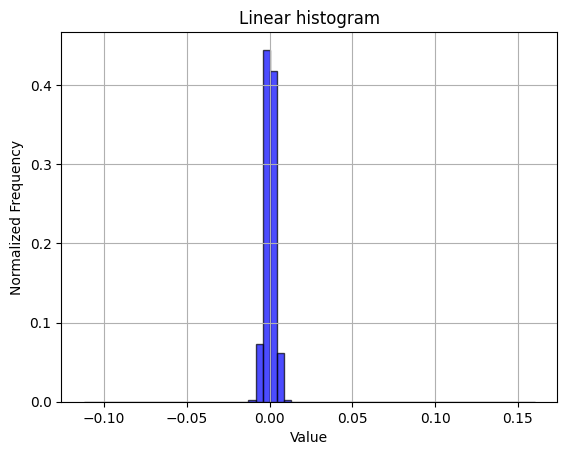

Module: MistralMLP
Operation: MistralMLP(
  (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
  (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
  (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
  (act_fn): SiLU()
)
No weights in this module.
Module: MistralDecoderLayer
Operation: MistralDecoderLayer(
  (self_attn): MistralSdpaAttention(
    (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
    (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
    (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
    (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
    (rotary_emb): MistralRotaryEmbedding()
  )
  (mlp): MistralMLP(
    (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
    (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
    (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
    (act_fn): SiLU()
  )
  (inp

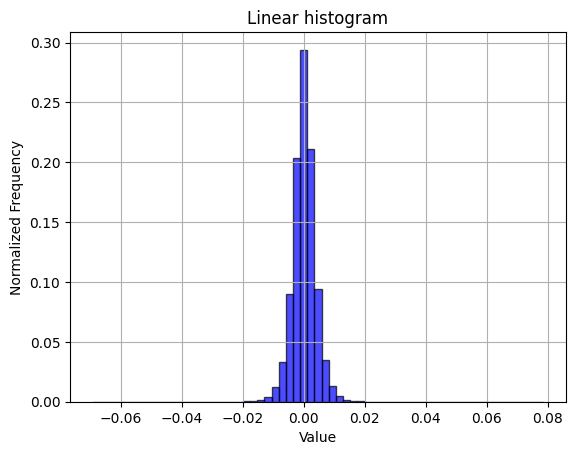

Module: Linear
Operation: Linear(in_features=4096, out_features=1024, bias=False)
[2.38418579e-07 4.76837158e-07 0.00000000e+00 0.00000000e+00
 4.76837158e-07 2.38418579e-07 2.38418579e-07 9.53674316e-07
 2.14576721e-06 2.14576721e-06 3.33786011e-06 4.52995300e-06
 7.39097595e-06 1.00135803e-05 1.40666962e-05 2.45571136e-05
 3.55243683e-05 4.72068787e-05 8.39233398e-05 1.20162964e-04
 2.24351883e-04 3.91483307e-04 8.58545303e-04 1.54829025e-03
 3.03316116e-03 6.12425804e-03 1.16291046e-02 2.13501453e-02
 3.94375324e-02 7.14011192e-02 1.17828369e-01 1.73893929e-01
 1.90017223e-01 1.49685860e-01 9.42215919e-02 5.38773537e-02
 3.01651955e-02 1.63729191e-02 8.30245018e-03 4.45127487e-03
 2.30860710e-03 1.13368034e-03 6.00337982e-04 3.13997269e-04
 1.89542770e-04 1.03235245e-04 6.15119934e-05 4.02927399e-05
 2.59876251e-05 1.45435333e-05 1.12056732e-05 5.48362732e-06
 5.72204590e-06 4.52995300e-06 2.14576721e-06 1.90734863e-06
 1.19209290e-06 9.53674316e-07 1.19209290e-06 9.53674316e-07
 4.

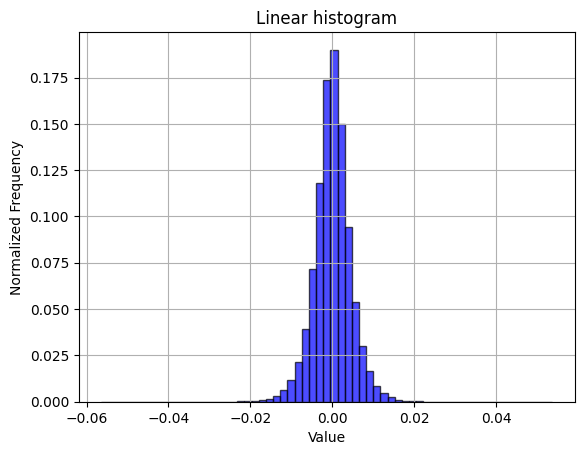

Module: Linear
Operation: Linear(in_features=4096, out_features=1024, bias=False)
[2.38418579e-07 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.38418579e-07
 2.38418579e-07 2.38418579e-07 7.15255737e-07 7.15255737e-07
 1.19209290e-06 9.53674316e-07 2.14576721e-06 3.57627869e-06
 5.24520874e-06 8.10623169e-06 1.64508820e-05 3.98159027e-05
 7.65323639e-05 1.74045563e-04 4.72784042e-04 1.17135048e-03
 2.79259682e-03 6.47592545e-03 1.37076378e-02 2.59549618e-02
 4.87585068e-02 7.99710751e-02 1.16416454e-01 1.49268150e-01
 1.60937786e-01 1.39743090e-01 1.04336739e-01 6.90312386e-02
 4.06823158e-02 2.07695961e-02 1.07016563e-02 4.87256050e-03
 2.09474564e-03 9.01222229e-04 3.40461731e-04 1.42097473e-04
 6.55651093e-05 2.83718109e-05 1.21593475e-05 8.82148743e-06
 4.76837158e-06 2.38418579e-06 4.76837158e-07 1.66893005e-06
 1.43051147e-06 0.00000000e+00 2.38418579e-07 4.76837158e-07
 0.

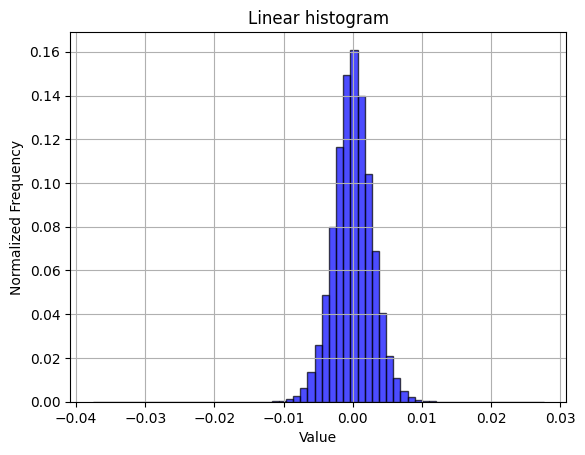

Module: MistralRotaryEmbedding
Operation: MistralRotaryEmbedding()
No weights in this module.
Module: Linear
Operation: Linear(in_features=4096, out_features=4096, bias=False)
[5.96046448e-08 0.00000000e+00 0.00000000e+00 5.96046448e-08
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 5.96046448e-08 0.00000000e+00 5.96046448e-08
 1.78813934e-07 0.00000000e+00 1.78813934e-07 1.19209290e-07
 5.96046448e-08 2.98023224e-07 1.19209290e-07 2.98023224e-07
 3.57627869e-07 5.96046448e-07 9.53674316e-07 1.60932541e-06
 2.62260437e-06 6.31809235e-06 1.26957893e-05 3.49879265e-05
 2.58088112e-04 5.14489412e-03 7.22751617e-02 3.47213209e-01
 4.30957556e-01 1.31128848e-01 1.22928619e-02 5.79476357e-04
 5.68628311e-05 1.54376030e-05 6.73532486e-06 3.15904617e-06
 1.49011612e-06 1.37090683e-06 5.96046448e-07 1.07288361e-06
 2.98023224e-07 2.98023224e-07 2.38418579e-07 1.78813934e-07
 0.00000000e+00 0.00000000e+00 1.19209290e-07 5.96046448e-08
 0.00000000e+00 5.96046448e-08 

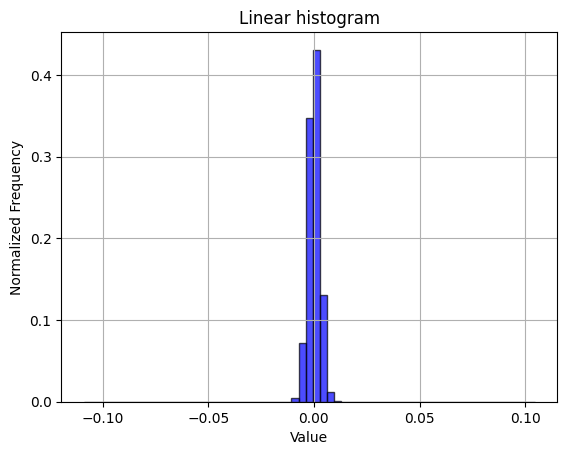

Module: MistralSdpaAttention
Operation: MistralSdpaAttention(
  (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
  (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
  (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
  (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
  (rotary_emb): MistralRotaryEmbedding()
)
No weights in this module.
Module: Linear
Operation: Linear(in_features=4096, out_features=14336, bias=False)
[1.70298985e-08 1.70298985e-08 0.00000000e+00 0.00000000e+00
 0.00000000e+00 3.40597970e-08 0.00000000e+00 5.10896955e-08
 3.40597970e-08 1.02179391e-07 1.19209290e-07 1.02179391e-07
 1.19209290e-07 1.19209290e-07 3.40597970e-07 4.25747463e-07
 5.96046448e-07 1.36239188e-06 1.99249813e-06 3.93390656e-06
 6.42027174e-06 1.13078526e-05 2.52893993e-05 5.57558877e-05
 1.53558595e-04 5.55992126e-04 2.65291759e-03 1.53850998e-02
 7.03603370e-02 2.03846012e-01 3.20847375e-01 2.52342701e-01
 1.02598224e-01 2.5391152

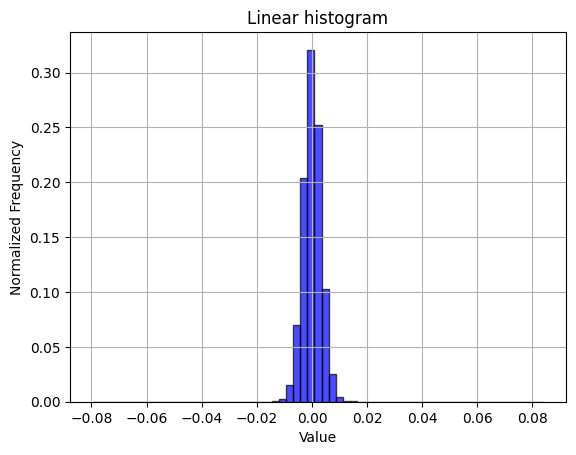

Module: SiLU
Operation: SiLU()
No weights in this module.
Module: Linear
Operation: Linear(in_features=4096, out_features=14336, bias=False)
[1.70298985e-08 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.70298985e-08 3.40597970e-08 1.70298985e-08 0.00000000e+00
 1.70298985e-08 1.70298985e-08 3.40597970e-08 6.81195940e-08
 6.81195940e-08 8.51494925e-08 1.87328884e-07 1.87328884e-07
 1.70298985e-07 2.38418579e-07 6.30106245e-07 8.34465027e-07
 1.66893005e-06 4.58104270e-06 2.06572669e-05 2.76156834e-04
 4.15526118e-03 3.59206370e-02 1.60606878e-01 3.43687892e-01
 3.09204919e-01 1.20633875e-01 2.30668272e-02 2.24789551e-03
 1.48977552e-04 1.39304570e-05 3.49112919e-06 1.41348158e-06
 8.17435128e-07 4.59807260e-07 3.74657767e-07 1.87328884e-07
 8.51494925e-08 1.19209290e-07 5.10896955e-08 5.10896955e-08
 3.40597970e-08 3.40597970e-08 0.00000000e+00 0.00000000e+00
 6.81195940e-08 0.00000000e+00 0.00000000e+00 1.70298985e-08
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

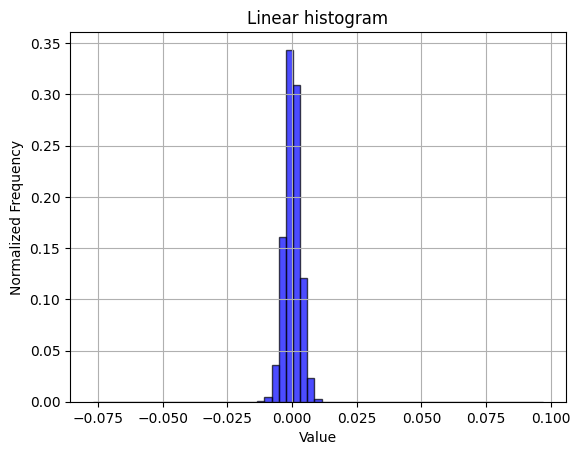

Module: Linear
Operation: Linear(in_features=14336, out_features=4096, bias=False)
[1.70298985e-08 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.70298985e-08 0.00000000e+00
 0.00000000e+00 1.70298985e-08 1.70298985e-08 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40597970e-08
 3.40597970e-08 1.70298985e-08 6.81195940e-08 1.02179391e-07
 5.10896955e-08 1.53269087e-07 3.91687666e-07 3.74657767e-07
 7.15255737e-07 1.56675066e-06 2.99726214e-06 6.79492950e-06
 2.85421099e-05 1.05498518e-03 4.21391385e-02 3.53496041e-01
 4.92026193e-01 1.06855137e-01 4.29349286e-03 7.49996730e-05
 1.00816999e-05 3.59330859e-06 1.94140843e-06 9.36644418e-07
 5.10896955e-07 4.08717564e-07 6.81195940e-08 1.70298985e-07
 3.40597970e-08 8.51494925e-08 6.81195940e-08 1.02179391e-07
 0.00000000e+00 1.70298985e-08 0.00000000e+00 3.40597970e-08
 1

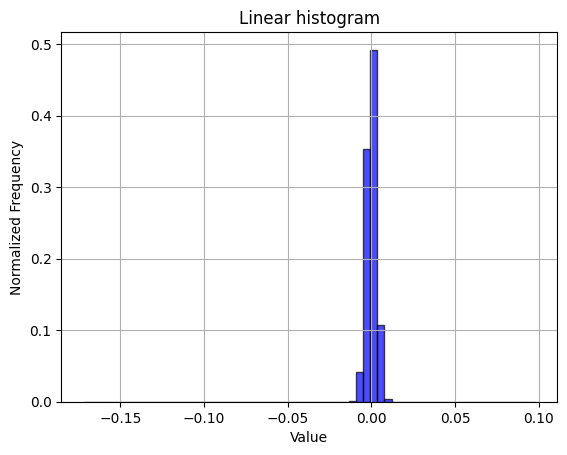

Module: MistralMLP
Operation: MistralMLP(
  (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
  (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
  (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
  (act_fn): SiLU()
)
No weights in this module.
Module: MistralDecoderLayer
Operation: MistralDecoderLayer(
  (self_attn): MistralSdpaAttention(
    (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
    (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
    (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
    (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
    (rotary_emb): MistralRotaryEmbedding()
  )
  (mlp): MistralMLP(
    (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
    (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
    (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
    (act_fn): SiLU()
  )
  (inp

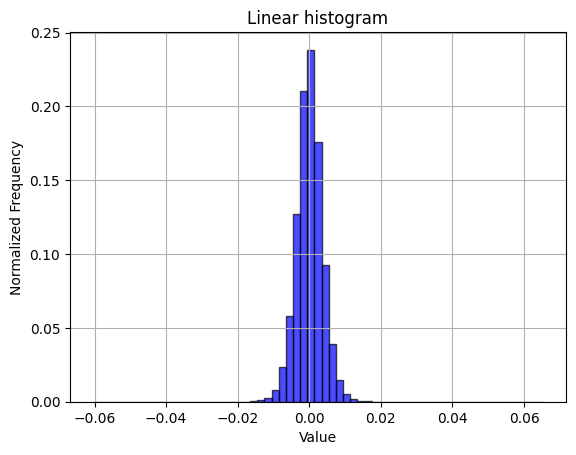

Module: Linear
Operation: Linear(in_features=4096, out_features=1024, bias=False)
[2.38418579e-07 0.00000000e+00 0.00000000e+00 0.00000000e+00
 4.76837158e-07 2.38418579e-07 9.53674316e-07 9.53674316e-07
 9.53674316e-07 1.43051147e-06 1.19209290e-06 2.62260437e-06
 2.86102295e-06 2.86102295e-06 4.76837158e-06 7.39097595e-06
 9.29832458e-06 1.16825104e-05 1.78813934e-05 2.43186951e-05
 3.29017639e-05 5.93662262e-05 1.12295151e-04 2.67505646e-04
 6.04629517e-04 1.63531303e-03 4.19139862e-03 1.04579926e-02
 2.54936218e-02 5.56454659e-02 1.12003803e-01 1.97144032e-01
 2.39279509e-01 1.76849365e-01 9.55114365e-02 4.58483696e-02
 2.04854012e-02 8.71181488e-03 3.28040123e-03 1.29055977e-03
 5.10931015e-04 2.28881836e-04 1.06334686e-04 5.07831573e-05
 3.19480896e-05 1.81198120e-05 1.57356262e-05 1.00135803e-05
 9.05990601e-06 4.05311584e-06 3.33786011e-06 3.33786011e-06
 2.62260437e-06 2.14576721e-06 2.62260437e-06 1.66893005e-06
 9.53674316e-07 7.15255737e-07 9.53674316e-07 0.00000000e+00
 2.

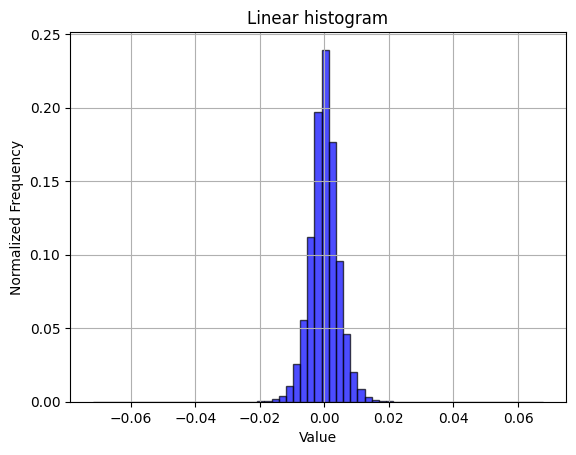

Module: Linear
Operation: Linear(in_features=4096, out_features=1024, bias=False)
[2.38418579e-07 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 9.53674316e-07 4.76837158e-07 1.66893005e-06
 2.38418579e-07 4.76837158e-07 1.90734863e-06 1.43051147e-06
 4.05311584e-06 4.29153442e-06 5.24520874e-06 9.29832458e-06
 1.43051147e-05 2.40802765e-05 3.86238098e-05 8.70227814e-05
 1.58071518e-04 3.30448151e-04 7.02142715e-04 1.42145157e-03
 2.80094147e-03 5.26523590e-03 9.73725319e-03 1.66893005e-02
 2.72467136e-02 4.12433147e-02 5.94661236e-02 7.79349804e-02
 9.89055634e-02 1.13957644e-01 1.20226383e-01 1.09469652e-01
 9.41336155e-02 7.38604069e-02 5.39419651e-02 3.70736122e-02
 2.38556862e-02 1.43418312e-02 8.19349289e-03 4.28867340e-03
 2.29263306e-03 1.15251541e-03 5.46455383e-04 2.78949738e-04
 1.33752823e-04 6.46114349e-05 3.57627869e-05 2.00271606e-05
 1.21593475e-05 7.39097595e-06 5.48362732e-06 3.09944153e-06
 2.86102295e-06 1.43051147e-06 9.53674316e-07 1.43051147e-06
 7.

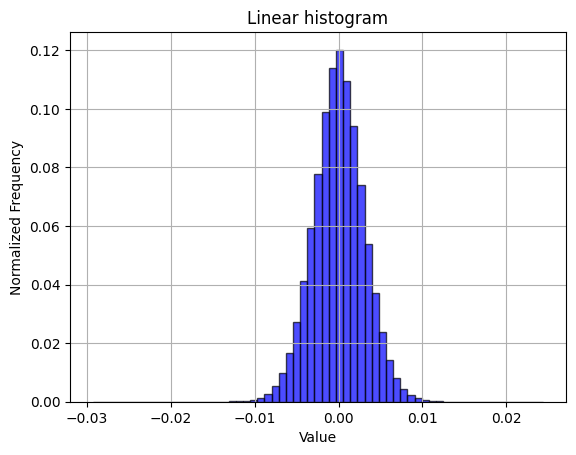

Module: MistralRotaryEmbedding
Operation: MistralRotaryEmbedding()
No weights in this module.
Module: Linear
Operation: Linear(in_features=4096, out_features=4096, bias=False)
[1.19209290e-07 5.96046448e-08 1.19209290e-07 0.00000000e+00
 1.19209290e-07 5.96046448e-08 0.00000000e+00 0.00000000e+00
 1.19209290e-07 3.57627869e-07 3.57627869e-07 5.36441803e-07
 7.15255737e-07 4.76837158e-07 1.19209290e-06 8.94069672e-07
 8.94069672e-07 1.66893005e-06 2.32458115e-06 3.45706940e-06
 4.76837158e-06 8.34465027e-06 1.22785568e-05 2.21729279e-05
 5.90682030e-05 2.70366669e-04 2.16221809e-03 1.84317827e-02
 9.82002616e-02 2.78157771e-01 3.52403104e-01 1.91836238e-01
 4.99968529e-02 7.37965107e-03 8.29935074e-04 1.26779079e-04
 3.56435776e-05 1.71661377e-05 9.11951065e-06 6.37769699e-06
 4.64916229e-06 3.15904617e-06 1.96695328e-06 1.13248825e-06
 1.43051147e-06 7.74860382e-07 7.15255737e-07 4.76837158e-07
 4.17232513e-07 4.76837158e-07 2.98023224e-07 2.38418579e-07
 1.19209290e-07 2.38418579e-07 

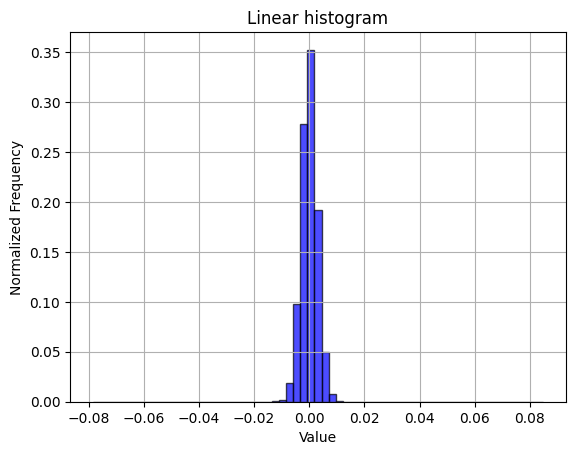

Module: MistralSdpaAttention
Operation: MistralSdpaAttention(
  (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
  (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
  (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
  (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
  (rotary_emb): MistralRotaryEmbedding()
)
No weights in this module.
Module: Linear
Operation: Linear(in_features=4096, out_features=14336, bias=False)
[1.70298985e-08 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.70298985e-08 3.40597970e-08 0.00000000e+00
 1.70298985e-08 1.70298985e-08 3.40597970e-08 5.10896955e-08
 6.81195940e-08 3.40597970e-08 1.02179391e-07 1.02179391e-07
 1.36239188e-07 2.55448478e-07 5.27926854e-07 7.49315534e-07
 9.36644418e-07 2.09467752e-06 3.52518899e-06 7.52721514e-06
 1.30278724e-05 3.52008002e-05 1.12346240e-04 4.97273036e-04
 3.16984313e-03 2.17917987e-02 1.04181375e-01 2.74107797e-01
 3.41326662e-01 1.9068256

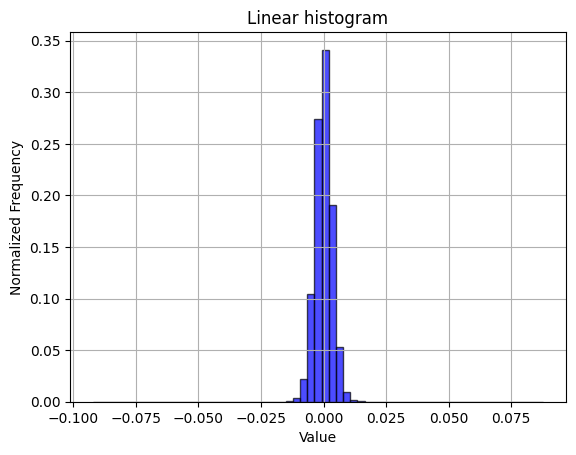

Module: SiLU
Operation: SiLU()
No weights in this module.
Module: Linear
Operation: Linear(in_features=4096, out_features=14336, bias=False)
[1.70298985e-08 0.00000000e+00 1.70298985e-08 0.00000000e+00
 3.40597970e-08 0.00000000e+00 5.10896955e-08 1.70298985e-08
 8.51494925e-08 5.10896955e-08 5.10896955e-08 1.02179391e-07
 1.36239188e-07 1.70298985e-07 3.40597970e-07 4.93867057e-07
 9.02584621e-07 2.53745488e-06 6.89710890e-06 6.01496015e-05
 1.11745085e-03 1.51963404e-02 9.94198833e-02 2.98559904e-01
 3.65121245e-01 1.78770031e-01 3.77060175e-02 3.79397188e-03
 2.21184322e-04 1.50203705e-05 3.54221889e-06 1.17506300e-06
 8.17435128e-07 3.23568072e-07 2.89508275e-07 2.04358782e-07
 1.70298985e-07 5.10896955e-08 5.10896955e-08 6.81195940e-08
 1.70298985e-08 6.81195940e-08 0.00000000e+00 5.10896955e-08
 0.00000000e+00 3.40597970e-08 1.70298985e-08 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

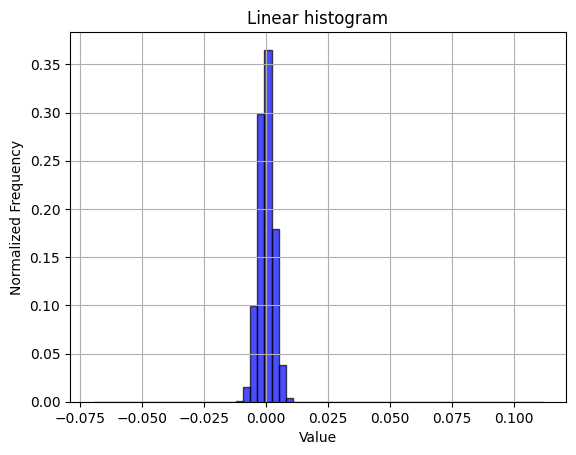

Module: Linear
Operation: Linear(in_features=14336, out_features=4096, bias=False)
[3.40597970e-08 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.70298985e-08 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.70298985e-08 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40597970e-08
 1.70298985e-08 0.00000000e+00 1.70298985e-08 0.00000000e+00
 3.40597970e-08 1.70298985e-08 1.70298985e-08 6.81195940e-08
 6.81195940e-08 1.19209290e-07 1.36239188e-07 1.36239188e-07
 2.38418579e-07 1.70298985e-07 5.44956752e-07 1.00476401e-06
 1.78813934e-06 4.58104270e-06 1.22274671e-05 1.51480947e-04
 1.13558940e-02 2.01686144e-01 5.62719345e-01 2.11623788e-01
 1.22538294e-02 1.67931829e-04 1.17336001e-05 3.95093645e-06
 1.92437853e-06 9.70704215e-07 6.30106245e-07 3.40597970e-07
 3.23568072e-07 1.02179391e-07 6.81195940e-08 6.81195940e-08
 3.40597970e-08 1.70298985e-08 1.70298985e-08 3.40597970e-08
 6

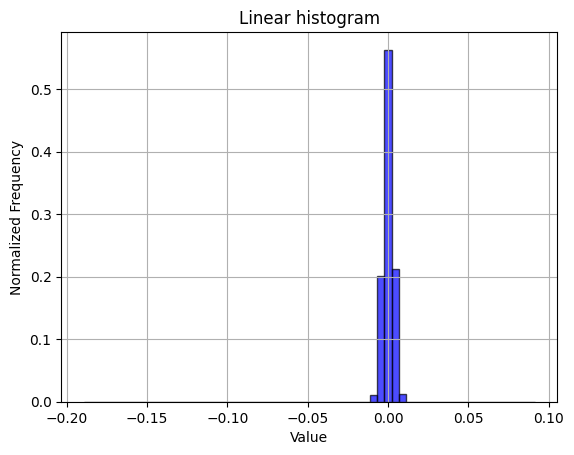

Module: MistralMLP
Operation: MistralMLP(
  (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
  (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
  (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
  (act_fn): SiLU()
)
No weights in this module.
Module: MistralDecoderLayer
Operation: MistralDecoderLayer(
  (self_attn): MistralSdpaAttention(
    (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
    (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
    (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
    (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
    (rotary_emb): MistralRotaryEmbedding()
  )
  (mlp): MistralMLP(
    (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
    (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
    (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
    (act_fn): SiLU()
  )
  (inp

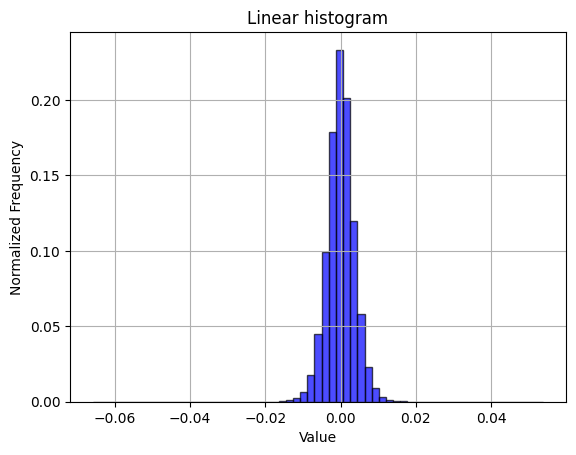

Module: Linear
Operation: Linear(in_features=4096, out_features=1024, bias=False)
[2.38418579e-07 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 9.53674316e-07
 7.15255737e-07 4.76837158e-07 4.76837158e-07 1.66893005e-06
 1.43051147e-06 1.43051147e-06 2.38418579e-06 3.33786011e-06
 4.05311584e-06 6.67572021e-06 9.05990601e-06 1.14440918e-05
 1.74045563e-05 3.40938568e-05 4.36306000e-05 8.17775726e-05
 1.54495239e-04 3.09228897e-04 8.08000565e-04 1.95455551e-03
 5.23829460e-03 1.22697353e-02 2.90756226e-02 6.17640018e-02
 1.19659901e-01 1.88101053e-01 2.16912985e-01 1.71575546e-01
 1.00813866e-01 5.09727001e-02 2.34706402e-02 9.87553596e-03
 4.05025482e-03 1.56235695e-03 6.17504120e-04 2.68220901e-04
 1.32799149e-04 6.29425049e-05 4.26769257e-05 2.74181366e-05
 1.71661377e-05 1.02519989e-05 8.58306885e-06 5.72204590e-06
 4.05311584e-06 3.33786011e-06 1.90734863e-06 1.19209290e-06
 1.90734863e-06 1.90734863e-06 1.19209290e-06 0.00000000e+00
 2.

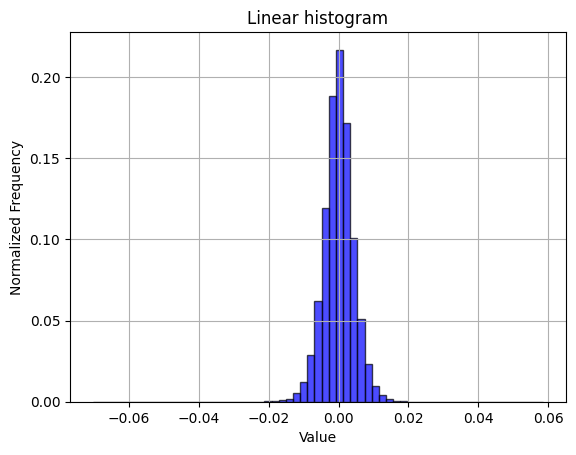

Module: Linear
Operation: Linear(in_features=4096, out_features=1024, bias=False)
[2.38418579e-07 0.00000000e+00 2.38418579e-07 0.00000000e+00
 7.15255737e-07 7.15255737e-07 9.53674316e-07 1.19209290e-06
 2.14576721e-06 3.09944153e-06 4.52995300e-06 9.29832458e-06
 1.43051147e-05 3.02791595e-05 5.36441803e-05 1.10626221e-04
 2.00986862e-04 3.44514847e-04 6.34670258e-04 1.09791756e-03
 1.88446045e-03 3.18789482e-03 5.26046753e-03 8.61167908e-03
 1.35414600e-02 2.03375816e-02 2.96113491e-02 4.06932831e-02
 5.46536446e-02 6.87212944e-02 8.21340084e-02 9.28978920e-02
 1.01221323e-01 9.77430344e-02 8.87882710e-02 7.55765438e-02
 6.19728565e-02 4.76138592e-02 3.45964432e-02 2.47039795e-02
 1.65312290e-02 1.07419491e-02 6.70695305e-03 4.03738022e-03
 2.46953964e-03 1.42216682e-03 8.08000565e-04 4.54187393e-04
 2.56061554e-04 1.41620636e-04 7.70092010e-05 4.07695770e-05
 2.31266022e-05 1.09672546e-05 7.86781311e-06 3.33786011e-06
 3.81469727e-06 9.53674316e-07 2.38418579e-07 1.19209290e-06
 0.

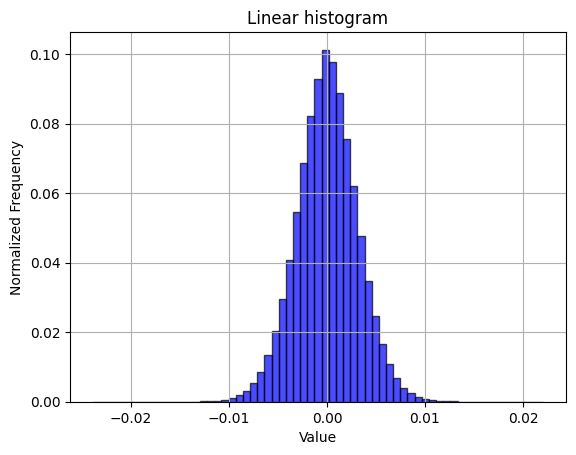

Module: MistralRotaryEmbedding
Operation: MistralRotaryEmbedding()
No weights in this module.
Module: Linear
Operation: Linear(in_features=4096, out_features=4096, bias=False)
[5.96046448e-08 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 5.96046448e-08 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 5.96046448e-08
 0.00000000e+00 1.19209290e-07 0.00000000e+00 1.19209290e-07
 1.78813934e-07 2.38418579e-07 2.98023224e-07 4.76837158e-07
 6.55651093e-07 1.07288361e-06 1.19209290e-06 2.62260437e-06
 4.70876694e-06 8.94069672e-06 2.07424164e-05 5.50746918e-05
 3.57210636e-04 4.05567884e-03 3.71056199e-02 1.82190418e-01
 3.76855850e-01 2.94482350e-01 9.04788971e-02 1.30146742e-02
 1.17129087e-03 1.33335590e-04 3.02195549e-05 1.18017197e-05
 6.25848770e-06 3.93390656e-06 2.26497650e-06 1.19209290e-06
 7.15255737e-07 4.17232513e-07 4.17232513e-07 1.19209290e-07
 2.38418579e-07 5.96046448e-08 

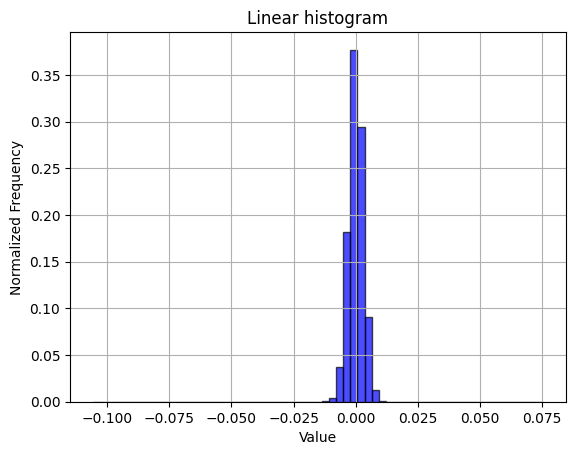

Module: MistralSdpaAttention
Operation: MistralSdpaAttention(
  (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
  (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
  (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
  (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
  (rotary_emb): MistralRotaryEmbedding()
)
No weights in this module.
Module: Linear
Operation: Linear(in_features=4096, out_features=14336, bias=False)
[1.70298985e-08 0.00000000e+00 1.70298985e-08 5.10896955e-08
 3.40597970e-08 5.10896955e-08 1.70298985e-08 8.51494925e-08
 1.02179391e-07 1.19209290e-07 1.02179391e-07 1.53269087e-07
 3.23568072e-07 3.74657767e-07 7.32285636e-07 9.19614519e-07
 1.46457127e-06 2.28200640e-06 3.89984676e-06 6.84601920e-06
 1.39134271e-05 3.90325274e-05 1.22683389e-04 4.93850027e-04
 2.44639601e-03 1.13650560e-02 4.42734276e-02 1.24234285e-01
 2.31596742e-01 2.68495866e-01 1.92367996e-01 8.87062379e-02
 2.75225980e-02 6.5714802

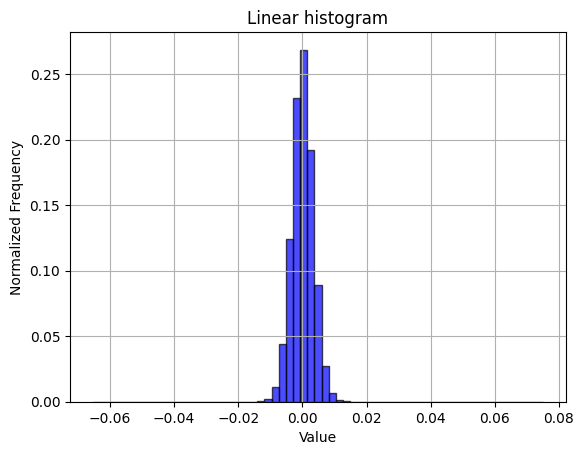

Module: SiLU
Operation: SiLU()
No weights in this module.
Module: Linear
Operation: Linear(in_features=4096, out_features=14336, bias=False)
[6.81195940e-08 3.40597970e-08 3.40597970e-08 1.02179391e-07
 1.02179391e-07 1.19209290e-07 2.72478376e-07 5.10896955e-07
 9.19614519e-07 1.61784036e-06 3.33786011e-06 1.42710549e-05
 1.33258956e-04 1.57153606e-03 1.35106870e-02 6.79823841e-02
 1.93978650e-01 3.08748143e-01 2.60201437e-01 1.18080224e-01
 3.07181733e-02 4.56648214e-03 4.41755567e-04 3.47750528e-05
 6.01155417e-06 2.06061772e-06 1.22615269e-06 5.44956752e-07
 5.27926854e-07 1.70298985e-07 2.04358782e-07 8.51494925e-08
 6.81195940e-08 3.40597970e-08 0.00000000e+00 5.10896955e-08
 0.00000000e+00 1.70298985e-08 1.70298985e-08 0.00000000e+00
 1.70298985e-08 0.00000000e+00 1.70298985e-08 1.70298985e-08
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.70298985e-08 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

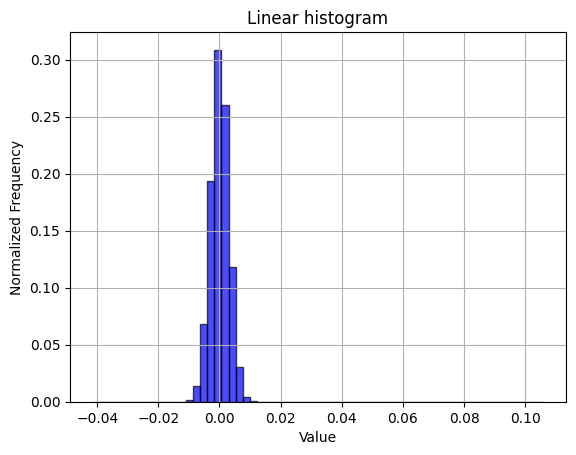

Module: Linear
Operation: Linear(in_features=14336, out_features=4096, bias=False)
[1.70298985e-08 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.70298985e-08 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.70298985e-08
 0.00000000e+00 1.70298985e-08 1.70298985e-08 1.70298985e-08
 1.70298985e-08 3.40597970e-08 1.70298985e-08 6.81195940e-08
 3.40597970e-08 3.40597970e-08 1.19209290e-07 1.87328884e-07
 2.55448478e-07 5.96046448e-07 1.02179391e-06 2.80993325e-06
 7.16958727e-06 1.33565494e-04 8.79044192e-03 1.48127096e-01
 5.04735896e-01 3.02683370e-01 3.46443483e-02 8.47441810e-04
 1.80857522e-05 4.12123544e-06 1.31130219e-06 6.81195940e-07
 3.91687666e-07 2.55448478e-07 2.21388681e-07 6.81195940e-08
 8.51494925e-08 5.10896955e-08 3.40597970e-08 3.40597970e-08
 0

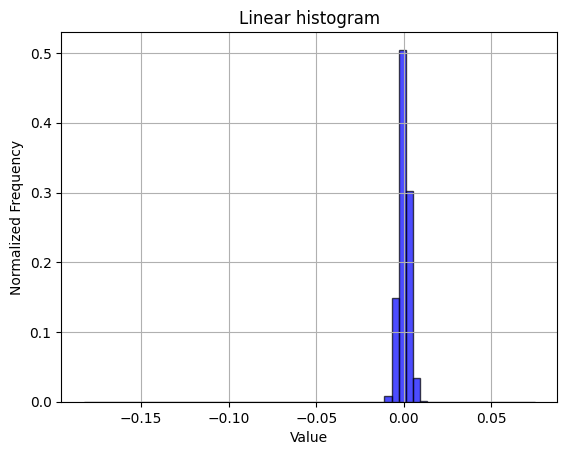

Module: MistralMLP
Operation: MistralMLP(
  (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
  (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
  (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
  (act_fn): SiLU()
)
No weights in this module.
Module: MistralDecoderLayer
Operation: MistralDecoderLayer(
  (self_attn): MistralSdpaAttention(
    (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
    (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
    (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
    (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
    (rotary_emb): MistralRotaryEmbedding()
  )
  (mlp): MistralMLP(
    (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
    (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
    (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
    (act_fn): SiLU()
  )
  (inp

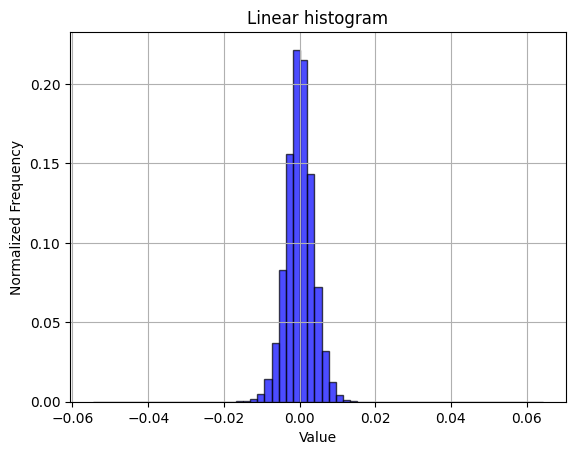

Module: Linear
Operation: Linear(in_features=4096, out_features=1024, bias=False)
[7.15255737e-07 2.38418579e-07 2.38418579e-07 7.15255737e-07
 7.15255737e-07 9.53674316e-07 9.53674316e-07 1.19209290e-06
 1.66893005e-06 2.62260437e-06 3.09944153e-06 5.00679016e-06
 4.29153442e-06 1.00135803e-05 1.19209290e-05 2.09808350e-05
 3.38554382e-05 4.74452972e-05 8.34465027e-05 1.83343887e-04
 4.17947769e-04 1.21784210e-03 3.24821472e-03 8.49747658e-03
 1.93881989e-02 4.49869633e-02 8.98106098e-02 1.56272650e-01
 2.13355541e-01 1.99114084e-01 1.33070230e-01 7.10041523e-02
 3.42757702e-02 1.50179863e-02 5.97620010e-03 2.38347054e-03
 8.76188278e-04 3.39984894e-04 1.41143799e-04 6.60419464e-05
 3.95774841e-05 2.55107880e-05 1.66893005e-05 1.14440918e-05
 9.53674316e-06 3.81469727e-06 5.96046448e-06 3.33786011e-06
 2.38418579e-06 2.62260437e-06 7.15255737e-07 4.76837158e-07
 9.53674316e-07 2.38418579e-07 2.38418579e-07 7.15255737e-07
 2.38418579e-07 4.76837158e-07 4.76837158e-07 2.38418579e-07
 0.

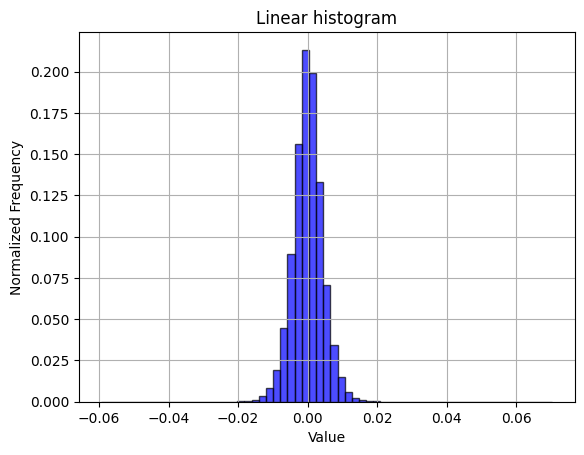

Module: Linear
Operation: Linear(in_features=4096, out_features=1024, bias=False)
[2.38418579e-07 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 2.38418579e-07 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.38418579e-07
 4.76837158e-07 7.15255737e-07 1.43051147e-06 1.90734863e-06
 5.00679016e-06 6.43730164e-06 2.02655792e-05 3.33786011e-05
 7.05718994e-05 1.22785568e-04 2.70605087e-04 5.29050827e-04
 1.19543076e-03 2.15697289e-03 4.20284271e-03 7.88235664e-03
 1.38628483e-02 2.30886936e-02 3.60884666e-02 5.25994301e-02
 7.21826553e-02 9.09845829e-02 1.08502626e-01 1.19413614e-01
 1.14124537e-01 9.92920399e-02 8.11297894e-02 6.13086224e-02
 4.30753231e-02 2.85804272e-02 1.75397396e-02 1.02188587e-02
 5.41710854e-03 3.11231613e-03 1.49989128e-03 7.80105591e-04
 3.50952148e-04 1.79767609e-04 8.13007355e-05 3.74317169e-05
 2.24113464e-05 1.23977661e-05 7.62939453e-06 2.14576721e-06
 7.15255737e-07 7.15255737e-07 9.53674316e-07 2.38418579e-07
 4.

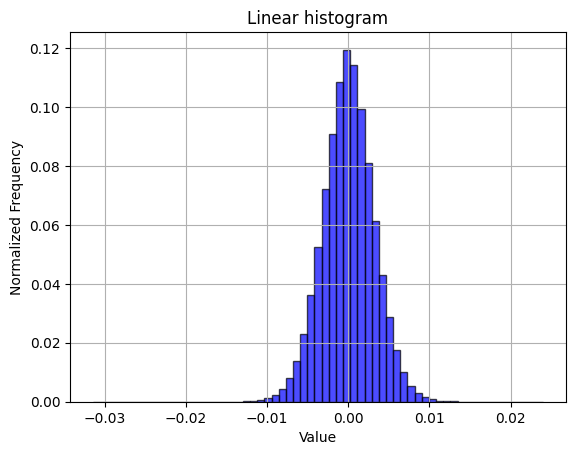

Module: MistralRotaryEmbedding
Operation: MistralRotaryEmbedding()
No weights in this module.
Module: Linear
Operation: Linear(in_features=4096, out_features=4096, bias=False)
[5.96046448e-08 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 5.96046448e-08 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 5.96046448e-08 1.19209290e-07 0.00000000e+00
 1.78813934e-07 0.00000000e+00 5.96046448e-08 1.19209290e-07
 1.19209290e-07 2.98023224e-07 2.98023224e-07 2.38418579e-07
 7.15255737e-07 1.60932541e-06 4.94718552e-06 1.41859055e-05
 1.94787979e-04 4.18055058e-03 5.01343012e-02 2.32702434e-01
 4.05762911e-01 2.46663630e-01 5.50185442e-02 5.04648685e-03
 2.46882439e-04 1.67489052e-05 4.88758087e-06 2.20537186e-06
 1.01327896e-06 2.38418579e-07 

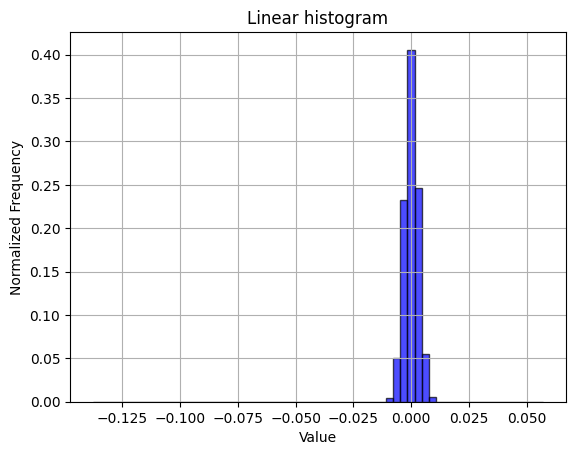

Module: MistralSdpaAttention
Operation: MistralSdpaAttention(
  (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
  (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
  (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
  (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
  (rotary_emb): MistralRotaryEmbedding()
)
No weights in this module.
Module: Linear
Operation: Linear(in_features=4096, out_features=14336, bias=False)
[3.40597970e-08 3.40597970e-08 0.00000000e+00 0.00000000e+00
 1.70298985e-08 0.00000000e+00 1.70298985e-08 1.70298985e-08
 0.00000000e+00 6.81195940e-08 8.51494925e-08 1.36239188e-07
 2.04358782e-07 2.21388681e-07 6.98225839e-07 1.02179391e-06
 1.77110944e-06 2.53745488e-06 5.07490976e-06 1.13589423e-05
 3.19310597e-05 1.50697572e-04 9.99995640e-04 7.13224070e-03
 3.82921185e-02 1.32985592e-01 2.70103591e-01 2.98241581e-01
 1.77871874e-01 5.96777882e-02 1.22703484e-02 1.86547211e-03
 2.70775386e-04 5.1770891

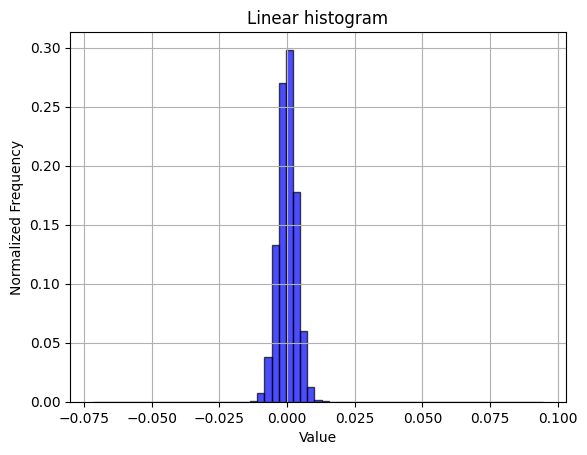

Module: SiLU
Operation: SiLU()
No weights in this module.
Module: Linear
Operation: Linear(in_features=4096, out_features=14336, bias=False)
[1.70298985e-08 1.70298985e-08 0.00000000e+00 0.00000000e+00
 1.70298985e-08 0.00000000e+00 3.40597970e-08 3.40597970e-08
 1.70298985e-08 1.70298985e-08 6.81195940e-08 3.40597970e-08
 1.02179391e-07 5.10896955e-08 1.70298985e-07 2.38418579e-07
 3.23568072e-07 5.10896955e-07 9.87734113e-07 1.83922904e-06
 4.18935503e-06 2.64814922e-05 3.10795648e-04 3.01662513e-03
 2.00441395e-02 8.10379301e-02 1.99986543e-01 2.89355329e-01
 2.43323684e-01 1.20091966e-01 3.54559762e-02 6.51243755e-03
 7.53453800e-04 6.33171626e-05 7.39097595e-06 2.28200640e-06
 1.36239188e-06 7.15255737e-07 2.72478376e-07 1.87328884e-07
 1.53269087e-07 3.40597970e-08 3.40597970e-08 1.70298985e-08
 0.00000000e+00 3.40597970e-08 3.40597970e-08 1.70298985e-08
 0.00000000e+00 0.00000000e+00 1.70298985e-08 1.70298985e-08
 3.40597970e-08 1.70298985e-08 0.00000000e+00 1.70298985e-08
 0.00

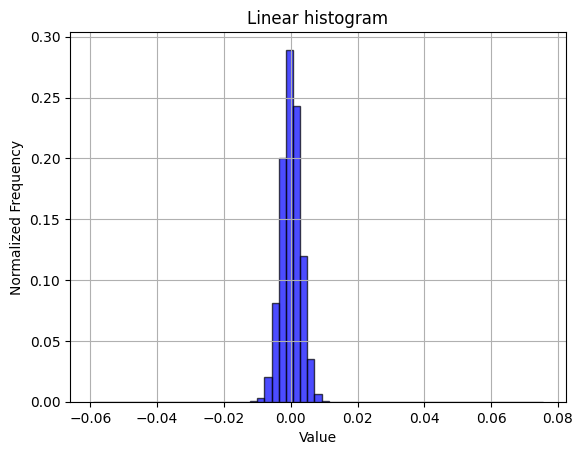

Module: Linear
Operation: Linear(in_features=14336, out_features=4096, bias=False)
[1.70298985e-08 0.00000000e+00 1.70298985e-08 0.00000000e+00
 1.70298985e-08 1.70298985e-08 0.00000000e+00 1.70298985e-08
 1.70298985e-08 0.00000000e+00 0.00000000e+00 1.70298985e-08
 0.00000000e+00 5.10896955e-08 0.00000000e+00 3.40597970e-08
 6.81195940e-08 1.19209290e-07 2.55448478e-07 5.10896955e-07
 1.02179391e-06 4.68322209e-06 1.77315303e-04 2.47426544e-02
 3.77229656e-01 5.29256821e-01 6.77149977e-02 8.61491476e-04
 7.33988626e-06 1.39645168e-06 5.10896955e-07 3.23568072e-07
 2.55448478e-07 8.51494925e-08 3.40597970e-08 5.10896955e-08
 8.51494925e-08 0.00000000e+00 3.40597970e-08 1.70298985e-08
 1.70298985e-08 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.70298985e-08 0.00000000e+00 1.70298985e-08 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0

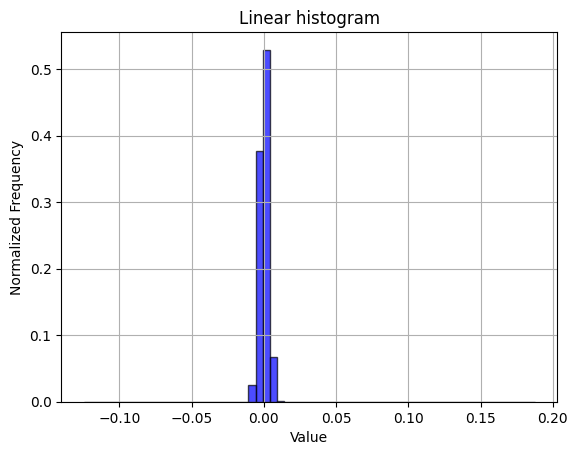

Module: MistralMLP
Operation: MistralMLP(
  (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
  (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
  (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
  (act_fn): SiLU()
)
No weights in this module.
Module: MistralDecoderLayer
Operation: MistralDecoderLayer(
  (self_attn): MistralSdpaAttention(
    (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
    (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
    (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
    (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
    (rotary_emb): MistralRotaryEmbedding()
  )
  (mlp): MistralMLP(
    (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
    (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
    (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
    (act_fn): SiLU()
  )
  (inp

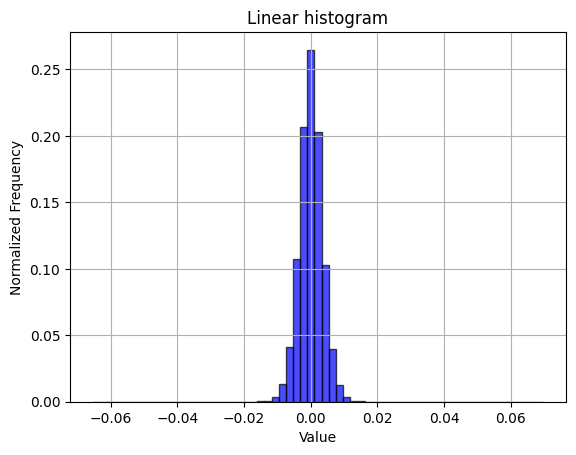

Module: Linear
Operation: Linear(in_features=4096, out_features=1024, bias=False)
[4.76837158e-07 0.00000000e+00 4.76837158e-07 4.76837158e-07
 2.38418579e-07 7.15255737e-07 2.38418579e-07 7.15255737e-07
 1.19209290e-06 7.15255737e-07 1.90734863e-06 5.00679016e-06
 3.09944153e-06 3.81469727e-06 1.04904175e-05 1.31130219e-05
 2.09808350e-05 3.17096710e-05 4.79221344e-05 9.34600830e-05
 1.97410583e-04 4.87804413e-04 1.13320351e-03 3.03506851e-03
 7.62796402e-03 1.84948444e-02 4.26623821e-02 8.84032249e-02
 1.56532049e-01 2.13445902e-01 2.01867819e-01 1.35005236e-01
 7.28826523e-02 3.40816975e-02 1.40614510e-02 5.90062141e-03
 2.35557556e-03 8.77380371e-04 3.59535217e-04 1.55687332e-04
 7.67707825e-05 4.31537628e-05 2.45571136e-05 1.38282776e-05
 8.82148743e-06 9.53674316e-06 3.81469727e-06 3.09944153e-06
 4.29153442e-06 1.66893005e-06 1.43051147e-06 2.14576721e-06
 2.38418579e-07 9.53674316e-07 2.38418579e-07 2.38418579e-07
 0.00000000e+00 2.38418579e-07 2.38418579e-07 0.00000000e+00
 2.

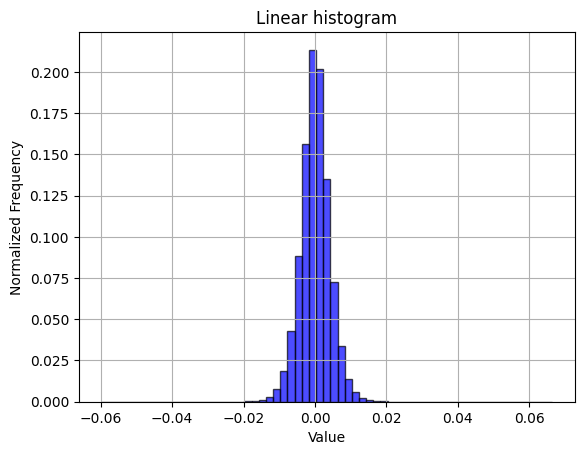

Module: Linear
Operation: Linear(in_features=4096, out_features=1024, bias=False)
[2.38418579e-07 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.38418579e-07 0.00000000e+00 1.90734863e-06 1.43051147e-06
 4.29153442e-06 3.57627869e-06 9.53674316e-06 1.52587891e-05
 3.00407410e-05 5.03063202e-05 8.46385956e-05 1.59502029e-04
 3.22818756e-04 6.16550446e-04 9.81092453e-04 1.90162659e-03
 3.22604179e-03 5.73873520e-03 8.58592987e-03 1.38723850e-02
 2.06663609e-02 2.79052258e-02 3.93784046e-02 5.19993305e-02
 6.29425049e-02 7.52122402e-02 8.57899189e-02 9.19437408e-02
 9.33620930e-02 8.62960815e-02 7.72471428e-02 6.65690899e-02
 5.29417992e-02 4.07848358e-02 3.12056541e-02 2.19137669e-02
 1.42343044e-02 9.69052315e-03 6.18577003e-03 3.49712372e-03
 1.95288658e-03 1.23357773e-03 6.71625137e-04 3.58581543e-04
 1.94072723e-04 9.84668732e-05 5.03063202e-05 2.98023224e-05
 1.64508820e-05 8.34465027e-06 4.76837158e-06 3.81469727e-06
 2.86102295e-06 7.15255737e-07 2.38418579e-07 0.00000000e+00
 2.

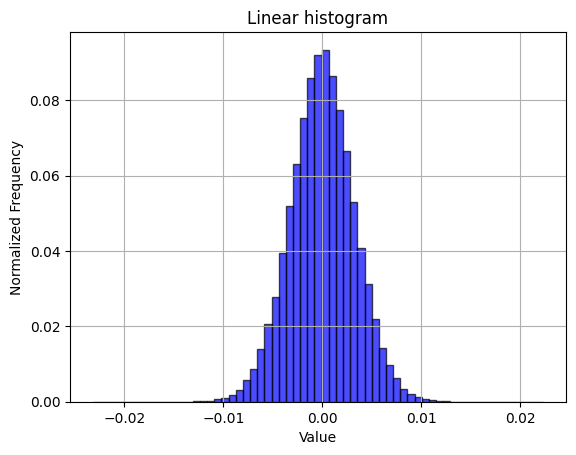

Module: MistralRotaryEmbedding
Operation: MistralRotaryEmbedding()
No weights in this module.
Module: Linear
Operation: Linear(in_features=4096, out_features=4096, bias=False)
[5.96046448e-08 0.00000000e+00 0.00000000e+00 1.19209290e-07
 1.19209290e-07 0.00000000e+00 1.78813934e-07 4.17232513e-07
 5.96046448e-07 7.74860382e-07 2.38418579e-06 4.94718552e-06
 9.71555710e-06 2.15172768e-05 9.00626183e-05 8.61167908e-04
 9.96315479e-03 7.15242028e-02 2.41761982e-01 3.65331829e-01
 2.33981550e-01 6.62783980e-02 9.27275419e-03 7.73310661e-04
 7.98106194e-05 2.19941139e-05 9.83476639e-06 5.00679016e-06
 1.72853470e-06 8.94069672e-07 7.15255737e-07 1.19209290e-07
 1.19209290e-07 5.96046448e-08 5.96046448e-08 5.96046448e-08
 0.00000000e+00 0.00000000e+00 5.96046448e-08 0.00000000e+00
 0.00000000e+00 5.96046448e-08 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 5.96046448e-08 0.00000000e+00 0.00000000e+00 0.00000000e+00
 5.96046448e-08 0.00000000e+00 

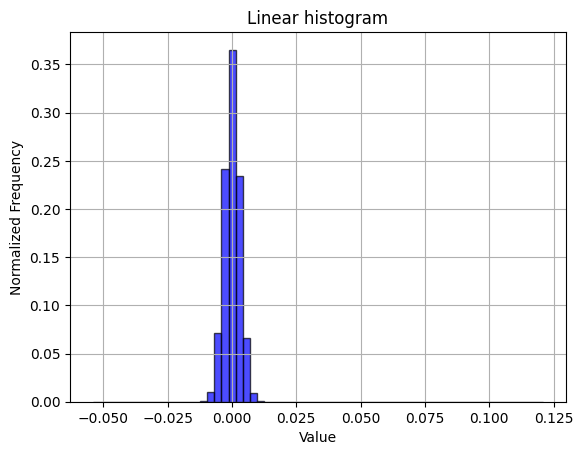

Module: MistralSdpaAttention
Operation: MistralSdpaAttention(
  (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
  (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
  (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
  (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
  (rotary_emb): MistralRotaryEmbedding()
)
No weights in this module.
Module: Linear
Operation: Linear(in_features=4096, out_features=14336, bias=False)
[3.40597970e-08 0.00000000e+00 1.70298985e-08 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 8.51494925e-08
 1.70298985e-08 0.00000000e+00 8.51494925e-08 5.10896955e-08
 1.36239188e-07 1.19209290e-07 2.55448478e-07 2.55448478e-07
 5.27926854e-07 5.96046448e-07 9.02584621e-07 1.83922904e-06
 2.16279711e-06 3.66142818e-06 6.64166042e-06 1.47819519e-05
 3.57968467e-05 1.36971474e-04 6.01155417e-04 2.90853637e-03
 1.17227861e-02 3.89967476e-02 9.72585848e-02 1.80059143e-01
 2.32327683e-01 2.1157344

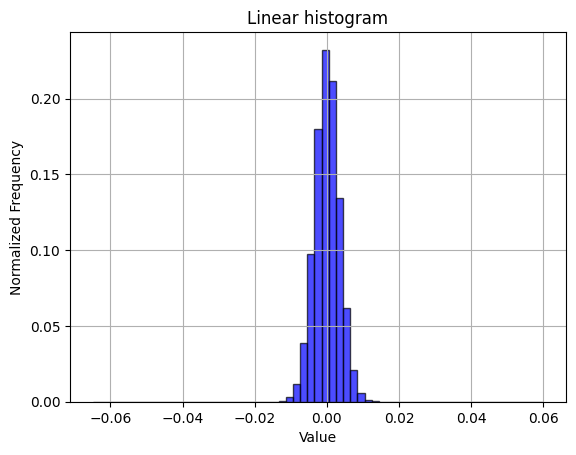

Module: SiLU
Operation: SiLU()
No weights in this module.
Module: Linear
Operation: Linear(in_features=4096, out_features=14336, bias=False)
[3.40597970e-08 0.00000000e+00 1.70298985e-08 0.00000000e+00
 1.70298985e-08 0.00000000e+00 6.81195940e-08 6.81195940e-08
 1.02179391e-07 1.53269087e-07 2.04358782e-07 2.38418579e-07
 4.76837158e-07 4.76837158e-07 6.30106245e-07 1.43051147e-06
 2.48636518e-06 6.06264387e-06 3.36170197e-05 2.15309007e-04
 1.24319962e-03 5.69493430e-03 2.14275292e-02 5.80930880e-02
 1.21916533e-01 1.91617421e-01 2.19358938e-01 1.85035314e-01
 1.16534693e-01 5.33833674e-02 1.89815930e-02 5.20334925e-03
 1.03448118e-03 1.74369131e-04 2.73840768e-05 6.24997275e-06
 2.23091670e-06 1.43051147e-06 7.15255737e-07 5.96046448e-07
 4.25747463e-07 1.87328884e-07 1.02179391e-07 1.70298985e-07
 5.10896955e-08 1.70298985e-08 8.51494925e-08 5.10896955e-08
 1.70298985e-08 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.70298985e-08 1.70298985e-08 1.70298985e-08
 0.00

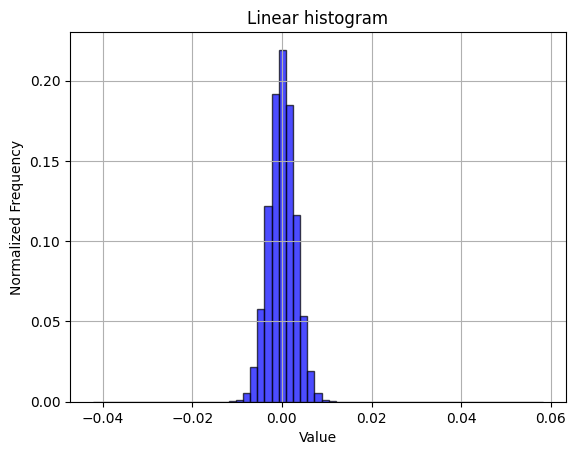

Module: Linear
Operation: Linear(in_features=14336, out_features=4096, bias=False)
[1.70298985e-08 0.00000000e+00 0.00000000e+00 1.70298985e-08
 0.00000000e+00 1.70298985e-08 1.70298985e-08 3.40597970e-08
 6.81195940e-08 8.51494925e-08 5.10896955e-08 1.70298985e-08
 8.51494925e-08 2.21388681e-07 2.38418579e-07 4.25747463e-07
 1.32833208e-06 4.58104270e-06 1.28797122e-04 1.04697432e-02
 1.69882604e-01 5.22263680e-01 2.70780325e-01 2.59885788e-02
 4.67334475e-04 8.12326159e-06 1.80516924e-06 7.32285636e-07
 3.74657767e-07 2.04358782e-07 1.70298985e-07 6.81195940e-08
 1.70298985e-08 5.10896955e-08 8.51494925e-08 5.10896955e-08
 0.00000000e+00 0.00000000e+00 1.70298985e-08 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.70298985e-08 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0

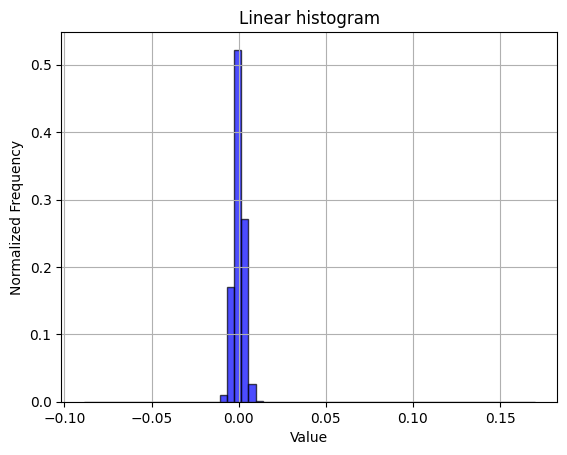

Module: MistralMLP
Operation: MistralMLP(
  (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
  (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
  (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
  (act_fn): SiLU()
)
No weights in this module.
Module: MistralDecoderLayer
Operation: MistralDecoderLayer(
  (self_attn): MistralSdpaAttention(
    (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
    (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
    (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
    (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
    (rotary_emb): MistralRotaryEmbedding()
  )
  (mlp): MistralMLP(
    (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
    (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
    (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
    (act_fn): SiLU()
  )
  (inp

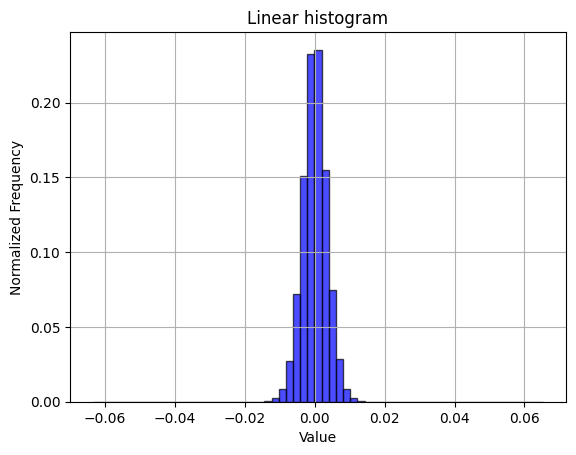

Module: Linear
Operation: Linear(in_features=4096, out_features=1024, bias=False)
[4.76837158e-07 0.00000000e+00 2.38418579e-07 2.38418579e-07
 2.38418579e-07 4.76837158e-07 0.00000000e+00 7.15255737e-07
 1.19209290e-06 9.53674316e-07 1.19209290e-06 2.86102295e-06
 3.33786011e-06 5.48362732e-06 7.86781311e-06 1.33514404e-05
 2.45571136e-05 3.36170197e-05 5.53131104e-05 1.03235245e-04
 2.35319138e-04 5.57184219e-04 1.48105621e-03 3.91817093e-03
 9.72962379e-03 2.24089622e-02 4.72531319e-02 9.06701088e-02
 1.53171301e-01 2.11011171e-01 1.94519281e-01 1.29197121e-01
 7.15405941e-02 3.62665653e-02 1.63831711e-02 6.90960884e-03
 2.67934799e-03 1.03282928e-03 4.15086746e-04 1.59025192e-04
 7.43865967e-05 4.64916229e-05 3.02791595e-05 1.76429749e-05
 1.26361847e-05 7.62939453e-06 5.96046448e-06 3.57627869e-06
 2.86102295e-06 7.15255737e-07 1.43051147e-06 4.76837158e-07
 2.38418579e-07 7.15255737e-07 0.00000000e+00 0.00000000e+00
 2.38418579e-07 0.00000000e+00 2.38418579e-07 2.38418579e-07
 0.

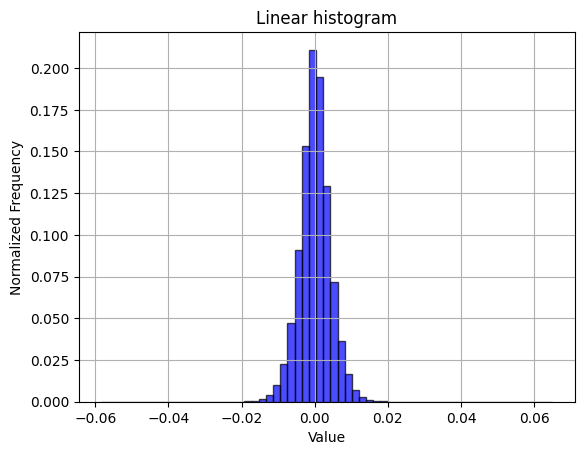

Module: Linear
Operation: Linear(in_features=4096, out_features=1024, bias=False)
[4.76837158e-07 2.38418579e-07 2.38418579e-07 0.00000000e+00
 7.15255737e-07 7.15255737e-07 2.38418579e-07 9.53674316e-07
 4.05311584e-06 6.43730164e-06 1.00135803e-05 1.97887421e-05
 3.69548798e-05 5.60283661e-05 1.39236450e-04 2.65598297e-04
 5.28097153e-04 9.19103622e-04 1.89661980e-03 3.44109535e-03
 5.65218925e-03 1.01640224e-02 1.57659054e-02 2.53441334e-02
 3.55067253e-02 5.06100655e-02 6.58469200e-02 8.04784298e-02
 9.51757431e-02 1.03594065e-01 1.04453802e-01 9.52315331e-02
 8.26609135e-02 6.69651031e-02 5.03041744e-02 3.81817818e-02
 2.53427029e-02 1.72102451e-02 1.03695393e-02 6.24370575e-03
 3.57031822e-03 1.83939934e-03 1.06287003e-03 5.34057617e-04
 2.82764435e-04 1.30891800e-04 6.89029694e-05 3.81469727e-05
 1.90734863e-05 1.14440918e-05 4.29153442e-06 3.09944153e-06
 1.90734863e-06 1.43051147e-06 4.76837158e-07 4.76837158e-07
 7.15255737e-07 2.38418579e-07 2.38418579e-07 4.76837158e-07
 2.

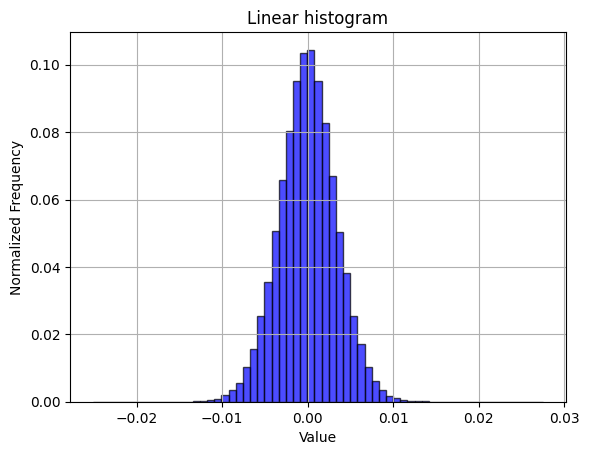

Module: MistralRotaryEmbedding
Operation: MistralRotaryEmbedding()
No weights in this module.
Module: Linear
Operation: Linear(in_features=4096, out_features=4096, bias=False)
[1.19209290e-07 5.96046448e-08 0.00000000e+00 1.19209290e-07
 1.78813934e-07 2.98023224e-07 4.17232513e-07 6.55651093e-07
 6.55651093e-07 4.76837158e-07 5.36441803e-07 6.55651093e-07
 6.55651093e-07 5.36441803e-07 5.96046448e-07 1.01327896e-06
 1.25169754e-06 1.07288361e-06 1.90734863e-06 3.87430191e-06
 8.64267349e-06 2.72989273e-05 1.84595585e-04 1.95145607e-03
 1.55690908e-02 7.94640779e-02 2.21563637e-01 3.24989498e-01
 2.40409255e-01 9.33366418e-02 1.95830464e-02 2.58904696e-03
 2.46882439e-04 3.27825546e-05 1.07884407e-05 5.48362732e-06
 2.38418579e-06 2.08616257e-06 1.25169754e-06 1.25169754e-06
 1.01327896e-06 7.15255737e-07 4.76837158e-07 4.17232513e-07
 3.57627869e-07 7.15255737e-07 5.36441803e-07 4.17232513e-07
 1.78813934e-07 4.17232513e-07 2.38418579e-07 1.19209290e-07
 0.00000000e+00 0.00000000e+00 

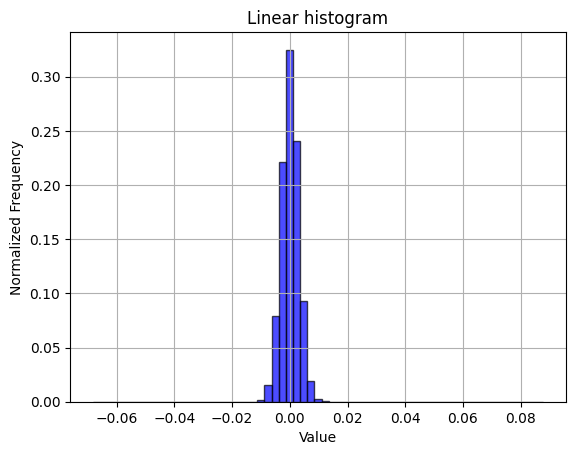

Module: MistralSdpaAttention
Operation: MistralSdpaAttention(
  (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
  (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
  (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
  (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
  (rotary_emb): MistralRotaryEmbedding()
)
No weights in this module.
Module: Linear
Operation: Linear(in_features=4096, out_features=14336, bias=False)
[1.70298985e-08 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 3.40597970e-08 3.40597970e-08 6.81195940e-08
 8.51494925e-08 1.53269087e-07 2.55448478e-07 4.93867057e-07
 1.07288361e-06 1.34536198e-06 3.09944153e-06 9.19614519e-06
 3.85386603e-05 4.42096165e-04 5.89122091e-03 5.37006685e-02
 2.21401691e-01 3.80497166e-01 2.57871611e-01 7.05563341e-02
 8.85798250e-03 6.52636800e-04 5.55344990e-05 1.02519989e-05
 4.25747463e-06 2.0946775

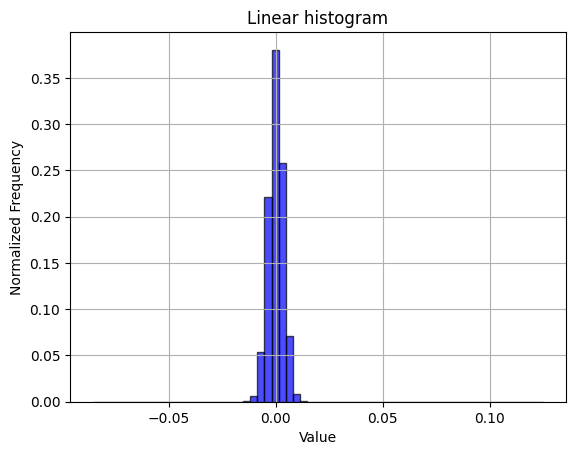

Module: SiLU
Operation: SiLU()
No weights in this module.
Module: Linear
Operation: Linear(in_features=4096, out_features=14336, bias=False)
[1.70298985e-08 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.70298985e-08 1.70298985e-08
 1.70298985e-08 1.70298985e-08 1.70298985e-08 0.00000000e+00
 5.10896955e-08 5.10896955e-08 3.40597970e-08 8.51494925e-08
 3.40597970e-08 1.02179391e-07 1.53269087e-07 4.25747463e-07
 7.49315534e-07 9.02584621e-07 1.80516924e-06 4.41074371e-06
 2.09127154e-05 2.07952091e-04 1.80445399e-03 1.07076849e-02
 4.54691989e-02 1.27046262e-01 2.28510312e-01 2.64299699e-01
 1.94355794e-01 9.23899072e-02 2.84285034e-02 5.82122803e-03
 8.29066549e-04 8.31740243e-05 1.05244773e-05 2.77587346e-06
 1.53269087e-06 7.83375331e-07 5.61986651e-07 2.89508275e-07
 8.51494925e-08 1.19209290e-07 6.81195940e-08 5.10896955e-08
 5.10896955e-08 1.70298985e-08 1.70298985e-08 1.70298985e-08
 0.00

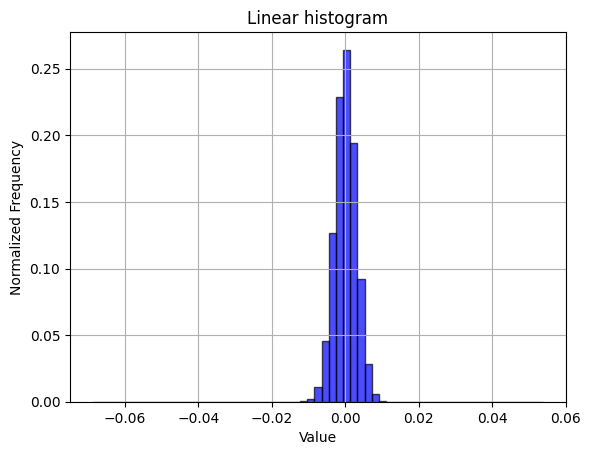

Module: Linear
Operation: Linear(in_features=14336, out_features=4096, bias=False)
[1.70298985e-08 1.70298985e-08 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.70298985e-08 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 3.40597970e-08 8.51494925e-08
 1.70298985e-08 3.40597970e-08 3.40597970e-08 5.10896955e-08
 8.51494925e-08 3.06538173e-07 4.25747463e-07 7.66345433e-07
 2.00952802e-06 1.47649220e-05 1.06452193e-03 3.10100828e-02
 2.42841244e-01 4.78828532e-01 2.19690170e-01 2.57177353e-02
 8.13961029e-04 1.14781516e-05 1.83922904e-06 6.30106245e-07
 4.59807260e-07 2.04358782e-07 1.36239188e-07 8.51494925e-08
 6.81195940e-08 3.40597970e-08 1.70298985e-08 5.10896955e-08
 1.70298985e-08 1.70298985e-08 0.00000000e+00 0.00000000e+00
 1

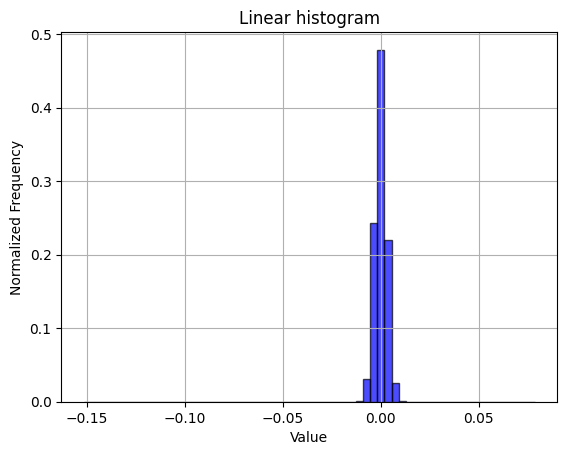

Module: MistralMLP
Operation: MistralMLP(
  (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
  (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
  (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
  (act_fn): SiLU()
)
No weights in this module.
Module: MistralDecoderLayer
Operation: MistralDecoderLayer(
  (self_attn): MistralSdpaAttention(
    (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
    (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
    (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
    (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
    (rotary_emb): MistralRotaryEmbedding()
  )
  (mlp): MistralMLP(
    (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
    (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
    (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
    (act_fn): SiLU()
  )
  (inp

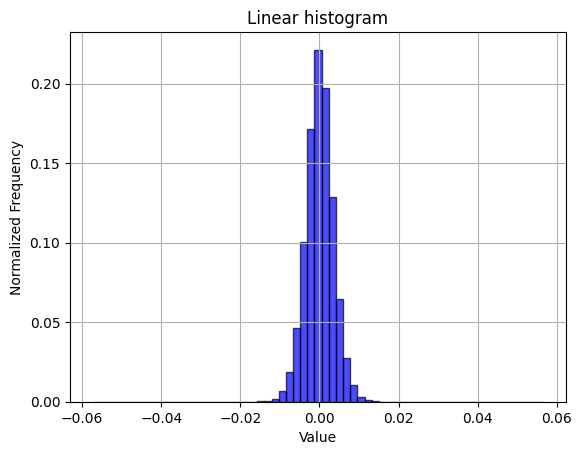

Module: Linear
Operation: Linear(in_features=4096, out_features=1024, bias=False)
[2.38418579e-07 2.38418579e-07 0.00000000e+00 0.00000000e+00
 7.15255737e-07 2.38418579e-07 2.38418579e-07 7.15255737e-07
 9.53674316e-07 1.43051147e-06 7.15255737e-07 1.66893005e-06
 1.90734863e-06 4.52995300e-06 3.09944153e-06 5.96046448e-06
 6.91413879e-06 1.19209290e-05 1.83582306e-05 2.16960907e-05
 3.95774841e-05 7.82012939e-05 1.71899796e-04 4.79936600e-04
 1.37257576e-03 3.91387939e-03 1.06453896e-02 2.64501572e-02
 6.08804226e-02 1.20157957e-01 1.90899849e-01 2.19639778e-01
 1.75630093e-01 1.03931189e-01 5.08818626e-02 2.15382576e-02
 8.36730003e-03 3.06248665e-03 1.08075142e-03 3.66926193e-04
 1.47819519e-04 5.53131104e-05 4.48226929e-05 2.45571136e-05
 1.83582306e-05 1.09672546e-05 7.39097595e-06 5.24520874e-06
 4.52995300e-06 2.38418579e-06 1.66893005e-06 1.66893005e-06
 1.66893005e-06 1.43051147e-06 4.76837158e-07 7.15255737e-07
 2.38418579e-07 2.38418579e-07 2.38418579e-07 0.00000000e+00
 0.

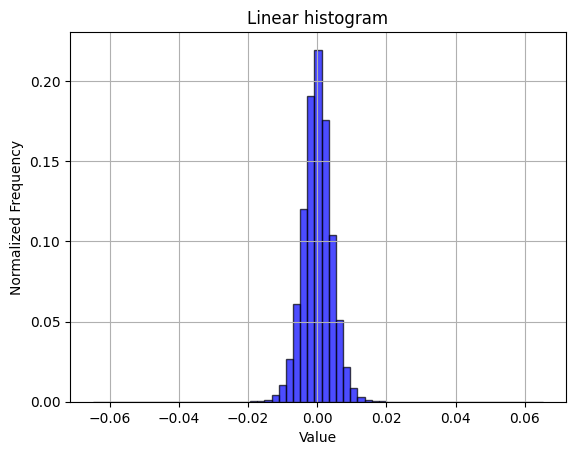

Module: Linear
Operation: Linear(in_features=4096, out_features=1024, bias=False)
[2.38418579e-07 0.00000000e+00 0.00000000e+00 4.76837158e-07
 0.00000000e+00 2.38418579e-07 0.00000000e+00 2.38418579e-07
 2.38418579e-07 7.15255737e-07 7.15255737e-07 1.66893005e-06
 2.86102295e-06 7.15255737e-06 2.36034393e-05 5.24520874e-05
 1.04665756e-04 2.31742859e-04 5.34057617e-04 1.18350983e-03
 2.17294693e-03 4.41837311e-03 7.92074203e-03 1.34415627e-02
 2.26917267e-02 3.34937572e-02 4.83686924e-02 6.58559799e-02
 8.24639797e-02 9.74183083e-02 1.09354496e-01 1.10459566e-01
 9.98547077e-02 8.57217312e-02 6.90031052e-02 5.05445004e-02
 3.72352600e-02 2.36351490e-02 1.48370266e-02 8.88967514e-03
 4.98843193e-03 2.51388550e-03 1.40166283e-03 6.53505325e-04
 2.82049179e-04 1.36852264e-04 5.91278076e-05 1.90734863e-05
 1.09672546e-05 4.76837158e-06 1.19209290e-06 9.53674316e-07
 4.76837158e-07 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.38418579e-07 2.38418579e-07 0.00000000e+00 2.38418579e-07
 0.

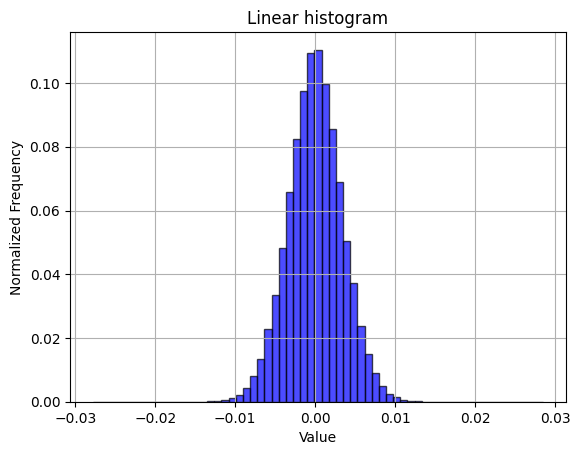

Module: MistralRotaryEmbedding
Operation: MistralRotaryEmbedding()
No weights in this module.
Module: Linear
Operation: Linear(in_features=4096, out_features=4096, bias=False)
[5.96046448e-08 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 5.96046448e-08 1.19209290e-07
 1.19209290e-07 1.19209290e-07 2.98023224e-07 5.36441803e-07
 2.98023224e-07 7.74860382e-07 9.53674316e-07 1.84774399e-06
 2.08616257e-06 2.80141830e-06 5.24520874e-06 6.55651093e-06
 1.06096268e-05 2.33054161e-05 9.72151756e-05 7.09414482e-04
 4.59194183e-03 2.30395794e-02 7.56488442e-02 1.74461722e-01
 2.59523034e-01 2.43029952e-01 1.44386470e-01 5.59426546e-02
 1.51663423e-02 2.83712149e-03 4.01735306e-04 6.06775284e-05
 1.78217888e-05 9.23871994e-06 5.90085983e-06 4.23192978e-06
 3.15904617e-06 2.08616257e-06 2.02655792e-06 9.53674316e-07
 5.96046448e-07 7.74860382e-07 

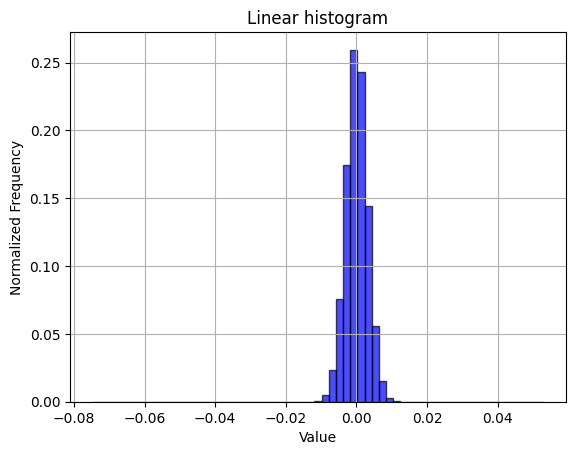

Module: MistralSdpaAttention
Operation: MistralSdpaAttention(
  (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
  (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
  (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
  (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
  (rotary_emb): MistralRotaryEmbedding()
)
No weights in this module.
Module: Linear
Operation: Linear(in_features=4096, out_features=14336, bias=False)
[3.40597970e-08 0.00000000e+00 1.70298985e-08 3.40597970e-08
 5.10896955e-08 6.81195940e-08 8.51494925e-08 6.81195940e-08
 1.87328884e-07 3.40597970e-07 6.47136143e-07 7.15255737e-07
 1.68595995e-06 2.14576721e-06 4.29153442e-06 8.94069672e-06
 3.43152455e-05 1.98977334e-04 1.44655364e-03 9.16068895e-03
 4.17688404e-02 1.26783133e-01 2.41907971e-01 2.77823108e-01
 1.92127500e-01 8.18080391e-02 2.20621313e-02 4.14027487e-03
 6.00951059e-04 8.46385956e-05 1.77621841e-05 6.91413879e-06
 3.59330859e-06 1.8562589

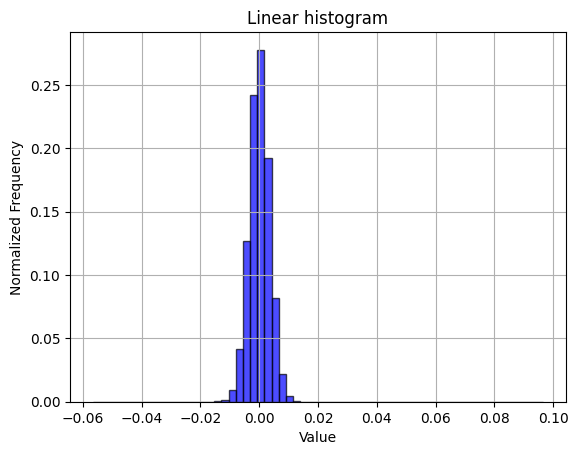

Module: SiLU
Operation: SiLU()
No weights in this module.
Module: Linear
Operation: Linear(in_features=4096, out_features=14336, bias=False)
[1.70298985e-08 0.00000000e+00 1.70298985e-08 0.00000000e+00
 3.40597970e-08 1.70298985e-08 5.10896955e-08 0.00000000e+00
 5.10896955e-08 1.70298985e-08 5.10896955e-08 5.10896955e-08
 1.36239188e-07 1.87328884e-07 2.72478376e-07 4.08717564e-07
 9.19614519e-07 1.90734863e-06 6.06264387e-06 7.28539058e-05
 1.46692140e-03 1.70720305e-02 9.98807635e-02 2.72287880e-01
 3.46842034e-01 2.00863991e-01 5.38239479e-02 7.18855858e-03
 4.59722110e-04 2.37907682e-05 3.66142818e-06 1.51566097e-06
 9.36644418e-07 4.42777361e-07 1.19209290e-07 1.87328884e-07
 1.53269087e-07 8.51494925e-08 3.40597970e-08 1.70298985e-08
 1.70298985e-08 0.00000000e+00 3.40597970e-08 0.00000000e+00
 3.40597970e-08 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.70298985e-08 1.70298985e-08 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

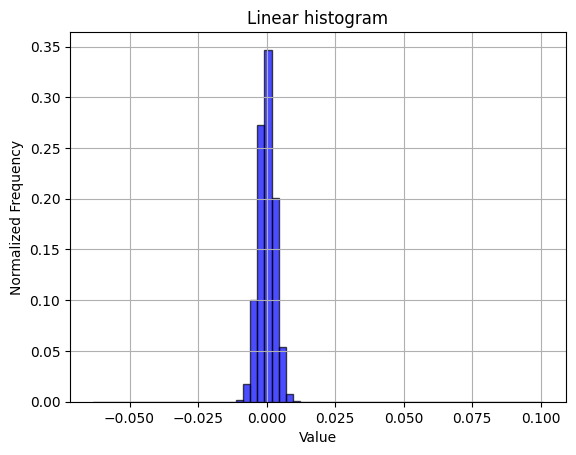

Module: Linear
Operation: Linear(in_features=14336, out_features=4096, bias=False)
[1.70298985e-08 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.70298985e-08 0.00000000e+00 0.00000000e+00
 1.70298985e-08 0.00000000e+00 0.00000000e+00 1.70298985e-08
 0.00000000e+00 0.00000000e+00 1.70298985e-08 1.70298985e-08
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.70298985e-08 6.81195940e-08 1.02179391e-07 2.21388681e-07
 6.13076346e-07 2.38418579e-06 1.01770673e-04 2.12178571e-02
 3.81128856e-01 5.37359953e-01 5.96440009e-02 5.38825989e-04
 3.62736838e-06 9.53674316e-07 2.72478376e-07 2.21388681e-07
 1.70298985e-08 5.10896955e-08 0.00000000e+00 0.00000000e+00
 3.40597970e-08 0.00000000e+00 0.00000000e+00 1.70298985e-08
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.70298985e-08 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0

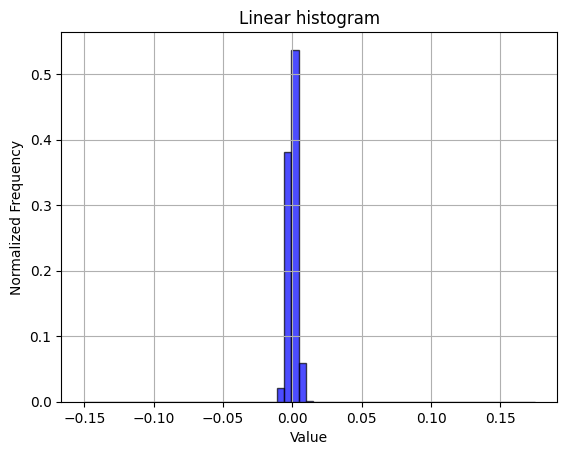

Module: MistralMLP
Operation: MistralMLP(
  (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
  (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
  (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
  (act_fn): SiLU()
)
No weights in this module.
Module: MistralDecoderLayer
Operation: MistralDecoderLayer(
  (self_attn): MistralSdpaAttention(
    (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
    (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
    (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
    (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
    (rotary_emb): MistralRotaryEmbedding()
  )
  (mlp): MistralMLP(
    (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
    (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
    (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
    (act_fn): SiLU()
  )
  (inp

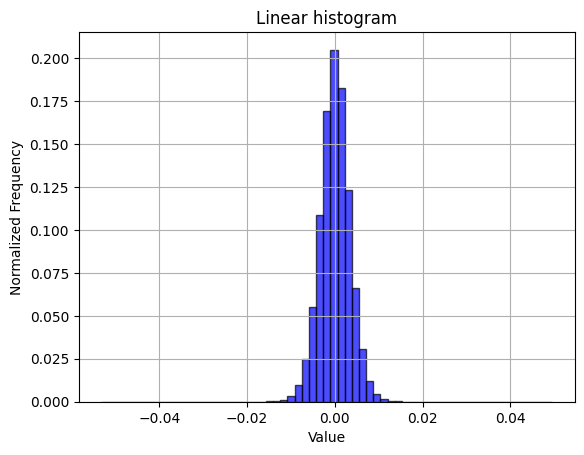

Module: Linear
Operation: Linear(in_features=4096, out_features=1024, bias=False)
[4.76837158e-07 0.00000000e+00 0.00000000e+00 2.38418579e-07
 9.53674316e-07 4.76837158e-07 1.19209290e-06 9.53674316e-07
 3.33786011e-06 4.52995300e-06 4.05311584e-06 5.96046448e-06
 7.86781311e-06 9.29832458e-06 1.38282776e-05 2.12192535e-05
 2.86102295e-05 4.74452972e-05 7.62939453e-05 1.47342682e-04
 3.25202942e-04 7.95602798e-04 1.93047523e-03 4.55951691e-03
 1.03063583e-02 2.27603912e-02 4.61163521e-02 8.67726803e-02
 1.41165972e-01 1.85081244e-01 1.84466839e-01 1.40572309e-01
 8.65461826e-02 4.64854240e-02 2.27911472e-02 1.07357502e-02
 4.68063354e-03 2.01964378e-03 8.22067261e-04 3.27348709e-04
 1.54733658e-04 7.31945038e-05 4.05311584e-05 2.59876251e-05
 2.07424164e-05 1.47819519e-05 6.91413879e-06 8.10623169e-06
 5.00679016e-06 3.81469727e-06 4.05311584e-06 2.14576721e-06
 9.53674316e-07 4.76837158e-07 9.53674316e-07 9.53674316e-07
 4.76837158e-07 4.76837158e-07 0.00000000e+00 2.38418579e-07
 0.

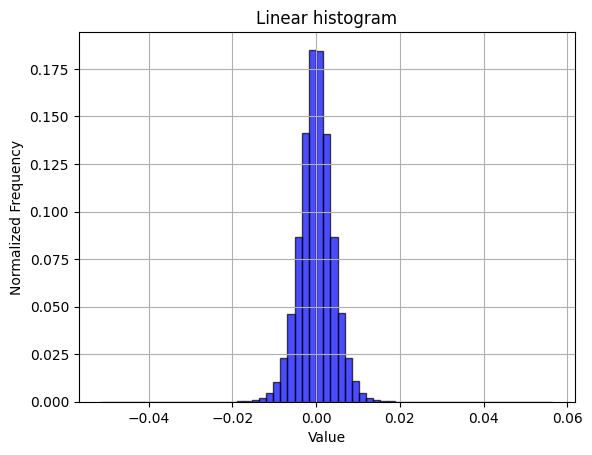

Module: Linear
Operation: Linear(in_features=4096, out_features=1024, bias=False)
[7.15255737e-07 4.76837158e-07 2.38418579e-07 9.53674316e-07
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.38418579e-07
 4.76837158e-07 0.00000000e+00 1.19209290e-06 1.43051147e-06
 9.53674316e-07 2.86102295e-06 1.02519989e-05 1.69277191e-05
 4.95910645e-05 1.42812729e-04 3.40223312e-04 8.08238983e-04
 1.87206268e-03 4.40359116e-03 8.83030891e-03 1.65076256e-02
 2.98204422e-02 4.74319458e-02 7.16340542e-02 9.67900753e-02
 1.20820284e-01 1.34809971e-01 1.28384829e-01 1.09612942e-01
 8.44829082e-02 5.95750809e-02 3.75130177e-02 2.26550102e-02
 1.21479034e-02 6.15072250e-03 3.01480293e-03 1.27196312e-03
 5.34534454e-04 2.17676163e-04 8.63075256e-05 3.09944153e-05
 1.12056732e-05 4.29153442e-06 2.38418579e-06 9.53674316e-07
 4.76837158e-07 4.76837158e-07 7.15255737e-07 2.38418579e-07
 7.15255737e-07 4.76837158e-07 0.00000000e+00 0.00000000e+00
 0.00000000e+00 7.15255737e-07 0.00000000e+00 2.38418579e-07
 0.

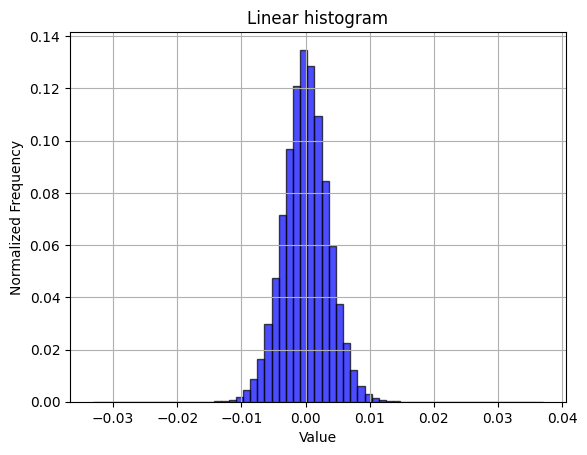

Module: MistralRotaryEmbedding
Operation: MistralRotaryEmbedding()
No weights in this module.
Module: Linear
Operation: Linear(in_features=4096, out_features=4096, bias=False)
[5.96046448e-08 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 5.96046448e-08 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 5.96046448e-08 0.00000000e+00 0.00000000e+00 5.96046448e-08
 5.96046448e-08 2.38418579e-07 6.55651093e-07 7.74860382e-07
 8.94069672e-07 5.48362732e-06 1.20162964e-04 5.64759970e-03
 9.52335000e-02 4.15319681e-01 3.95637751e-01 8.33451152e-02
 4.58490849e-03 9.38773155e-05 4.52995300e-06 1.96695328e-06
 9.53674316e-07 7.74860382e-07 2.98023224e-07 1.78813934e-07
 1.78813934e-07 0.00000000e+00 0.00000000e+00 0.00000000e+00
 5.96046448e-08 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 5.96046448e-08 0.00000000e+00
 0.00000000e+00 0.00000000e+00 

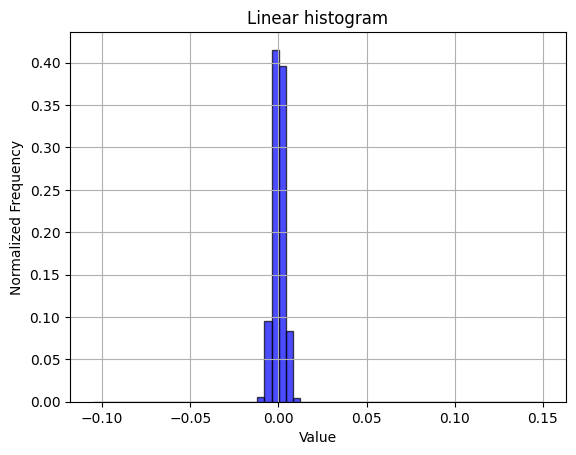

Module: MistralSdpaAttention
Operation: MistralSdpaAttention(
  (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
  (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
  (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
  (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
  (rotary_emb): MistralRotaryEmbedding()
)
No weights in this module.
Module: Linear
Operation: Linear(in_features=4096, out_features=14336, bias=False)
[1.70298985e-08 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.70298985e-08 1.19209290e-07 6.81195940e-08 1.02179391e-07
 5.10896955e-08 6.81195940e-08 2.72478376e-07 2.89508275e-07
 4.59807260e-07 8.17435128e-07 1.27724239e-06 2.50339508e-06
 4.64916229e-06 1.06777464e-05 4.78199550e-05 4.35028757e-04
 4.99130998e-03 3.6695991

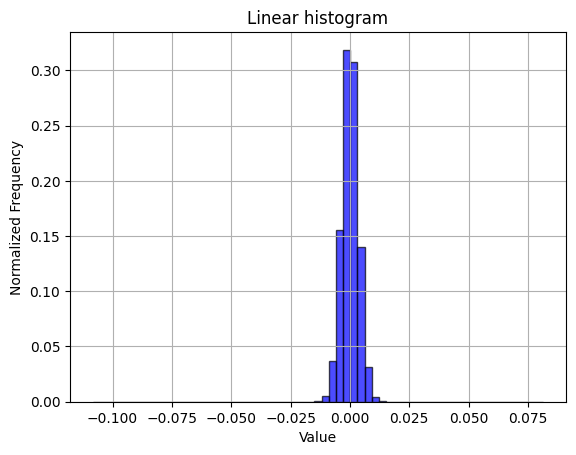

Module: SiLU
Operation: SiLU()
No weights in this module.
Module: Linear
Operation: Linear(in_features=4096, out_features=14336, bias=False)
[1.70298985e-08 1.70298985e-08 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 3.40597970e-08 0.00000000e+00 1.70298985e-08
 5.10896955e-08 3.40597970e-08 5.10896955e-08 8.51494925e-08
 8.51494925e-08 1.70298985e-07 1.53269087e-07 3.74657767e-07
 4.25747463e-07 9.87734113e-07 1.39645168e-06 2.60557447e-06
 6.35215214e-06 3.49283218e-05 2.79716083e-04 1.77543504e-03
 9.27451679e-03 3.32062585e-02 9.04743501e-02 1.71338643e-01
 2.32422778e-01 2.18553850e-01 1.45243083e-01 6.77466393e-02
 2.29322570e-02 5.52713871e-03 1.00031921e-03 1.48091997e-04
 1.88520976e-05 5.07490976e-06 2.57151467e-06 9.53674316e-07
 5.27926854e-07 4.25747463e-07 1.36239188e-07 2.04358782e-07
 1.36239188e-07 8.51494925e-08 5.10896955e-08 3.40597970e-08
 0.00000000e+00 0.00000000e+00 3.40597970e-08 1.70298985e-08
 0.00

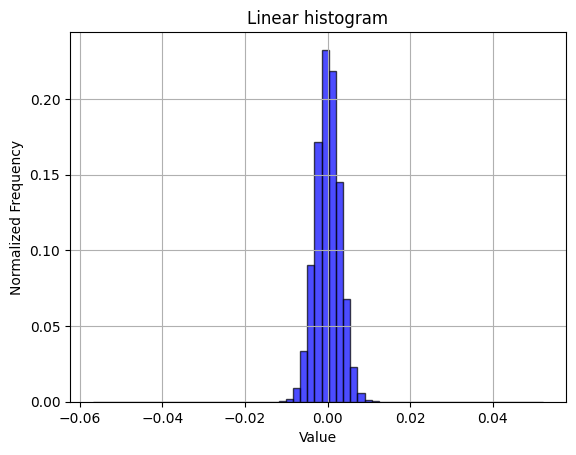

Module: Linear
Operation: Linear(in_features=14336, out_features=4096, bias=False)
[1.70298985e-08 0.00000000e+00 1.70298985e-08 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.70298985e-08 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.70298985e-08
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 3.40597970e-08 1.70298985e-08 1.70298985e-08 1.70298985e-08
 1.70298985e-08 1.70298985e-08 5.10896955e-08 8.51494925e-08
 5.10896955e-08 2.04358782e-07 1.87328884e-07 2.21388681e-07
 3.74657767e-07 6.98225839e-07 1.49863107e-06 6.11373356e-06
 1.53728894e-04 3.94177437e-03 4.37578474e-02 2.06906898e-01
 3.91416992e-01 2.71421313e-01 7.34860046e-02 8.48540238e-03
 4.02144023e-04 1.28916332e-05 2.23091670e-06 1.12397330e-06
 7.66345433e-07 3.57627869e-07 2.38418579e-07 1.53269087e-07
 1.70298985e-07 1.02179391e-07 3.40597970e-08 5.10896955e-08
 0.00000000e+00 3.40597970e-08 1.70298985e-08 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.70298985e-08 0.00000000e+00
 1

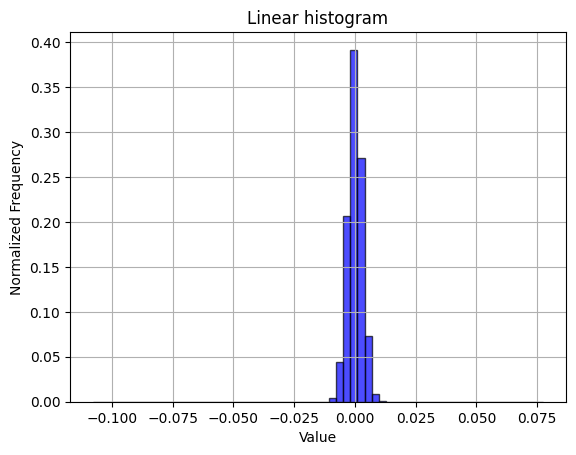

Module: MistralMLP
Operation: MistralMLP(
  (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
  (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
  (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
  (act_fn): SiLU()
)
No weights in this module.
Module: MistralDecoderLayer
Operation: MistralDecoderLayer(
  (self_attn): MistralSdpaAttention(
    (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
    (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
    (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
    (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
    (rotary_emb): MistralRotaryEmbedding()
  )
  (mlp): MistralMLP(
    (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
    (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
    (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
    (act_fn): SiLU()
  )
  (inp

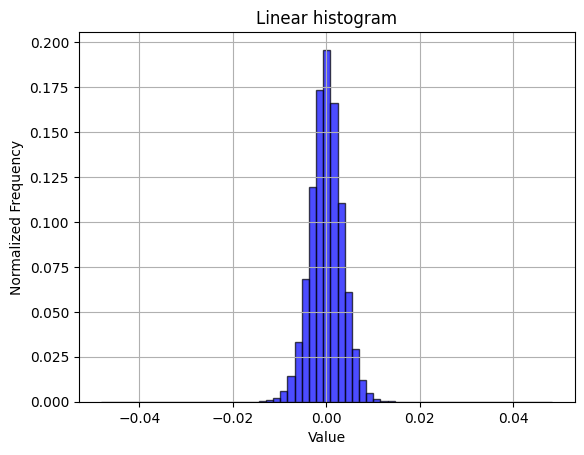

Module: Linear
Operation: Linear(in_features=4096, out_features=1024, bias=False)
[2.38418579e-07 2.38418579e-07 2.38418579e-07 9.53674316e-07
 7.15255737e-07 7.15255737e-07 2.14576721e-06 9.53674316e-07
 1.90734863e-06 3.81469727e-06 7.39097595e-06 7.39097595e-06
 8.10623169e-06 1.52587891e-05 2.50339508e-05 3.48091125e-05
 4.24385071e-05 9.20295715e-05 2.15530396e-04 5.87224960e-04
 1.80196762e-03 5.47599792e-03 1.52020454e-02 3.97725105e-02
 8.95454884e-02 1.69527531e-01 2.35075951e-01 2.11674213e-01
 1.29362106e-01 6.15510941e-02 2.57644653e-02 9.17553902e-03
 3.28588486e-03 1.04117393e-03 3.61919403e-04 1.34944916e-04
 7.29560852e-05 4.52995300e-05 2.45571136e-05 1.76429749e-05
 1.12056732e-05 6.91413879e-06 6.19888306e-06 2.86102295e-06
 2.86102295e-06 2.62260437e-06 3.33786011e-06 9.53674316e-07
 7.15255737e-07 4.76837158e-07 4.76837158e-07 4.76837158e-07
 0.00000000e+00 0.00000000e+00 2.38418579e-07 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

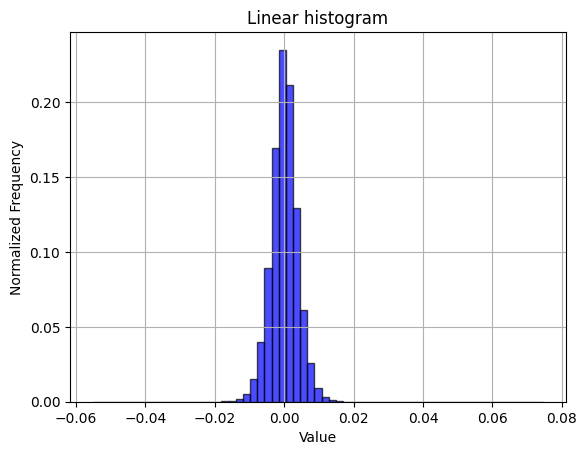

Module: Linear
Operation: Linear(in_features=4096, out_features=1024, bias=False)
[4.76837158e-07 2.38418579e-07 7.15255737e-07 2.38418579e-07
 7.15255737e-07 2.38418579e-07 1.19209290e-06 1.43051147e-06
 1.90734863e-06 2.86102295e-06 5.72204590e-06 9.77516174e-06
 1.38282776e-05 2.07424164e-05 3.98159027e-05 7.86781311e-05
 1.40666962e-04 3.21149826e-04 6.56604767e-04 1.29556656e-03
 2.77900696e-03 5.50413132e-03 1.02019310e-02 1.77860260e-02
 2.90992260e-02 4.56442833e-02 6.35638237e-02 8.42280388e-02
 1.01780653e-01 1.15127802e-01 1.18682146e-01 1.07055664e-01
 9.12084579e-02 7.01901913e-02 5.13606071e-02 3.53007317e-02
 2.12450027e-02 1.27832890e-02 6.97922707e-03 3.42988968e-03
 1.79648399e-03 8.54253769e-04 4.11272049e-04 1.72376633e-04
 9.87052917e-05 5.36441803e-05 2.67028809e-05 1.74045563e-05
 9.29832458e-06 5.00679016e-06 5.00679016e-06 2.62260437e-06
 7.15255737e-07 7.15255737e-07 9.53674316e-07 2.38418579e-07
 2.38418579e-07 2.38418579e-07 2.38418579e-07 2.38418579e-07
 2.

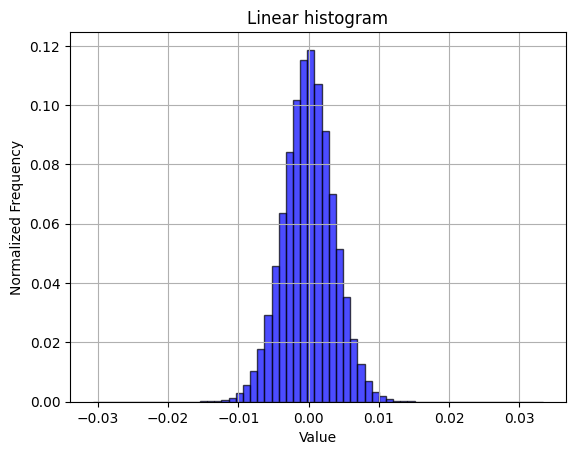

Module: MistralRotaryEmbedding
Operation: MistralRotaryEmbedding()
No weights in this module.
Module: Linear
Operation: Linear(in_features=4096, out_features=4096, bias=False)
[5.96046448e-08 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 5.96046448e-08 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 5.96046448e-08
 5.96046448e-08 5.96046448e-08 5.96046448e-08 0.00000000e+00
 1.19209290e-07 1.78813934e-07 2.98023224e-07 2.38418579e-07
 4.17232513e-07 8.94069672e-07 1.37090683e-06 2.44379044e-06
 4.64916229e-06 1.12652779e-05 4.38094139e-05 2.30967999e-04
 1.08373165e-03 4.93681431e-03 1.76318288e-02 5.08345962e-02
 1.11085773e-01 1.82969570e-01 2.21450090e-01 1.93915367e-01
 1.25054419e-01 6.03778362e-02 2.21245289e-02 6.33066893e-03
 1.52790546e-03 2.89440155e-04 6.40749931e-05 1.34706497e-05
 4.64916229e-06 3.03983688e-06 1.60932541e-06 9.53674316e-07
 8.34465027e-07 5.96046448e-07 4.76837158e-07 1.78813934e-07
 5.96046448e-08 1.78813934e-07 

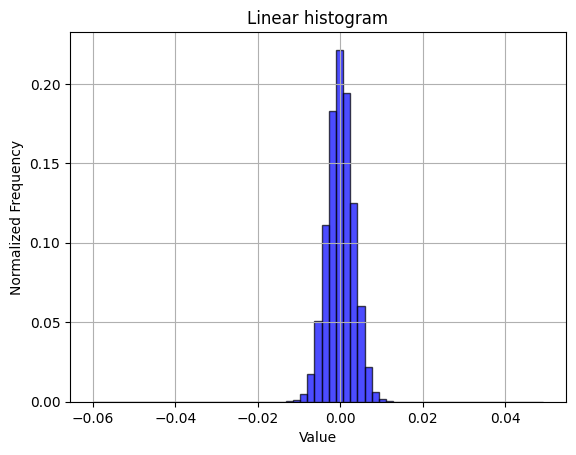

Module: MistralSdpaAttention
Operation: MistralSdpaAttention(
  (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
  (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
  (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
  (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
  (rotary_emb): MistralRotaryEmbedding()
)
No weights in this module.
Module: Linear
Operation: Linear(in_features=4096, out_features=14336, bias=False)
[1.70298985e-08 3.40597970e-08 3.40597970e-08 3.40597970e-08
 5.10896955e-08 3.40597970e-08 6.81195940e-08 6.81195940e-08
 1.02179391e-07 2.89508275e-07 4.25747463e-07 6.81195940e-07
 9.36644418e-07 1.49863107e-06 2.65666417e-06 5.07490976e-06
 1.23126166e-05 5.21966389e-05 3.21132796e-04 2.26671355e-03
 1.36849540e-02 5.89892694e-02 1.60098468e-01 2.68491098e-01
 2.67275691e-01 1.55907461e-01 5.71713107e-02 1.31564651e-02
 2.17308317e-03 3.13162804e-04 4.88247190e-05 1.37601580e-05
 5.38144793e-06 2.4693352

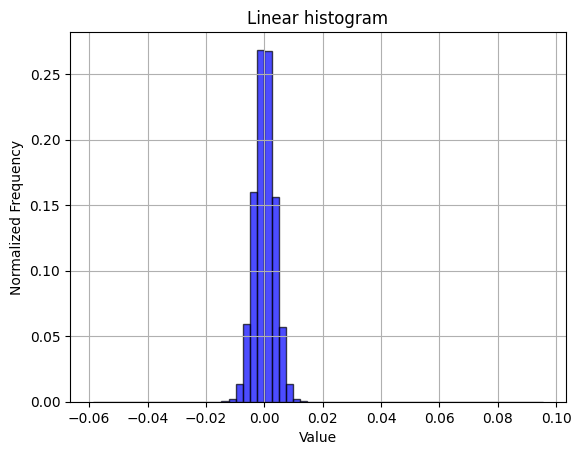

Module: SiLU
Operation: SiLU()
No weights in this module.
Module: Linear
Operation: Linear(in_features=4096, out_features=14336, bias=False)
[1.70298985e-08 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 5.10896955e-08
 1.02179391e-07 5.10896955e-08 6.81195940e-08 2.04358782e-07
 3.91687666e-07 5.27926854e-07 1.29427229e-06 2.50339508e-06
 6.06264387e-06 4.58104270e-05 7.24196434e-04 7.74889333e-03
 4.97749703e-02 1.70501028e-01 3.09592860e-01 2.85474522e-01
 1.36373554e-01 3.45924582e-02 4.75384508e-03 3.71575356e-04
 2.56299973e-05 4.90461077e-06 1.99249813e-06 1.07288361e-06
 5.10896955e-07 3.23568072e-07 1.53269087e-07 1.70298985e-07
 6.81195940e-08 8.51494925e-08 0.00000000e+00 1.70298985e-08
 0.00000000e+00 0.00000000e+00 1.70298985e-08 1.70298985e-08
 1.70298985e-08 1.70298985e-08 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

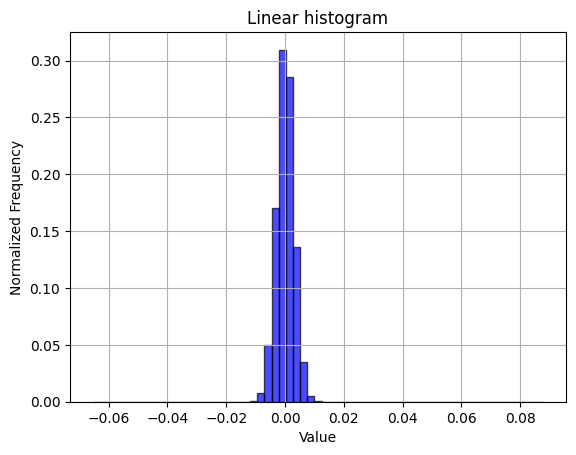

Module: Linear
Operation: Linear(in_features=14336, out_features=4096, bias=False)
[1.70298985e-08 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.70298985e-08 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.70298985e-08 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.70298985e-08 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.70298985e-08
 0.00000000e+00 3.40597970e-08 1.70298985e-08 3.40597970e-08
 1.70298985e-08 3.40597970e-08 1.53269087e-07 2.89508275e-07
 5.61986651e-07 1.41348158e-06 1.29256930e-05 2.42548329e-03
 1.01797632e-01 5.37394149e-01 3.32739200e-01 2.53724711e-02
 2.50867435e-04 2.94617244e-06 9.70704215e-07 3.06538173e-07
 1.19209290e-07 1.02179391e-07 5.10896955e-08 3.40597970e-08
 1.70298985e-08 1.70298985e-08 1.70298985e-08 0.00000000e+00
 1.70298985e-08 1.70298985e-08 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0

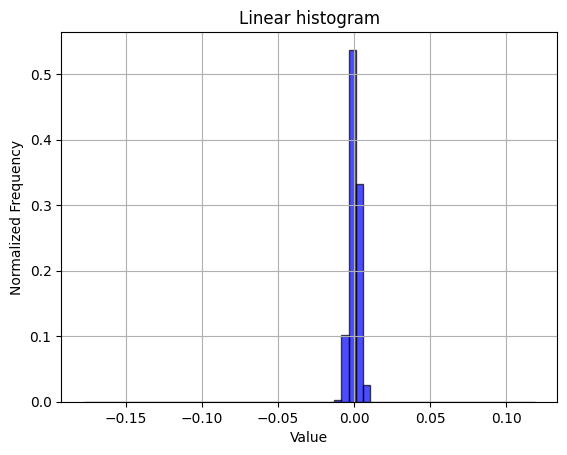

Module: MistralMLP
Operation: MistralMLP(
  (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
  (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
  (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
  (act_fn): SiLU()
)
No weights in this module.
Module: MistralDecoderLayer
Operation: MistralDecoderLayer(
  (self_attn): MistralSdpaAttention(
    (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
    (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
    (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
    (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
    (rotary_emb): MistralRotaryEmbedding()
  )
  (mlp): MistralMLP(
    (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
    (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
    (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
    (act_fn): SiLU()
  )
  (inp

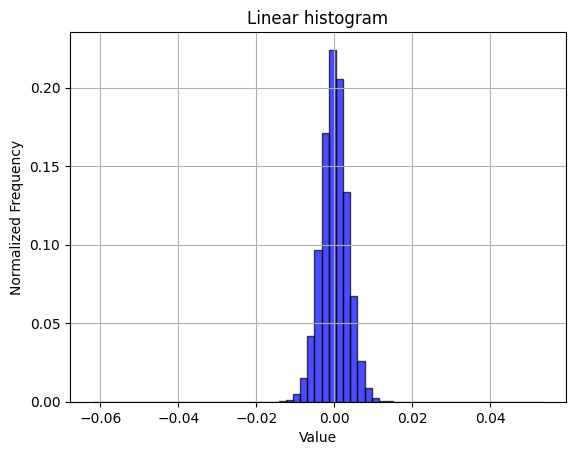

Module: Linear
Operation: Linear(in_features=4096, out_features=1024, bias=False)
[2.38418579e-07 0.00000000e+00 0.00000000e+00 4.76837158e-07
 7.15255737e-07 1.43051147e-06 7.15255737e-07 2.38418579e-07
 2.38418579e-07 1.43051147e-06 1.19209290e-06 1.90734863e-06
 2.86102295e-06 3.09944153e-06 4.05311584e-06 3.81469727e-06
 6.91413879e-06 1.07288361e-05 2.00271606e-05 3.14712524e-05
 5.50746918e-05 1.43766403e-04 4.63724136e-04 1.46627426e-03
 4.81915474e-03 1.32756233e-02 3.50928307e-02 7.97858238e-02
 1.49449587e-01 2.17751265e-01 2.16757774e-01 1.48464918e-01
 7.79345036e-02 3.44936848e-02 1.30722523e-02 4.65154648e-03
 1.51753426e-03 4.27007675e-04 1.46389008e-04 5.29289246e-05
 2.83718109e-05 1.66893005e-05 9.05990601e-06 8.34465027e-06
 4.76837158e-06 3.09944153e-06 4.29153442e-06 1.43051147e-06
 3.09944153e-06 1.90734863e-06 7.15255737e-07 1.19209290e-06
 1.43051147e-06 9.53674316e-07 0.00000000e+00 2.38418579e-07
 0.00000000e+00 4.76837158e-07 2.38418579e-07 0.00000000e+00
 2.

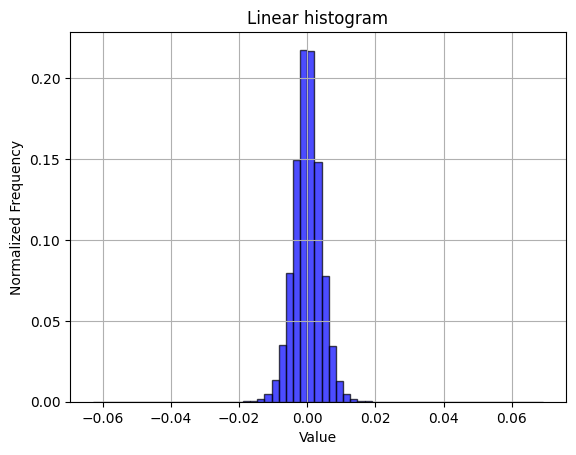

Module: Linear
Operation: Linear(in_features=4096, out_features=1024, bias=False)
[2.38418579e-07 0.00000000e+00 7.15255737e-07 2.38418579e-07
 0.00000000e+00 4.76837158e-07 4.76837158e-07 1.19209290e-06
 2.14576721e-06 1.43051147e-06 2.62260437e-06 3.33786011e-06
 8.34465027e-06 1.50203705e-05 2.55107880e-05 6.58035278e-05
 1.40905380e-04 3.15427780e-04 7.34329224e-04 1.56688690e-03
 3.27801704e-03 6.24251366e-03 1.17545128e-02 2.06079483e-02
 3.21631432e-02 4.79974747e-02 6.74529076e-02 8.74428749e-02
 1.03738070e-01 1.15014791e-01 1.14825010e-01 1.05024576e-01
 8.66260529e-02 6.80763721e-02 4.84025478e-02 3.34684849e-02
 2.03506947e-02 1.16832256e-02 6.48188591e-03 3.55243683e-03
 1.59382820e-03 7.49588013e-04 3.26156616e-04 1.42574310e-04
 6.15119934e-05 2.59876251e-05 1.45435333e-05 5.48362732e-06
 3.09944153e-06 1.43051147e-06 1.90734863e-06 7.15255737e-07
 7.15255737e-07 2.38418579e-07 7.15255737e-07 7.15255737e-07
 0.00000000e+00 7.15255737e-07 0.00000000e+00 4.76837158e-07
 4.

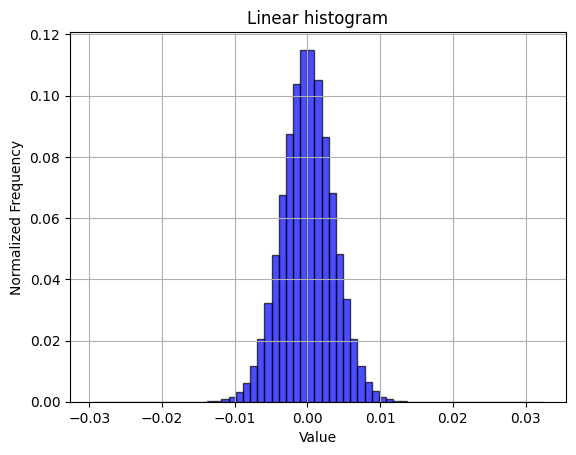

Module: MistralRotaryEmbedding
Operation: MistralRotaryEmbedding()
No weights in this module.
Module: Linear
Operation: Linear(in_features=4096, out_features=4096, bias=False)
[5.96046448e-08 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 5.96046448e-08 0.00000000e+00 0.00000000e+00
 5.96046448e-08 5.96046448e-08 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 5.96046448e-08 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.19209290e-07 0.00000000e+00
 1.78813934e-07 1.19209290e-07 2.38418579e-07 2.38418579e-07
 1.78813934e-07 4.17232513e-07 6.55651093e-07 8.34465027e-07
 1.43051147e-06 1.96695328e-06 4.94718552e-06 1.01923943e-05
 4.54783440e-05 8.69035721e-04 1.74731016e-02 1.49239600e-01
 4.17403340e-01 3.30768883e-01 7.74484277e-02 6.40577078e-03
 2.84135342e-04 2.22325325e-05 8.64267349e-06 2.80141830e-06
 2.32458115e-06 1.54972076e-06 7.15255737e-07 4.76837158e-07
 2.98023224e-07 3.57627869e-07 2.38418579e-07 1.19209290e-07
 1.19209290e-07 5.96046448e-08 

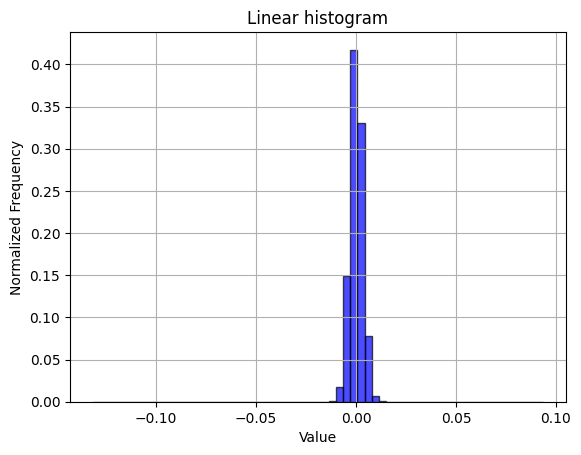

Module: MistralSdpaAttention
Operation: MistralSdpaAttention(
  (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
  (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
  (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
  (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
  (rotary_emb): MistralRotaryEmbedding()
)
No weights in this module.
Module: Linear
Operation: Linear(in_features=4096, out_features=14336, bias=False)
[1.70298985e-08 0.00000000e+00 0.00000000e+00 1.70298985e-08
 0.00000000e+00 1.70298985e-08 3.40597970e-08 6.81195940e-08
 0.00000000e+00 6.81195940e-08 8.51494925e-08 5.10896955e-08
 1.36239188e-07 2.04358782e-07 2.55448478e-07 3.91687666e-07
 3.74657767e-07 3.74657767e-07 9.36644418e-07 1.22615269e-06
 1.58378056e-06 2.69072396e-06 5.14302935e-06 9.58783286e-06
 2.65325819e-05 1.31419727e-04 8.76035009e-04 5.58727128e-03
 2.92959894e-02 1.00168177e-01 2.20324278e-01 2.87782669e-01
 2.20206278e-01 9.9875211

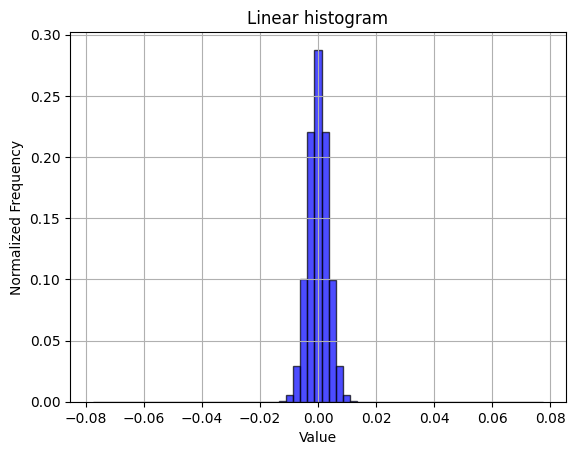

Module: SiLU
Operation: SiLU()
No weights in this module.
Module: Linear
Operation: Linear(in_features=4096, out_features=14336, bias=False)
[1.70298985e-08 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.70298985e-08 0.00000000e+00 1.70298985e-08
 0.00000000e+00 1.70298985e-08 0.00000000e+00 1.70298985e-08
 1.70298985e-08 6.81195940e-08 3.40597970e-08 0.00000000e+00
 1.70298985e-08 1.19209290e-07 1.36239188e-07 2.38418579e-07
 3.23568072e-07 6.13076346e-07 9.87734113e-07 1.27724239e-06
 2.82696315e-06 6.42027174e-06 3.52008002e-05 3.24981553e-04
 2.64615672e-03 1.47006341e-02 5.79100507e-02 1.46873082e-01
 2.45703357e-01 2.58862172e-01 1.72434109e-01 7.44014297e-02
 2.14616401e-02 4.00166852e-03 5.56605203e-04 5.83103725e-05
 9.79219164e-06 3.55924879e-06 1.78813934e-06 8.17435128e-07
 4.25747463e-07 3.57627869e-07 2.55448478e-07 5.10896955e-08
 1.02179391e-07 8.51494925e-08 3.40597970e-08 1.70298985e-08
 3.40

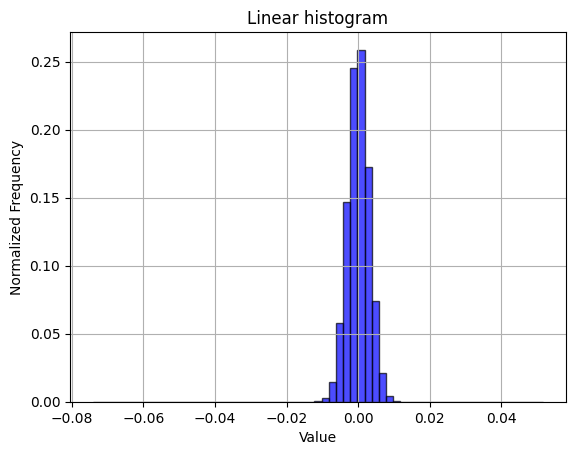

Module: Linear
Operation: Linear(in_features=14336, out_features=4096, bias=False)
[1.70298985e-08 0.00000000e+00 0.00000000e+00 1.70298985e-08
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.70298985e-08 0.00000000e+00 3.40597970e-08
 3.40597970e-08 1.70298985e-08 0.00000000e+00 6.81195940e-08
 8.51494925e-08 3.06538173e-07 3.91687666e-07 1.05585371e-06
 2.63963427e-06 2.27689743e-05 2.04968452e-03 6.17139510e-02
 3.89109475e-01 4.49298484e-01 9.37932049e-02 3.95817416e-03
 4.43458557e-05 2.92914254e-06 1.14100320e-06 4.76837158e-07
 3.57627869e-07 8.51494925e-08 5.10896955e-08 8.51494925e-08
 3.40597970e-08 1.70298985e-08 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.70298985e-08 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.70298985e-08
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0

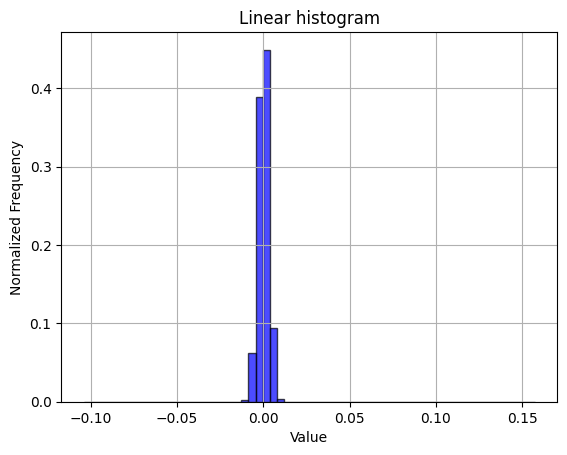

Module: MistralMLP
Operation: MistralMLP(
  (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
  (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
  (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
  (act_fn): SiLU()
)
No weights in this module.
Module: MistralDecoderLayer
Operation: MistralDecoderLayer(
  (self_attn): MistralSdpaAttention(
    (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
    (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
    (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
    (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
    (rotary_emb): MistralRotaryEmbedding()
  )
  (mlp): MistralMLP(
    (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
    (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
    (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
    (act_fn): SiLU()
  )
  (inp

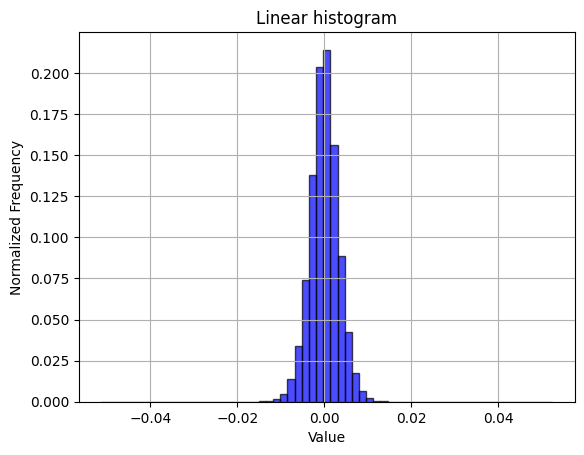

Module: Linear
Operation: Linear(in_features=4096, out_features=1024, bias=False)
[2.38418579e-07 0.00000000e+00 0.00000000e+00 4.76837158e-07
 0.00000000e+00 7.15255737e-07 4.76837158e-07 1.19209290e-06
 9.53674316e-07 1.43051147e-06 1.90734863e-06 3.81469727e-06
 4.29153442e-06 5.24520874e-06 7.39097595e-06 9.77516174e-06
 1.33514404e-05 1.97887421e-05 3.36170197e-05 3.24249268e-05
 5.53131104e-05 9.08374786e-05 1.32322311e-04 2.81095505e-04
 6.27040863e-04 1.58071518e-03 4.10795212e-03 1.03921890e-02
 2.54657269e-02 5.62238693e-02 1.11658812e-01 1.84778214e-01
 2.23167181e-01 1.80777788e-01 1.06737852e-01 5.32848835e-02
 2.41088867e-02 9.80234146e-03 3.83639336e-03 1.48916245e-03
 5.91993332e-04 2.51293182e-04 1.46865845e-04 7.79628754e-05
 5.88893890e-05 3.76701355e-05 2.81333923e-05 1.52587891e-05
 1.50203705e-05 1.00135803e-05 7.62939453e-06 6.91413879e-06
 3.57627869e-06 3.81469727e-06 2.86102295e-06 1.43051147e-06
 2.14576721e-06 1.19209290e-06 7.15255737e-07 2.38418579e-07
 0.

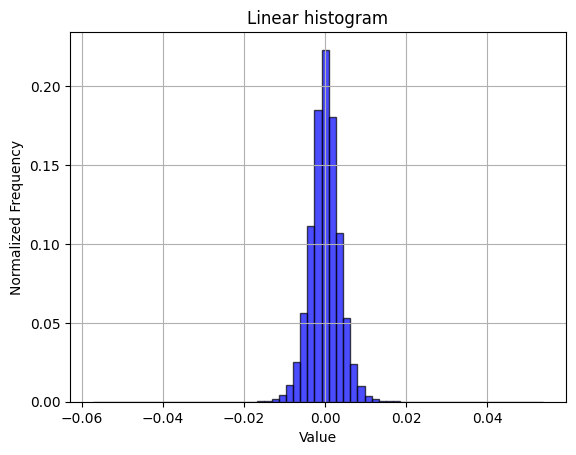

Module: Linear
Operation: Linear(in_features=4096, out_features=1024, bias=False)
[4.76837158e-07 0.00000000e+00 0.00000000e+00 2.38418579e-07
 7.15255737e-07 1.19209290e-06 1.43051147e-06 1.43051147e-06
 2.14576721e-06 4.05311584e-06 5.24520874e-06 6.43730164e-06
 1.45435333e-05 1.83582306e-05 2.83718109e-05 4.14848328e-05
 6.67572021e-05 1.03950500e-04 1.82867050e-04 3.02314758e-04
 5.09023666e-04 8.90970230e-04 1.54757500e-03 2.69246101e-03
 4.71735001e-03 8.17584991e-03 1.39870644e-02 2.26182938e-02
 3.51111889e-02 5.14500141e-02 7.15928078e-02 9.19382572e-02
 1.08481884e-01 1.19558334e-01 1.14391565e-01 9.96510983e-02
 7.99069405e-02 6.06338978e-02 4.17711735e-02 2.75189877e-02
 1.75600052e-02 1.03588104e-02 5.96213341e-03 3.45802307e-03
 1.97982788e-03 1.12271309e-03 6.46352768e-04 3.83853912e-04
 2.36034393e-04 1.32560730e-04 8.41617584e-05 5.96046448e-05
 2.88486481e-05 1.93119049e-05 1.47819519e-05 1.09672546e-05
 5.72204590e-06 2.86102295e-06 2.86102295e-06 1.90734863e-06
 9.

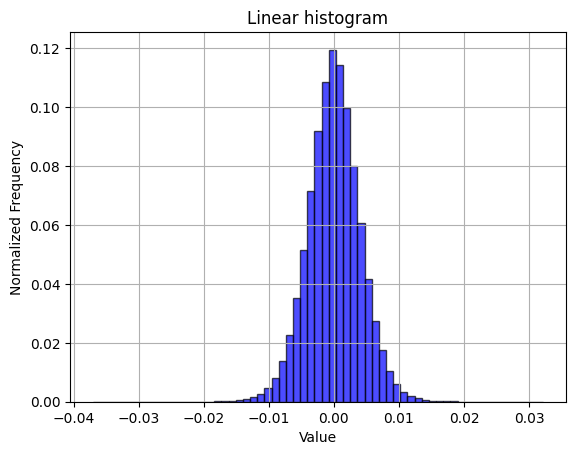

Module: MistralRotaryEmbedding
Operation: MistralRotaryEmbedding()
No weights in this module.
Module: Linear
Operation: Linear(in_features=4096, out_features=4096, bias=False)
[1.19209290e-07 5.96046448e-08 5.96046448e-08 1.19209290e-07
 1.19209290e-07 1.78813934e-07 2.38418579e-07 3.57627869e-07
 5.36441803e-07 7.74860382e-07 9.53674316e-07 1.25169754e-06
 1.84774399e-06 1.78813934e-06 2.86102295e-06 3.75509262e-06
 7.86781311e-06 1.84774399e-05 8.01086426e-05 3.76164913e-04
 1.64794922e-03 6.78223372e-03 2.31202245e-02 6.18667006e-02
 1.28039300e-01 1.98873341e-01 2.23678291e-01 1.80096269e-01
 1.05766654e-01 4.73504663e-02 1.63729787e-02 4.46003675e-03
 1.12491846e-03 2.43186951e-04 4.95910645e-05 1.19805336e-05
 4.17232513e-06 3.93390656e-06 3.03983688e-06 1.90734863e-06
 8.94069672e-07 1.25169754e-06 7.15255737e-07 8.34465027e-07
 4.17232513e-07 2.38418579e-07 1.78813934e-07 5.96046448e-08
 1.78813934e-07 0.00000000e+00 0.00000000e+00 1.78813934e-07
 5.96046448e-08 0.00000000e+00 

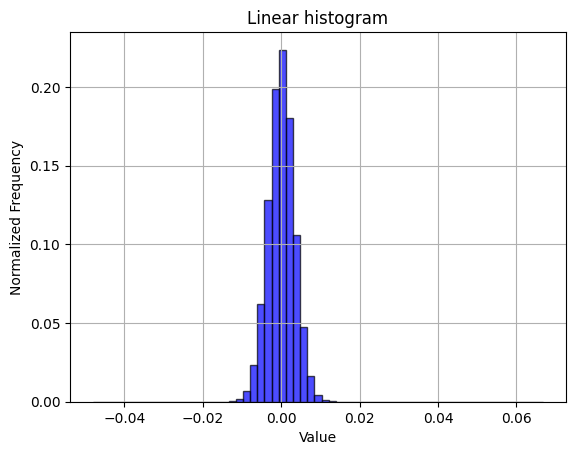

Module: MistralSdpaAttention
Operation: MistralSdpaAttention(
  (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
  (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
  (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
  (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
  (rotary_emb): MistralRotaryEmbedding()
)
No weights in this module.
Module: Linear
Operation: Linear(in_features=4096, out_features=14336, bias=False)
[3.40597970e-08 0.00000000e+00 5.10896955e-08 1.70298985e-08
 1.70298985e-08 5.10896955e-08 5.10896955e-08 5.10896955e-08
 1.02179391e-07 1.19209290e-07 1.19209290e-07 2.21388681e-07
 3.23568072e-07 6.30106245e-07 7.32285636e-07 1.10694340e-06
 1.46457127e-06 2.52042498e-06 5.43253762e-06 1.32492610e-05
 4.84500613e-05 2.55278179e-04 1.42834868e-03 7.68642766e-03
 3.30771548e-02 1.03792684e-01 2.14213576e-01 2.75010603e-01
 2.15858221e-01 1.04845643e-01 3.40255669e-02 8.01818711e-03
 1.39497008e-03 2.4405547

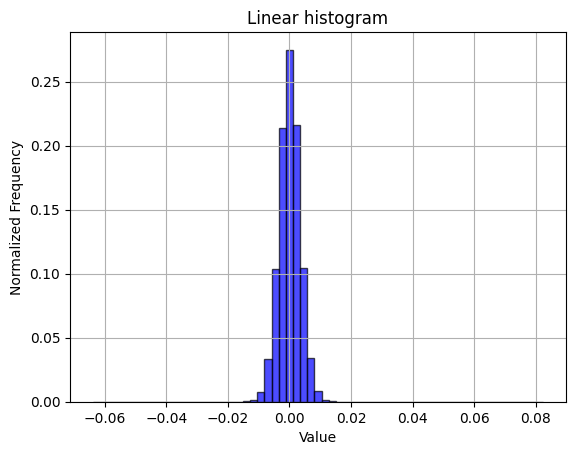

Module: SiLU
Operation: SiLU()
No weights in this module.
Module: Linear
Operation: Linear(in_features=4096, out_features=14336, bias=False)
[1.70298985e-08 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.70298985e-08
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 3.40597970e-08 3.40597970e-08 5.10896955e-08
 8.51494925e-08 3.40597970e-08 3.40597970e-08 6.81195940e-08
 1.70298985e-07 3.57627869e-07 5.27926854e-07 1.20912279e-06
 2.16279711e-06 5.75610570e-06 3.50986208e-05 5.05549567e-04
 6.29840578e-03 4.52363321e-02 1.70555268e-01 3.20158482e-01
 2.92990276e-01 1.30908762e-01 2.94382572e-02 3.57202121e-03
 2.63588769e-04 1.91416059e-05 4.25747463e-06 1.70298985e-06
 9.87734113e-07 4.76837158e-07 3.91687666e-07 1.02179391e-07
 1.02179391e-07 6.81195940e-08 5.10896955e-08 3.40597970e-08
 1.70298985e-08 1.70298985e-08 0.00000000e+00 1.70298985e-08
 1.70298985e-08 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

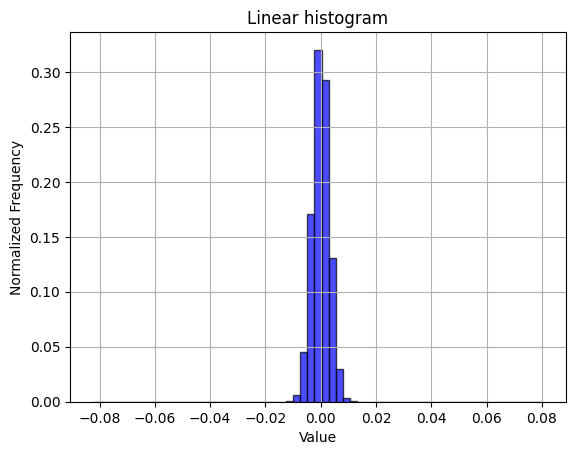

Module: Linear
Operation: Linear(in_features=14336, out_features=4096, bias=False)
[1.70298985e-08 0.00000000e+00 0.00000000e+00 1.70298985e-08
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.70298985e-08 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.70298985e-08 1.70298985e-08 8.51494925e-08 5.10896955e-08
 3.40597970e-08 1.70298985e-07 2.21388681e-07 6.47136143e-07
 9.19614519e-07 2.58854457e-06 1.35898590e-05 1.23231752e-03
 4.75288119e-02 3.62803885e-01 4.79042632e-01 1.04994297e-01
 4.32617324e-03 4.75645065e-05 3.37191990e-06 1.19209290e-06
 5.79016549e-07 3.06538173e-07 1.36239188e-07 5.10896955e-08
 5.10896955e-08 5.10896955e-08 6.81195940e-08 5.10896955e-08
 0.00000000e+00 0.00000000e+00 3.40597970e-08 0.00000000e+00
 0

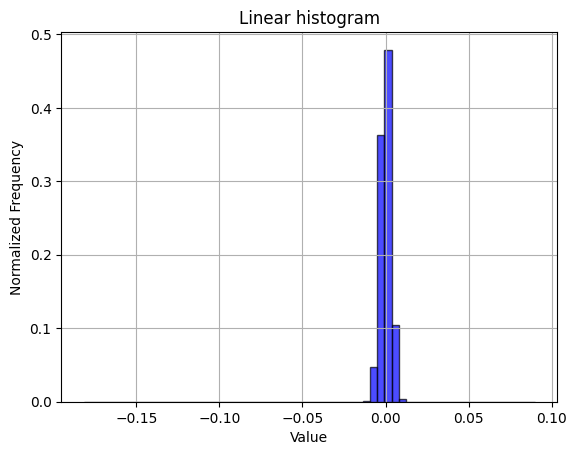

Module: MistralMLP
Operation: MistralMLP(
  (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
  (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
  (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
  (act_fn): SiLU()
)
No weights in this module.
Module: MistralDecoderLayer
Operation: MistralDecoderLayer(
  (self_attn): MistralSdpaAttention(
    (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
    (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
    (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
    (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
    (rotary_emb): MistralRotaryEmbedding()
  )
  (mlp): MistralMLP(
    (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
    (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
    (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
    (act_fn): SiLU()
  )
  (inp

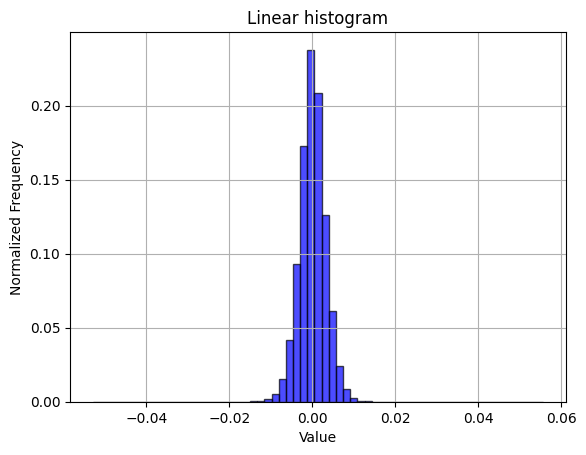

Module: Linear
Operation: Linear(in_features=4096, out_features=1024, bias=False)
[7.15255737e-07 0.00000000e+00 2.38418579e-07 7.15255737e-07
 0.00000000e+00 9.53674316e-07 9.53674316e-07 7.15255737e-07
 2.38418579e-06 3.81469727e-06 3.33786011e-06 5.48362732e-06
 7.39097595e-06 9.29832458e-06 1.02519989e-05 1.26361847e-05
 1.38282776e-05 1.85966492e-05 3.43322754e-05 3.69548798e-05
 6.15119934e-05 1.22785568e-04 2.63690948e-04 6.55174255e-04
 1.83773041e-03 5.45096397e-03 1.42917633e-02 3.62195969e-02
 8.18486214e-02 1.57225132e-01 2.29019403e-01 2.17311859e-01
 1.39094591e-01 6.80615902e-02 2.98867226e-02 1.17406845e-02
 4.19735909e-03 1.50060654e-03 5.15699387e-04 2.16960907e-04
 1.05142593e-04 6.60419464e-05 3.98159027e-05 2.45571136e-05
 1.95503235e-05 1.26361847e-05 1.23977661e-05 5.96046448e-06
 6.91413879e-06 4.29153442e-06 5.00679016e-06 3.57627869e-06
 2.86102295e-06 2.14576721e-06 1.66893005e-06 4.76837158e-07
 4.76837158e-07 2.38418579e-07 4.76837158e-07 0.00000000e+00
 2.

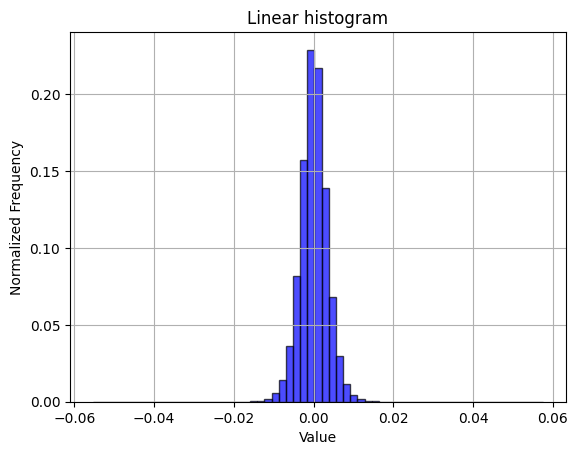

Module: Linear
Operation: Linear(in_features=4096, out_features=1024, bias=False)
[2.38418579e-07 4.76837158e-07 2.38418579e-07 7.15255737e-07
 2.38418579e-07 1.90734863e-06 2.38418579e-06 4.05311584e-06
 6.91413879e-06 1.12056732e-05 2.40802765e-05 4.45842743e-05
 7.22408295e-05 1.22070312e-04 2.12192535e-04 3.18288803e-04
 6.61849976e-04 1.13892555e-03 1.93858147e-03 3.12733650e-03
 5.44285774e-03 8.99672508e-03 1.45950317e-02 2.19731331e-02
 3.46727371e-02 4.89766598e-02 6.89368248e-02 8.84056091e-02
 1.06774092e-01 1.21257544e-01 1.15572691e-01 9.86177921e-02
 7.94634819e-02 5.95688820e-02 4.28965092e-02 2.82976627e-02
 1.85136795e-02 1.17821693e-02 7.27391243e-03 4.10723686e-03
 2.60305405e-03 1.53946877e-03 8.62360001e-04 4.92095947e-04
 2.93731689e-04 1.67846680e-04 9.15527344e-05 5.19752502e-05
 3.33786011e-05 1.71661377e-05 1.54972076e-05 6.91413879e-06
 5.48362732e-06 1.66893005e-06 1.43051147e-06 7.15255737e-07
 2.38418579e-07 4.76837158e-07 7.15255737e-07 0.00000000e+00
 2.

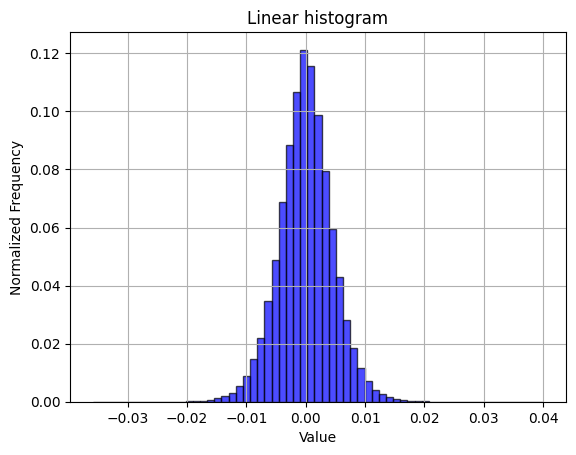

Module: MistralRotaryEmbedding
Operation: MistralRotaryEmbedding()
No weights in this module.
Module: Linear
Operation: Linear(in_features=4096, out_features=4096, bias=False)
[5.96046448e-08 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.78813934e-07 1.19209290e-07
 3.57627869e-07 2.38418579e-07 1.78813934e-07 1.78813934e-07
 7.15255737e-07 1.78813934e-07 1.13248825e-06 1.31130219e-06
 1.90734863e-06 3.21865082e-06 4.52995300e-06 8.58306885e-06
 1.50799751e-05 3.27229500e-05 1.06811523e-04 3.56197357e-04
 1.39003992e-03 5.03337383e-03 1.78383589e-02 5.22006154e-02
 1.22126997e-01 2.09847927e-01 2.46986985e-01 1.87814653e-01
 9.86848474e-02 3.97139788e-02 1.29219294e-02 3.54588032e-03
 9.73463058e-04 2.49564648e-04 7.62343407e-05 2.81333923e-05
 1.34110451e-05 6.91413879e-06 5.24520874e-06 2.86102295e-06
 1.66893005e-06 7.15255737e-07 7.15255737e-07 7.74860382e-07
 3.57627869e-07 2.38418579e-07 

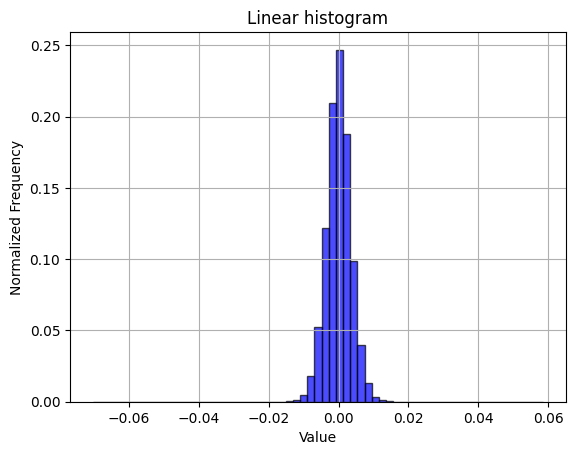

Module: MistralSdpaAttention
Operation: MistralSdpaAttention(
  (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
  (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
  (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
  (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
  (rotary_emb): MistralRotaryEmbedding()
)
No weights in this module.
Module: Linear
Operation: Linear(in_features=4096, out_features=14336, bias=False)
[1.70298985e-08 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.70298985e-08 0.00000000e+00 1.70298985e-08 0.00000000e+00
 1.70298985e-08 5.10896955e-08 1.70298985e-08 0.00000000e+00
 1.70298985e-08 6.81195940e-08 3.40597970e-08 3.40597970e-08
 1.70298985e-08 1.36239188e-07 1.70298985e-07 2.55448478e-07
 2.72478376e-07 5.10896955e-07 1.07288361e-06 2.06061772e-06
 3.72954777e-06 8.22544098e-06 2.47614724e-05 1.09621457e-04
 4.92913382e-04 2.5490352

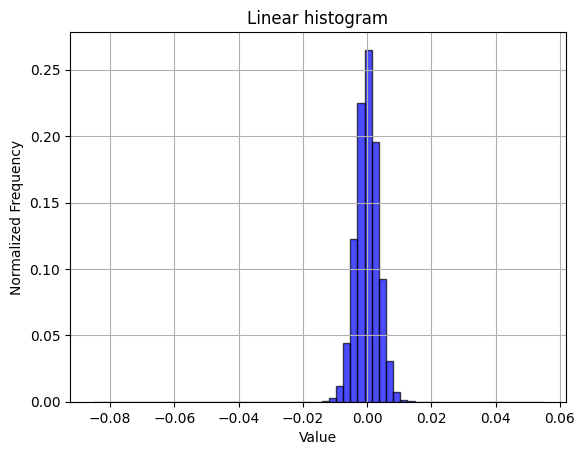

Module: SiLU
Operation: SiLU()
No weights in this module.
Module: Linear
Operation: Linear(in_features=4096, out_features=14336, bias=False)
[1.70298985e-08 0.00000000e+00 0.00000000e+00 0.00000000e+00
 5.10896955e-08 0.00000000e+00 0.00000000e+00 3.40597970e-08
 3.40597970e-08 1.70298985e-08 0.00000000e+00 1.02179391e-07
 1.87328884e-07 2.89508275e-07 4.08717564e-07 4.76837158e-07
 6.98225839e-07 5.96046448e-07 1.12397330e-06 1.24318259e-06
 1.39645168e-06 1.75407955e-06 2.26497650e-06 2.65666417e-06
 2.96320234e-06 4.30856432e-06 7.37394605e-06 2.26497650e-05
 2.20366887e-04 2.60656221e-03 1.99686800e-02 8.92393930e-02
 2.25760511e-01 3.13298379e-01 2.31040801e-01 9.33495079e-02
 2.12358407e-02 2.92805263e-03 2.47819083e-04 2.45060240e-05
 7.52721514e-06 4.24044473e-06 3.18459102e-06 2.86102295e-06
 2.58854457e-06 1.65190016e-06 1.43051147e-06 1.17506300e-06
 1.22615269e-06 8.51494925e-07 6.81195940e-07 5.27926854e-07
 3.57627869e-07 2.38418579e-07 1.19209290e-07 1.02179391e-07
 6.81

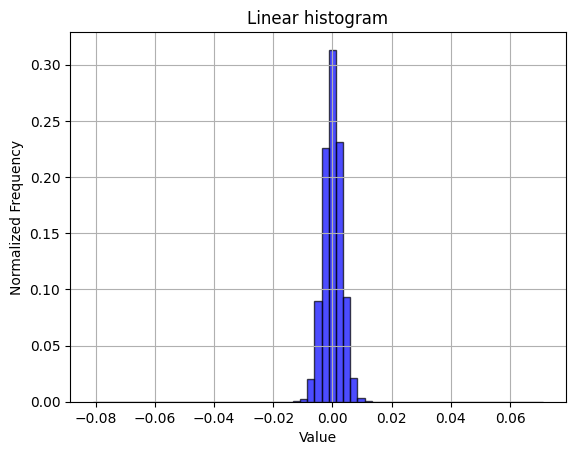

Module: Linear
Operation: Linear(in_features=14336, out_features=4096, bias=False)
[1.70298985e-08 0.00000000e+00 1.70298985e-08 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 5.10896955e-08 3.40597970e-08 3.40597970e-08 3.40597970e-08
 1.70298985e-08 5.10896955e-08 1.53269087e-07 6.81195940e-08
 4.25747463e-07 6.13076346e-07 1.31130219e-06 3.91687666e-06
 3.12668937e-05 1.54716628e-03 3.29950878e-02 2.27099742e-01
 4.58611148e-01 2.41105454e-01 3.68076563e-02 1.75106525e-03
 3.78744943e-05 3.89984676e-06 1.24318259e-06 6.47136143e-07
 3.74657767e-07 1.87328884e-07 1.02179391e-07 1.02179391e-07
 3.40597970e-08 3.40597970e-08 3.40597970e-08 1.70298985e-08
 1.70298985e-08 1.70298985e-08 1.70298985e-08 0.00000000e+00
 1.70298985e-08 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.70298985e-08
 1.70298985e-08 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0

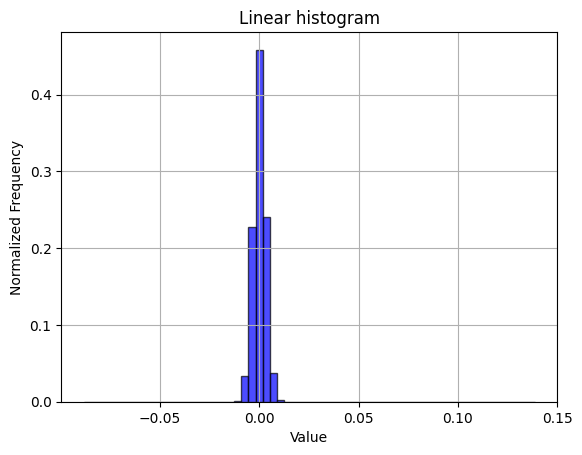

Module: MistralMLP
Operation: MistralMLP(
  (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
  (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
  (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
  (act_fn): SiLU()
)
No weights in this module.
Module: MistralDecoderLayer
Operation: MistralDecoderLayer(
  (self_attn): MistralSdpaAttention(
    (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
    (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
    (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
    (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
    (rotary_emb): MistralRotaryEmbedding()
  )
  (mlp): MistralMLP(
    (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
    (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
    (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
    (act_fn): SiLU()
  )
  (inp

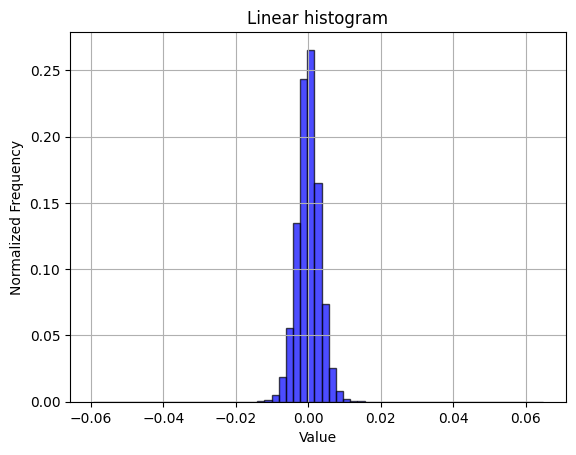

Module: Linear
Operation: Linear(in_features=4096, out_features=1024, bias=False)
[4.76837158e-07 2.38418579e-07 2.38418579e-07 0.00000000e+00
 2.38418579e-07 7.15255737e-07 4.76837158e-07 2.38418579e-07
 1.43051147e-06 7.15255737e-07 1.19209290e-06 1.90734863e-06
 3.33786011e-06 2.38418579e-06 4.52995300e-06 7.62939453e-06
 5.96046448e-06 1.19209290e-05 1.28746033e-05 1.78813934e-05
 2.52723694e-05 3.83853912e-05 7.62939453e-05 1.09195709e-04
 2.53915787e-04 5.79118729e-04 1.58834457e-03 4.20808792e-03
 1.16102695e-02 2.99181938e-02 6.78448677e-02 1.38284922e-01
 2.19611645e-01 2.30569124e-01 1.55987024e-01 8.07235241e-02
 3.54866982e-02 1.45890713e-02 5.18226624e-03 1.87516212e-03
 7.11441040e-04 2.76088715e-04 1.25646591e-04 7.72476196e-05
 5.41210175e-05 3.33786011e-05 2.05039978e-05 1.88350677e-05
 1.40666962e-05 8.58306885e-06 6.19888306e-06 5.24520874e-06
 4.52995300e-06 1.90734863e-06 1.43051147e-06 2.14576721e-06
 9.53674316e-07 0.00000000e+00 1.19209290e-06 2.38418579e-07
 0.

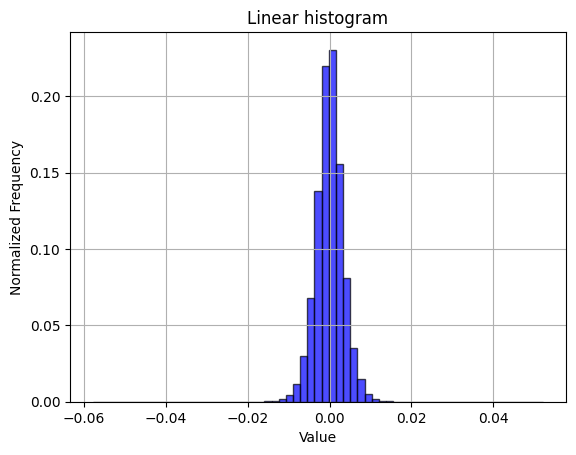

Module: Linear
Operation: Linear(in_features=4096, out_features=1024, bias=False)
[2.38418579e-07 2.38418579e-07 2.38418579e-07 2.38418579e-07
 0.00000000e+00 4.76837158e-07 1.43051147e-06 1.19209290e-06
 1.66893005e-06 2.38418579e-06 2.86102295e-06 5.48362732e-06
 8.82148743e-06 1.19209290e-05 2.00271606e-05 2.38418579e-05
 4.57763672e-05 5.69820404e-05 1.04427338e-04 1.77383423e-04
 2.85863876e-04 5.34772873e-04 9.99450684e-04 1.94978714e-03
 3.89289856e-03 7.39860535e-03 1.38027668e-02 2.60403156e-02
 4.44123745e-02 6.86502457e-02 1.01061344e-01 1.29164219e-01
 1.49061918e-01 1.38522387e-01 1.11005783e-01 8.00547600e-02
 5.33306599e-02 3.16786766e-02 1.76267624e-02 9.77969170e-03
 4.81724739e-03 2.47573853e-03 1.36470795e-03 7.03573227e-04
 3.45468521e-04 2.18868256e-04 1.27792358e-04 7.48634338e-05
 5.05447388e-05 3.09944153e-05 2.28881836e-05 1.62124634e-05
 1.12056732e-05 6.91413879e-06 5.00679016e-06 3.09944153e-06
 2.62260437e-06 9.53674316e-07 2.38418579e-07 7.15255737e-07
 4.

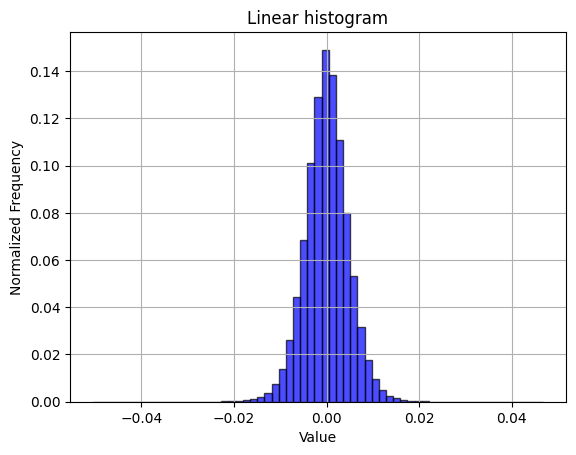

Module: MistralRotaryEmbedding
Operation: MistralRotaryEmbedding()
No weights in this module.
Module: Linear
Operation: Linear(in_features=4096, out_features=4096, bias=False)
[1.19209290e-07 5.96046448e-08 0.00000000e+00 5.96046448e-08
 1.78813934e-07 1.78813934e-07 3.57627869e-07 3.57627869e-07
 1.78813934e-07 2.38418579e-07 4.17232513e-07 3.57627869e-07
 1.78813934e-07 3.57627869e-07 8.94069672e-07 8.34465027e-07
 1.13248825e-06 1.72853470e-06 2.92062759e-06 5.00679016e-06
 3.87430191e-06 7.39097595e-06 1.49607658e-05 7.00950623e-05
 6.22391701e-04 5.31059504e-03 3.35872769e-02 1.37991846e-01
 3.04057539e-01 3.15548480e-01 1.54722989e-01 4.05785441e-02
 6.56133890e-03 7.79986382e-04 8.07046890e-05 1.65104866e-05
 6.97374344e-06 6.07967377e-06 4.23192978e-06 3.15904617e-06
 2.32458115e-06 1.54972076e-06 5.96046448e-07 2.98023224e-07
 6.55651093e-07 3.57627869e-07 4.17232513e-07 5.96046448e-07
 4.17232513e-07 5.36441803e-07 2.98023224e-07 4.76837158e-07
 1.78813934e-07 2.98023224e-07 

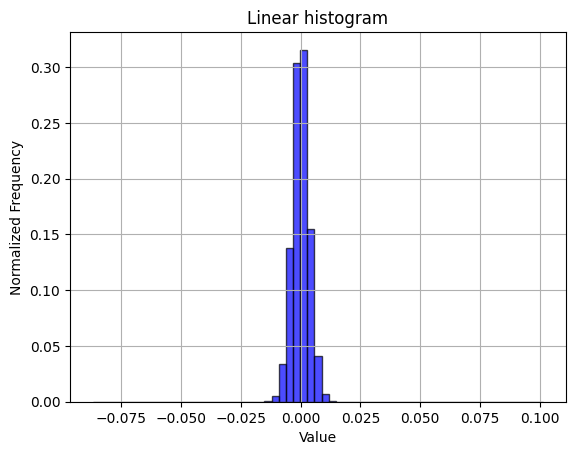

Module: MistralSdpaAttention
Operation: MistralSdpaAttention(
  (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
  (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
  (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
  (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
  (rotary_emb): MistralRotaryEmbedding()
)
No weights in this module.
Module: Linear
Operation: Linear(in_features=4096, out_features=14336, bias=False)
[1.70298985e-08 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.70298985e-08
 0.00000000e+00 1.70298985e-08 3.40597970e-08 0.00000000e+00
 3.40597970e-08 0.00000000e+00 5.10896955e-08 1.70298985e-08
 5.10896955e-08 1.02179391e-07 2.55448478e-07 3.91687666e-07
 5.10896955e-07 8.00405230e-07 1.00476401e-06 1.65190016e-06
 2.07764762e-06 2.98023224e-06 2.96320234e-06 4.17232513e-06
 6.59057072e-06 8.92366682e-06 1.37601580e-05 4.57763672e-05
 2.41143363e-04 1.8150976

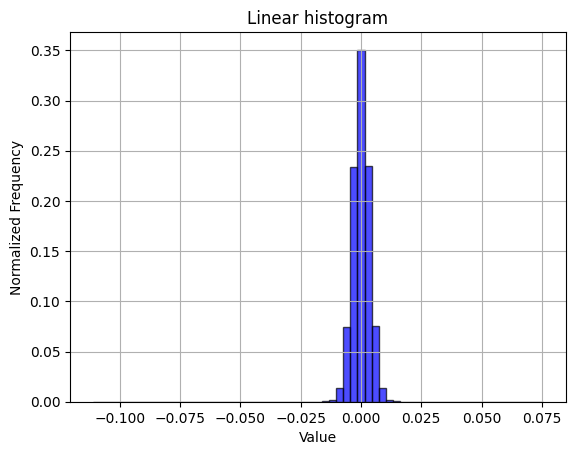

Module: SiLU
Operation: SiLU()
No weights in this module.
Module: Linear
Operation: Linear(in_features=4096, out_features=14336, bias=False)
[3.40597970e-08 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.70298985e-08 0.00000000e+00 1.70298985e-08 1.70298985e-08
 0.00000000e+00 3.40597970e-08 0.00000000e+00 0.00000000e+00
 1.36239188e-07 6.81195940e-08 1.53269087e-07 2.38418579e-07
 1.70298985e-07 2.89508275e-07 5.44956752e-07 6.47136143e-07
 1.22615269e-06 1.68595995e-06 2.86102295e-06 3.15053122e-06
 4.81946128e-06 7.06740788e-06 1.10013144e-05 2.29392733e-05
 1.88640186e-04 2.57406916e-03 2.33649867e-02 1.14618846e-01
 2.80176163e-01 3.32307577e-01 1.86556969e-01 5.18346684e-02
 7.59211608e-03 6.36645726e-04 5.15665327e-05 1.39815467e-05
 7.96999250e-06 5.77313559e-06 4.10420554e-06 2.96320234e-06
 2.06061772e-06 1.43051147e-06 6.30106245e-07 6.30106245e-07
 3.91687666e-07 1.36239188e-07 1.19209290e-07 8.51494925e-08
 1.02179391e-07 8.51494925e-08 3.40597970e-08 3.40597970e-08
 3.40

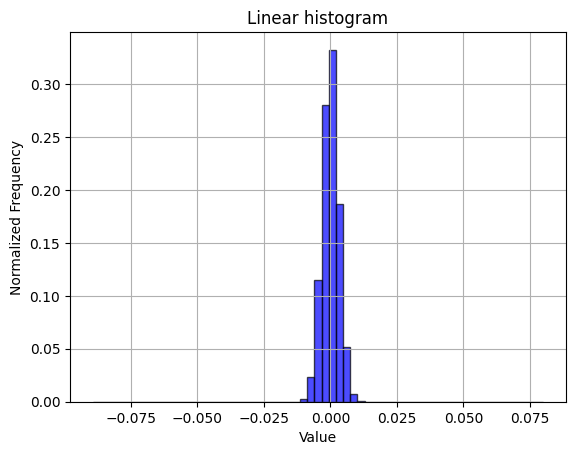

Module: Linear
Operation: Linear(in_features=14336, out_features=4096, bias=False)
[1.70298985e-08 0.00000000e+00 3.40597970e-08 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.70298985e-08 3.40597970e-08 0.00000000e+00 0.00000000e+00
 1.70298985e-08 0.00000000e+00 1.70298985e-08 1.70298985e-08
 3.40597970e-08 1.02179391e-07 1.70298985e-08 1.87328884e-07
 8.51494925e-08 3.06538173e-07 2.55448478e-07 3.40597970e-07
 8.00405230e-07 1.51566097e-06 3.09944153e-06 8.71930804e-06
 3.16279275e-04 6.58977032e-02 6.58786689e-01 2.70445977e-01
 4.50859751e-03 2.03166689e-05 4.29153442e-06 1.54972076e-06
 1.10694340e-06 5.27926854e-07 4.76837158e-07 2.72478376e-07
 1.53269087e-07 1.19209290e-07 3.40597970e-08 6.81195940e-08
 1.70298985e-08 5.10896955e-08 5.10896955e-08 1.70298985e-08
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.70298985e-08 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.70298985e-08 1.70298985e-08 0.00000000e+00 1.70298985e-08
 0

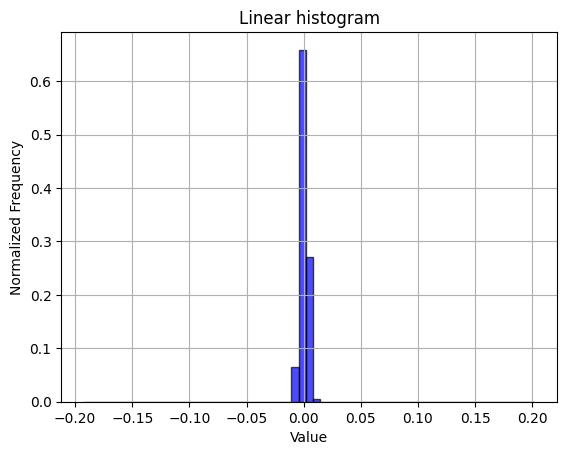

Module: MistralMLP
Operation: MistralMLP(
  (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
  (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
  (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
  (act_fn): SiLU()
)
No weights in this module.
Module: MistralDecoderLayer
Operation: MistralDecoderLayer(
  (self_attn): MistralSdpaAttention(
    (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
    (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
    (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
    (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
    (rotary_emb): MistralRotaryEmbedding()
  )
  (mlp): MistralMLP(
    (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
    (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
    (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
    (act_fn): SiLU()
  )
  (inp

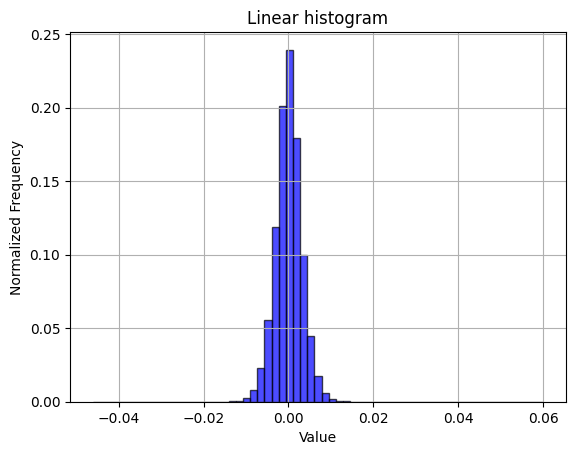

Module: Linear
Operation: Linear(in_features=4096, out_features=1024, bias=False)
[2.38418579e-07 0.00000000e+00 0.00000000e+00 0.00000000e+00
 4.76837158e-07 0.00000000e+00 0.00000000e+00 7.15255737e-07
 7.15255737e-07 4.76837158e-07 4.76837158e-07 7.15255737e-07
 1.66893005e-06 1.66893005e-06 2.38418579e-06 4.29153442e-06
 6.43730164e-06 6.43730164e-06 9.29832458e-06 1.00135803e-05
 2.09808350e-05 1.93119049e-05 3.93390656e-05 5.14984131e-05
 8.10623169e-05 1.85012817e-04 3.97205353e-04 1.31344795e-03
 4.15325165e-03 1.34079456e-02 3.85382175e-02 9.69996452e-02
 1.99502468e-01 2.72650480e-01 2.07042217e-01 1.02139711e-01
 4.18517590e-02 1.46005154e-02 4.63867188e-03 1.37710571e-03
 4.83512878e-04 1.79767609e-04 9.67979431e-05 5.69820404e-05
 3.64780426e-05 2.38418579e-05 1.74045563e-05 1.43051147e-05
 7.86781311e-06 7.15255737e-06 4.52995300e-06 3.33786011e-06
 3.09944153e-06 2.86102295e-06 2.62260437e-06 7.15255737e-07
 2.38418579e-07 7.15255737e-07 2.38418579e-07 7.15255737e-07
 4.

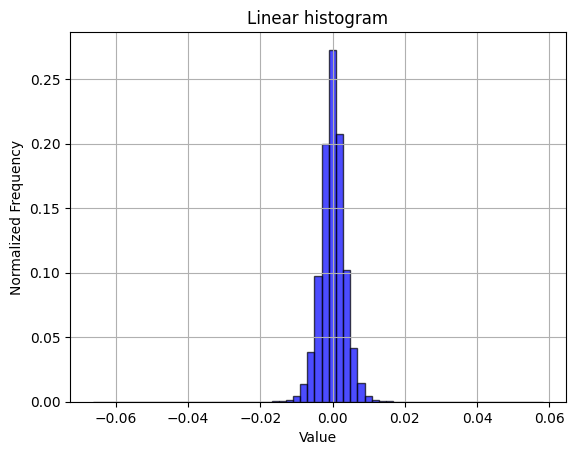

Module: Linear
Operation: Linear(in_features=4096, out_features=1024, bias=False)
[2.38418579e-07 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.38418579e-07 0.00000000e+00 0.00000000e+00 7.15255737e-07
 9.53674316e-07 4.76837158e-07 2.38418579e-06 2.62260437e-06
 8.10623169e-06 8.34465027e-06 1.54972076e-05 2.28881836e-05
 2.93254852e-05 5.17368317e-05 7.65323639e-05 1.21831894e-04
 1.97887421e-04 3.29017639e-04 5.45501709e-04 1.01804733e-03
 1.80315971e-03 3.39531898e-03 6.35170937e-03 1.14209652e-02
 2.01277733e-02 3.37886810e-02 5.27865887e-02 7.83965588e-02
 1.04324579e-01 1.28286362e-01 1.38791323e-01 1.25197649e-01
 9.92970467e-02 7.23643303e-02 4.89213467e-02 3.11632156e-02
 1.82094574e-02 1.03697777e-02 5.70058823e-03 3.06415558e-03
 1.64771080e-03 9.13619995e-04 4.80413437e-04 2.86817551e-04
 1.69277191e-04 1.06811523e-04 7.27176666e-05 4.69684601e-05
 3.07559967e-05 1.71661377e-05 1.12056732e-05 6.67572021e-06
 5.96046448e-06 4.52995300e-06 1.66893005e-06 1.90734863e-06
 7.

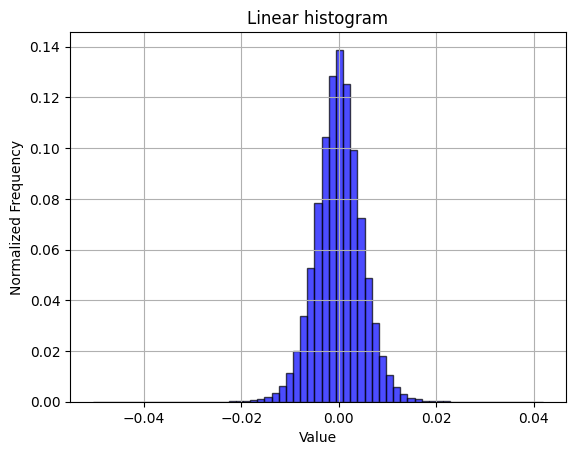

Module: MistralRotaryEmbedding
Operation: MistralRotaryEmbedding()
No weights in this module.
Module: Linear
Operation: Linear(in_features=4096, out_features=4096, bias=False)
[1.19209290e-07 2.98023224e-07 5.96046448e-07 4.76837158e-07
 1.19209290e-06 1.19209290e-06 1.37090683e-06 1.13248825e-06
 1.01327896e-06 9.53674316e-07 4.76837158e-07 3.57627869e-07
 1.78813934e-07 4.76837158e-07 5.96046448e-08 0.00000000e+00
 5.96046448e-08 2.98023224e-07 1.07288361e-06 1.37090683e-06
 1.72853470e-06 2.20537186e-06 3.09944153e-06 5.48362732e-06
 8.70227814e-06 1.74045563e-05 3.06963921e-05 6.44922256e-05
 2.07722187e-04 3.95870209e-03 1.17228627e-01 6.06331527e-01
 2.58244336e-01 1.32838488e-02 4.15265560e-04 8.96453857e-05
 3.73125076e-05 2.02059746e-05 1.12056732e-05 6.13927841e-06
 3.27825546e-06 2.32458115e-06 1.60932541e-06 1.19209290e-06
 9.53674316e-07 7.15255737e-07 1.78813934e-07 4.76837158e-07
 1.19209290e-07 2.38418579e-07 2.98023224e-07 3.57627869e-07
 1.78813934e-07 4.17232513e-07 

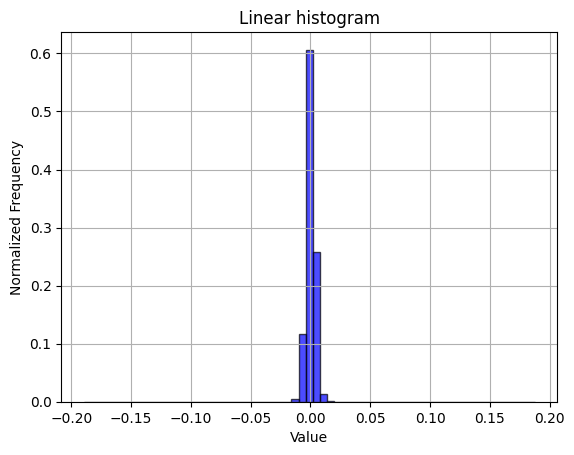

Module: MistralSdpaAttention
Operation: MistralSdpaAttention(
  (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
  (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
  (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
  (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
  (rotary_emb): MistralRotaryEmbedding()
)
No weights in this module.
Module: Linear
Operation: Linear(in_features=4096, out_features=14336, bias=False)
[1.70298985e-08 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.70298985e-08
 3.40597970e-08 0.00000000e+00 3.40597970e-08 3.40597970e-08
 5.10896955e-08 5.10896955e-08 2.04358782e-07 5.61986651e-07
 4.08717564e-07 1.10694340e-06 2.72478376e-06 7.25473676e-06
 2.03847885e-05 8.10452870e-05 2.64951161e-04 8.32097871e-04
 2.72110530e-03 8.54395117e-03 2.40844318e-02 6.19022676e-02
 1.24201196e-01 1.91497735e-01 2.17978409e-01 1.79185390e-01
 1.07960054e-01 5.1666532

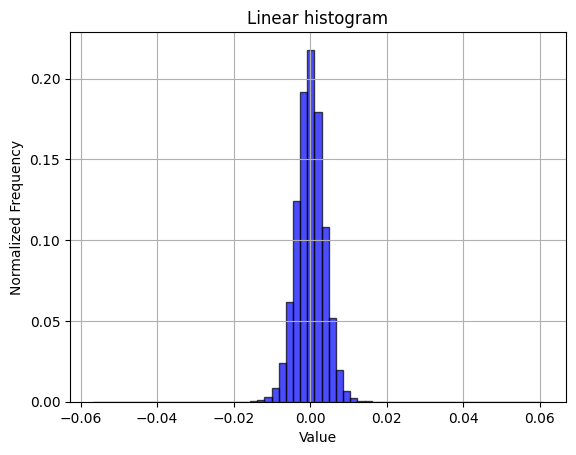

Module: SiLU
Operation: SiLU()
No weights in this module.
Module: Linear
Operation: Linear(in_features=4096, out_features=14336, bias=False)
[1.70298985e-08 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.70298985e-08
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.70298985e-08
 1.70298985e-08 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.70298985e-08 0.00000000e+00 3.40597970e-08 8.51494925e-08
 2.04358782e-07 1.70298985e-07 1.36239188e-07 3.40597970e-07
 7.83375331e-07 2.41824559e-06 8.92366682e-06 1.57185963e-05
 4.34773309e-05 4.22528812e-04 5.22623743e-03 4.16988134e-02
 1.73018694e-01 3.42738594e-01 2.96741196e-01 1.15491441e-01
 2.20765046e-02 2.28435653e-03 1.77008765e-04 2.85250800e-05
 1.36239188e-05 6.36918204e-06 1.73704965e-06 9.02584621e-07
 3.91687666e-07 2.72478376e-07 1.19209290e-07 1.53269087e-07
 1.70

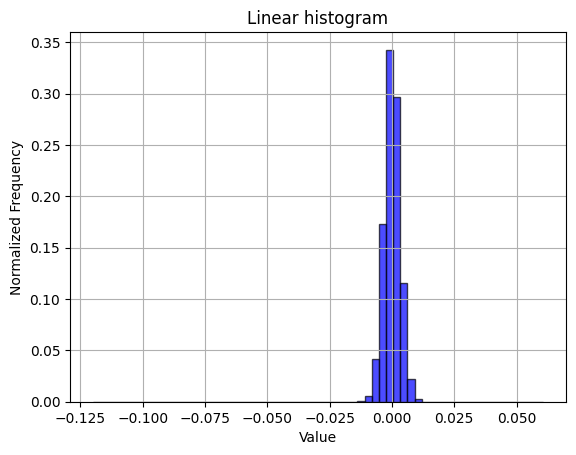

Module: Linear
Operation: Linear(in_features=14336, out_features=4096, bias=False)
[3.40597970e-08 1.70298985e-08 1.70298985e-08 0.00000000e+00
 5.10896955e-08 3.40597970e-08 0.00000000e+00 1.70298985e-08
 1.19209290e-07 5.10896955e-08 6.81195940e-08 1.36239188e-07
 1.53269087e-07 1.87328884e-07 2.55448478e-07 4.08717564e-07
 1.00476401e-06 1.19209290e-06 3.18459102e-06 8.32762037e-06
 2.57321766e-05 1.56400885e-03 1.98131936e-01 7.35631245e-01
 6.43369470e-02 2.64985221e-04 1.69106892e-05 6.82898930e-06
 2.48636518e-06 1.34536198e-06 4.76837158e-07 5.27926854e-07
 3.40597970e-07 1.87328884e-07 2.38418579e-07 6.81195940e-08
 5.10896955e-08 6.81195940e-08 5.10896955e-08 6.81195940e-08
 3.40597970e-08 8.51494925e-08 3.40597970e-08 0.00000000e+00
 3.40597970e-08 1.70298985e-08 0.00000000e+00 0.00000000e+00
 1.70298985e-08 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0

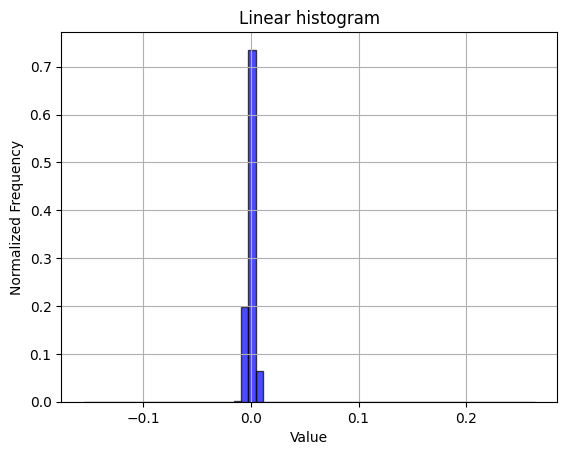

Module: MistralMLP
Operation: MistralMLP(
  (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
  (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
  (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
  (act_fn): SiLU()
)
No weights in this module.
Module: MistralDecoderLayer
Operation: MistralDecoderLayer(
  (self_attn): MistralSdpaAttention(
    (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
    (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
    (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
    (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
    (rotary_emb): MistralRotaryEmbedding()
  )
  (mlp): MistralMLP(
    (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
    (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
    (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
    (act_fn): SiLU()
  )
  (inp

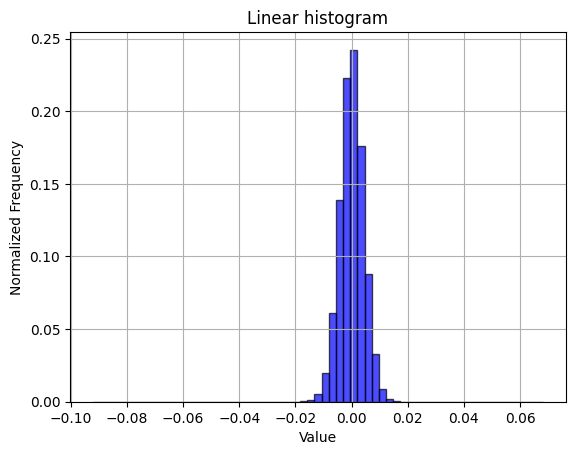

Module: MistralForCausalLM
Operation: MistralForCausalLM(
  (model): MistralModel(
    (embed_tokens): Embedding(32768, 4096)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralSdpaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): MistralRotaryEmbedding()
        )
        (mlp): MistralMLP(
          (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): MistralRMSNorm()
        (post_attention_layernorm): MistralRMSNorm()
   

'Hey, are you conscious? Can you talk to me?\n'

In [ ]:
prompt = "Hey, are you conscious? Can you talk to me?"
inputs = tokenizer(prompt, return_tensors="pt").to("cuda")

print("Input Tokens: ", len(inputs[0]))
print("Number of layers: ", idx)
# Generate
generate_ids = model.generate(inputs.input_ids, max_length=len(inputs[0]) + 1)
tokenizer.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]